In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
%matplotlib inline
import numpy as np
from scipy.integrate import odeint
import math
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
from matplotlib.ticker import LogLocator, NullFormatter
from scipy.interpolate import interp1d
from matplotlib.lines import Line2D
from scipy.optimize import curve_fit
from matplotlib import rcParams
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})


π = np.pi
Ω_cdm = 0.85
G = 6.67e-11                # in units of m^3⋅kg^−1⋅s^−2
t_i = 2.358e5                # in units of seconds
t_eq = 1.5923e12            # in units of seconds
ρ_eq = 2.1548e-16          # in units of kg m^-3
M_solar = 1.989e30        # in units of kg
c = 3e8                 #in units of m/s
A = 1.495e11                 # Astronomical unit
pc = 3.085e16               # in unist of meter. 
yr = 3.154e7              # in units of seconds
a_eq = 2.9374e-4

hbar = 1.0545718e-34        # reduced Planck constant in unkits of J.s
eV = 1.60218e-19               #in units of J
eV_to_kg = 1.7826e-36             #in units of kg
m_FDM_eV = 1e-22     #in units of eV/c²
m_FDM = m_FDM_eV * eV_to_kg      # Mass of FDM boson in units of kg


h = 0.67
ρ_c0= 1.9e-26 * (h**2) #kgm^-3  
Ω_r0 = 9.4e-5
Ω_m0 = 0.32
ρ_r0 = Ω_r0 * ρ_c0
ρ_m0 = Ω_m0 * ρ_c0
H_0 = np.sqrt((8 * π * G * ρ_c0)/3)





# Define event functions to detect turnaround points
def event_y_max(t, y, *args):
    return y[1]  # Detect velocity = 0 (turnaround)
event_y_max.terminal = False  
event_y_max.direction = -1  # Detect peak (expansion slowing down)



def event_y_min(t, y, *args):
    return y[1]  # Detect velocity = 0
event_y_min.terminal = True   # Stop at turnaround
event_y_min.direction = 1     # Detect minimum (collapse starts)



#def a(t): # as per RD
    #return np.sqrt(2 * H_0 * t)
    
#def rho_DM(t):
    #return 0.85 * ρ_m0 * (a(t)**-3)  

    
def a(t):
    return  np.sqrt(2 * t * (a_eq**2))  *  ((3/(4 * π * G * ρ_eq))**(-1/2))


def V_shell(r_outer, r_inner):
    return (4 * π / 3) * (r_outer**3 - r_inner**3)


def rho_DM(t):
    return (ρ_eq/2) * ((a(t)/a_eq)**(-3))  


def mfdm_shell_initial(r, t):
    return rho_DM(t) * ((4/3) * np.pi * (r**3)) 



def V_shell(r_outer, r_inner):
    #delta_r = r_outer - r_inner
    #if np.isclose(delta_r, 0, rtol=1e-12, atol=1e-20):
       # return 1e-10  
    #else:
    return (4/3) * np.pi * (r_outer**3 - r_inner**3)


def shells_mass(ri_arr, N, initial_density):
    m_shell = np.zeros(N)
    for j in range(N):
        if j == 0:
            m_shell[j] = initial_density * V_shell(ri_arr[j], 0)
        else:
            m_shell[j] = initial_density * V_shell(ri_arr[j], ri_arr[j-1])
    return m_shell


def shells_density(r_sol, delta_M_arr, N, rho_sol, t_arr, i, dt):
    rho_shell = np.zeros(N)
    for j in range(N - 1):
        if j == 0:
            delta_V = V_shell(r_sol[1, i], 0)
            rho_shell[j] = (delta_M_arr[1] + delta_M_arr[0]) / delta_V if delta_V > 0 else rho_sol[j, i-1]
        else:
            delta_Vj = V_shell(r_sol[j, i], r_sol[j-1, i])
            delta_Vj1 = V_shell(r_sol[j+1, i], r_sol[j, i])
            delta_Vsum = delta_Vj + delta_Vj1
            rho_shell[j] = (delta_M_arr[j] + delta_M_arr[j+1]) / delta_Vsum if delta_Vsum > 0 else rho_sol[j, i-1]

    delta_V_last = V_shell(r_sol[-1, i], r_sol[-2, i])
    rho_shell[-1] = delta_M_arr[-1] / delta_V_last if delta_V_last > 0 else rho_sol[-1, i-1]

    return rho_shell




def qp_force_numerical(rho_var, r):
    rho_var = np.clip(rho_var, 1e-20, np.inf)
    grad_rho = np.gradient(rho_var, r, edge_order=2)
    laplacian_rho = (1/(r**2)) * np.gradient((r**2) * grad_rho, r, edge_order=2)
    qp_term = (laplacian_rho/rho_var) - ((1/2) * (grad_rho**2) / (rho_var**2))
    return (1/4) * np.gradient(qp_term, r, edge_order=2)




def shells_evolution(N, t_arr, dt, ri_arr, Hubble, gravity, QP, freeze_fraction):
    rta_mask = [[] for _ in range(N)]
    tta_mask = [[] for _ in range(N)]
    r_freeze_arr = np.full(N, np.nan) 
    shells_crossing = False
    
    for i in range(len(t_arr)):
        t = t_arr[i]
        dt_i = dt[i]
        rho_arr = shells_density(r_sol, delta_M_arr, N, rho_sol, t_arr, i, dt)
        rho_sol[:, i] = rho_arr

        QP_arr = np.zeros(N)
        if QP:
            QP_arr = qp_force_numerical(rho_arr, r_sol[:, i])

        for j in range(N):
            if not mask_active[j]:
                continue

            dv_dt = 0
            if Hubble:
                dv_dt += -r_sol[j, i] / (4 * (t ** 2))
            if gravity:
                dv_dt += -1 / (r_sol[j, i] ** 2) if r_sol[j, i] > 0 else 0
            if QP:
                dv_dt += QP_arr[j]

            v_next = v_sol[j, i] + dv_dt * dt_i
            r_next = r_sol[j, i] + v_sol[j, i] * dt_i

            
            if not turnaround_detected[j] and 1 <= i < len(t_arr) - 1:
                if not turnaround_detected[j] and v_sol[j, i] > 0 and v_next < 0:
                    turnaround_detected[j] = True
                    t_ta_arr[j] = t_arr[i + 1]
                    r_ta_arr[j] = r_next
                    r_freeze_arr[j] = freeze_fraction * r_ta_arr[j]

           
            if turnaround_detected[j] and r_next <= r_freeze_arr[j]:
                r_sol[j, i + 1:] = r_freeze_arr[j]
                v_sol[j, i + 1:] = 0
                mask_active[j] = False
                cutoff_index[j] = i + 1
                continue

           
            if i < len(t_arr) - 1:
                r_sol[j, i + 1] = r_next
                v_sol[j, i + 1] = v_next
             
           
        
    if QP:
                    
        for j in range(N - 1):
            if r_sol[j, i] > r_sol[j + 1, i]:
                shells_crossing = True
                print(f"Shells crossed each-other at time = {t_arr[i]:.3e}, y_{j} = {r_sol[j, i]:.3e}, y_{j+1} = {r_sol[j+1, i]:.3e} (shell {j} overtook shell {j+1})")

        if not shells_crossing:
            print("No shells crossings is detected.")


    return r_sol, v_sol, rho_sol, QP_arr, cutoff_index, r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask


In [2]:
## N_tau_steps = 100, N_tau_index/snapshots = 15

No shells crossings is detected.


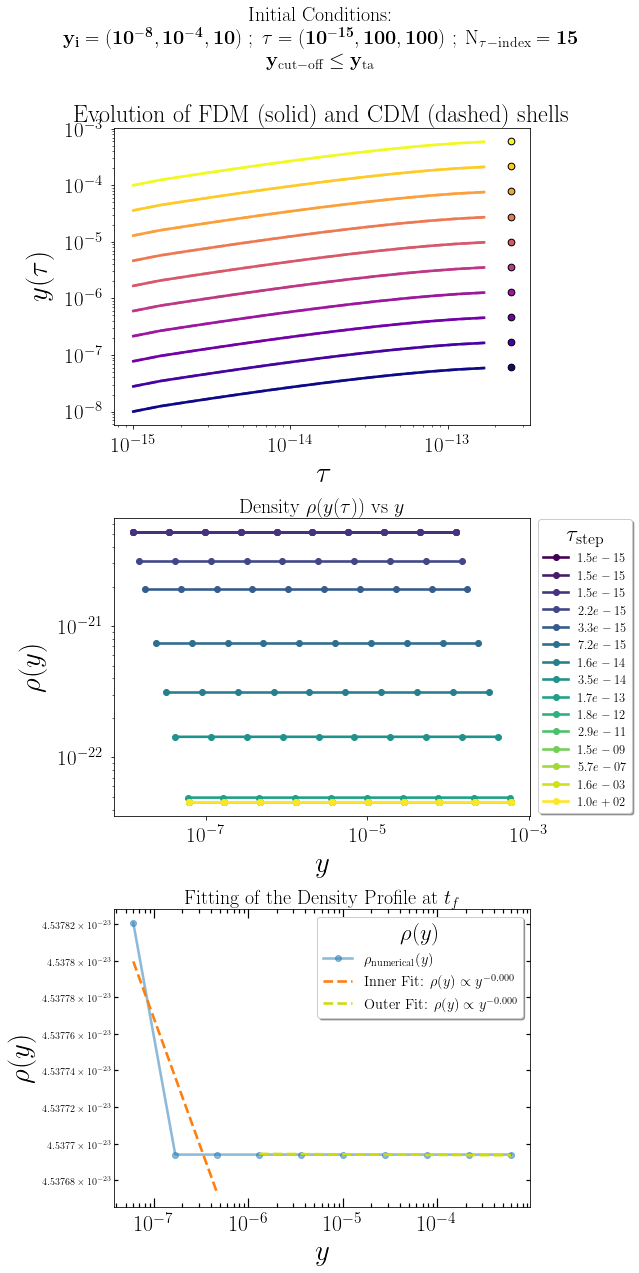

 Fitted slope (inner core):    \rho(y) \propto y^{-0.000}
 Fitted slope (outer tail):    \rho(y) \propto y^{-0.000}


In [2]:
# for 10 FDM shells

t_i, t_f = 1e-15, 1e2
N = 10
r_min, r_max = 1e-8, 1e-4
ri_arr = np.geomspace(r_min, r_max, N)
initial_density = 1e-20


delta_M_arr = shells_mass(ri_arr, N, initial_density)
QP = True
gravity = True
Hubble = True


t_step = 100
t_arr = np.geomspace(t_i, t_f, t_step)
dt = np.gradient(t_arr)

r_sol = np.zeros((N, len(t_arr)))
v_sol = np.zeros((N, len(t_arr)))
rho_sol = np.zeros((N, len(t_arr)))
mask_active = np.ones(N, dtype=bool)
cutoff_index = np.full(N, len(t_arr))
t_ta_arr = np.full(N, np.nan)
r_ta_arr = np.full(N, np.nan)
turnaround_detected = np.zeros(N, dtype=bool)
r_sol[:, 0] = ri_arr
v_sol[:, 0] = ri_arr/(2 * t_arr[0])




freeze_fraction= 1
r_sol, v_sol, rho_sol, QP_arr, cutoff_index, r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask = shells_evolution(N, t_arr, dt, ri_arr, Hubble, gravity, QP, freeze_fraction)
time_indices = np.geomspace(1, t_step-1 , 15, dtype=int)




fig, axs = plt.subplots(3, 1, figsize=(9, 18), sharex=False)
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
colors_shell = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
colors1 = cm.viridis(np.linspace(0, 1, len(time_indices)))
colors2 = cm.plasma(np.linspace(0, 1, N))
colors3 = cm.magma(np.linspace(0, 1, len(time_indices)))



#------------------------------------------------------
ax = axs[0]


QP = False
gravity = True
Hubble = True
r_sol_no_qp, v_sol_no_qp, rho_sol_no_qp, QP_arr_no_qp, cutoff_index_no_qp,  r_ta_arr_no_qp, t_ta_arr_no_qp, rho_arr_no_qp, rta_mask_no_qp, tta_mask_no_qp = shells_evolution(N, t_arr, dt, ri_arr,  
Hubble, gravity, QP, freeze_fraction)


for j in range(N):
    cutoff = cutoff_index_no_qp[j]
    ax.loglog(t_arr[:cutoff], r_sol_no_qp[j, :cutoff], color=colors2[j], linestyle='--', alpha=0.7)
    if not np.isnan(t_ta_arr_no_qp[j]):
        ax.scatter(t_ta_arr_no_qp[j], r_ta_arr_no_qp[j], marker='o', s=30, color=colors2[j], edgecolor='k', alpha=0.3)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol_no_qp[j, cutoff - 1], marker='x', s=35, color=colors_shell[j], alpha=0.3)

# Plot FDM shells (with QP) with solid lines
for j in range(N):
    cutoff = cutoff_index[j]
    ax.loglog(t_arr[:cutoff], r_sol[j, :cutoff], color=colors2[j], linestyle='-', alpha=1.0, label=fr'${ri_arr[j]:.1e}$')
    if not np.isnan(t_ta_arr[j]):
        ax.scatter(t_ta_arr[j], r_ta_arr[j], marker='o', s=45, color=colors2[j], edgecolor='k', zorder=5)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol[j, cutoff - 1], marker='x', s=50, color=colors_shell[j], zorder=5)

# Labels, title and legend
ax.set_xlabel(r'$\tau$', fontsize=29, labelpad=6)
ax.set_ylabel(r'$y(\tau)$', fontsize=29, labelpad=11)
ax.set_title('Evolution of FDM (solid) and CDM (dashed) shells', fontsize=24)
ax.tick_params(axis='x', labelsize=21, pad=7.9)
ax.tick_params(axis='y', labelsize=21, pad=7.9)

#handles, labels = ax.get_legend_handles_labels()
#legend_shells = ax.legend(handles[:7], labels[:7], prop={'size': 12.5},
                        #  loc=(1.02, 0.13), shadow=True, title='$y_{i}$', title_fontsize=27,
                        #  facecolor='white', fontsize=25)

#legend_lines = [Line2D([0], [0], color='k', linestyle='-', lw=2),
               # Line2D([0], [0], color='k', linestyle='--', lw=2)]
#ax.legend(legend_lines, ['FDM', 'CDM'], prop={'size': 15.5}, loc=(1.02, 0.64),
         # shadow=True, title='Shell', title_fontsize=23,
         # facecolor='white', fontsize=20)
#ax.add_artist(legend_shells)









#----------------------------------------------------------
#Density vs time at different time steps


ax = axs[1]
for i, idx in enumerate(time_indices):
    r_at_time_index = r_sol[:, idx]
    rho_at_time_index = rho_sol[:, idx]
    ax.loglog(r_at_time_index, rho_at_time_index, marker='o', label=r'$ {0:.1e}$'.format(t_arr[idx]), color=colors1[i])


ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)  
#ax.text(5, 1e-24, '$y_i = (10^{-8}, 10^{-4}, 7)$', fontsize = 18)
#ax.text(5, 1e-27, '$N_\mathrm{time-indices} = 15$', fontsize = 18)
ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 11)
ax.legend( prop = {'size':12.5},loc = (1.02, 0.01),shadow = True, title = r'$\tau_\mathrm{step}$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 23)
ax.set_title(r'Density Profile at Different times steps', fontsize= 24)
ax.set_title(r' Density $\rho(y(\tau))$ vs $y$ ', fontsize=20)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 



#--------------------------------------------------------------------------------



###################################
# Fitting the density profile
ax = axs[2]


def f_fitting(x, m, b):
    return (m*x) + b


final_idx = -1
r_final = r_sol[:, final_idx]
rho_final = rho_sol[:, final_idx]
mask = (r_final > 0) & (rho_final > 0)
r_valid = r_final[mask]
rho_valid = rho_final[mask]


# Sort by radius
sorted_idx = np.argsort(r_valid)
r_valid = r_valid[sorted_idx]
rho_valid = rho_valid[sorted_idx]

# Define regions
inner_N = 3
outer_N = 7

# Inner region
r_inner = r_valid[:inner_N]
rho_inner = rho_valid[:inner_N]
log_r_inner = np.log10(r_inner)
log_rho_inner = np.log10(rho_inner)
popt_inner, _ = curve_fit(f_fitting, log_r_inner, log_rho_inner)
m_inner, b_inner = popt_inner
rho_fit_inner = 10**f_fitting(log_r_inner, *popt_inner)


# Outer region
r_outer = r_valid[-outer_N:]
rho_outer = rho_valid[-outer_N:]
log_r_outer = np.log10(r_outer)
log_rho_outer = np.log10(rho_outer)
popt_outer, _ = curve_fit(f_fitting, log_r_outer, log_rho_outer)
m_outer, b_outer = popt_outer
rho_fit_outer = 10**f_fitting(log_r_outer, *popt_outer)




ax.loglog(r_valid, rho_valid, 'o-', color='C0', alpha = 0.5)
ax.loglog(r_inner, rho_fit_inner, '--', color='C1')
#ax.loglog(r_middle, rho_fit_middle, '--', color='C3')
ax.loglog(r_outer, rho_fit_outer, '--', color='#d0db0b')


#plt.text(1e-14, 1e-45, '$y_i = (10^{-8}, 10^{-4}, 10)$', fontsize=18)
#plt.text(1e-14, 1e-49, '$(t_i, t_f, t_\\mathrm{steps}) = (10^{-15}, 10^{5}, 10000)$', fontsize=15)

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)

ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=22) 
ax.yaxis.set_tick_params(labelsize=22) 

ax.set_title('Fitting of the Density Profile at $t_f$', fontsize=20)
ax.legend([r'$\rho_\mathrm{numerical}(y)$', fr'Inner Fit: $\rho(y) \propto y^{{{m_inner:.3f}}}$',
           
           fr'Outer Fit: $\rho(y) \propto y^{{{m_outer:.3f}}}$'], 
           prop = {'size':14.5},loc = 'upper right', shadow = True, 
           title = r'$\rho(y)$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 31)




#---------------------------------------------------------------------



plt.suptitle(r'Initial Conditions:' + '\n' + 
    r'$\mathbf{y_i = (10^{-8}, 10^{-4}, 10)\; ;\;\tau = (10^{-15}, 100, 100)\; ;\;\mathrm{N_{\tau-index}} = 15}$'
              '\n' + r'$\mathbf{y_\mathrm{cut-off} \leq  y_\mathrm{ta}}$' , fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('rho&qp_N10_t100.pdf', bbox_inches='tight')
plt.show()



#--------------------------------------------------------------------

print(fr' Fitted slope (inner core):    \rho(y) \propto y^{{{m_inner:.3f}}}')
print(fr' Fitted slope (outer tail):    \rho(y) \propto y^{{{m_outer:.3f}}}')





np.savez('fdm_cdm_N10_t100_rta.npz',
         # FDM arrays
         r_sol_fdm=r_sol,
         v_sol_fdm=v_sol,
         rho_sol_fdm=rho_sol,
         QP_arr_fdm= QP_arr,
         cutoff_index_fdm=cutoff_index,
         r_ta_arr_fdm=r_ta_arr,
         t_ta_arr_fdm=t_ta_arr,
         rho_arr_fdm = rho_arr,
         rta_mask_fdm = rta_mask,
         tta_mask_fdm = tta_mask,
         
         
         # CDM arrays
         r_sol_cdm=r_sol_no_qp,
         v_sol_cdm=v_sol_no_qp,
         rho_sol_cdm=rho_sol_no_qp,
         QP_arr_cdm= QP_arr_no_qp,
         cutoff_index_cdm=cutoff_index_no_qp,
         r_ta_arr_cdm=r_ta_arr_no_qp,
         t_ta_arr_cdm=t_ta_arr_no_qp,
         rho_arr_cdm = rho_arr_no_qp,
         rta_mask_cdm = rta_mask_no_qp,
         tta_mask_cdm = tta_mask_no_qp)



No shells crossings is detected.


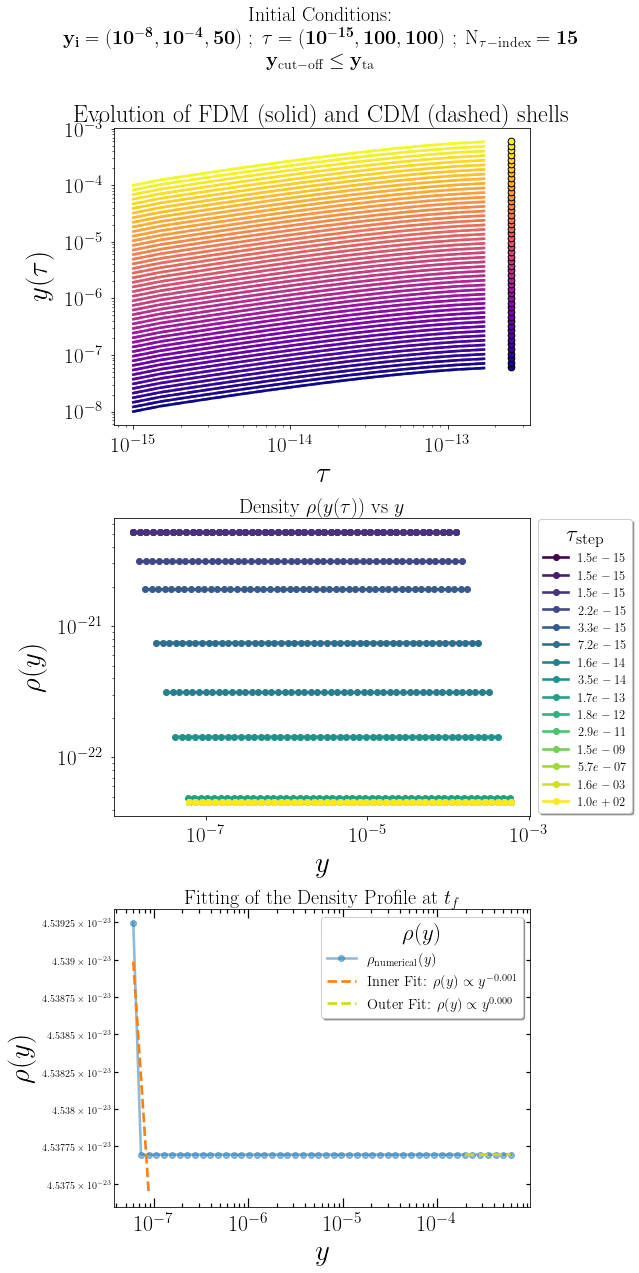

 Fitted slope (inner core):    \rho(y) \propto y^{-0.001}
 Fitted slope (outer tail):    \rho(y) \propto y^{0.000}


In [7]:
# for 50 FDM shells

t_i, t_f = 1e-15, 1e2
N = 50
r_min, r_max = 1e-8, 1e-4
ri_arr = np.geomspace(r_min, r_max, N)
initial_density = 1e-20


delta_M_arr = shells_mass(ri_arr, N, initial_density)
QP = True
gravity = True
Hubble = True


t_step = 100
t_arr = np.geomspace(t_i, t_f, t_step)
dt = np.gradient(t_arr)

r_sol = np.zeros((N, len(t_arr)))
v_sol = np.zeros((N, len(t_arr)))
rho_sol = np.zeros((N, len(t_arr)))
mask_active = np.ones(N, dtype=bool)
cutoff_index = np.full(N, len(t_arr))
t_ta_arr = np.full(N, np.nan)
r_ta_arr = np.full(N, np.nan)
turnaround_detected = np.zeros(N, dtype=bool)
r_sol[:, 0] = ri_arr
v_sol[:, 0] = ri_arr/(2 * t_arr[0])




freeze_fraction= 1
r_sol, v_sol, rho_sol, QP_arr, cutoff_index, r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask = shells_evolution(N, t_arr, dt, ri_arr, Hubble, gravity, QP, freeze_fraction)
time_indices = np.geomspace(1, t_step-1 , 15, dtype=int)




fig, axs = plt.subplots(3, 1, figsize=(9, 18), sharex=False)
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
colors_shell = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
colors1 = cm.viridis(np.linspace(0, 1, len(time_indices)))
colors2 = cm.plasma(np.linspace(0, 1, N))
colors3 = cm.magma(np.linspace(0, 1, len(time_indices)))



#------------------------------------------------------
ax = axs[0]


QP = False
gravity = True
Hubble = True
r_sol_no_qp, v_sol_no_qp, rho_sol_no_qp, QP_arr_no_qp, cutoff_index_no_qp,  r_ta_arr_no_qp, t_ta_arr_no_qp, rho_arr_no_qp, rta_mask_no_qp, tta_mask_no_qp = shells_evolution(N, t_arr, dt, ri_arr,  
Hubble, gravity, QP, freeze_fraction)


for j in range(N):
    cutoff = cutoff_index_no_qp[j]
    ax.loglog(t_arr[:cutoff], r_sol_no_qp[j, :cutoff], color=colors2[j], linestyle='--', alpha=0.7)
    if not np.isnan(t_ta_arr_no_qp[j]):
        ax.scatter(t_ta_arr_no_qp[j], r_ta_arr_no_qp[j], marker='o', s=30, color=colors2[j], edgecolor='k', alpha=0.3)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol_no_qp[j, cutoff - 1], marker='x', s=35, color=colors_shell[j], alpha=0.3)

# Plot FDM shells (with QP) with solid lines
for j in range(N):
    cutoff = cutoff_index[j]
    ax.loglog(t_arr[:cutoff], r_sol[j, :cutoff], color=colors2[j], linestyle='-', alpha=1.0, label=fr'${ri_arr[j]:.1e}$')
    if not np.isnan(t_ta_arr[j]):
        ax.scatter(t_ta_arr[j], r_ta_arr[j], marker='o', s=45, color=colors2[j], edgecolor='k', zorder=5)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol[j, cutoff - 1], marker='x', s=50, color=colors_shell[j], zorder=5)

# Labels, title and legend
ax.set_xlabel(r'$\tau$', fontsize=29, labelpad=6)
ax.set_ylabel(r'$y(\tau)$', fontsize=29, labelpad=11)
ax.set_title('Evolution of FDM (solid) and CDM (dashed) shells', fontsize=24)
ax.tick_params(axis='x', labelsize=21, pad=7.9)
ax.tick_params(axis='y', labelsize=21, pad=7.9)

#handles, labels = ax.get_legend_handles_labels()
#legend_shells = ax.legend(handles[:7], labels[:7], prop={'size': 12.5},
                        #  loc=(1.02, 0.13), shadow=True, title='$y_{i}$', title_fontsize=27,
                        #  facecolor='white', fontsize=25)

#legend_lines = [Line2D([0], [0], color='k', linestyle='-', lw=2),
               # Line2D([0], [0], color='k', linestyle='--', lw=2)]
#ax.legend(legend_lines, ['FDM', 'CDM'], prop={'size': 15.5}, loc=(1.02, 0.64),
         # shadow=True, title='Shell', title_fontsize=23,
         # facecolor='white', fontsize=20)
#ax.add_artist(legend_shells)









#----------------------------------------------------------
#Density vs time at different time steps


ax = axs[1]
for i, idx in enumerate(time_indices):
    r_at_time_index = r_sol[:, idx]
    rho_at_time_index = rho_sol[:, idx]
    ax.loglog(r_at_time_index, rho_at_time_index, marker='o', label=r'$ {0:.1e}$'.format(t_arr[idx]), color=colors1[i])


ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)  
#ax.text(5, 1e-24, '$y_i = (10^{-8}, 10^{-4}, 7)$', fontsize = 18)
#ax.text(5, 1e-27, '$N_\mathrm{time-indices} = 15$', fontsize = 18)
ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 11)
ax.legend( prop = {'size':12.5},loc = (1.02, 0.01),shadow = True, title = r'$\tau_\mathrm{step}$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 23)
ax.set_title(r'Density Profile at Different times steps', fontsize= 24)
ax.set_title(r' Density $\rho(y(\tau))$ vs $y$ ', fontsize=20)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 



#--------------------------------------------------------------------------------



###################################
# Fitting the density profile
ax = axs[2]


def f_fitting(x, m, b):
    return (m*x) + b


final_idx = -1
r_final = r_sol[:, final_idx]
rho_final = rho_sol[:, final_idx]
mask = (r_final > 0) & (rho_final > 0)
r_valid = r_final[mask]
rho_valid = rho_final[mask]


# Sort by radius
sorted_idx = np.argsort(r_valid)
r_valid = r_valid[sorted_idx]
rho_valid = rho_valid[sorted_idx]

# Define regions
inner_N = 3
outer_N = 7

# Inner region
r_inner = r_valid[:inner_N]
rho_inner = rho_valid[:inner_N]
log_r_inner = np.log10(r_inner)
log_rho_inner = np.log10(rho_inner)
popt_inner, _ = curve_fit(f_fitting, log_r_inner, log_rho_inner)
m_inner, b_inner = popt_inner
rho_fit_inner = 10**f_fitting(log_r_inner, *popt_inner)


# Outer region
r_outer = r_valid[-outer_N:]
rho_outer = rho_valid[-outer_N:]
log_r_outer = np.log10(r_outer)
log_rho_outer = np.log10(rho_outer)
popt_outer, _ = curve_fit(f_fitting, log_r_outer, log_rho_outer)
m_outer, b_outer = popt_outer
rho_fit_outer = 10**f_fitting(log_r_outer, *popt_outer)




ax.loglog(r_valid, rho_valid, 'o-', color='C0', alpha = 0.5)
ax.loglog(r_inner, rho_fit_inner, '--', color='C1')
#ax.loglog(r_middle, rho_fit_middle, '--', color='C3')
ax.loglog(r_outer, rho_fit_outer, '--', color='#d0db0b')


#plt.text(1e-14, 1e-45, '$y_i = (10^{-8}, 10^{-4}, 10)$', fontsize=18)
#plt.text(1e-14, 1e-49, '$(t_i, t_f, t_\\mathrm{steps}) = (10^{-15}, 10^{5}, 10000)$', fontsize=15)

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)

ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=22) 
ax.yaxis.set_tick_params(labelsize=22) 

ax.set_title('Fitting of the Density Profile at $t_f$', fontsize=20)
ax.legend([r'$\rho_\mathrm{numerical}(y)$', fr'Inner Fit: $\rho(y) \propto y^{{{m_inner:.3f}}}$',
           
           fr'Outer Fit: $\rho(y) \propto y^{{{m_outer:.3f}}}$'], 
           prop = {'size':14.5},loc = 'upper right', shadow = True, 
           title = r'$\rho(y)$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 31)




#---------------------------------------------------------------------



plt.suptitle(r'Initial Conditions:' + '\n' + 
    r'$\mathbf{y_i = (10^{-8}, 10^{-4}, 50)\; ;\;\tau = (10^{-15}, 100, 100)\; ;\;\mathrm{N_{\tau-index}} = 15}$'
              '\n' + r'$\mathbf{y_\mathrm{cut-off} \leq  y_\mathrm{ta}}$' , fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('rho&qp_N50_t100.pdf', bbox_inches='tight')
plt.show()



#--------------------------------------------------------------------

print(fr' Fitted slope (inner core):    \rho(y) \propto y^{{{m_inner:.3f}}}')
print(fr' Fitted slope (outer tail):    \rho(y) \propto y^{{{m_outer:.3f}}}')





np.savez('fdm_cdm_N50_t100_rta.npz',
         # FDM arrays
         r_sol_fdm=r_sol,
         v_sol_fdm=v_sol,
         rho_sol_fdm=rho_sol,
         QP_arr_fdm= QP_arr,
         cutoff_index_fdm=cutoff_index,
         r_ta_arr_fdm=r_ta_arr,
         t_ta_arr_fdm=t_ta_arr,
         rho_arr_fdm = rho_arr,
         rta_mask_fdm = rta_mask,
         tta_mask_fdm = tta_mask,
         
         
         # CDM arrays
         r_sol_cdm=r_sol_no_qp,
         v_sol_cdm=v_sol_no_qp,
         rho_sol_cdm=rho_sol_no_qp,
         QP_arr_cdm= QP_arr_no_qp,
         cutoff_index_cdm=cutoff_index_no_qp,
         r_ta_arr_cdm=r_ta_arr_no_qp,
         t_ta_arr_cdm=t_ta_arr_no_qp,
         rho_arr_cdm = rho_arr_no_qp,
         rta_mask_cdm = rta_mask_no_qp,
         tta_mask_cdm = tta_mask_no_qp)



No shells crossings is detected.


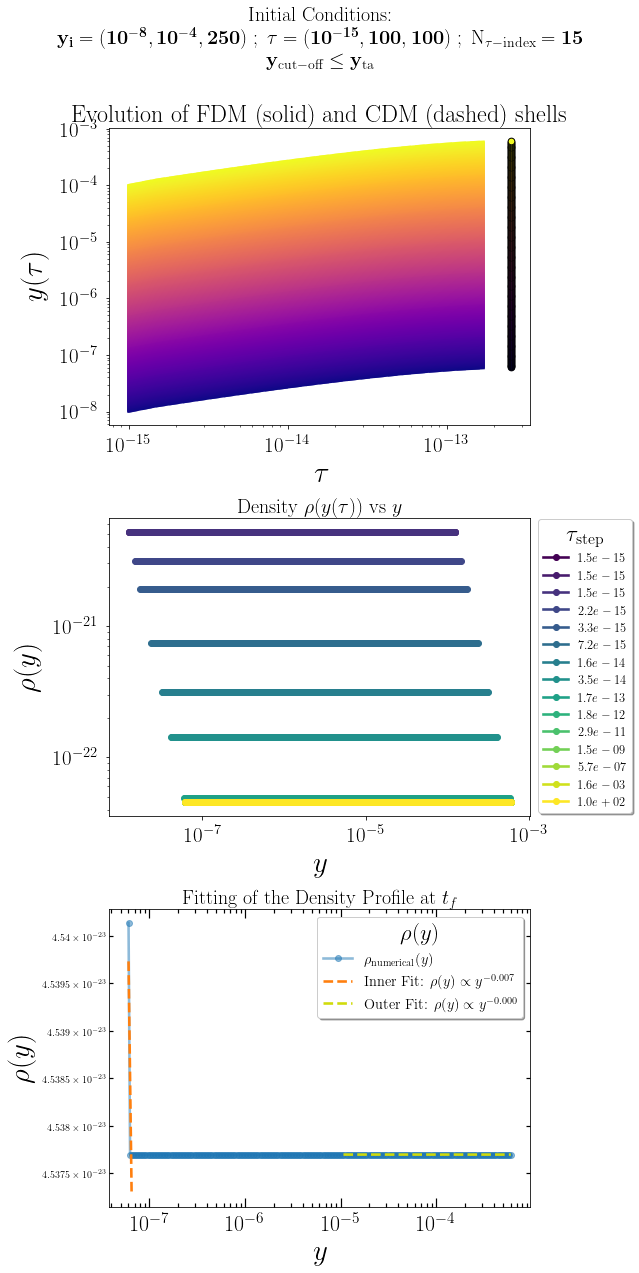

 Fitted slope (inner core):    \rho(y) \propto y^{-0.007}
 Fitted slope (outer tail):    \rho(y) \propto y^{-0.000}


In [14]:
# for 250 FDM shells

t_i, t_f = 1e-15, 1e2
N = 250
r_min, r_max = 1e-8, 1e-4
ri_arr = np.geomspace(r_min, r_max, N)
initial_density = 1e-20


delta_M_arr = shells_mass(ri_arr, N, initial_density)
QP = True
gravity = True
Hubble = True


t_step = 100
t_arr = np.geomspace(t_i, t_f, t_step)
dt = np.gradient(t_arr)

r_sol = np.zeros((N, len(t_arr)))
v_sol = np.zeros((N, len(t_arr)))
rho_sol = np.zeros((N, len(t_arr)))
mask_active = np.ones(N, dtype=bool)
cutoff_index = np.full(N, len(t_arr))
t_ta_arr = np.full(N, np.nan)
r_ta_arr = np.full(N, np.nan)
turnaround_detected = np.zeros(N, dtype=bool)
r_sol[:, 0] = ri_arr
v_sol[:, 0] = ri_arr/(2 * t_arr[0])




freeze_fraction= 1
r_sol, v_sol, rho_sol, QP_arr, cutoff_index, r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask = shells_evolution(N, t_arr, dt, ri_arr, Hubble, gravity, QP, freeze_fraction)
time_indices = np.geomspace(1, t_step-1 , 15, dtype=int)




fig, axs = plt.subplots(3, 1, figsize=(9, 18), sharex=False)
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
colors_shell = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
colors1 = cm.viridis(np.linspace(0, 1, len(time_indices)))
colors2 = cm.plasma(np.linspace(0, 1, N))
colors3 = cm.magma(np.linspace(0, 1, len(time_indices)))



#------------------------------------------------------
ax = axs[0]


QP = False
gravity = True
Hubble = True
r_sol_no_qp, v_sol_no_qp, rho_sol_no_qp, QP_arr_no_qp, cutoff_index_no_qp,  r_ta_arr_no_qp, t_ta_arr_no_qp, rho_arr_no_qp, rta_mask_no_qp, tta_mask_no_qp = shells_evolution(N, t_arr, dt, ri_arr,  
Hubble, gravity, QP, freeze_fraction)


for j in range(N):
    cutoff = cutoff_index_no_qp[j]
    ax.loglog(t_arr[:cutoff], r_sol_no_qp[j, :cutoff], color=colors2[j], linestyle='--', alpha=0.7)
    if not np.isnan(t_ta_arr_no_qp[j]):
        ax.scatter(t_ta_arr_no_qp[j], r_ta_arr_no_qp[j], marker='o', s=30, color=colors2[j], edgecolor='k', alpha=0.3)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol_no_qp[j, cutoff - 1], marker='x', s=35, color=colors_shell[j], alpha=0.3)

# Plot FDM shells (with QP) with solid lines
for j in range(N):
    cutoff = cutoff_index[j]
    ax.loglog(t_arr[:cutoff], r_sol[j, :cutoff], color=colors2[j], linestyle='-', alpha=1.0, label=fr'${ri_arr[j]:.1e}$')
    if not np.isnan(t_ta_arr[j]):
        ax.scatter(t_ta_arr[j], r_ta_arr[j], marker='o', s=45, color=colors2[j], edgecolor='k', zorder=5)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol[j, cutoff - 1], marker='x', s=50, color=colors_shell[j], zorder=5)

# Labels, title and legend
ax.set_xlabel(r'$\tau$', fontsize=29, labelpad=6)
ax.set_ylabel(r'$y(\tau)$', fontsize=29, labelpad=11)
ax.set_title('Evolution of FDM (solid) and CDM (dashed) shells', fontsize=24)
ax.tick_params(axis='x', labelsize=21, pad=7.9)
ax.tick_params(axis='y', labelsize=21, pad=7.9)

#handles, labels = ax.get_legend_handles_labels()
#legend_shells = ax.legend(handles[:7], labels[:7], prop={'size': 12.5},
                        #  loc=(1.02, 0.13), shadow=True, title='$y_{i}$', title_fontsize=27,
                        #  facecolor='white', fontsize=25)

#legend_lines = [Line2D([0], [0], color='k', linestyle='-', lw=2),
               # Line2D([0], [0], color='k', linestyle='--', lw=2)]
#ax.legend(legend_lines, ['FDM', 'CDM'], prop={'size': 15.5}, loc=(1.02, 0.64),
         # shadow=True, title='Shell', title_fontsize=23,
         # facecolor='white', fontsize=20)
#ax.add_artist(legend_shells)









#----------------------------------------------------------
#Density vs time at different time steps


ax = axs[1]
for i, idx in enumerate(time_indices):
    r_at_time_index = r_sol[:, idx]
    rho_at_time_index = rho_sol[:, idx]
    ax.loglog(r_at_time_index, rho_at_time_index, marker='o', label=r'$ {0:.1e}$'.format(t_arr[idx]), color=colors1[i])


ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)  
#ax.text(5, 1e-24, '$y_i = (10^{-8}, 10^{-4}, 7)$', fontsize = 18)
#ax.text(5, 1e-27, '$N_\mathrm{time-indices} = 15$', fontsize = 18)
ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 11)
ax.legend( prop = {'size':12.5},loc = (1.02, 0.01),shadow = True, title = r'$\tau_\mathrm{step}$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 23)
ax.set_title(r'Density Profile at Different times steps', fontsize= 24)
ax.set_title(r' Density $\rho(y(\tau))$ vs $y$ ', fontsize=20)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 



#--------------------------------------------------------------------------------



###################################
# Fitting the density profile
ax = axs[2]


def f_fitting(x, m, b):
    return (m*x) + b


final_idx = -1
r_final = r_sol[:, final_idx]
rho_final = rho_sol[:, final_idx]
mask = (r_final > 0) & (rho_final > 0)
r_valid = r_final[mask]
rho_valid = rho_final[mask]


# Sort by radius
sorted_idx = np.argsort(r_valid)
r_valid = r_valid[sorted_idx]
rho_valid = rho_valid[sorted_idx]

# Define regions
inner_N = 3
outer_N = 110

# Inner region
r_inner = r_valid[:inner_N]
rho_inner = rho_valid[:inner_N]
log_r_inner = np.log10(r_inner)
log_rho_inner = np.log10(rho_inner)
popt_inner, _ = curve_fit(f_fitting, log_r_inner, log_rho_inner)
m_inner, b_inner = popt_inner
rho_fit_inner = 10**f_fitting(log_r_inner, *popt_inner)


# Outer region
r_outer = r_valid[-outer_N:]
rho_outer = rho_valid[-outer_N:]
log_r_outer = np.log10(r_outer)
log_rho_outer = np.log10(rho_outer)
popt_outer, _ = curve_fit(f_fitting, log_r_outer, log_rho_outer)
m_outer, b_outer = popt_outer
rho_fit_outer = 10**f_fitting(log_r_outer, *popt_outer)




ax.loglog(r_valid, rho_valid, 'o-', color='C0', alpha = 0.5)
ax.loglog(r_inner, rho_fit_inner, '--', color='C1')
#ax.loglog(r_middle, rho_fit_middle, '--', color='C3')
ax.loglog(r_outer, rho_fit_outer, '--', color='#d0db0b')


#plt.text(1e-14, 1e-45, '$y_i = (10^{-8}, 10^{-4}, 10)$', fontsize=18)
#plt.text(1e-14, 1e-49, '$(t_i, t_f, t_\\mathrm{steps}) = (10^{-15}, 10^{5}, 10000)$', fontsize=15)

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)

ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=22) 
ax.yaxis.set_tick_params(labelsize=22) 

ax.set_title('Fitting of the Density Profile at $t_f$', fontsize=20)
ax.legend([r'$\rho_\mathrm{numerical}(y)$', fr'Inner Fit: $\rho(y) \propto y^{{{m_inner:.3f}}}$',
           
           fr'Outer Fit: $\rho(y) \propto y^{{{m_outer:.3f}}}$'], 
           prop = {'size':14.5},loc = 'upper right', shadow = True, 
           title = r'$\rho(y)$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 31)




#---------------------------------------------------------------------



plt.suptitle(r'Initial Conditions:' + '\n' + 
    r'$\mathbf{y_i = (10^{-8}, 10^{-4}, 250)\; ;\;\tau = (10^{-15}, 100, 100)\; ;\;\mathrm{N_{\tau-index}} = 15}$'
              '\n' + r'$\mathbf{y_\mathrm{cut-off} \leq  y_\mathrm{ta}}$' , fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('rho&qp_N250_t100.pdf', bbox_inches='tight')
plt.show()



#--------------------------------------------------------------------

print(fr' Fitted slope (inner core):    \rho(y) \propto y^{{{m_inner:.3f}}}')
print(fr' Fitted slope (outer tail):    \rho(y) \propto y^{{{m_outer:.3f}}}')





np.savez('fdm_cdm_N250_t100_rta.npz',
         # FDM arrays
         r_sol_fdm=r_sol,
         v_sol_fdm=v_sol,
         rho_sol_fdm=rho_sol,
         QP_arr_fdm= QP_arr,
         cutoff_index_fdm=cutoff_index,
         r_ta_arr_fdm=r_ta_arr,
         t_ta_arr_fdm=t_ta_arr,
         rho_arr_fdm = rho_arr,
         rta_mask_fdm = rta_mask,
         tta_mask_fdm = tta_mask,
         
         
         # CDM arrays
         r_sol_cdm=r_sol_no_qp,
         v_sol_cdm=v_sol_no_qp,
         rho_sol_cdm=rho_sol_no_qp,
         QP_arr_cdm= QP_arr_no_qp,
         cutoff_index_cdm=cutoff_index_no_qp,
         r_ta_arr_cdm=r_ta_arr_no_qp,
         t_ta_arr_cdm=t_ta_arr_no_qp,
         rho_arr_cdm = rho_arr_no_qp,
         rta_mask_cdm = rta_mask_no_qp,
         tta_mask_cdm = tta_mask_no_qp)



No shells crossings is detected.


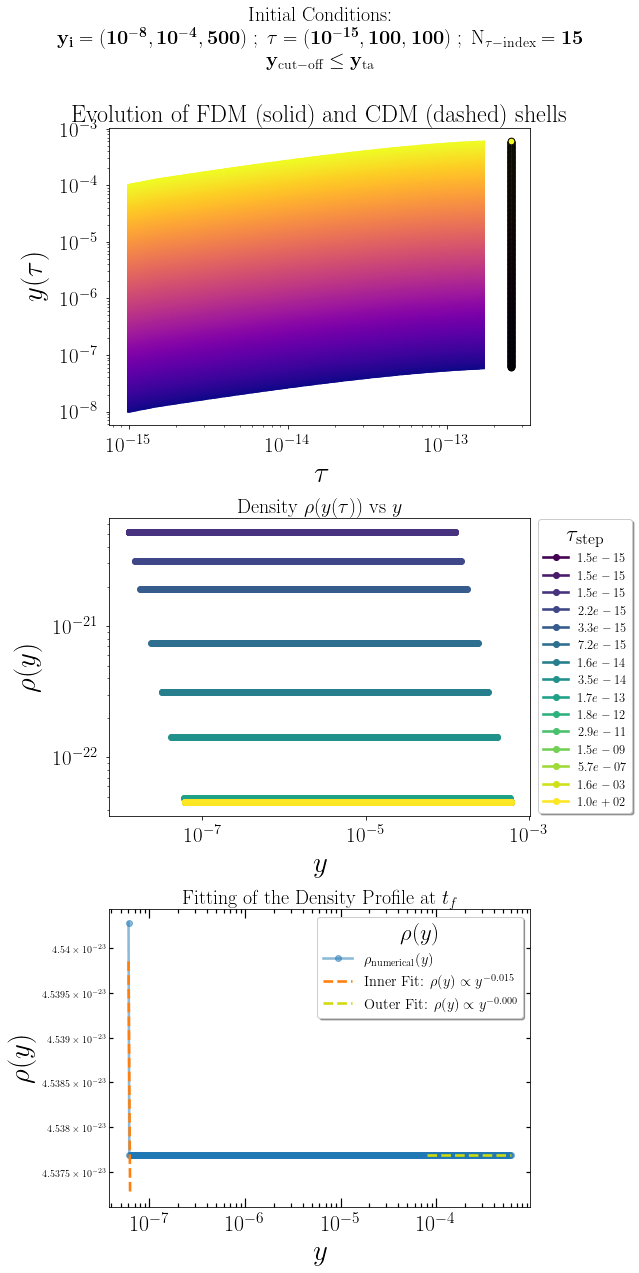

 Fitted slope (inner core):    \rho(y) \propto y^{-0.015}
 Fitted slope (outer tail):    \rho(y) \propto y^{-0.000}


In [23]:
# for 500 FDM shells

t_i, t_f = 1e-15, 1e2
N = 500
r_min, r_max = 1e-8, 1e-4
ri_arr = np.geomspace(r_min, r_max, N)
initial_density = 1e-20


delta_M_arr = shells_mass(ri_arr, N, initial_density)
QP = True
gravity = True
Hubble = True


t_step = 100
t_arr = np.geomspace(t_i, t_f, t_step)
dt = np.gradient(t_arr)

r_sol = np.zeros((N, len(t_arr)))
v_sol = np.zeros((N, len(t_arr)))
rho_sol = np.zeros((N, len(t_arr)))
mask_active = np.ones(N, dtype=bool)
cutoff_index = np.full(N, len(t_arr))
t_ta_arr = np.full(N, np.nan)
r_ta_arr = np.full(N, np.nan)
turnaround_detected = np.zeros(N, dtype=bool)
r_sol[:, 0] = ri_arr
v_sol[:, 0] = ri_arr/(2 * t_arr[0])




freeze_fraction= 1
r_sol, v_sol, rho_sol, QP_arr, cutoff_index, r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask = shells_evolution(N, t_arr, dt, ri_arr, Hubble, gravity, QP, freeze_fraction)
time_indices = np.geomspace(1, t_step-1 , 15, dtype=int)




fig, axs = plt.subplots(3, 1, figsize=(9, 18), sharex=False)
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
colors_shell = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
colors1 = cm.viridis(np.linspace(0, 1, len(time_indices)))
colors2 = cm.plasma(np.linspace(0, 1, N))
colors3 = cm.magma(np.linspace(0, 1, len(time_indices)))



#------------------------------------------------------
ax = axs[0]


QP = False
gravity = True
Hubble = True
r_sol_no_qp, v_sol_no_qp, rho_sol_no_qp, QP_arr_no_qp, cutoff_index_no_qp,  r_ta_arr_no_qp, t_ta_arr_no_qp, rho_arr_no_qp, rta_mask_no_qp, tta_mask_no_qp = shells_evolution(N, t_arr, dt, ri_arr,  
Hubble, gravity, QP, freeze_fraction)


for j in range(N):
    cutoff = cutoff_index_no_qp[j]
    ax.loglog(t_arr[:cutoff], r_sol_no_qp[j, :cutoff], color=colors2[j], linestyle='--', alpha=0.7)
    if not np.isnan(t_ta_arr_no_qp[j]):
        ax.scatter(t_ta_arr_no_qp[j], r_ta_arr_no_qp[j], marker='o', s=30, color=colors2[j], edgecolor='k', alpha=0.3)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol_no_qp[j, cutoff - 1], marker='x', s=35, color=colors_shell[j], alpha=0.3)

# Plot FDM shells (with QP) with solid lines
for j in range(N):
    cutoff = cutoff_index[j]
    ax.loglog(t_arr[:cutoff], r_sol[j, :cutoff], color=colors2[j], linestyle='-', alpha=1.0, label=fr'${ri_arr[j]:.1e}$')
    if not np.isnan(t_ta_arr[j]):
        ax.scatter(t_ta_arr[j], r_ta_arr[j], marker='o', s=45, color=colors2[j], edgecolor='k', zorder=5)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol[j, cutoff - 1], marker='x', s=50, color=colors_shell[j], zorder=5)

# Labels, title and legend
ax.set_xlabel(r'$\tau$', fontsize=29, labelpad=6)
ax.set_ylabel(r'$y(\tau)$', fontsize=29, labelpad=11)
ax.set_title('Evolution of FDM (solid) and CDM (dashed) shells', fontsize=24)
ax.tick_params(axis='x', labelsize=21, pad=7.9)
ax.tick_params(axis='y', labelsize=21, pad=7.9)

#handles, labels = ax.get_legend_handles_labels()
#legend_shells = ax.legend(handles[:7], labels[:7], prop={'size': 12.5},
                        #  loc=(1.02, 0.13), shadow=True, title='$y_{i}$', title_fontsize=27,
                        #  facecolor='white', fontsize=25)

#legend_lines = [Line2D([0], [0], color='k', linestyle='-', lw=2),
               # Line2D([0], [0], color='k', linestyle='--', lw=2)]
#ax.legend(legend_lines, ['FDM', 'CDM'], prop={'size': 15.5}, loc=(1.02, 0.64),
         # shadow=True, title='Shell', title_fontsize=23,
         # facecolor='white', fontsize=20)
#ax.add_artist(legend_shells)









#----------------------------------------------------------
#Density vs time at different time steps


ax = axs[1]
for i, idx in enumerate(time_indices):
    r_at_time_index = r_sol[:, idx]
    rho_at_time_index = rho_sol[:, idx]
    ax.loglog(r_at_time_index, rho_at_time_index, marker='o', label=r'$ {0:.1e}$'.format(t_arr[idx]), color=colors1[i])


ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)  
#ax.text(5, 1e-24, '$y_i = (10^{-8}, 10^{-4}, 7)$', fontsize = 18)
#ax.text(5, 1e-27, '$N_\mathrm{time-indices} = 15$', fontsize = 18)
ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 11)
ax.legend( prop = {'size':12.5},loc = (1.02, 0.01),shadow = True, title = r'$\tau_\mathrm{step}$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 23)
ax.set_title(r'Density Profile at Different times steps', fontsize= 24)
ax.set_title(r' Density $\rho(y(\tau))$ vs $y$ ', fontsize=20)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 



#--------------------------------------------------------------------------------



###################################
# Fitting the density profile
ax = axs[2]


def f_fitting(x, m, b):
    return (m*x) + b


final_idx = -1
r_final = r_sol[:, final_idx]
rho_final = rho_sol[:, final_idx]
mask = (r_final > 0) & (rho_final > 0)
r_valid = r_final[mask]
rho_valid = rho_final[mask]


# Sort by radius
sorted_idx = np.argsort(r_valid)
r_valid = r_valid[sorted_idx]
rho_valid = rho_valid[sorted_idx]

# Define regions
inner_N = 3
outer_N = 110

# Inner region
r_inner = r_valid[:inner_N]
rho_inner = rho_valid[:inner_N]
log_r_inner = np.log10(r_inner)
log_rho_inner = np.log10(rho_inner)
popt_inner, _ = curve_fit(f_fitting, log_r_inner, log_rho_inner)
m_inner, b_inner = popt_inner
rho_fit_inner = 10**f_fitting(log_r_inner, *popt_inner)


# Outer region
r_outer = r_valid[-outer_N:]
rho_outer = rho_valid[-outer_N:]
log_r_outer = np.log10(r_outer)
log_rho_outer = np.log10(rho_outer)
popt_outer, _ = curve_fit(f_fitting, log_r_outer, log_rho_outer)
m_outer, b_outer = popt_outer
rho_fit_outer = 10**f_fitting(log_r_outer, *popt_outer)




ax.loglog(r_valid, rho_valid, 'o-', color='C0', alpha = 0.5)
ax.loglog(r_inner, rho_fit_inner, '--', color='C1')
#ax.loglog(r_middle, rho_fit_middle, '--', color='C3')
ax.loglog(r_outer, rho_fit_outer, '--', color='#d0db0b')


#plt.text(1e-14, 1e-45, '$y_i = (10^{-8}, 10^{-4}, 10)$', fontsize=18)
#plt.text(1e-14, 1e-49, '$(t_i, t_f, t_\\mathrm{steps}) = (10^{-15}, 10^{5}, 10000)$', fontsize=15)

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)

ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=22) 
ax.yaxis.set_tick_params(labelsize=22) 

ax.set_title('Fitting of the Density Profile at $t_f$', fontsize=20)
ax.legend([r'$\rho_\mathrm{numerical}(y)$', fr'Inner Fit: $\rho(y) \propto y^{{{m_inner:.3f}}}$',
           
           fr'Outer Fit: $\rho(y) \propto y^{{{m_outer:.3f}}}$'], 
           prop = {'size':14.5},loc = 'upper right', shadow = True, 
           title = r'$\rho(y)$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 31)




#---------------------------------------------------------------------



plt.suptitle(r'Initial Conditions:' + '\n' + 
    r'$\mathbf{y_i = (10^{-8}, 10^{-4}, 500)\; ;\;\tau = (10^{-15}, 100, 100)\; ;\;\mathrm{N_{\tau-index}} = 15}$'
              '\n' + r'$\mathbf{y_\mathrm{cut-off} \leq  y_\mathrm{ta}}$' , fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('rho&qp_N500_t100.pdf', bbox_inches='tight')
plt.show()



#--------------------------------------------------------------------

print(fr' Fitted slope (inner core):    \rho(y) \propto y^{{{m_inner:.3f}}}')
print(fr' Fitted slope (outer tail):    \rho(y) \propto y^{{{m_outer:.3f}}}')





np.savez('fdm_cdm_N500_t100_rta.npz',
         # FDM arrays
         r_sol_fdm=r_sol,
         v_sol_fdm=v_sol,
         rho_sol_fdm=rho_sol,
         QP_arr_fdm= QP_arr,
         cutoff_index_fdm=cutoff_index,
         r_ta_arr_fdm=r_ta_arr,
         t_ta_arr_fdm=t_ta_arr,
         rho_arr_fdm = rho_arr,
         rta_mask_fdm = rta_mask,
         tta_mask_fdm = tta_mask,
         
         
         # CDM arrays
         r_sol_cdm=r_sol_no_qp,
         v_sol_cdm=v_sol_no_qp,
         rho_sol_cdm=rho_sol_no_qp,
         QP_arr_cdm= QP_arr_no_qp,
         cutoff_index_cdm=cutoff_index_no_qp,
         r_ta_arr_cdm=r_ta_arr_no_qp,
         t_ta_arr_cdm=t_ta_arr_no_qp,
         rho_arr_cdm = rho_arr_no_qp,
         rta_mask_cdm = rta_mask_no_qp,
         tta_mask_cdm = tta_mask_no_qp)



No shells crossings is detected.


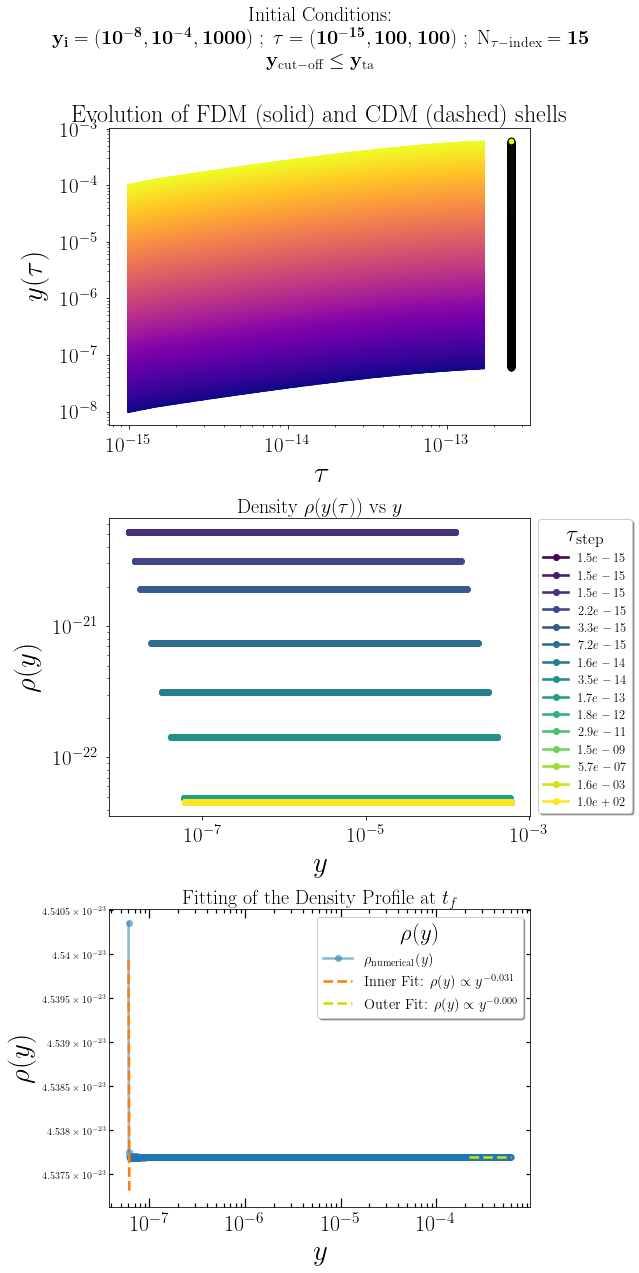

 Fitted slope (inner core):    \rho(y) \propto y^{-0.031}
 Fitted slope (outer tail):    \rho(y) \propto y^{-0.000}


In [31]:
# for 1000 FDM shells

t_i, t_f = 1e-15, 1e2
N = 1000
r_min, r_max = 1e-8, 1e-4
ri_arr = np.geomspace(r_min, r_max, N)
initial_density = 1e-20


delta_M_arr = shells_mass(ri_arr, N, initial_density)
QP = True
gravity = True
Hubble = True


t_step = 100
t_arr = np.geomspace(t_i, t_f, t_step)
dt = np.gradient(t_arr)

r_sol = np.zeros((N, len(t_arr)))
v_sol = np.zeros((N, len(t_arr)))
rho_sol = np.zeros((N, len(t_arr)))
mask_active = np.ones(N, dtype=bool)
cutoff_index = np.full(N, len(t_arr))
t_ta_arr = np.full(N, np.nan)
r_ta_arr = np.full(N, np.nan)
turnaround_detected = np.zeros(N, dtype=bool)
r_sol[:, 0] = ri_arr
v_sol[:, 0] = ri_arr/(2 * t_arr[0])




freeze_fraction= 1
r_sol, v_sol, rho_sol, QP_arr, cutoff_index, r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask = shells_evolution(N, t_arr, dt, ri_arr, Hubble, gravity, QP, freeze_fraction)
time_indices = np.geomspace(1, t_step-1 , 15, dtype=int)




fig, axs = plt.subplots(3, 1, figsize=(9, 18), sharex=False)
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
colors_shell = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
colors1 = cm.viridis(np.linspace(0, 1, len(time_indices)))
colors2 = cm.plasma(np.linspace(0, 1, N))
colors3 = cm.magma(np.linspace(0, 1, len(time_indices)))



#------------------------------------------------------
ax = axs[0]


QP = False
gravity = True
Hubble = True
r_sol_no_qp, v_sol_no_qp, rho_sol_no_qp, QP_arr_no_qp, cutoff_index_no_qp,  r_ta_arr_no_qp, t_ta_arr_no_qp, rho_arr_no_qp, rta_mask_no_qp, tta_mask_no_qp = shells_evolution(N, t_arr, dt, ri_arr,  
Hubble, gravity, QP, freeze_fraction)


for j in range(N):
    cutoff = cutoff_index_no_qp[j]
    ax.loglog(t_arr[:cutoff], r_sol_no_qp[j, :cutoff], color=colors2[j], linestyle='--', alpha=0.7)
    if not np.isnan(t_ta_arr_no_qp[j]):
        ax.scatter(t_ta_arr_no_qp[j], r_ta_arr_no_qp[j], marker='o', s=30, color=colors2[j], edgecolor='k', alpha=0.3)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol_no_qp[j, cutoff - 1], marker='x', s=35, color=colors_shell[j], alpha=0.3)

# Plot FDM shells (with QP) with solid lines
for j in range(N):
    cutoff = cutoff_index[j]
    ax.loglog(t_arr[:cutoff], r_sol[j, :cutoff], color=colors2[j], linestyle='-', alpha=1.0, label=fr'${ri_arr[j]:.1e}$')
    if not np.isnan(t_ta_arr[j]):
        ax.scatter(t_ta_arr[j], r_ta_arr[j], marker='o', s=45, color=colors2[j], edgecolor='k', zorder=5)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol[j, cutoff - 1], marker='x', s=50, color=colors_shell[j], zorder=5)

# Labels, title and legend
ax.set_xlabel(r'$\tau$', fontsize=29, labelpad=6)
ax.set_ylabel(r'$y(\tau)$', fontsize=29, labelpad=11)
ax.set_title('Evolution of FDM (solid) and CDM (dashed) shells', fontsize=24)
ax.tick_params(axis='x', labelsize=21, pad=7.9)
ax.tick_params(axis='y', labelsize=21, pad=7.9)

#handles, labels = ax.get_legend_handles_labels()
#legend_shells = ax.legend(handles[:7], labels[:7], prop={'size': 12.5},
                        #  loc=(1.02, 0.13), shadow=True, title='$y_{i}$', title_fontsize=27,
                        #  facecolor='white', fontsize=25)

#legend_lines = [Line2D([0], [0], color='k', linestyle='-', lw=2),
               # Line2D([0], [0], color='k', linestyle='--', lw=2)]
#ax.legend(legend_lines, ['FDM', 'CDM'], prop={'size': 15.5}, loc=(1.02, 0.64),
         # shadow=True, title='Shell', title_fontsize=23,
         # facecolor='white', fontsize=20)
#ax.add_artist(legend_shells)









#----------------------------------------------------------
#Density vs time at different time steps


ax = axs[1]
for i, idx in enumerate(time_indices):
    r_at_time_index = r_sol[:, idx]
    rho_at_time_index = rho_sol[:, idx]
    ax.loglog(r_at_time_index, rho_at_time_index, marker='o', label=r'$ {0:.1e}$'.format(t_arr[idx]), color=colors1[i])


ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)  
#ax.text(5, 1e-24, '$y_i = (10^{-8}, 10^{-4}, 7)$', fontsize = 18)
#ax.text(5, 1e-27, '$N_\mathrm{time-indices} = 15$', fontsize = 18)
ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 11)
ax.legend( prop = {'size':12.5},loc = (1.02, 0.01),shadow = True, title = r'$\tau_\mathrm{step}$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 23)
ax.set_title(r'Density Profile at Different times steps', fontsize= 24)
ax.set_title(r' Density $\rho(y(\tau))$ vs $y$ ', fontsize=20)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 



#--------------------------------------------------------------------------------



###################################
# Fitting the density profile
ax = axs[2]


def f_fitting(x, m, b):
    return (m*x) + b


final_idx = -1
r_final = r_sol[:, final_idx]
rho_final = rho_sol[:, final_idx]
mask = (r_final > 0) & (rho_final > 0)
r_valid = r_final[mask]
rho_valid = rho_final[mask]


# Sort by radius
sorted_idx = np.argsort(r_valid)
r_valid = r_valid[sorted_idx]
rho_valid = rho_valid[sorted_idx]

# Define regions
inner_N = 3
outer_N = 110

# Inner region
r_inner = r_valid[:inner_N]
rho_inner = rho_valid[:inner_N]
log_r_inner = np.log10(r_inner)
log_rho_inner = np.log10(rho_inner)
popt_inner, _ = curve_fit(f_fitting, log_r_inner, log_rho_inner)
m_inner, b_inner = popt_inner
rho_fit_inner = 10**f_fitting(log_r_inner, *popt_inner)


# Outer region
r_outer = r_valid[-outer_N:]
rho_outer = rho_valid[-outer_N:]
log_r_outer = np.log10(r_outer)
log_rho_outer = np.log10(rho_outer)
popt_outer, _ = curve_fit(f_fitting, log_r_outer, log_rho_outer)
m_outer, b_outer = popt_outer
rho_fit_outer = 10**f_fitting(log_r_outer, *popt_outer)




ax.loglog(r_valid, rho_valid, 'o-', color='C0', alpha = 0.5)
ax.loglog(r_inner, rho_fit_inner, '--', color='C1')
#ax.loglog(r_middle, rho_fit_middle, '--', color='C3')
ax.loglog(r_outer, rho_fit_outer, '--', color='#d0db0b')


#plt.text(1e-14, 1e-45, '$y_i = (10^{-8}, 10^{-4}, 10)$', fontsize=18)
#plt.text(1e-14, 1e-49, '$(t_i, t_f, t_\\mathrm{steps}) = (10^{-15}, 10^{5}, 10000)$', fontsize=15)

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)

ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=22) 
ax.yaxis.set_tick_params(labelsize=22) 

ax.set_title('Fitting of the Density Profile at $t_f$', fontsize=20)
ax.legend([r'$\rho_\mathrm{numerical}(y)$', fr'Inner Fit: $\rho(y) \propto y^{{{m_inner:.3f}}}$',
           
           fr'Outer Fit: $\rho(y) \propto y^{{{m_outer:.3f}}}$'], 
           prop = {'size':14.5},loc = 'upper right', shadow = True, 
           title = r'$\rho(y)$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 31)




#---------------------------------------------------------------------



plt.suptitle(r'Initial Conditions:' + '\n' + 
    r'$\mathbf{y_i = (10^{-8}, 10^{-4}, 1000)\; ;\;\tau = (10^{-15}, 100, 100)\; ;\;\mathrm{N_{\tau-index}} = 15}$'
              '\n' + r'$\mathbf{y_\mathrm{cut-off} \leq  y_\mathrm{ta}}$' , fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('rho&qp_N1000_t100.pdf', bbox_inches='tight')
plt.show()



#--------------------------------------------------------------------

print(fr' Fitted slope (inner core):    \rho(y) \propto y^{{{m_inner:.3f}}}')
print(fr' Fitted slope (outer tail):    \rho(y) \propto y^{{{m_outer:.3f}}}')





np.savez('fdm_cdm_N1000_t100_rta.npz',
         # FDM arrays
         r_sol_fdm=r_sol,
         v_sol_fdm=v_sol,
         rho_sol_fdm=rho_sol,
         QP_arr_fdm= QP_arr,
         cutoff_index_fdm=cutoff_index,
         r_ta_arr_fdm=r_ta_arr,
         t_ta_arr_fdm=t_ta_arr,
         rho_arr_fdm = rho_arr,
         rta_mask_fdm = rta_mask,
         tta_mask_fdm = tta_mask,
         
         
         # CDM arrays
         r_sol_cdm=r_sol_no_qp,
         v_sol_cdm=v_sol_no_qp,
         rho_sol_cdm=rho_sol_no_qp,
         QP_arr_cdm= QP_arr_no_qp,
         cutoff_index_cdm=cutoff_index_no_qp,
         r_ta_arr_cdm=r_ta_arr_no_qp,
         t_ta_arr_cdm=t_ta_arr_no_qp,
         rho_arr_cdm = rho_arr_no_qp,
         rta_mask_cdm = rta_mask_no_qp,
         tta_mask_cdm = tta_mask_no_qp)



No shells crossings is detected.


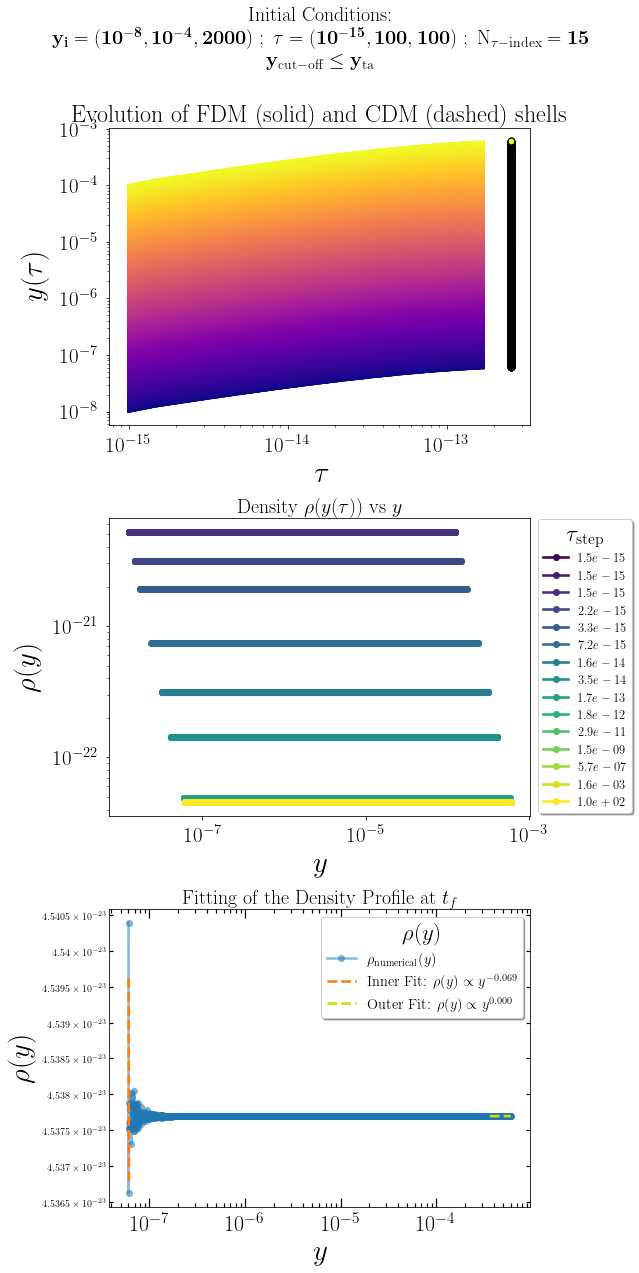

 Fitted slope (inner core):    \rho(y) \propto y^{-0.069}
 Fitted slope (outer tail):    \rho(y) \propto y^{0.000}


In [37]:
# for 2000 FDM shells

t_i, t_f = 1e-15, 1e2
N = 2000
r_min, r_max = 1e-8, 1e-4
ri_arr = np.geomspace(r_min, r_max, N)
initial_density = 1e-20


delta_M_arr = shells_mass(ri_arr, N, initial_density)
QP = True
gravity = True
Hubble = True


t_step = 100
t_arr = np.geomspace(t_i, t_f, t_step)
dt = np.gradient(t_arr)

r_sol = np.zeros((N, len(t_arr)))
v_sol = np.zeros((N, len(t_arr)))
rho_sol = np.zeros((N, len(t_arr)))
mask_active = np.ones(N, dtype=bool)
cutoff_index = np.full(N, len(t_arr))
t_ta_arr = np.full(N, np.nan)
r_ta_arr = np.full(N, np.nan)
turnaround_detected = np.zeros(N, dtype=bool)
r_sol[:, 0] = ri_arr
v_sol[:, 0] = ri_arr/(2 * t_arr[0])




freeze_fraction= 1
r_sol, v_sol, rho_sol, QP_arr, cutoff_index, r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask = shells_evolution(N, t_arr, dt, ri_arr, Hubble, gravity, QP, freeze_fraction)
time_indices = np.geomspace(1, t_step-1 , 15, dtype=int)




fig, axs = plt.subplots(3, 1, figsize=(9, 18), sharex=False)
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
colors_shell = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
colors1 = cm.viridis(np.linspace(0, 1, len(time_indices)))
colors2 = cm.plasma(np.linspace(0, 1, N))
colors3 = cm.magma(np.linspace(0, 1, len(time_indices)))



#------------------------------------------------------
ax = axs[0]


QP = False
gravity = True
Hubble = True
r_sol_no_qp, v_sol_no_qp, rho_sol_no_qp, QP_arr_no_qp, cutoff_index_no_qp,  r_ta_arr_no_qp, t_ta_arr_no_qp, rho_arr_no_qp, rta_mask_no_qp, tta_mask_no_qp = shells_evolution(N, t_arr, dt, ri_arr,  
Hubble, gravity, QP, freeze_fraction)


for j in range(N):
    cutoff = cutoff_index_no_qp[j]
    ax.loglog(t_arr[:cutoff], r_sol_no_qp[j, :cutoff], color=colors2[j], linestyle='--', alpha=0.7)
    if not np.isnan(t_ta_arr_no_qp[j]):
        ax.scatter(t_ta_arr_no_qp[j], r_ta_arr_no_qp[j], marker='o', s=30, color=colors2[j], edgecolor='k', alpha=0.3)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol_no_qp[j, cutoff - 1], marker='x', s=35, color=colors_shell[j], alpha=0.3)

# Plot FDM shells (with QP) with solid lines
for j in range(N):
    cutoff = cutoff_index[j]
    ax.loglog(t_arr[:cutoff], r_sol[j, :cutoff], color=colors2[j], linestyle='-', alpha=1.0, label=fr'${ri_arr[j]:.1e}$')
    if not np.isnan(t_ta_arr[j]):
        ax.scatter(t_ta_arr[j], r_ta_arr[j], marker='o', s=45, color=colors2[j], edgecolor='k', zorder=5)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol[j, cutoff - 1], marker='x', s=50, color=colors_shell[j], zorder=5)

# Labels, title and legend
ax.set_xlabel(r'$\tau$', fontsize=29, labelpad=6)
ax.set_ylabel(r'$y(\tau)$', fontsize=29, labelpad=11)
ax.set_title('Evolution of FDM (solid) and CDM (dashed) shells', fontsize=24)
ax.tick_params(axis='x', labelsize=21, pad=7.9)
ax.tick_params(axis='y', labelsize=21, pad=7.9)

#handles, labels = ax.get_legend_handles_labels()
#legend_shells = ax.legend(handles[:7], labels[:7], prop={'size': 12.5},
                        #  loc=(1.02, 0.13), shadow=True, title='$y_{i}$', title_fontsize=27,
                        #  facecolor='white', fontsize=25)

#legend_lines = [Line2D([0], [0], color='k', linestyle='-', lw=2),
               # Line2D([0], [0], color='k', linestyle='--', lw=2)]
#ax.legend(legend_lines, ['FDM', 'CDM'], prop={'size': 15.5}, loc=(1.02, 0.64),
         # shadow=True, title='Shell', title_fontsize=23,
         # facecolor='white', fontsize=20)
#ax.add_artist(legend_shells)









#----------------------------------------------------------
#Density vs time at different time steps


ax = axs[1]
for i, idx in enumerate(time_indices):
    r_at_time_index = r_sol[:, idx]
    rho_at_time_index = rho_sol[:, idx]
    ax.loglog(r_at_time_index, rho_at_time_index, marker='o', label=r'$ {0:.1e}$'.format(t_arr[idx]), color=colors1[i])


ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)  
#ax.text(5, 1e-24, '$y_i = (10^{-8}, 10^{-4}, 7)$', fontsize = 18)
#ax.text(5, 1e-27, '$N_\mathrm{time-indices} = 15$', fontsize = 18)
ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 11)
ax.legend( prop = {'size':12.5},loc = (1.02, 0.01),shadow = True, title = r'$\tau_\mathrm{step}$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 23)
ax.set_title(r'Density Profile at Different times steps', fontsize= 24)
ax.set_title(r' Density $\rho(y(\tau))$ vs $y$ ', fontsize=20)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 



#--------------------------------------------------------------------------------



###################################
# Fitting the density profile
ax = axs[2]


def f_fitting(x, m, b):
    return (m*x) + b


final_idx = -1
r_final = r_sol[:, final_idx]
rho_final = rho_sol[:, final_idx]
mask = (r_final > 0) & (rho_final > 0)
r_valid = r_final[mask]
rho_valid = rho_final[mask]


# Sort by radius
sorted_idx = np.argsort(r_valid)
r_valid = r_valid[sorted_idx]
rho_valid = rho_valid[sorted_idx]

# Define regions
inner_N = 3
outer_N = 110

# Inner region
r_inner = r_valid[:inner_N]
rho_inner = rho_valid[:inner_N]
log_r_inner = np.log10(r_inner)
log_rho_inner = np.log10(rho_inner)
popt_inner, _ = curve_fit(f_fitting, log_r_inner, log_rho_inner)
m_inner, b_inner = popt_inner
rho_fit_inner = 10**f_fitting(log_r_inner, *popt_inner)


# Outer region
r_outer = r_valid[-outer_N:]
rho_outer = rho_valid[-outer_N:]
log_r_outer = np.log10(r_outer)
log_rho_outer = np.log10(rho_outer)
popt_outer, _ = curve_fit(f_fitting, log_r_outer, log_rho_outer)
m_outer, b_outer = popt_outer
rho_fit_outer = 10**f_fitting(log_r_outer, *popt_outer)




ax.loglog(r_valid, rho_valid, 'o-', color='C0', alpha = 0.5)
ax.loglog(r_inner, rho_fit_inner, '--', color='C1')
#ax.loglog(r_middle, rho_fit_middle, '--', color='C3')
ax.loglog(r_outer, rho_fit_outer, '--', color='#d0db0b')


#plt.text(1e-14, 1e-45, '$y_i = (10^{-8}, 10^{-4}, 10)$', fontsize=18)
#plt.text(1e-14, 1e-49, '$(t_i, t_f, t_\\mathrm{steps}) = (10^{-15}, 10^{5}, 10000)$', fontsize=15)

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)

ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=22) 
ax.yaxis.set_tick_params(labelsize=22) 

ax.set_title('Fitting of the Density Profile at $t_f$', fontsize=20)
ax.legend([r'$\rho_\mathrm{numerical}(y)$', fr'Inner Fit: $\rho(y) \propto y^{{{m_inner:.3f}}}$',
           
           fr'Outer Fit: $\rho(y) \propto y^{{{m_outer:.3f}}}$'], 
           prop = {'size':14.5},loc = 'upper right', shadow = True, 
           title = r'$\rho(y)$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 31)




#---------------------------------------------------------------------



plt.suptitle(r'Initial Conditions:' + '\n' + 
    r'$\mathbf{y_i = (10^{-8}, 10^{-4}, 2000)\; ;\;\tau = (10^{-15}, 100, 100)\; ;\;\mathrm{N_{\tau-index}} = 15}$'
              '\n' + r'$\mathbf{y_\mathrm{cut-off} \leq  y_\mathrm{ta}}$' , fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('rho&qp_N2000_t100.pdf', bbox_inches='tight')
plt.show()



#--------------------------------------------------------------------

print(fr' Fitted slope (inner core):    \rho(y) \propto y^{{{m_inner:.3f}}}')
print(fr' Fitted slope (outer tail):    \rho(y) \propto y^{{{m_outer:.3f}}}')





np.savez('fdm_cdm_N2000_t100_rta.npz',
         # FDM arrays
         r_sol_fdm=r_sol,
         v_sol_fdm=v_sol,
         rho_sol_fdm=rho_sol,
         QP_arr_fdm= QP_arr,
         cutoff_index_fdm=cutoff_index,
         r_ta_arr_fdm=r_ta_arr,
         t_ta_arr_fdm=t_ta_arr,
         rho_arr_fdm = rho_arr,
         rta_mask_fdm = rta_mask,
         tta_mask_fdm = tta_mask,
         
         
         # CDM arrays
         r_sol_cdm=r_sol_no_qp,
         v_sol_cdm=v_sol_no_qp,
         rho_sol_cdm=rho_sol_no_qp,
         QP_arr_cdm= QP_arr_no_qp,
         cutoff_index_cdm=cutoff_index_no_qp,
         r_ta_arr_cdm=r_ta_arr_no_qp,
         t_ta_arr_cdm=t_ta_arr_no_qp,
         rho_arr_cdm = rho_arr_no_qp,
         rta_mask_cdm = rta_mask_no_qp,
         tta_mask_cdm = tta_mask_no_qp)



In [ ]:
## N_tau_steps = 250, N_tau_index/snapshots = 15

No shells crossings is detected.


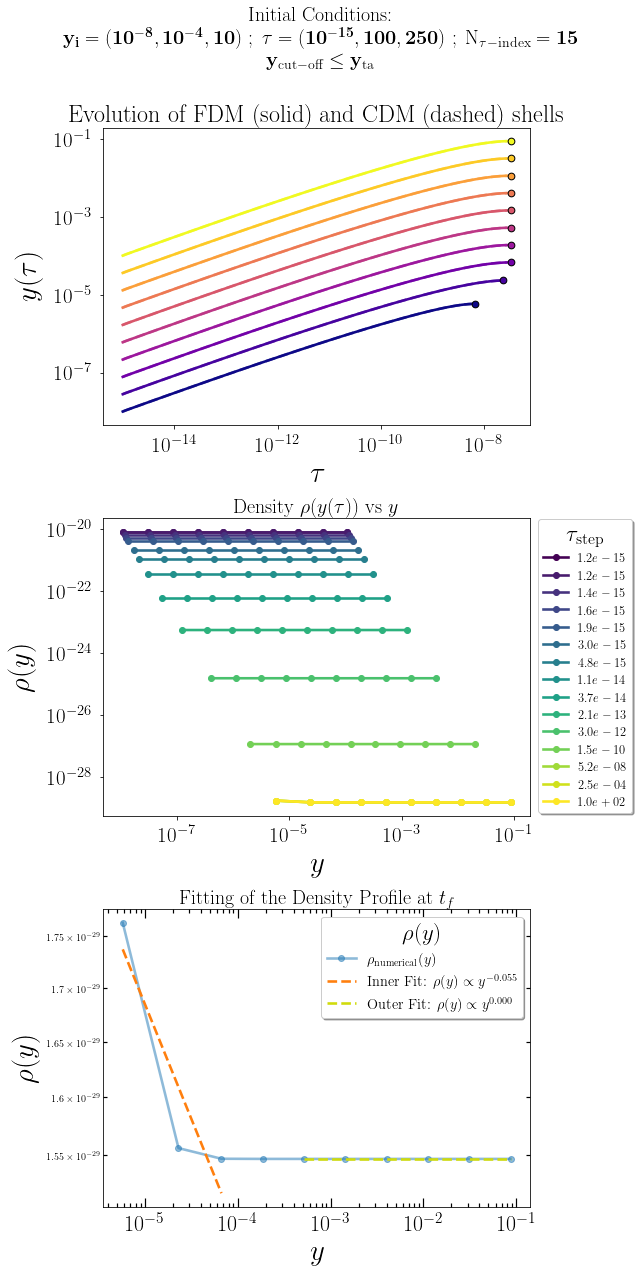

 Fitted slope (inner core):    \rho(y) \propto y^{-0.055}
 Fitted slope (outer tail):    \rho(y) \propto y^{0.000}


In [5]:
# for 10 FDM shells

t_i, t_f = 1e-15, 1e2
N = 10
r_min, r_max = 1e-8, 1e-4
ri_arr = np.geomspace(r_min, r_max, N)
initial_density = 1e-20


delta_M_arr = shells_mass(ri_arr, N, initial_density)
QP = True
gravity = True
Hubble = True


t_step = 250
t_arr = np.geomspace(t_i, t_f, t_step)
dt = np.gradient(t_arr)

r_sol = np.zeros((N, len(t_arr)))
v_sol = np.zeros((N, len(t_arr)))
rho_sol = np.zeros((N, len(t_arr)))
mask_active = np.ones(N, dtype=bool)
cutoff_index = np.full(N, len(t_arr))
t_ta_arr = np.full(N, np.nan)
r_ta_arr = np.full(N, np.nan)
turnaround_detected = np.zeros(N, dtype=bool)
r_sol[:, 0] = ri_arr
v_sol[:, 0] = ri_arr/(2 * t_arr[0])




freeze_fraction= 1
r_sol, v_sol, rho_sol, QP_arr, cutoff_index, r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask = shells_evolution(N, t_arr, dt, ri_arr, Hubble, gravity, QP, freeze_fraction)
time_indices = np.geomspace(1, t_step-1 , 15, dtype=int)




fig, axs = plt.subplots(3, 1, figsize=(9, 18), sharex=False)
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
colors_shell = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
colors1 = cm.viridis(np.linspace(0, 1, len(time_indices)))
colors2 = cm.plasma(np.linspace(0, 1, N))
colors3 = cm.magma(np.linspace(0, 1, len(time_indices)))



#------------------------------------------------------
ax = axs[0]


QP = False
gravity = True
Hubble = True
r_sol_no_qp, v_sol_no_qp, rho_sol_no_qp, QP_arr_no_qp, cutoff_index_no_qp,  r_ta_arr_no_qp, t_ta_arr_no_qp, rho_arr_no_qp, rta_mask_no_qp, tta_mask_no_qp = shells_evolution(N, t_arr, dt, ri_arr,  
Hubble, gravity, QP, freeze_fraction)


for j in range(N):
    cutoff = cutoff_index_no_qp[j]
    ax.loglog(t_arr[:cutoff], r_sol_no_qp[j, :cutoff], color=colors2[j], linestyle='--', alpha=0.7)
    if not np.isnan(t_ta_arr_no_qp[j]):
        ax.scatter(t_ta_arr_no_qp[j], r_ta_arr_no_qp[j], marker='o', s=30, color=colors2[j], edgecolor='k', alpha=0.3)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol_no_qp[j, cutoff - 1], marker='x', s=35, color=colors_shell[j], alpha=0.3)

# Plot FDM shells (with QP) with solid lines
for j in range(N):
    cutoff = cutoff_index[j]
    ax.loglog(t_arr[:cutoff], r_sol[j, :cutoff], color=colors2[j], linestyle='-', alpha=1.0, label=fr'${ri_arr[j]:.1e}$')
    if not np.isnan(t_ta_arr[j]):
        ax.scatter(t_ta_arr[j], r_ta_arr[j], marker='o', s=45, color=colors2[j], edgecolor='k', zorder=5)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol[j, cutoff - 1], marker='x', s=50, color=colors_shell[j], zorder=5)

# Labels, title and legend
ax.set_xlabel(r'$\tau$', fontsize=29, labelpad=6)
ax.set_ylabel(r'$y(\tau)$', fontsize=29, labelpad=11)
ax.set_title('Evolution of FDM (solid) and CDM (dashed) shells', fontsize=24)
ax.tick_params(axis='x', labelsize=21, pad=7.9)
ax.tick_params(axis='y', labelsize=21, pad=7.9)

#handles, labels = ax.get_legend_handles_labels()
#legend_shells = ax.legend(handles[:7], labels[:7], prop={'size': 12.5},
                        #  loc=(1.02, 0.13), shadow=True, title='$y_{i}$', title_fontsize=27,
                        #  facecolor='white', fontsize=25)

#legend_lines = [Line2D([0], [0], color='k', linestyle='-', lw=2),
               # Line2D([0], [0], color='k', linestyle='--', lw=2)]
#ax.legend(legend_lines, ['FDM', 'CDM'], prop={'size': 15.5}, loc=(1.02, 0.64),
         # shadow=True, title='Shell', title_fontsize=23,
         # facecolor='white', fontsize=20)
#ax.add_artist(legend_shells)









#----------------------------------------------------------
#Density vs time at different time steps


ax = axs[1]
for i, idx in enumerate(time_indices):
    r_at_time_index = r_sol[:, idx]
    rho_at_time_index = rho_sol[:, idx]
    ax.loglog(r_at_time_index, rho_at_time_index, marker='o', label=r'$ {0:.1e}$'.format(t_arr[idx]), color=colors1[i])


ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)  
#ax.text(5, 1e-24, '$y_i = (10^{-8}, 10^{-4}, 7)$', fontsize = 18)
#ax.text(5, 1e-27, '$N_\mathrm{time-indices} = 15$', fontsize = 18)
ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 11)
ax.legend( prop = {'size':12.5},loc = (1.02, 0.01),shadow = True, title = r'$\tau_\mathrm{step}$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 23)
ax.set_title(r'Density Profile at Different times steps', fontsize= 24)
ax.set_title(r' Density $\rho(y(\tau))$ vs $y$ ', fontsize=20)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 



#--------------------------------------------------------------------------------



###################################
# Fitting the density profile
ax = axs[2]


def f_fitting(x, m, b):
    return (m*x) + b


final_idx = -1
r_final = r_sol[:, final_idx]
rho_final = rho_sol[:, final_idx]
mask = (r_final > 0) & (rho_final > 0)
r_valid = r_final[mask]
rho_valid = rho_final[mask]


# Sort by radius
sorted_idx = np.argsort(r_valid)
r_valid = r_valid[sorted_idx]
rho_valid = rho_valid[sorted_idx]

# Define regions
inner_N = 3
outer_N = 6

# Inner region
r_inner = r_valid[:inner_N]
rho_inner = rho_valid[:inner_N]
log_r_inner = np.log10(r_inner)
log_rho_inner = np.log10(rho_inner)
popt_inner, _ = curve_fit(f_fitting, log_r_inner, log_rho_inner)
m_inner, b_inner = popt_inner
rho_fit_inner = 10**f_fitting(log_r_inner, *popt_inner)


# Outer region
r_outer = r_valid[-outer_N:]
rho_outer = rho_valid[-outer_N:]
log_r_outer = np.log10(r_outer)
log_rho_outer = np.log10(rho_outer)
popt_outer, _ = curve_fit(f_fitting, log_r_outer, log_rho_outer)
m_outer, b_outer = popt_outer
rho_fit_outer = 10**f_fitting(log_r_outer, *popt_outer)




ax.loglog(r_valid, rho_valid, 'o-', color='C0', alpha = 0.5)
ax.loglog(r_inner, rho_fit_inner, '--', color='C1')
#ax.loglog(r_middle, rho_fit_middle, '--', color='C3')
ax.loglog(r_outer, rho_fit_outer, '--', color='#d0db0b')


#plt.text(1e-14, 1e-45, '$y_i = (10^{-8}, 10^{-4}, 10)$', fontsize=18)
#plt.text(1e-14, 1e-49, '$(t_i, t_f, t_\\mathrm{steps}) = (10^{-15}, 10^{5}, 10000)$', fontsize=15)

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)

ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=22) 
ax.yaxis.set_tick_params(labelsize=22) 

ax.set_title('Fitting of the Density Profile at $t_f$', fontsize=20)
ax.legend([r'$\rho_\mathrm{numerical}(y)$', fr'Inner Fit: $\rho(y) \propto y^{{{m_inner:.3f}}}$',
           
           fr'Outer Fit: $\rho(y) \propto y^{{{m_outer:.3f}}}$'], 
           prop = {'size':14.5},loc = 'upper right', shadow = True, 
           title = r'$\rho(y)$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 31)




#---------------------------------------------------------------------



plt.suptitle(r'Initial Conditions:' + '\n' + 
    r'$\mathbf{y_i = (10^{-8}, 10^{-4}, 10)\; ;\;\tau = (10^{-15}, 100, 250)\; ;\;\mathrm{N_{\tau-index}} = 15}$'
              '\n' + r'$\mathbf{y_\mathrm{cut-off} \leq  y_\mathrm{ta}}$' , fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('rho&qp_N10_t250.pdf', bbox_inches='tight')
plt.show()



#--------------------------------------------------------------------

print(fr' Fitted slope (inner core):    \rho(y) \propto y^{{{m_inner:.3f}}}')
print(fr' Fitted slope (outer tail):    \rho(y) \propto y^{{{m_outer:.3f}}}')





np.savez('fdm_cdm_N10_t250_rta.npz',
         # FDM arrays
         r_sol_fdm=r_sol,
         v_sol_fdm=v_sol,
         rho_sol_fdm=rho_sol,
         QP_arr_fdm= QP_arr,
         cutoff_index_fdm=cutoff_index,
         r_ta_arr_fdm=r_ta_arr,
         t_ta_arr_fdm=t_ta_arr,
         rho_arr_fdm = rho_arr,
         rta_mask_fdm = rta_mask,
         tta_mask_fdm = tta_mask,
         
         
         # CDM arrays
         r_sol_cdm=r_sol_no_qp,
         v_sol_cdm=v_sol_no_qp,
         rho_sol_cdm=rho_sol_no_qp,
         QP_arr_cdm= QP_arr_no_qp,
         cutoff_index_cdm=cutoff_index_no_qp,
         r_ta_arr_cdm=r_ta_arr_no_qp,
         t_ta_arr_cdm=t_ta_arr_no_qp,
         rho_arr_cdm = rho_arr_no_qp,
         rta_mask_cdm = rta_mask_no_qp,
         tta_mask_cdm = tta_mask_no_qp)



No shells crossings is detected.


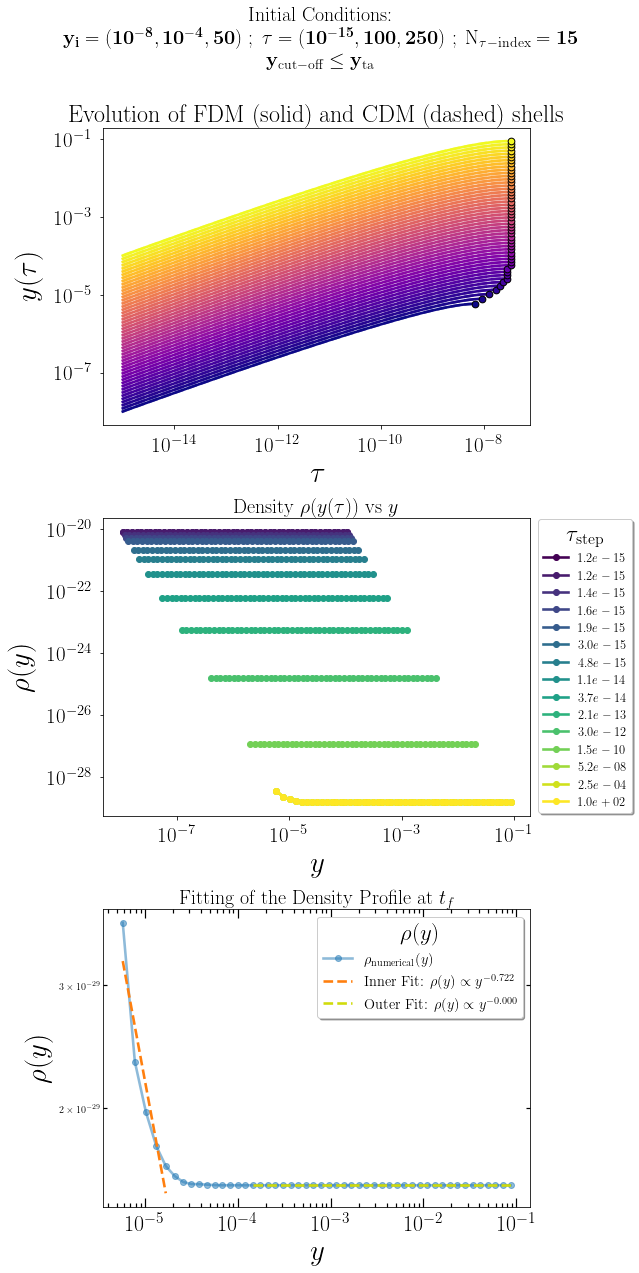

 Fitted slope (inner core):    \rho(y) \propto y^{-0.722}
 Fitted slope (outer tail):    \rho(y) \propto y^{-0.000}


In [8]:
# for 50 FDM shells

t_i, t_f = 1e-15, 1e2
N = 50
r_min, r_max = 1e-8, 1e-4
ri_arr = np.geomspace(r_min, r_max, N)
initial_density = 1e-20


delta_M_arr = shells_mass(ri_arr, N, initial_density)
QP = True
gravity = True
Hubble = True


t_step = 250
t_arr = np.geomspace(t_i, t_f, t_step)
dt = np.gradient(t_arr)

r_sol = np.zeros((N, len(t_arr)))
v_sol = np.zeros((N, len(t_arr)))
rho_sol = np.zeros((N, len(t_arr)))
mask_active = np.ones(N, dtype=bool)
cutoff_index = np.full(N, len(t_arr))
t_ta_arr = np.full(N, np.nan)
r_ta_arr = np.full(N, np.nan)
turnaround_detected = np.zeros(N, dtype=bool)
r_sol[:, 0] = ri_arr
v_sol[:, 0] = ri_arr/(2 * t_arr[0])




freeze_fraction= 1
r_sol, v_sol, rho_sol, QP_arr, cutoff_index, r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask = shells_evolution(N, t_arr, dt, ri_arr, Hubble, gravity, QP, freeze_fraction)
time_indices = np.geomspace(1, t_step-1 , 15, dtype=int)




fig, axs = plt.subplots(3, 1, figsize=(9, 18), sharex=False)
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
colors_shell = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
colors1 = cm.viridis(np.linspace(0, 1, len(time_indices)))
colors2 = cm.plasma(np.linspace(0, 1, N))
colors3 = cm.magma(np.linspace(0, 1, len(time_indices)))



#------------------------------------------------------
ax = axs[0]


QP = False
gravity = True
Hubble = True
r_sol_no_qp, v_sol_no_qp, rho_sol_no_qp, QP_arr_no_qp, cutoff_index_no_qp,  r_ta_arr_no_qp, t_ta_arr_no_qp, rho_arr_no_qp, rta_mask_no_qp, tta_mask_no_qp = shells_evolution(N, t_arr, dt, ri_arr,  
Hubble, gravity, QP, freeze_fraction)


for j in range(N):
    cutoff = cutoff_index_no_qp[j]
    ax.loglog(t_arr[:cutoff], r_sol_no_qp[j, :cutoff], color=colors2[j], linestyle='--', alpha=0.7)
    if not np.isnan(t_ta_arr_no_qp[j]):
        ax.scatter(t_ta_arr_no_qp[j], r_ta_arr_no_qp[j], marker='o', s=30, color=colors2[j], edgecolor='k', alpha=0.3)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol_no_qp[j, cutoff - 1], marker='x', s=35, color=colors_shell[j], alpha=0.3)

# Plot FDM shells (with QP) with solid lines
for j in range(N):
    cutoff = cutoff_index[j]
    ax.loglog(t_arr[:cutoff], r_sol[j, :cutoff], color=colors2[j], linestyle='-', alpha=1.0, label=fr'${ri_arr[j]:.1e}$')
    if not np.isnan(t_ta_arr[j]):
        ax.scatter(t_ta_arr[j], r_ta_arr[j], marker='o', s=45, color=colors2[j], edgecolor='k', zorder=5)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol[j, cutoff - 1], marker='x', s=50, color=colors_shell[j], zorder=5)

# Labels, title and legend
ax.set_xlabel(r'$\tau$', fontsize=29, labelpad=6)
ax.set_ylabel(r'$y(\tau)$', fontsize=29, labelpad=11)
ax.set_title('Evolution of FDM (solid) and CDM (dashed) shells', fontsize=24)
ax.tick_params(axis='x', labelsize=21, pad=7.9)
ax.tick_params(axis='y', labelsize=21, pad=7.9)

#handles, labels = ax.get_legend_handles_labels()
#legend_shells = ax.legend(handles[:7], labels[:7], prop={'size': 12.5},
                        #  loc=(1.02, 0.13), shadow=True, title='$y_{i}$', title_fontsize=27,
                        #  facecolor='white', fontsize=25)

#legend_lines = [Line2D([0], [0], color='k', linestyle='-', lw=2),
               # Line2D([0], [0], color='k', linestyle='--', lw=2)]
#ax.legend(legend_lines, ['FDM', 'CDM'], prop={'size': 15.5}, loc=(1.02, 0.64),
         # shadow=True, title='Shell', title_fontsize=23,
         # facecolor='white', fontsize=20)
#ax.add_artist(legend_shells)









#----------------------------------------------------------
#Density vs time at different time steps


ax = axs[1]
for i, idx in enumerate(time_indices):
    r_at_time_index = r_sol[:, idx]
    rho_at_time_index = rho_sol[:, idx]
    ax.loglog(r_at_time_index, rho_at_time_index, marker='o', label=r'$ {0:.1e}$'.format(t_arr[idx]), color=colors1[i])


ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)  
#ax.text(5, 1e-24, '$y_i = (10^{-8}, 10^{-4}, 7)$', fontsize = 18)
#ax.text(5, 1e-27, '$N_\mathrm{time-indices} = 15$', fontsize = 18)
ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 11)
ax.legend( prop = {'size':12.5},loc = (1.02, 0.01),shadow = True, title = r'$\tau_\mathrm{step}$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 23)
ax.set_title(r'Density Profile at Different times steps', fontsize= 24)
ax.set_title(r' Density $\rho(y(\tau))$ vs $y$ ', fontsize=20)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 



#--------------------------------------------------------------------------------



###################################
# Fitting the density profile
ax = axs[2]


def f_fitting(x, m, b):
    return (m*x) + b


final_idx = -1
r_final = r_sol[:, final_idx]
rho_final = rho_sol[:, final_idx]
mask = (r_final > 0) & (rho_final > 0)
r_valid = r_final[mask]
rho_valid = rho_final[mask]


# Sort by radius
sorted_idx = np.argsort(r_valid)
r_valid = r_valid[sorted_idx]
rho_valid = rho_valid[sorted_idx]

# Define regions
inner_N = 5
outer_N = 35

# Inner region
r_inner = r_valid[:inner_N]
rho_inner = rho_valid[:inner_N]
log_r_inner = np.log10(r_inner)
log_rho_inner = np.log10(rho_inner)
popt_inner, _ = curve_fit(f_fitting, log_r_inner, log_rho_inner)
m_inner, b_inner = popt_inner
rho_fit_inner = 10**f_fitting(log_r_inner, *popt_inner)


# Outer region
r_outer = r_valid[-outer_N:]
rho_outer = rho_valid[-outer_N:]
log_r_outer = np.log10(r_outer)
log_rho_outer = np.log10(rho_outer)
popt_outer, _ = curve_fit(f_fitting, log_r_outer, log_rho_outer)
m_outer, b_outer = popt_outer
rho_fit_outer = 10**f_fitting(log_r_outer, *popt_outer)




ax.loglog(r_valid, rho_valid, 'o-', color='C0', alpha = 0.5)
ax.loglog(r_inner, rho_fit_inner, '--', color='C1')
#ax.loglog(r_middle, rho_fit_middle, '--', color='C3')
ax.loglog(r_outer, rho_fit_outer, '--', color='#d0db0b')


#plt.text(1e-14, 1e-45, '$y_i = (10^{-8}, 10^{-4}, 10)$', fontsize=18)
#plt.text(1e-14, 1e-49, '$(t_i, t_f, t_\\mathrm{steps}) = (10^{-15}, 10^{5}, 10000)$', fontsize=15)

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)

ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=22) 
ax.yaxis.set_tick_params(labelsize=22) 

ax.set_title('Fitting of the Density Profile at $t_f$', fontsize=20)
ax.legend([r'$\rho_\mathrm{numerical}(y)$', fr'Inner Fit: $\rho(y) \propto y^{{{m_inner:.3f}}}$',
           
           fr'Outer Fit: $\rho(y) \propto y^{{{m_outer:.3f}}}$'], 
           prop = {'size':14.5},loc = 'upper right', shadow = True, 
           title = r'$\rho(y)$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 31)




#---------------------------------------------------------------------



plt.suptitle(r'Initial Conditions:' + '\n' + 
    r'$\mathbf{y_i = (10^{-8}, 10^{-4}, 50)\; ;\;\tau = (10^{-15}, 100, 250)\; ;\;\mathrm{N_{\tau-index}} = 15}$'
              '\n' + r'$\mathbf{y_\mathrm{cut-off} \leq  y_\mathrm{ta}}$' , fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('rho&qp_N50_t250.pdf', bbox_inches='tight')
plt.show()



#--------------------------------------------------------------------

print(fr' Fitted slope (inner core):    \rho(y) \propto y^{{{m_inner:.3f}}}')
print(fr' Fitted slope (outer tail):    \rho(y) \propto y^{{{m_outer:.3f}}}')





np.savez('fdm_cdm_N50_t250_rta.npz',
         # FDM arrays
         r_sol_fdm=r_sol,
         v_sol_fdm=v_sol,
         rho_sol_fdm=rho_sol,
         QP_arr_fdm= QP_arr,
         cutoff_index_fdm=cutoff_index,
         r_ta_arr_fdm=r_ta_arr,
         t_ta_arr_fdm=t_ta_arr,
         rho_arr_fdm = rho_arr,
         rta_mask_fdm = rta_mask,
         tta_mask_fdm = tta_mask,
         
         
         # CDM arrays
         r_sol_cdm=r_sol_no_qp,
         v_sol_cdm=v_sol_no_qp,
         rho_sol_cdm=rho_sol_no_qp,
         QP_arr_cdm= QP_arr_no_qp,
         cutoff_index_cdm=cutoff_index_no_qp,
         r_ta_arr_cdm=r_ta_arr_no_qp,
         t_ta_arr_cdm=t_ta_arr_no_qp,
         rho_arr_cdm = rho_arr_no_qp,
         rta_mask_cdm = rta_mask_no_qp,
         tta_mask_cdm = tta_mask_no_qp)



No shells crossings is detected.


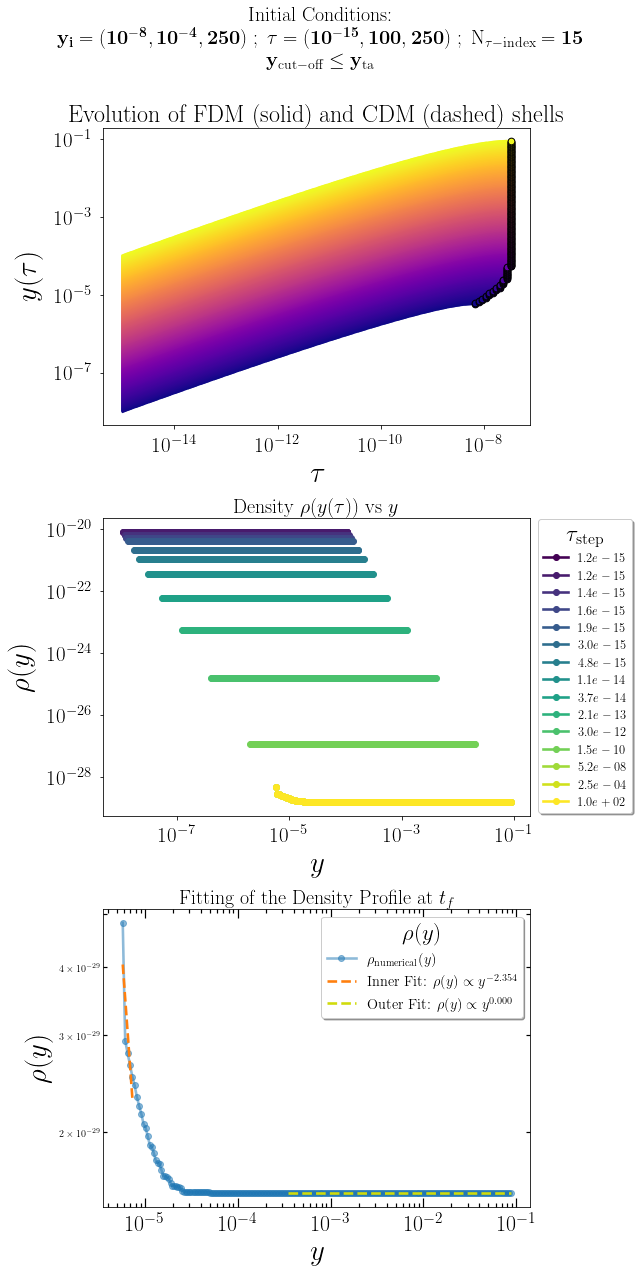

 Fitted slope (inner core):    \rho(y) \propto y^{-2.354}
 Fitted slope (outer tail):    \rho(y) \propto y^{0.000}


In [13]:
# for 250 FDM shells

t_i, t_f = 1e-15, 1e2
N = 250
r_min, r_max = 1e-8, 1e-4
ri_arr = np.geomspace(r_min, r_max, N)
initial_density = 1e-20


delta_M_arr = shells_mass(ri_arr, N, initial_density)
QP = True
gravity = True
Hubble = True


t_step = 250
t_arr = np.geomspace(t_i, t_f, t_step)
dt = np.gradient(t_arr)

r_sol = np.zeros((N, len(t_arr)))
v_sol = np.zeros((N, len(t_arr)))
rho_sol = np.zeros((N, len(t_arr)))
mask_active = np.ones(N, dtype=bool)
cutoff_index = np.full(N, len(t_arr))
t_ta_arr = np.full(N, np.nan)
r_ta_arr = np.full(N, np.nan)
turnaround_detected = np.zeros(N, dtype=bool)
r_sol[:, 0] = ri_arr
v_sol[:, 0] = ri_arr/(2 * t_arr[0])




freeze_fraction= 1
r_sol, v_sol, rho_sol, QP_arr, cutoff_index, r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask = shells_evolution(N, t_arr, dt, ri_arr, Hubble, gravity, QP, freeze_fraction)
time_indices = np.geomspace(1, t_step-1 , 15, dtype=int)




fig, axs = plt.subplots(3, 1, figsize=(9, 18), sharex=False)
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
colors_shell = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
colors1 = cm.viridis(np.linspace(0, 1, len(time_indices)))
colors2 = cm.plasma(np.linspace(0, 1, N))
colors3 = cm.magma(np.linspace(0, 1, len(time_indices)))



#------------------------------------------------------
ax = axs[0]


QP = False
gravity = True
Hubble = True
r_sol_no_qp, v_sol_no_qp, rho_sol_no_qp, QP_arr_no_qp, cutoff_index_no_qp,  r_ta_arr_no_qp, t_ta_arr_no_qp, rho_arr_no_qp, rta_mask_no_qp, tta_mask_no_qp = shells_evolution(N, t_arr, dt, ri_arr,  
Hubble, gravity, QP, freeze_fraction)


for j in range(N):
    cutoff = cutoff_index_no_qp[j]
    ax.loglog(t_arr[:cutoff], r_sol_no_qp[j, :cutoff], color=colors2[j], linestyle='--', alpha=0.7)
    if not np.isnan(t_ta_arr_no_qp[j]):
        ax.scatter(t_ta_arr_no_qp[j], r_ta_arr_no_qp[j], marker='o', s=30, color=colors2[j], edgecolor='k', alpha=0.3)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol_no_qp[j, cutoff - 1], marker='x', s=35, color=colors_shell[j], alpha=0.3)

# Plot FDM shells (with QP) with solid lines
for j in range(N):
    cutoff = cutoff_index[j]
    ax.loglog(t_arr[:cutoff], r_sol[j, :cutoff], color=colors2[j], linestyle='-', alpha=1.0, label=fr'${ri_arr[j]:.1e}$')
    if not np.isnan(t_ta_arr[j]):
        ax.scatter(t_ta_arr[j], r_ta_arr[j], marker='o', s=45, color=colors2[j], edgecolor='k', zorder=5)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol[j, cutoff - 1], marker='x', s=50, color=colors_shell[j], zorder=5)

# Labels, title and legend
ax.set_xlabel(r'$\tau$', fontsize=29, labelpad=6)
ax.set_ylabel(r'$y(\tau)$', fontsize=29, labelpad=11)
ax.set_title('Evolution of FDM (solid) and CDM (dashed) shells', fontsize=24)
ax.tick_params(axis='x', labelsize=21, pad=7.9)
ax.tick_params(axis='y', labelsize=21, pad=7.9)

#handles, labels = ax.get_legend_handles_labels()
#legend_shells = ax.legend(handles[:7], labels[:7], prop={'size': 12.5},
                        #  loc=(1.02, 0.13), shadow=True, title='$y_{i}$', title_fontsize=27,
                        #  facecolor='white', fontsize=25)

#legend_lines = [Line2D([0], [0], color='k', linestyle='-', lw=2),
               # Line2D([0], [0], color='k', linestyle='--', lw=2)]
#ax.legend(legend_lines, ['FDM', 'CDM'], prop={'size': 15.5}, loc=(1.02, 0.64),
         # shadow=True, title='Shell', title_fontsize=23,
         # facecolor='white', fontsize=20)
#ax.add_artist(legend_shells)









#----------------------------------------------------------
#Density vs time at different time steps


ax = axs[1]
for i, idx in enumerate(time_indices):
    r_at_time_index = r_sol[:, idx]
    rho_at_time_index = rho_sol[:, idx]
    ax.loglog(r_at_time_index, rho_at_time_index, marker='o', label=r'$ {0:.1e}$'.format(t_arr[idx]), color=colors1[i])


ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)  
#ax.text(5, 1e-24, '$y_i = (10^{-8}, 10^{-4}, 7)$', fontsize = 18)
#ax.text(5, 1e-27, '$N_\mathrm{time-indices} = 15$', fontsize = 18)
ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 11)
ax.legend( prop = {'size':12.5},loc = (1.02, 0.01),shadow = True, title = r'$\tau_\mathrm{step}$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 23)
ax.set_title(r'Density Profile at Different times steps', fontsize= 24)
ax.set_title(r' Density $\rho(y(\tau))$ vs $y$ ', fontsize=20)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 



#--------------------------------------------------------------------------------



###################################
# Fitting the density profile
ax = axs[2]


def f_fitting(x, m, b):
    return (m*x) + b


final_idx = -1
r_final = r_sol[:, final_idx]
rho_final = rho_sol[:, final_idx]
mask = (r_final > 0) & (rho_final > 0)
r_valid = r_final[mask]
rho_valid = rho_final[mask]


# Sort by radius
sorted_idx = np.argsort(r_valid)
r_valid = r_valid[sorted_idx]
rho_valid = rho_valid[sorted_idx]

# Define regions
inner_N = 5
outer_N = 150

# Inner region
r_inner = r_valid[:inner_N]
rho_inner = rho_valid[:inner_N]
log_r_inner = np.log10(r_inner)
log_rho_inner = np.log10(rho_inner)
popt_inner, _ = curve_fit(f_fitting, log_r_inner, log_rho_inner)
m_inner, b_inner = popt_inner
rho_fit_inner = 10**f_fitting(log_r_inner, *popt_inner)


# Outer region
r_outer = r_valid[-outer_N:]
rho_outer = rho_valid[-outer_N:]
log_r_outer = np.log10(r_outer)
log_rho_outer = np.log10(rho_outer)
popt_outer, _ = curve_fit(f_fitting, log_r_outer, log_rho_outer)
m_outer, b_outer = popt_outer
rho_fit_outer = 10**f_fitting(log_r_outer, *popt_outer)




ax.loglog(r_valid, rho_valid, 'o-', color='C0', alpha = 0.5)
ax.loglog(r_inner, rho_fit_inner, '--', color='C1')
#ax.loglog(r_middle, rho_fit_middle, '--', color='C3')
ax.loglog(r_outer, rho_fit_outer, '--', color='#d0db0b')


#plt.text(1e-14, 1e-45, '$y_i = (10^{-8}, 10^{-4}, 10)$', fontsize=18)
#plt.text(1e-14, 1e-49, '$(t_i, t_f, t_\\mathrm{steps}) = (10^{-15}, 10^{5}, 10000)$', fontsize=15)

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)

ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=22) 
ax.yaxis.set_tick_params(labelsize=22) 

ax.set_title('Fitting of the Density Profile at $t_f$', fontsize=20)
ax.legend([r'$\rho_\mathrm{numerical}(y)$', fr'Inner Fit: $\rho(y) \propto y^{{{m_inner:.3f}}}$',
           
           fr'Outer Fit: $\rho(y) \propto y^{{{m_outer:.3f}}}$'], 
           prop = {'size':14.5},loc = 'upper right', shadow = True, 
           title = r'$\rho(y)$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 31)




#---------------------------------------------------------------------



plt.suptitle(r'Initial Conditions:' + '\n' + 
    r'$\mathbf{y_i = (10^{-8}, 10^{-4}, 250)\; ;\;\tau = (10^{-15}, 100, 250)\; ;\;\mathrm{N_{\tau-index}} = 15}$'
              '\n' + r'$\mathbf{y_\mathrm{cut-off} \leq  y_\mathrm{ta}}$' , fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('rho&qp_N250_t250.pdf', bbox_inches='tight')
plt.show()



#--------------------------------------------------------------------

print(fr' Fitted slope (inner core):    \rho(y) \propto y^{{{m_inner:.3f}}}')
print(fr' Fitted slope (outer tail):    \rho(y) \propto y^{{{m_outer:.3f}}}')





np.savez('fdm_cdm_N250_t250_rta.npz',
         # FDM arrays
         r_sol_fdm=r_sol,
         v_sol_fdm=v_sol,
         rho_sol_fdm=rho_sol,
         QP_arr_fdm= QP_arr,
         cutoff_index_fdm=cutoff_index,
         r_ta_arr_fdm=r_ta_arr,
         t_ta_arr_fdm=t_ta_arr,
         rho_arr_fdm = rho_arr,
         rta_mask_fdm = rta_mask,
         tta_mask_fdm = tta_mask,
         
         
         # CDM arrays
         r_sol_cdm=r_sol_no_qp,
         v_sol_cdm=v_sol_no_qp,
         rho_sol_cdm=rho_sol_no_qp,
         QP_arr_cdm= QP_arr_no_qp,
         cutoff_index_cdm=cutoff_index_no_qp,
         r_ta_arr_cdm=r_ta_arr_no_qp,
         t_ta_arr_cdm=t_ta_arr_no_qp,
         rho_arr_cdm = rho_arr_no_qp,
         rta_mask_cdm = rta_mask_no_qp,
         tta_mask_cdm = tta_mask_no_qp)



No shells crossings is detected.


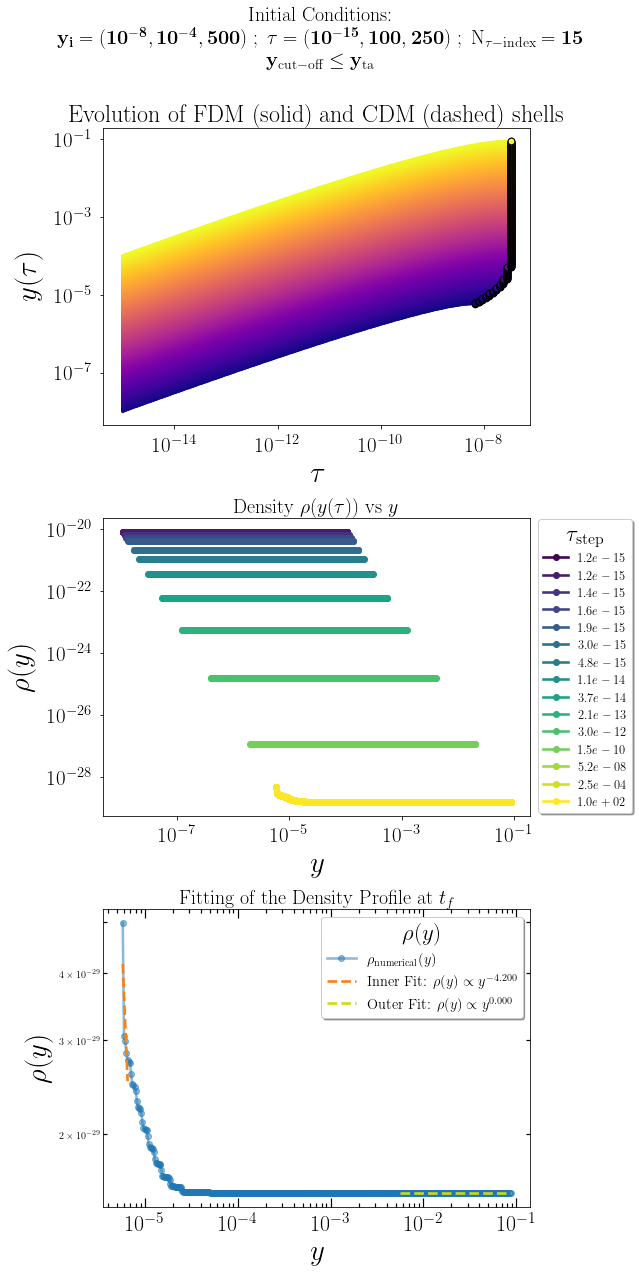

 Fitted slope (inner core):    \rho(y) \propto y^{-4.200}
 Fitted slope (outer tail):    \rho(y) \propto y^{0.000}


In [22]:
# for 500 FDM shells

t_i, t_f = 1e-15, 1e2
N = 500
r_min, r_max = 1e-8, 1e-4
ri_arr = np.geomspace(r_min, r_max, N)
initial_density = 1e-20


delta_M_arr = shells_mass(ri_arr, N, initial_density)
QP = True
gravity = True
Hubble = True


t_step = 250
t_arr = np.geomspace(t_i, t_f, t_step)
dt = np.gradient(t_arr)

r_sol = np.zeros((N, len(t_arr)))
v_sol = np.zeros((N, len(t_arr)))
rho_sol = np.zeros((N, len(t_arr)))
mask_active = np.ones(N, dtype=bool)
cutoff_index = np.full(N, len(t_arr))
t_ta_arr = np.full(N, np.nan)
r_ta_arr = np.full(N, np.nan)
turnaround_detected = np.zeros(N, dtype=bool)
r_sol[:, 0] = ri_arr
v_sol[:, 0] = ri_arr/(2 * t_arr[0])




freeze_fraction= 1
r_sol, v_sol, rho_sol, QP_arr, cutoff_index, r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask = shells_evolution(N, t_arr, dt, ri_arr, Hubble, gravity, QP, freeze_fraction)
time_indices = np.geomspace(1, t_step-1 , 15, dtype=int)




fig, axs = plt.subplots(3, 1, figsize=(9, 18), sharex=False)
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
colors_shell = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
colors1 = cm.viridis(np.linspace(0, 1, len(time_indices)))
colors2 = cm.plasma(np.linspace(0, 1, N))
colors3 = cm.magma(np.linspace(0, 1, len(time_indices)))



#------------------------------------------------------
ax = axs[0]


QP = False
gravity = True
Hubble = True
r_sol_no_qp, v_sol_no_qp, rho_sol_no_qp, QP_arr_no_qp, cutoff_index_no_qp,  r_ta_arr_no_qp, t_ta_arr_no_qp, rho_arr_no_qp, rta_mask_no_qp, tta_mask_no_qp = shells_evolution(N, t_arr, dt, ri_arr,  
Hubble, gravity, QP, freeze_fraction)


for j in range(N):
    cutoff = cutoff_index_no_qp[j]
    ax.loglog(t_arr[:cutoff], r_sol_no_qp[j, :cutoff], color=colors2[j], linestyle='--', alpha=0.7)
    if not np.isnan(t_ta_arr_no_qp[j]):
        ax.scatter(t_ta_arr_no_qp[j], r_ta_arr_no_qp[j], marker='o', s=30, color=colors2[j], edgecolor='k', alpha=0.3)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol_no_qp[j, cutoff - 1], marker='x', s=35, color=colors_shell[j], alpha=0.3)

# Plot FDM shells (with QP) with solid lines
for j in range(N):
    cutoff = cutoff_index[j]
    ax.loglog(t_arr[:cutoff], r_sol[j, :cutoff], color=colors2[j], linestyle='-', alpha=1.0, label=fr'${ri_arr[j]:.1e}$')
    if not np.isnan(t_ta_arr[j]):
        ax.scatter(t_ta_arr[j], r_ta_arr[j], marker='o', s=45, color=colors2[j], edgecolor='k', zorder=5)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol[j, cutoff - 1], marker='x', s=50, color=colors_shell[j], zorder=5)

# Labels, title and legend
ax.set_xlabel(r'$\tau$', fontsize=29, labelpad=6)
ax.set_ylabel(r'$y(\tau)$', fontsize=29, labelpad=11)
ax.set_title('Evolution of FDM (solid) and CDM (dashed) shells', fontsize=24)
ax.tick_params(axis='x', labelsize=21, pad=7.9)
ax.tick_params(axis='y', labelsize=21, pad=7.9)

#handles, labels = ax.get_legend_handles_labels()
#legend_shells = ax.legend(handles[:7], labels[:7], prop={'size': 12.5},
                        #  loc=(1.02, 0.13), shadow=True, title='$y_{i}$', title_fontsize=27,
                        #  facecolor='white', fontsize=25)

#legend_lines = [Line2D([0], [0], color='k', linestyle='-', lw=2),
               # Line2D([0], [0], color='k', linestyle='--', lw=2)]
#ax.legend(legend_lines, ['FDM', 'CDM'], prop={'size': 15.5}, loc=(1.02, 0.64),
         # shadow=True, title='Shell', title_fontsize=23,
         # facecolor='white', fontsize=20)
#ax.add_artist(legend_shells)









#----------------------------------------------------------
#Density vs time at different time steps


ax = axs[1]
for i, idx in enumerate(time_indices):
    r_at_time_index = r_sol[:, idx]
    rho_at_time_index = rho_sol[:, idx]
    ax.loglog(r_at_time_index, rho_at_time_index, marker='o', label=r'$ {0:.1e}$'.format(t_arr[idx]), color=colors1[i])


ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)  
#ax.text(5, 1e-24, '$y_i = (10^{-8}, 10^{-4}, 7)$', fontsize = 18)
#ax.text(5, 1e-27, '$N_\mathrm{time-indices} = 15$', fontsize = 18)
ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 11)
ax.legend( prop = {'size':12.5},loc = (1.02, 0.01),shadow = True, title = r'$\tau_\mathrm{step}$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 23)
ax.set_title(r'Density Profile at Different times steps', fontsize= 24)
ax.set_title(r' Density $\rho(y(\tau))$ vs $y$ ', fontsize=20)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 



#--------------------------------------------------------------------------------



###################################
# Fitting the density profile
ax = axs[2]


def f_fitting(x, m, b):
    return (m*x) + b


final_idx = -1
r_final = r_sol[:, final_idx]
rho_final = rho_sol[:, final_idx]
mask = (r_final > 0) & (rho_final > 0)
r_valid = r_final[mask]
rho_valid = rho_final[mask]


# Sort by radius
sorted_idx = np.argsort(r_valid)
r_valid = r_valid[sorted_idx]
rho_valid = rho_valid[sorted_idx]

# Define regions
inner_N = 5
outer_N = 150

# Inner region
r_inner = r_valid[:inner_N]
rho_inner = rho_valid[:inner_N]
log_r_inner = np.log10(r_inner)
log_rho_inner = np.log10(rho_inner)
popt_inner, _ = curve_fit(f_fitting, log_r_inner, log_rho_inner)
m_inner, b_inner = popt_inner
rho_fit_inner = 10**f_fitting(log_r_inner, *popt_inner)


# Outer region
r_outer = r_valid[-outer_N:]
rho_outer = rho_valid[-outer_N:]
log_r_outer = np.log10(r_outer)
log_rho_outer = np.log10(rho_outer)
popt_outer, _ = curve_fit(f_fitting, log_r_outer, log_rho_outer)
m_outer, b_outer = popt_outer
rho_fit_outer = 10**f_fitting(log_r_outer, *popt_outer)




ax.loglog(r_valid, rho_valid, 'o-', color='C0', alpha = 0.5)
ax.loglog(r_inner, rho_fit_inner, '--', color='C1')
#ax.loglog(r_middle, rho_fit_middle, '--', color='C3')
ax.loglog(r_outer, rho_fit_outer, '--', color='#d0db0b')


#plt.text(1e-14, 1e-45, '$y_i = (10^{-8}, 10^{-4}, 10)$', fontsize=18)
#plt.text(1e-14, 1e-49, '$(t_i, t_f, t_\\mathrm{steps}) = (10^{-15}, 10^{5}, 10000)$', fontsize=15)

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)

ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=22) 
ax.yaxis.set_tick_params(labelsize=22) 

ax.set_title('Fitting of the Density Profile at $t_f$', fontsize=20)
ax.legend([r'$\rho_\mathrm{numerical}(y)$', fr'Inner Fit: $\rho(y) \propto y^{{{m_inner:.3f}}}$',
           
           fr'Outer Fit: $\rho(y) \propto y^{{{m_outer:.3f}}}$'], 
           prop = {'size':14.5},loc = 'upper right', shadow = True, 
           title = r'$\rho(y)$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 31)




#---------------------------------------------------------------------



plt.suptitle(r'Initial Conditions:' + '\n' + 
    r'$\mathbf{y_i = (10^{-8}, 10^{-4}, 500)\; ;\;\tau = (10^{-15}, 100, 250)\; ;\;\mathrm{N_{\tau-index}} = 15}$'
              '\n' + r'$\mathbf{y_\mathrm{cut-off} \leq  y_\mathrm{ta}}$' , fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('rho&qp_N500_t250.pdf', bbox_inches='tight')
plt.show()



#--------------------------------------------------------------------

print(fr' Fitted slope (inner core):    \rho(y) \propto y^{{{m_inner:.3f}}}')
print(fr' Fitted slope (outer tail):    \rho(y) \propto y^{{{m_outer:.3f}}}')





np.savez('fdm_cdm_N500_t250_rta.npz',
         # FDM arrays
         r_sol_fdm=r_sol,
         v_sol_fdm=v_sol,
         rho_sol_fdm=rho_sol,
         QP_arr_fdm= QP_arr,
         cutoff_index_fdm=cutoff_index,
         r_ta_arr_fdm=r_ta_arr,
         t_ta_arr_fdm=t_ta_arr,
         rho_arr_fdm = rho_arr,
         rta_mask_fdm = rta_mask,
         tta_mask_fdm = tta_mask,
         
         
         # CDM arrays
         r_sol_cdm=r_sol_no_qp,
         v_sol_cdm=v_sol_no_qp,
         rho_sol_cdm=rho_sol_no_qp,
         QP_arr_cdm= QP_arr_no_qp,
         cutoff_index_cdm=cutoff_index_no_qp,
         r_ta_arr_cdm=r_ta_arr_no_qp,
         t_ta_arr_cdm=t_ta_arr_no_qp,
         rho_arr_cdm = rho_arr_no_qp,
         rta_mask_cdm = rta_mask_no_qp,
         tta_mask_cdm = tta_mask_no_qp)



No shells crossings is detected.


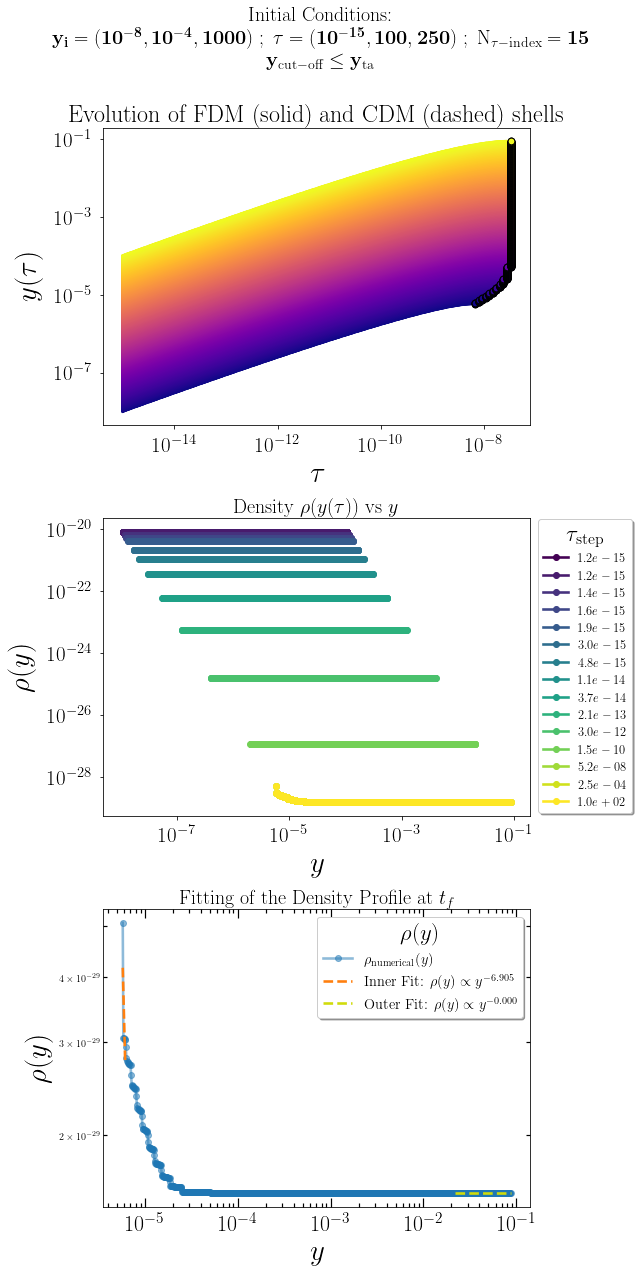

 Fitted slope (inner core):    \rho(y) \propto y^{-6.905}
 Fitted slope (outer tail):    \rho(y) \propto y^{-0.000}


In [30]:
# for 1000 FDM shells

t_i, t_f = 1e-15, 1e2
N = 1000
r_min, r_max = 1e-8, 1e-4
ri_arr = np.geomspace(r_min, r_max, N)
initial_density = 1e-20


delta_M_arr = shells_mass(ri_arr, N, initial_density)
QP = True
gravity = True
Hubble = True


t_step = 250
t_arr = np.geomspace(t_i, t_f, t_step)
dt = np.gradient(t_arr)

r_sol = np.zeros((N, len(t_arr)))
v_sol = np.zeros((N, len(t_arr)))
rho_sol = np.zeros((N, len(t_arr)))
mask_active = np.ones(N, dtype=bool)
cutoff_index = np.full(N, len(t_arr))
t_ta_arr = np.full(N, np.nan)
r_ta_arr = np.full(N, np.nan)
turnaround_detected = np.zeros(N, dtype=bool)
r_sol[:, 0] = ri_arr
v_sol[:, 0] = ri_arr/(2 * t_arr[0])




freeze_fraction= 1
r_sol, v_sol, rho_sol, QP_arr, cutoff_index, r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask = shells_evolution(N, t_arr, dt, ri_arr, Hubble, gravity, QP, freeze_fraction)
time_indices = np.geomspace(1, t_step-1 , 15, dtype=int)




fig, axs = plt.subplots(3, 1, figsize=(9, 18), sharex=False)
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
colors_shell = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
colors1 = cm.viridis(np.linspace(0, 1, len(time_indices)))
colors2 = cm.plasma(np.linspace(0, 1, N))
colors3 = cm.magma(np.linspace(0, 1, len(time_indices)))



#------------------------------------------------------
ax = axs[0]


QP = False
gravity = True
Hubble = True
r_sol_no_qp, v_sol_no_qp, rho_sol_no_qp, QP_arr_no_qp, cutoff_index_no_qp,  r_ta_arr_no_qp, t_ta_arr_no_qp, rho_arr_no_qp, rta_mask_no_qp, tta_mask_no_qp = shells_evolution(N, t_arr, dt, ri_arr,  
Hubble, gravity, QP, freeze_fraction)


for j in range(N):
    cutoff = cutoff_index_no_qp[j]
    ax.loglog(t_arr[:cutoff], r_sol_no_qp[j, :cutoff], color=colors2[j], linestyle='--', alpha=0.7)
    if not np.isnan(t_ta_arr_no_qp[j]):
        ax.scatter(t_ta_arr_no_qp[j], r_ta_arr_no_qp[j], marker='o', s=30, color=colors2[j], edgecolor='k', alpha=0.3)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol_no_qp[j, cutoff - 1], marker='x', s=35, color=colors_shell[j], alpha=0.3)

# Plot FDM shells (with QP) with solid lines
for j in range(N):
    cutoff = cutoff_index[j]
    ax.loglog(t_arr[:cutoff], r_sol[j, :cutoff], color=colors2[j], linestyle='-', alpha=1.0, label=fr'${ri_arr[j]:.1e}$')
    if not np.isnan(t_ta_arr[j]):
        ax.scatter(t_ta_arr[j], r_ta_arr[j], marker='o', s=45, color=colors2[j], edgecolor='k', zorder=5)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol[j, cutoff - 1], marker='x', s=50, color=colors_shell[j], zorder=5)

# Labels, title and legend
ax.set_xlabel(r'$\tau$', fontsize=29, labelpad=6)
ax.set_ylabel(r'$y(\tau)$', fontsize=29, labelpad=11)
ax.set_title('Evolution of FDM (solid) and CDM (dashed) shells', fontsize=24)
ax.tick_params(axis='x', labelsize=21, pad=7.9)
ax.tick_params(axis='y', labelsize=21, pad=7.9)

#handles, labels = ax.get_legend_handles_labels()
#legend_shells = ax.legend(handles[:7], labels[:7], prop={'size': 12.5},
                        #  loc=(1.02, 0.13), shadow=True, title='$y_{i}$', title_fontsize=27,
                        #  facecolor='white', fontsize=25)

#legend_lines = [Line2D([0], [0], color='k', linestyle='-', lw=2),
               # Line2D([0], [0], color='k', linestyle='--', lw=2)]
#ax.legend(legend_lines, ['FDM', 'CDM'], prop={'size': 15.5}, loc=(1.02, 0.64),
         # shadow=True, title='Shell', title_fontsize=23,
         # facecolor='white', fontsize=20)
#ax.add_artist(legend_shells)









#----------------------------------------------------------
#Density vs time at different time steps


ax = axs[1]
for i, idx in enumerate(time_indices):
    r_at_time_index = r_sol[:, idx]
    rho_at_time_index = rho_sol[:, idx]
    ax.loglog(r_at_time_index, rho_at_time_index, marker='o', label=r'$ {0:.1e}$'.format(t_arr[idx]), color=colors1[i])


ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)  
#ax.text(5, 1e-24, '$y_i = (10^{-8}, 10^{-4}, 7)$', fontsize = 18)
#ax.text(5, 1e-27, '$N_\mathrm{time-indices} = 15$', fontsize = 18)
ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 11)
ax.legend( prop = {'size':12.5},loc = (1.02, 0.01),shadow = True, title = r'$\tau_\mathrm{step}$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 23)
ax.set_title(r'Density Profile at Different times steps', fontsize= 24)
ax.set_title(r' Density $\rho(y(\tau))$ vs $y$ ', fontsize=20)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 



#--------------------------------------------------------------------------------



###################################
# Fitting the density profile
ax = axs[2]


def f_fitting(x, m, b):
    return (m*x) + b


final_idx = -1
r_final = r_sol[:, final_idx]
rho_final = rho_sol[:, final_idx]
mask = (r_final > 0) & (rho_final > 0)
r_valid = r_final[mask]
rho_valid = rho_final[mask]


# Sort by radius
sorted_idx = np.argsort(r_valid)
r_valid = r_valid[sorted_idx]
rho_valid = rho_valid[sorted_idx]

# Define regions
inner_N = 5
outer_N = 150

# Inner region
r_inner = r_valid[:inner_N]
rho_inner = rho_valid[:inner_N]
log_r_inner = np.log10(r_inner)
log_rho_inner = np.log10(rho_inner)
popt_inner, _ = curve_fit(f_fitting, log_r_inner, log_rho_inner)
m_inner, b_inner = popt_inner
rho_fit_inner = 10**f_fitting(log_r_inner, *popt_inner)


# Outer region
r_outer = r_valid[-outer_N:]
rho_outer = rho_valid[-outer_N:]
log_r_outer = np.log10(r_outer)
log_rho_outer = np.log10(rho_outer)
popt_outer, _ = curve_fit(f_fitting, log_r_outer, log_rho_outer)
m_outer, b_outer = popt_outer
rho_fit_outer = 10**f_fitting(log_r_outer, *popt_outer)




ax.loglog(r_valid, rho_valid, 'o-', color='C0', alpha = 0.5)
ax.loglog(r_inner, rho_fit_inner, '--', color='C1')
#ax.loglog(r_middle, rho_fit_middle, '--', color='C3')
ax.loglog(r_outer, rho_fit_outer, '--', color='#d0db0b')


#plt.text(1e-14, 1e-45, '$y_i = (10^{-8}, 10^{-4}, 10)$', fontsize=18)
#plt.text(1e-14, 1e-49, '$(t_i, t_f, t_\\mathrm{steps}) = (10^{-15}, 10^{5}, 10000)$', fontsize=15)

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)

ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=22) 
ax.yaxis.set_tick_params(labelsize=22) 

ax.set_title('Fitting of the Density Profile at $t_f$', fontsize=20)
ax.legend([r'$\rho_\mathrm{numerical}(y)$', fr'Inner Fit: $\rho(y) \propto y^{{{m_inner:.3f}}}$',
           
           fr'Outer Fit: $\rho(y) \propto y^{{{m_outer:.3f}}}$'], 
           prop = {'size':14.5},loc = 'upper right', shadow = True, 
           title = r'$\rho(y)$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 31)




#---------------------------------------------------------------------



plt.suptitle(r'Initial Conditions:' + '\n' + 
    r'$\mathbf{y_i = (10^{-8}, 10^{-4}, 1000)\; ;\;\tau = (10^{-15}, 100, 250)\; ;\;\mathrm{N_{\tau-index}} = 15}$'
              '\n' + r'$\mathbf{y_\mathrm{cut-off} \leq  y_\mathrm{ta}}$' , fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('rho&qp_N1000_t250.pdf', bbox_inches='tight')
plt.show()



#--------------------------------------------------------------------

print(fr' Fitted slope (inner core):    \rho(y) \propto y^{{{m_inner:.3f}}}')
print(fr' Fitted slope (outer tail):    \rho(y) \propto y^{{{m_outer:.3f}}}')





np.savez('fdm_cdm_N1000_t250_rta.npz',
         # FDM arrays
         r_sol_fdm=r_sol,
         v_sol_fdm=v_sol,
         rho_sol_fdm=rho_sol,
         QP_arr_fdm= QP_arr,
         cutoff_index_fdm=cutoff_index,
         r_ta_arr_fdm=r_ta_arr,
         t_ta_arr_fdm=t_ta_arr,
         rho_arr_fdm = rho_arr,
         rta_mask_fdm = rta_mask,
         tta_mask_fdm = tta_mask,
         
         
         # CDM arrays
         r_sol_cdm=r_sol_no_qp,
         v_sol_cdm=v_sol_no_qp,
         rho_sol_cdm=rho_sol_no_qp,
         QP_arr_cdm= QP_arr_no_qp,
         cutoff_index_cdm=cutoff_index_no_qp,
         r_ta_arr_cdm=r_ta_arr_no_qp,
         t_ta_arr_cdm=t_ta_arr_no_qp,
         rho_arr_cdm = rho_arr_no_qp,
         rta_mask_cdm = rta_mask_no_qp,
         tta_mask_cdm = tta_mask_no_qp)



No shells crossings is detected.


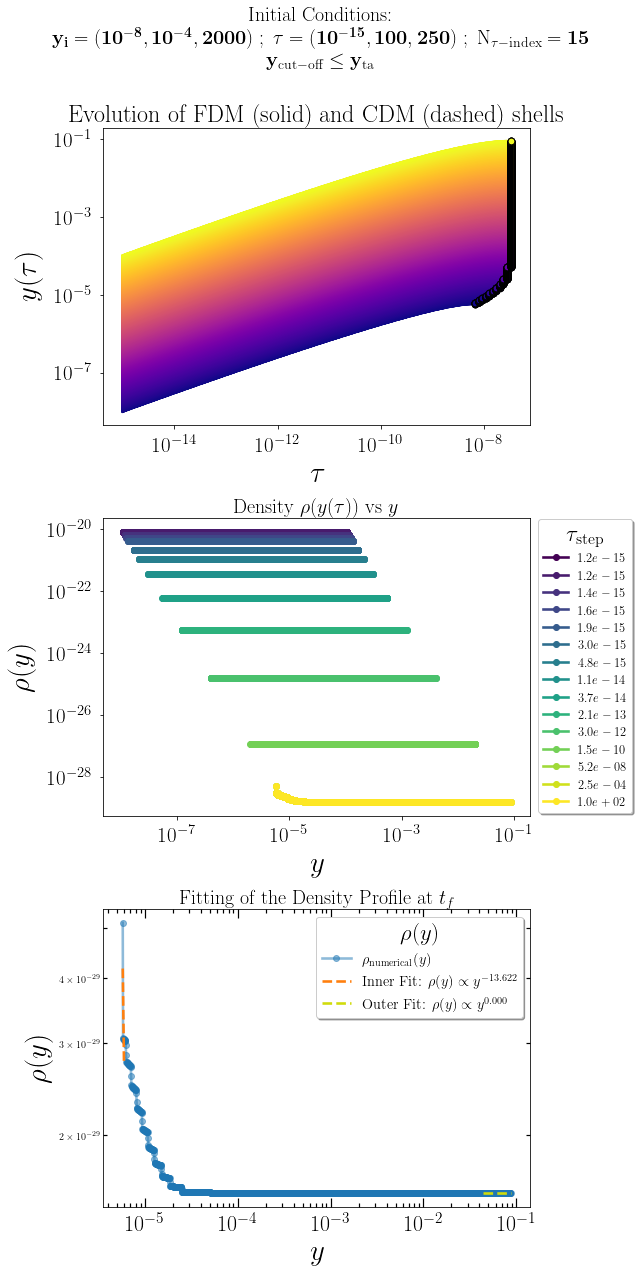

 Fitted slope (inner core):    \rho(y) \propto y^{-13.622}
 Fitted slope (outer tail):    \rho(y) \propto y^{0.000}


In [38]:
# for 2000 FDM shells

t_i, t_f = 1e-15, 1e2
N = 2000
r_min, r_max = 1e-8, 1e-4
ri_arr = np.geomspace(r_min, r_max, N)
initial_density = 1e-20


delta_M_arr = shells_mass(ri_arr, N, initial_density)
QP = True
gravity = True
Hubble = True


t_step = 250
t_arr = np.geomspace(t_i, t_f, t_step)
dt = np.gradient(t_arr)

r_sol = np.zeros((N, len(t_arr)))
v_sol = np.zeros((N, len(t_arr)))
rho_sol = np.zeros((N, len(t_arr)))
mask_active = np.ones(N, dtype=bool)
cutoff_index = np.full(N, len(t_arr))
t_ta_arr = np.full(N, np.nan)
r_ta_arr = np.full(N, np.nan)
turnaround_detected = np.zeros(N, dtype=bool)
r_sol[:, 0] = ri_arr
v_sol[:, 0] = ri_arr/(2 * t_arr[0])




freeze_fraction= 1
r_sol, v_sol, rho_sol, QP_arr, cutoff_index, r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask = shells_evolution(N, t_arr, dt, ri_arr, Hubble, gravity, QP, freeze_fraction)
time_indices = np.geomspace(1, t_step-1 , 15, dtype=int)




fig, axs = plt.subplots(3, 1, figsize=(9, 18), sharex=False)
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
colors_shell = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
colors1 = cm.viridis(np.linspace(0, 1, len(time_indices)))
colors2 = cm.plasma(np.linspace(0, 1, N))
colors3 = cm.magma(np.linspace(0, 1, len(time_indices)))



#------------------------------------------------------
ax = axs[0]


QP = False
gravity = True
Hubble = True
r_sol_no_qp, v_sol_no_qp, rho_sol_no_qp, QP_arr_no_qp, cutoff_index_no_qp,  r_ta_arr_no_qp, t_ta_arr_no_qp, rho_arr_no_qp, rta_mask_no_qp, tta_mask_no_qp = shells_evolution(N, t_arr, dt, ri_arr,  
Hubble, gravity, QP, freeze_fraction)


for j in range(N):
    cutoff = cutoff_index_no_qp[j]
    ax.loglog(t_arr[:cutoff], r_sol_no_qp[j, :cutoff], color=colors2[j], linestyle='--', alpha=0.7)
    if not np.isnan(t_ta_arr_no_qp[j]):
        ax.scatter(t_ta_arr_no_qp[j], r_ta_arr_no_qp[j], marker='o', s=30, color=colors2[j], edgecolor='k', alpha=0.3)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol_no_qp[j, cutoff - 1], marker='x', s=35, color=colors_shell[j], alpha=0.3)

# Plot FDM shells (with QP) with solid lines
for j in range(N):
    cutoff = cutoff_index[j]
    ax.loglog(t_arr[:cutoff], r_sol[j, :cutoff], color=colors2[j], linestyle='-', alpha=1.0, label=fr'${ri_arr[j]:.1e}$')
    if not np.isnan(t_ta_arr[j]):
        ax.scatter(t_ta_arr[j], r_ta_arr[j], marker='o', s=45, color=colors2[j], edgecolor='k', zorder=5)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol[j, cutoff - 1], marker='x', s=50, color=colors_shell[j], zorder=5)

# Labels, title and legend
ax.set_xlabel(r'$\tau$', fontsize=29, labelpad=6)
ax.set_ylabel(r'$y(\tau)$', fontsize=29, labelpad=11)
ax.set_title('Evolution of FDM (solid) and CDM (dashed) shells', fontsize=24)
ax.tick_params(axis='x', labelsize=21, pad=7.9)
ax.tick_params(axis='y', labelsize=21, pad=7.9)

#handles, labels = ax.get_legend_handles_labels()
#legend_shells = ax.legend(handles[:7], labels[:7], prop={'size': 12.5},
                        #  loc=(1.02, 0.13), shadow=True, title='$y_{i}$', title_fontsize=27,
                        #  facecolor='white', fontsize=25)

#legend_lines = [Line2D([0], [0], color='k', linestyle='-', lw=2),
               # Line2D([0], [0], color='k', linestyle='--', lw=2)]
#ax.legend(legend_lines, ['FDM', 'CDM'], prop={'size': 15.5}, loc=(1.02, 0.64),
         # shadow=True, title='Shell', title_fontsize=23,
         # facecolor='white', fontsize=20)
#ax.add_artist(legend_shells)









#----------------------------------------------------------
#Density vs time at different time steps


ax = axs[1]
for i, idx in enumerate(time_indices):
    r_at_time_index = r_sol[:, idx]
    rho_at_time_index = rho_sol[:, idx]
    ax.loglog(r_at_time_index, rho_at_time_index, marker='o', label=r'$ {0:.1e}$'.format(t_arr[idx]), color=colors1[i])


ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)  
#ax.text(5, 1e-24, '$y_i = (10^{-8}, 10^{-4}, 7)$', fontsize = 18)
#ax.text(5, 1e-27, '$N_\mathrm{time-indices} = 15$', fontsize = 18)
ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 11)
ax.legend( prop = {'size':12.5},loc = (1.02, 0.01),shadow = True, title = r'$\tau_\mathrm{step}$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 23)
ax.set_title(r'Density Profile at Different times steps', fontsize= 24)
ax.set_title(r' Density $\rho(y(\tau))$ vs $y$ ', fontsize=20)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 



#--------------------------------------------------------------------------------



###################################
# Fitting the density profile
ax = axs[2]


def f_fitting(x, m, b):
    return (m*x) + b


final_idx = -1
r_final = r_sol[:, final_idx]
rho_final = rho_sol[:, final_idx]
mask = (r_final > 0) & (rho_final > 0)
r_valid = r_final[mask]
rho_valid = rho_final[mask]


# Sort by radius
sorted_idx = np.argsort(r_valid)
r_valid = r_valid[sorted_idx]
rho_valid = rho_valid[sorted_idx]

# Define regions
inner_N = 5
outer_N = 150

# Inner region
r_inner = r_valid[:inner_N]
rho_inner = rho_valid[:inner_N]
log_r_inner = np.log10(r_inner)
log_rho_inner = np.log10(rho_inner)
popt_inner, _ = curve_fit(f_fitting, log_r_inner, log_rho_inner)
m_inner, b_inner = popt_inner
rho_fit_inner = 10**f_fitting(log_r_inner, *popt_inner)


# Outer region
r_outer = r_valid[-outer_N:]
rho_outer = rho_valid[-outer_N:]
log_r_outer = np.log10(r_outer)
log_rho_outer = np.log10(rho_outer)
popt_outer, _ = curve_fit(f_fitting, log_r_outer, log_rho_outer)
m_outer, b_outer = popt_outer
rho_fit_outer = 10**f_fitting(log_r_outer, *popt_outer)




ax.loglog(r_valid, rho_valid, 'o-', color='C0', alpha = 0.5)
ax.loglog(r_inner, rho_fit_inner, '--', color='C1')
#ax.loglog(r_middle, rho_fit_middle, '--', color='C3')
ax.loglog(r_outer, rho_fit_outer, '--', color='#d0db0b')


#plt.text(1e-14, 1e-45, '$y_i = (10^{-8}, 10^{-4}, 10)$', fontsize=18)
#plt.text(1e-14, 1e-49, '$(t_i, t_f, t_\\mathrm{steps}) = (10^{-15}, 10^{5}, 10000)$', fontsize=15)

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)

ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=22) 
ax.yaxis.set_tick_params(labelsize=22) 

ax.set_title('Fitting of the Density Profile at $t_f$', fontsize=20)
ax.legend([r'$\rho_\mathrm{numerical}(y)$', fr'Inner Fit: $\rho(y) \propto y^{{{m_inner:.3f}}}$',
           
           fr'Outer Fit: $\rho(y) \propto y^{{{m_outer:.3f}}}$'], 
           prop = {'size':14.5},loc = 'upper right', shadow = True, 
           title = r'$\rho(y)$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 31)




#---------------------------------------------------------------------



plt.suptitle(r'Initial Conditions:' + '\n' + 
    r'$\mathbf{y_i = (10^{-8}, 10^{-4}, 2000)\; ;\;\tau = (10^{-15}, 100, 250)\; ;\;\mathrm{N_{\tau-index}} = 15}$'
              '\n' + r'$\mathbf{y_\mathrm{cut-off} \leq  y_\mathrm{ta}}$' , fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('rho&qp_N2000_t250.pdf', bbox_inches='tight')
plt.show()



#--------------------------------------------------------------------

print(fr' Fitted slope (inner core):    \rho(y) \propto y^{{{m_inner:.3f}}}')
print(fr' Fitted slope (outer tail):    \rho(y) \propto y^{{{m_outer:.3f}}}')





np.savez('fdm_cdm_N2000_t250_rta.npz',
         # FDM arrays
         r_sol_fdm=r_sol,
         v_sol_fdm=v_sol,
         rho_sol_fdm=rho_sol,
         QP_arr_fdm= QP_arr,
         cutoff_index_fdm=cutoff_index,
         r_ta_arr_fdm=r_ta_arr,
         t_ta_arr_fdm=t_ta_arr,
         rho_arr_fdm = rho_arr,
         rta_mask_fdm = rta_mask,
         tta_mask_fdm = tta_mask,
         
         
         # CDM arrays
         r_sol_cdm=r_sol_no_qp,
         v_sol_cdm=v_sol_no_qp,
         rho_sol_cdm=rho_sol_no_qp,
         QP_arr_cdm= QP_arr_no_qp,
         cutoff_index_cdm=cutoff_index_no_qp,
         r_ta_arr_cdm=r_ta_arr_no_qp,
         t_ta_arr_cdm=t_ta_arr_no_qp,
         rho_arr_cdm = rho_arr_no_qp,
         rta_mask_cdm = rta_mask_no_qp,
         tta_mask_cdm = tta_mask_no_qp)



In [10]:
## N_tau_steps = 500, N_tau_index/snapshots = 15

No shells crossings is detected.


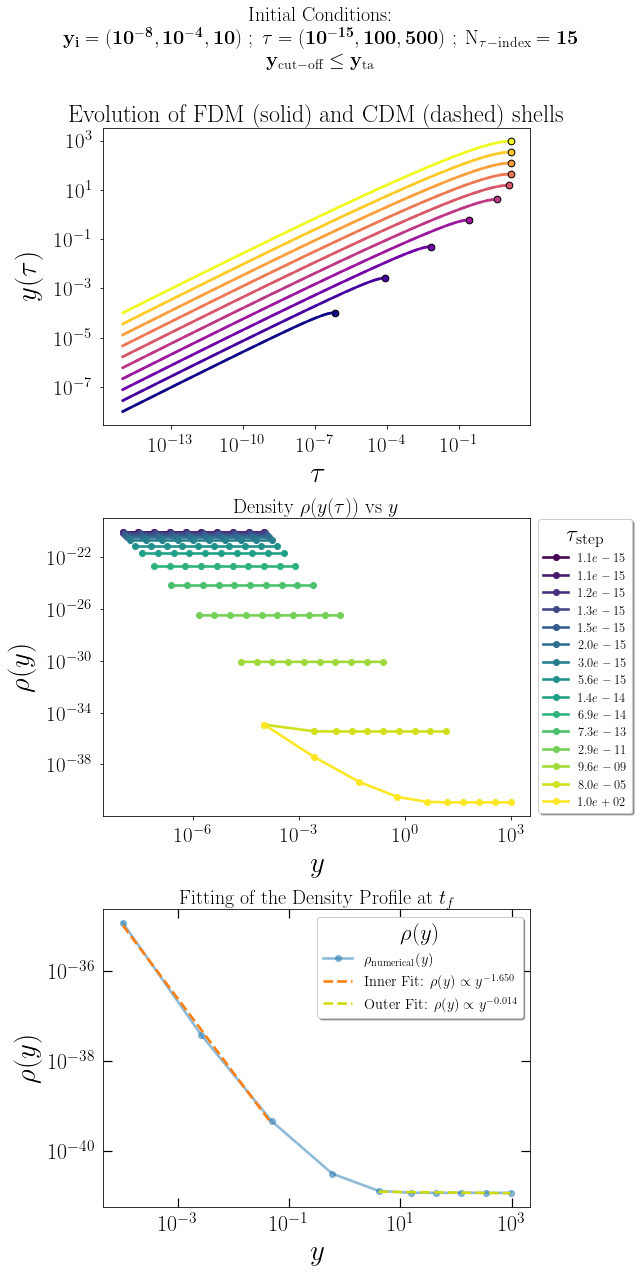

 Fitted slope (inner core):    \rho(y) \propto y^{-1.650}
 Fitted slope (outer tail):    \rho(y) \propto y^{-0.014}


In [6]:
# for 10 FDM shells

t_i, t_f = 1e-15, 1e2
N = 10
r_min, r_max = 1e-8, 1e-4
ri_arr = np.geomspace(r_min, r_max, N)
initial_density = 1e-20


delta_M_arr = shells_mass(ri_arr, N, initial_density)
QP = True
gravity = True
Hubble = True


t_step = 500
t_arr = np.geomspace(t_i, t_f, t_step)
dt = np.gradient(t_arr)

r_sol = np.zeros((N, len(t_arr)))
v_sol = np.zeros((N, len(t_arr)))
rho_sol = np.zeros((N, len(t_arr)))
mask_active = np.ones(N, dtype=bool)
cutoff_index = np.full(N, len(t_arr))
t_ta_arr = np.full(N, np.nan)
r_ta_arr = np.full(N, np.nan)
turnaround_detected = np.zeros(N, dtype=bool)
r_sol[:, 0] = ri_arr
v_sol[:, 0] = ri_arr/(2 * t_arr[0])




freeze_fraction= 1
r_sol, v_sol, rho_sol, QP_arr, cutoff_index, r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask = shells_evolution(N, t_arr, dt, ri_arr, Hubble, gravity, QP, freeze_fraction)
time_indices = np.geomspace(1, t_step-1 , 15, dtype=int)




fig, axs = plt.subplots(3, 1, figsize=(9, 18), sharex=False)
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
colors_shell = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
colors1 = cm.viridis(np.linspace(0, 1, len(time_indices)))
colors2 = cm.plasma(np.linspace(0, 1, N))
colors3 = cm.magma(np.linspace(0, 1, len(time_indices)))



#------------------------------------------------------
ax = axs[0]


QP = False
gravity = True
Hubble = True
r_sol_no_qp, v_sol_no_qp, rho_sol_no_qp, QP_arr_no_qp, cutoff_index_no_qp,  r_ta_arr_no_qp, t_ta_arr_no_qp, rho_arr_no_qp, rta_mask_no_qp, tta_mask_no_qp = shells_evolution(N, t_arr, dt, ri_arr,  
Hubble, gravity, QP, freeze_fraction)


for j in range(N):
    cutoff = cutoff_index_no_qp[j]
    ax.loglog(t_arr[:cutoff], r_sol_no_qp[j, :cutoff], color=colors2[j], linestyle='--', alpha=0.7)
    if not np.isnan(t_ta_arr_no_qp[j]):
        ax.scatter(t_ta_arr_no_qp[j], r_ta_arr_no_qp[j], marker='o', s=30, color=colors2[j], edgecolor='k', alpha=0.3)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol_no_qp[j, cutoff - 1], marker='x', s=35, color=colors_shell[j], alpha=0.3)

# Plot FDM shells (with QP) with solid lines
for j in range(N):
    cutoff = cutoff_index[j]
    ax.loglog(t_arr[:cutoff], r_sol[j, :cutoff], color=colors2[j], linestyle='-', alpha=1.0, label=fr'${ri_arr[j]:.1e}$')
    if not np.isnan(t_ta_arr[j]):
        ax.scatter(t_ta_arr[j], r_ta_arr[j], marker='o', s=45, color=colors2[j], edgecolor='k', zorder=5)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol[j, cutoff - 1], marker='x', s=50, color=colors_shell[j], zorder=5)

# Labels, title and legend
ax.set_xlabel(r'$\tau$', fontsize=29, labelpad=6)
ax.set_ylabel(r'$y(\tau)$', fontsize=29, labelpad=11)
ax.set_title('Evolution of FDM (solid) and CDM (dashed) shells', fontsize=24)
ax.tick_params(axis='x', labelsize=21, pad=7.9)
ax.tick_params(axis='y', labelsize=21, pad=7.9)

#handles, labels = ax.get_legend_handles_labels()
#legend_shells = ax.legend(handles[:7], labels[:7], prop={'size': 12.5},
                        #  loc=(1.02, 0.13), shadow=True, title='$y_{i}$', title_fontsize=27,
                        #  facecolor='white', fontsize=25)

#legend_lines = [Line2D([0], [0], color='k', linestyle='-', lw=2),
               # Line2D([0], [0], color='k', linestyle='--', lw=2)]
#ax.legend(legend_lines, ['FDM', 'CDM'], prop={'size': 15.5}, loc=(1.02, 0.64),
         # shadow=True, title='Shell', title_fontsize=23,
         # facecolor='white', fontsize=20)
#ax.add_artist(legend_shells)









#----------------------------------------------------------
#Density vs time at different time steps


ax = axs[1]
for i, idx in enumerate(time_indices):
    r_at_time_index = r_sol[:, idx]
    rho_at_time_index = rho_sol[:, idx]
    ax.loglog(r_at_time_index, rho_at_time_index, marker='o', label=r'$ {0:.1e}$'.format(t_arr[idx]), color=colors1[i])


ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)  
#ax.text(5, 1e-24, '$y_i = (10^{-8}, 10^{-4}, 7)$', fontsize = 18)
#ax.text(5, 1e-27, '$N_\mathrm{time-indices} = 15$', fontsize = 18)
ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 11)
ax.legend( prop = {'size':12.5},loc = (1.02, 0.01),shadow = True, title = r'$\tau_\mathrm{step}$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 23)
ax.set_title(r'Density Profile at Different times steps', fontsize= 24)
ax.set_title(r' Density $\rho(y(\tau))$ vs $y$ ', fontsize=20)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 



#--------------------------------------------------------------------------------



###################################
# Fitting the density profile
ax = axs[2]


def f_fitting(x, m, b):
    return (m*x) + b


final_idx = -1
r_final = r_sol[:, final_idx]
rho_final = rho_sol[:, final_idx]
mask = (r_final > 0) & (rho_final > 0)
r_valid = r_final[mask]
rho_valid = rho_final[mask]


# Sort by radius
sorted_idx = np.argsort(r_valid)
r_valid = r_valid[sorted_idx]
rho_valid = rho_valid[sorted_idx]

# Define regions
inner_N = 3
outer_N = 6

# Inner region
r_inner = r_valid[:inner_N]
rho_inner = rho_valid[:inner_N]
log_r_inner = np.log10(r_inner)
log_rho_inner = np.log10(rho_inner)
popt_inner, _ = curve_fit(f_fitting, log_r_inner, log_rho_inner)
m_inner, b_inner = popt_inner
rho_fit_inner = 10**f_fitting(log_r_inner, *popt_inner)


# Outer region
r_outer = r_valid[-outer_N:]
rho_outer = rho_valid[-outer_N:]
log_r_outer = np.log10(r_outer)
log_rho_outer = np.log10(rho_outer)
popt_outer, _ = curve_fit(f_fitting, log_r_outer, log_rho_outer)
m_outer, b_outer = popt_outer
rho_fit_outer = 10**f_fitting(log_r_outer, *popt_outer)




ax.loglog(r_valid, rho_valid, 'o-', color='C0', alpha = 0.5)
ax.loglog(r_inner, rho_fit_inner, '--', color='C1')
#ax.loglog(r_middle, rho_fit_middle, '--', color='C3')
ax.loglog(r_outer, rho_fit_outer, '--', color='#d0db0b')


#plt.text(1e-14, 1e-45, '$y_i = (10^{-8}, 10^{-4}, 10)$', fontsize=18)
#plt.text(1e-14, 1e-49, '$(t_i, t_f, t_\\mathrm{steps}) = (10^{-15}, 10^{5}, 10000)$', fontsize=15)

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)

ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=22) 
ax.yaxis.set_tick_params(labelsize=22) 

ax.set_title('Fitting of the Density Profile at $t_f$', fontsize=20)
ax.legend([r'$\rho_\mathrm{numerical}(y)$', fr'Inner Fit: $\rho(y) \propto y^{{{m_inner:.3f}}}$',
           
           fr'Outer Fit: $\rho(y) \propto y^{{{m_outer:.3f}}}$'], 
           prop = {'size':14.5},loc = 'upper right', shadow = True, 
           title = r'$\rho(y)$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 31)




#---------------------------------------------------------------------



plt.suptitle(r'Initial Conditions:' + '\n' + 
    r'$\mathbf{y_i = (10^{-8}, 10^{-4}, 10)\; ;\;\tau = (10^{-15}, 100, 500)\; ;\;\mathrm{N_{\tau-index}} = 15}$'
              '\n' + r'$\mathbf{y_\mathrm{cut-off} \leq  y_\mathrm{ta}}$' , fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('rho&qp_N10_t500.pdf', bbox_inches='tight')
plt.show()



#--------------------------------------------------------------------

print(fr' Fitted slope (inner core):    \rho(y) \propto y^{{{m_inner:.3f}}}')
print(fr' Fitted slope (outer tail):    \rho(y) \propto y^{{{m_outer:.3f}}}')





np.savez('fdm_cdm_N10_t500_rta.npz',
         # FDM arrays
         r_sol_fdm=r_sol,
         v_sol_fdm=v_sol,
         rho_sol_fdm=rho_sol,
         QP_arr_fdm= QP_arr,
         cutoff_index_fdm=cutoff_index,
         r_ta_arr_fdm=r_ta_arr,
         t_ta_arr_fdm=t_ta_arr,
         rho_arr_fdm = rho_arr,
         rta_mask_fdm = rta_mask,
         tta_mask_fdm = tta_mask,
         
         
         # CDM arrays
         r_sol_cdm=r_sol_no_qp,
         v_sol_cdm=v_sol_no_qp,
         rho_sol_cdm=rho_sol_no_qp,
         QP_arr_cdm= QP_arr_no_qp,
         cutoff_index_cdm=cutoff_index_no_qp,
         r_ta_arr_cdm=r_ta_arr_no_qp,
         t_ta_arr_cdm=t_ta_arr_no_qp,
         rho_arr_cdm = rho_arr_no_qp,
         rta_mask_cdm = rta_mask_no_qp,
         tta_mask_cdm = tta_mask_no_qp)



No shells crossings is detected.


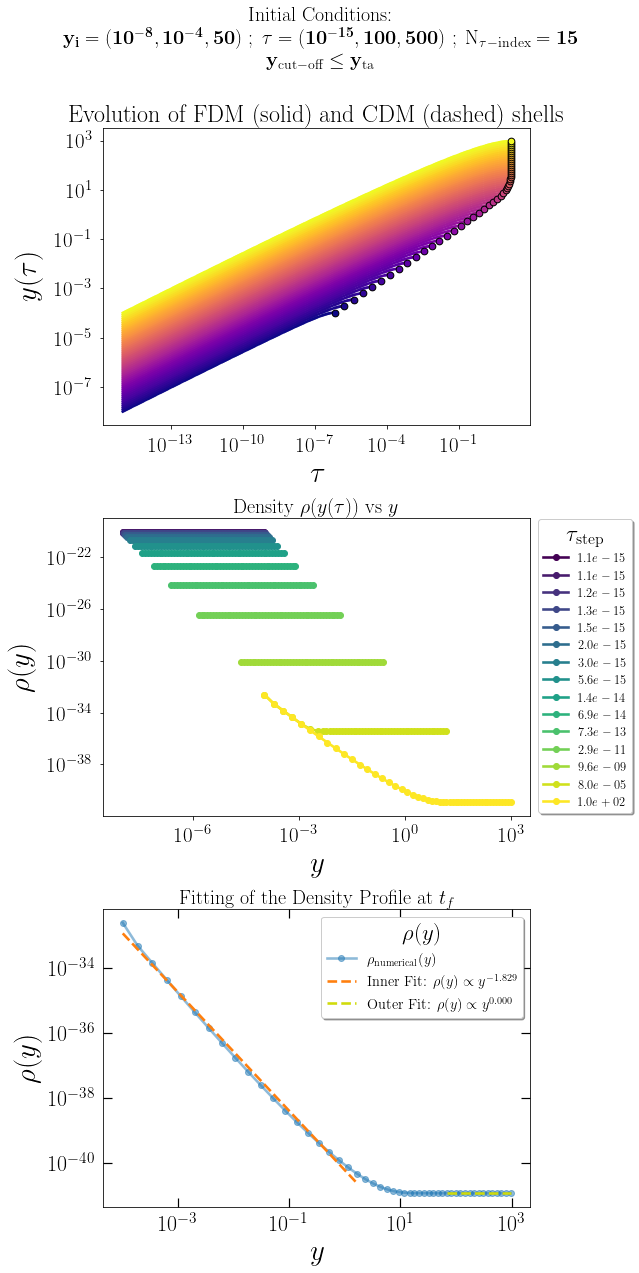

 Fitted slope (inner core):    \rho(y) \propto y^{-1.829}
 Fitted slope (outer tail):    \rho(y) \propto y^{0.000}


In [9]:
# for 50 FDM shells

t_i, t_f = 1e-15, 1e2
N = 50
r_min, r_max = 1e-8, 1e-4
ri_arr = np.geomspace(r_min, r_max, N)
initial_density = 1e-20


delta_M_arr = shells_mass(ri_arr, N, initial_density)
QP = True
gravity = True
Hubble = True


t_step = 500
t_arr = np.geomspace(t_i, t_f, t_step)
dt = np.gradient(t_arr)

r_sol = np.zeros((N, len(t_arr)))
v_sol = np.zeros((N, len(t_arr)))
rho_sol = np.zeros((N, len(t_arr)))
mask_active = np.ones(N, dtype=bool)
cutoff_index = np.full(N, len(t_arr))
t_ta_arr = np.full(N, np.nan)
r_ta_arr = np.full(N, np.nan)
turnaround_detected = np.zeros(N, dtype=bool)
r_sol[:, 0] = ri_arr
v_sol[:, 0] = ri_arr/(2 * t_arr[0])




freeze_fraction= 1
r_sol, v_sol, rho_sol, QP_arr, cutoff_index, r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask = shells_evolution(N, t_arr, dt, ri_arr, Hubble, gravity, QP, freeze_fraction)
time_indices = np.geomspace(1, t_step-1 , 15, dtype=int)




fig, axs = plt.subplots(3, 1, figsize=(9, 18), sharex=False)
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
colors_shell = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
colors1 = cm.viridis(np.linspace(0, 1, len(time_indices)))
colors2 = cm.plasma(np.linspace(0, 1, N))
colors3 = cm.magma(np.linspace(0, 1, len(time_indices)))



#------------------------------------------------------
ax = axs[0]


QP = False
gravity = True
Hubble = True
r_sol_no_qp, v_sol_no_qp, rho_sol_no_qp, QP_arr_no_qp, cutoff_index_no_qp,  r_ta_arr_no_qp, t_ta_arr_no_qp, rho_arr_no_qp, rta_mask_no_qp, tta_mask_no_qp = shells_evolution(N, t_arr, dt, ri_arr,  
Hubble, gravity, QP, freeze_fraction)


for j in range(N):
    cutoff = cutoff_index_no_qp[j]
    ax.loglog(t_arr[:cutoff], r_sol_no_qp[j, :cutoff], color=colors2[j], linestyle='--', alpha=0.7)
    if not np.isnan(t_ta_arr_no_qp[j]):
        ax.scatter(t_ta_arr_no_qp[j], r_ta_arr_no_qp[j], marker='o', s=30, color=colors2[j], edgecolor='k', alpha=0.3)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol_no_qp[j, cutoff - 1], marker='x', s=35, color=colors_shell[j], alpha=0.3)

# Plot FDM shells (with QP) with solid lines
for j in range(N):
    cutoff = cutoff_index[j]
    ax.loglog(t_arr[:cutoff], r_sol[j, :cutoff], color=colors2[j], linestyle='-', alpha=1.0, label=fr'${ri_arr[j]:.1e}$')
    if not np.isnan(t_ta_arr[j]):
        ax.scatter(t_ta_arr[j], r_ta_arr[j], marker='o', s=45, color=colors2[j], edgecolor='k', zorder=5)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol[j, cutoff - 1], marker='x', s=50, color=colors_shell[j], zorder=5)

# Labels, title and legend
ax.set_xlabel(r'$\tau$', fontsize=29, labelpad=6)
ax.set_ylabel(r'$y(\tau)$', fontsize=29, labelpad=11)
ax.set_title('Evolution of FDM (solid) and CDM (dashed) shells', fontsize=24)
ax.tick_params(axis='x', labelsize=21, pad=7.9)
ax.tick_params(axis='y', labelsize=21, pad=7.9)

#handles, labels = ax.get_legend_handles_labels()
#legend_shells = ax.legend(handles[:7], labels[:7], prop={'size': 12.5},
                        #  loc=(1.02, 0.13), shadow=True, title='$y_{i}$', title_fontsize=27,
                        #  facecolor='white', fontsize=25)

#legend_lines = [Line2D([0], [0], color='k', linestyle='-', lw=2),
               # Line2D([0], [0], color='k', linestyle='--', lw=2)]
#ax.legend(legend_lines, ['FDM', 'CDM'], prop={'size': 15.5}, loc=(1.02, 0.64),
         # shadow=True, title='Shell', title_fontsize=23,
         # facecolor='white', fontsize=20)
#ax.add_artist(legend_shells)









#----------------------------------------------------------
#Density vs time at different time steps


ax = axs[1]
for i, idx in enumerate(time_indices):
    r_at_time_index = r_sol[:, idx]
    rho_at_time_index = rho_sol[:, idx]
    ax.loglog(r_at_time_index, rho_at_time_index, marker='o', label=r'$ {0:.1e}$'.format(t_arr[idx]), color=colors1[i])


ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)  
#ax.text(5, 1e-24, '$y_i = (10^{-8}, 10^{-4}, 7)$', fontsize = 18)
#ax.text(5, 1e-27, '$N_\mathrm{time-indices} = 15$', fontsize = 18)
ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 11)
ax.legend( prop = {'size':12.5},loc = (1.02, 0.01),shadow = True, title = r'$\tau_\mathrm{step}$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 23)
ax.set_title(r'Density Profile at Different times steps', fontsize= 24)
ax.set_title(r' Density $\rho(y(\tau))$ vs $y$ ', fontsize=20)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 



#--------------------------------------------------------------------------------



###################################
# Fitting the density profile
ax = axs[2]


def f_fitting(x, m, b):
    return (m*x) + b


final_idx = -1
r_final = r_sol[:, final_idx]
rho_final = rho_sol[:, final_idx]
mask = (r_final > 0) & (rho_final > 0)
r_valid = r_final[mask]
rho_valid = rho_final[mask]


# Sort by radius
sorted_idx = np.argsort(r_valid)
r_valid = r_valid[sorted_idx]
rho_valid = rho_valid[sorted_idx]

# Define regions
inner_N = 20
outer_N = 15

# Inner region
r_inner = r_valid[:inner_N]
rho_inner = rho_valid[:inner_N]
log_r_inner = np.log10(r_inner)
log_rho_inner = np.log10(rho_inner)
popt_inner, _ = curve_fit(f_fitting, log_r_inner, log_rho_inner)
m_inner, b_inner = popt_inner
rho_fit_inner = 10**f_fitting(log_r_inner, *popt_inner)


# Outer region
r_outer = r_valid[-outer_N:]
rho_outer = rho_valid[-outer_N:]
log_r_outer = np.log10(r_outer)
log_rho_outer = np.log10(rho_outer)
popt_outer, _ = curve_fit(f_fitting, log_r_outer, log_rho_outer)
m_outer, b_outer = popt_outer
rho_fit_outer = 10**f_fitting(log_r_outer, *popt_outer)




ax.loglog(r_valid, rho_valid, 'o-', color='C0', alpha = 0.5)
ax.loglog(r_inner, rho_fit_inner, '--', color='C1')
#ax.loglog(r_middle, rho_fit_middle, '--', color='C3')
ax.loglog(r_outer, rho_fit_outer, '--', color='#d0db0b')


#plt.text(1e-14, 1e-45, '$y_i = (10^{-8}, 10^{-4}, 10)$', fontsize=18)
#plt.text(1e-14, 1e-49, '$(t_i, t_f, t_\\mathrm{steps}) = (10^{-15}, 10^{5}, 10000)$', fontsize=15)

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)

ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=22) 
ax.yaxis.set_tick_params(labelsize=22) 

ax.set_title('Fitting of the Density Profile at $t_f$', fontsize=20)
ax.legend([r'$\rho_\mathrm{numerical}(y)$', fr'Inner Fit: $\rho(y) \propto y^{{{m_inner:.3f}}}$',
           
           fr'Outer Fit: $\rho(y) \propto y^{{{m_outer:.3f}}}$'], 
           prop = {'size':14.5},loc = 'upper right', shadow = True, 
           title = r'$\rho(y)$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 31)




#---------------------------------------------------------------------



plt.suptitle(r'Initial Conditions:' + '\n' + 
    r'$\mathbf{y_i = (10^{-8}, 10^{-4}, 50)\; ;\;\tau = (10^{-15}, 100, 500)\; ;\;\mathrm{N_{\tau-index}} = 15}$'
              '\n' + r'$\mathbf{y_\mathrm{cut-off} \leq  y_\mathrm{ta}}$' , fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('rho&qp_N50_t500.pdf', bbox_inches='tight')
plt.show()



#--------------------------------------------------------------------

print(fr' Fitted slope (inner core):    \rho(y) \propto y^{{{m_inner:.3f}}}')
print(fr' Fitted slope (outer tail):    \rho(y) \propto y^{{{m_outer:.3f}}}')





np.savez('fdm_cdm_N50_t500_rta.npz',
         # FDM arrays
         r_sol_fdm=r_sol,
         v_sol_fdm=v_sol,
         rho_sol_fdm=rho_sol,
         QP_arr_fdm= QP_arr,
         cutoff_index_fdm=cutoff_index,
         r_ta_arr_fdm=r_ta_arr,
         t_ta_arr_fdm=t_ta_arr,
         rho_arr_fdm = rho_arr,
         rta_mask_fdm = rta_mask,
         tta_mask_fdm = tta_mask,
         
         
         # CDM arrays
         r_sol_cdm=r_sol_no_qp,
         v_sol_cdm=v_sol_no_qp,
         rho_sol_cdm=rho_sol_no_qp,
         QP_arr_cdm= QP_arr_no_qp,
         cutoff_index_cdm=cutoff_index_no_qp,
         r_ta_arr_cdm=r_ta_arr_no_qp,
         t_ta_arr_cdm=t_ta_arr_no_qp,
         rho_arr_cdm = rho_arr_no_qp,
         rta_mask_cdm = rta_mask_no_qp,
         tta_mask_cdm = tta_mask_no_qp)



No shells crossings is detected.


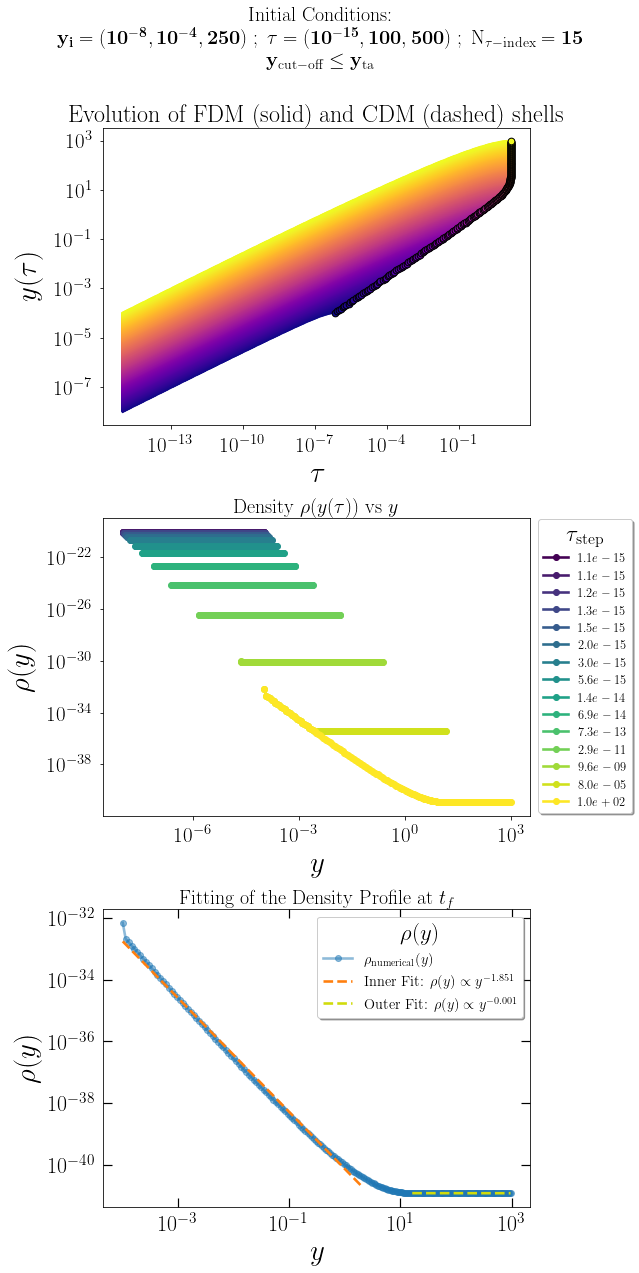

 Fitted slope (inner core):    \rho(y) \propto y^{-1.851}
 Fitted slope (outer tail):    \rho(y) \propto y^{-0.001}


In [12]:
# for 250 FDM shells

t_i, t_f = 1e-15, 1e2
N = 250
r_min, r_max = 1e-8, 1e-4
ri_arr = np.geomspace(r_min, r_max, N)
initial_density = 1e-20


delta_M_arr = shells_mass(ri_arr, N, initial_density)
QP = True
gravity = True
Hubble = True


t_step = 500
t_arr = np.geomspace(t_i, t_f, t_step)
dt = np.gradient(t_arr)

r_sol = np.zeros((N, len(t_arr)))
v_sol = np.zeros((N, len(t_arr)))
rho_sol = np.zeros((N, len(t_arr)))
mask_active = np.ones(N, dtype=bool)
cutoff_index = np.full(N, len(t_arr))
t_ta_arr = np.full(N, np.nan)
r_ta_arr = np.full(N, np.nan)
turnaround_detected = np.zeros(N, dtype=bool)
r_sol[:, 0] = ri_arr
v_sol[:, 0] = ri_arr/(2 * t_arr[0])




freeze_fraction= 1
r_sol, v_sol, rho_sol, QP_arr, cutoff_index, r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask = shells_evolution(N, t_arr, dt, ri_arr, Hubble, gravity, QP, freeze_fraction)
time_indices = np.geomspace(1, t_step-1 , 15, dtype=int)




fig, axs = plt.subplots(3, 1, figsize=(9, 18), sharex=False)
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
colors_shell = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
colors1 = cm.viridis(np.linspace(0, 1, len(time_indices)))
colors2 = cm.plasma(np.linspace(0, 1, N))
colors3 = cm.magma(np.linspace(0, 1, len(time_indices)))



#------------------------------------------------------
ax = axs[0]


QP = False
gravity = True
Hubble = True
r_sol_no_qp, v_sol_no_qp, rho_sol_no_qp, QP_arr_no_qp, cutoff_index_no_qp,  r_ta_arr_no_qp, t_ta_arr_no_qp, rho_arr_no_qp, rta_mask_no_qp, tta_mask_no_qp = shells_evolution(N, t_arr, dt, ri_arr,  
Hubble, gravity, QP, freeze_fraction)


for j in range(N):
    cutoff = cutoff_index_no_qp[j]
    ax.loglog(t_arr[:cutoff], r_sol_no_qp[j, :cutoff], color=colors2[j], linestyle='--', alpha=0.7)
    if not np.isnan(t_ta_arr_no_qp[j]):
        ax.scatter(t_ta_arr_no_qp[j], r_ta_arr_no_qp[j], marker='o', s=30, color=colors2[j], edgecolor='k', alpha=0.3)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol_no_qp[j, cutoff - 1], marker='x', s=35, color=colors_shell[j], alpha=0.3)

# Plot FDM shells (with QP) with solid lines
for j in range(N):
    cutoff = cutoff_index[j]
    ax.loglog(t_arr[:cutoff], r_sol[j, :cutoff], color=colors2[j], linestyle='-', alpha=1.0, label=fr'${ri_arr[j]:.1e}$')
    if not np.isnan(t_ta_arr[j]):
        ax.scatter(t_ta_arr[j], r_ta_arr[j], marker='o', s=45, color=colors2[j], edgecolor='k', zorder=5)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol[j, cutoff - 1], marker='x', s=50, color=colors_shell[j], zorder=5)

# Labels, title and legend
ax.set_xlabel(r'$\tau$', fontsize=29, labelpad=6)
ax.set_ylabel(r'$y(\tau)$', fontsize=29, labelpad=11)
ax.set_title('Evolution of FDM (solid) and CDM (dashed) shells', fontsize=24)
ax.tick_params(axis='x', labelsize=21, pad=7.9)
ax.tick_params(axis='y', labelsize=21, pad=7.9)

#handles, labels = ax.get_legend_handles_labels()
#legend_shells = ax.legend(handles[:7], labels[:7], prop={'size': 12.5},
                        #  loc=(1.02, 0.13), shadow=True, title='$y_{i}$', title_fontsize=27,
                        #  facecolor='white', fontsize=25)

#legend_lines = [Line2D([0], [0], color='k', linestyle='-', lw=2),
               # Line2D([0], [0], color='k', linestyle='--', lw=2)]
#ax.legend(legend_lines, ['FDM', 'CDM'], prop={'size': 15.5}, loc=(1.02, 0.64),
         # shadow=True, title='Shell', title_fontsize=23,
         # facecolor='white', fontsize=20)
#ax.add_artist(legend_shells)









#----------------------------------------------------------
#Density vs time at different time steps


ax = axs[1]
for i, idx in enumerate(time_indices):
    r_at_time_index = r_sol[:, idx]
    rho_at_time_index = rho_sol[:, idx]
    ax.loglog(r_at_time_index, rho_at_time_index, marker='o', label=r'$ {0:.1e}$'.format(t_arr[idx]), color=colors1[i])


ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)  
#ax.text(5, 1e-24, '$y_i = (10^{-8}, 10^{-4}, 7)$', fontsize = 18)
#ax.text(5, 1e-27, '$N_\mathrm{time-indices} = 15$', fontsize = 18)
ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 11)
ax.legend( prop = {'size':12.5},loc = (1.02, 0.01),shadow = True, title = r'$\tau_\mathrm{step}$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 23)
ax.set_title(r'Density Profile at Different times steps', fontsize= 24)
ax.set_title(r' Density $\rho(y(\tau))$ vs $y$ ', fontsize=20)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 



#--------------------------------------------------------------------------------



###################################
# Fitting the density profile
ax = axs[2]


def f_fitting(x, m, b):
    return (m*x) + b


final_idx = -1
r_final = r_sol[:, final_idx]
rho_final = rho_sol[:, final_idx]
mask = (r_final > 0) & (rho_final > 0)
r_valid = r_final[mask]
rho_valid = rho_final[mask]


# Sort by radius
sorted_idx = np.argsort(r_valid)
r_valid = r_valid[sorted_idx]
rho_valid = rho_valid[sorted_idx]

# Define regions
inner_N = 100
outer_N = 110

# Inner region
r_inner = r_valid[:inner_N]
rho_inner = rho_valid[:inner_N]
log_r_inner = np.log10(r_inner)
log_rho_inner = np.log10(rho_inner)
popt_inner, _ = curve_fit(f_fitting, log_r_inner, log_rho_inner)
m_inner, b_inner = popt_inner
rho_fit_inner = 10**f_fitting(log_r_inner, *popt_inner)


# Outer region
r_outer = r_valid[-outer_N:]
rho_outer = rho_valid[-outer_N:]
log_r_outer = np.log10(r_outer)
log_rho_outer = np.log10(rho_outer)
popt_outer, _ = curve_fit(f_fitting, log_r_outer, log_rho_outer)
m_outer, b_outer = popt_outer
rho_fit_outer = 10**f_fitting(log_r_outer, *popt_outer)




ax.loglog(r_valid, rho_valid, 'o-', color='C0', alpha = 0.5)
ax.loglog(r_inner, rho_fit_inner, '--', color='C1')
#ax.loglog(r_middle, rho_fit_middle, '--', color='C3')
ax.loglog(r_outer, rho_fit_outer, '--', color='#d0db0b')


#plt.text(1e-14, 1e-45, '$y_i = (10^{-8}, 10^{-4}, 10)$', fontsize=18)
#plt.text(1e-14, 1e-49, '$(t_i, t_f, t_\\mathrm{steps}) = (10^{-15}, 10^{5}, 10000)$', fontsize=15)

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)

ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=22) 
ax.yaxis.set_tick_params(labelsize=22) 

ax.set_title('Fitting of the Density Profile at $t_f$', fontsize=20)
ax.legend([r'$\rho_\mathrm{numerical}(y)$', fr'Inner Fit: $\rho(y) \propto y^{{{m_inner:.3f}}}$',
           
           fr'Outer Fit: $\rho(y) \propto y^{{{m_outer:.3f}}}$'], 
           prop = {'size':14.5},loc = 'upper right', shadow = True, 
           title = r'$\rho(y)$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 31)




#---------------------------------------------------------------------



plt.suptitle(r'Initial Conditions:' + '\n' + 
    r'$\mathbf{y_i = (10^{-8}, 10^{-4}, 250)\; ;\;\tau = (10^{-15}, 100, 500)\; ;\;\mathrm{N_{\tau-index}} = 15}$'
              '\n' + r'$\mathbf{y_\mathrm{cut-off} \leq  y_\mathrm{ta}}$' , fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('rho&qp_N250_t500.pdf', bbox_inches='tight')
plt.show()



#--------------------------------------------------------------------

print(fr' Fitted slope (inner core):    \rho(y) \propto y^{{{m_inner:.3f}}}')
print(fr' Fitted slope (outer tail):    \rho(y) \propto y^{{{m_outer:.3f}}}')





np.savez('fdm_cdm_N250_t500_rta.npz',
         # FDM arrays
         r_sol_fdm=r_sol,
         v_sol_fdm=v_sol,
         rho_sol_fdm=rho_sol,
         QP_arr_fdm= QP_arr,
         cutoff_index_fdm=cutoff_index,
         r_ta_arr_fdm=r_ta_arr,
         t_ta_arr_fdm=t_ta_arr,
         rho_arr_fdm = rho_arr,
         rta_mask_fdm = rta_mask,
         tta_mask_fdm = tta_mask,
         
         
         # CDM arrays
         r_sol_cdm=r_sol_no_qp,
         v_sol_cdm=v_sol_no_qp,
         rho_sol_cdm=rho_sol_no_qp,
         QP_arr_cdm= QP_arr_no_qp,
         cutoff_index_cdm=cutoff_index_no_qp,
         r_ta_arr_cdm=r_ta_arr_no_qp,
         t_ta_arr_cdm=t_ta_arr_no_qp,
         rho_arr_cdm = rho_arr_no_qp,
         rta_mask_cdm = rta_mask_no_qp,
         tta_mask_cdm = tta_mask_no_qp)



No shells crossings is detected.


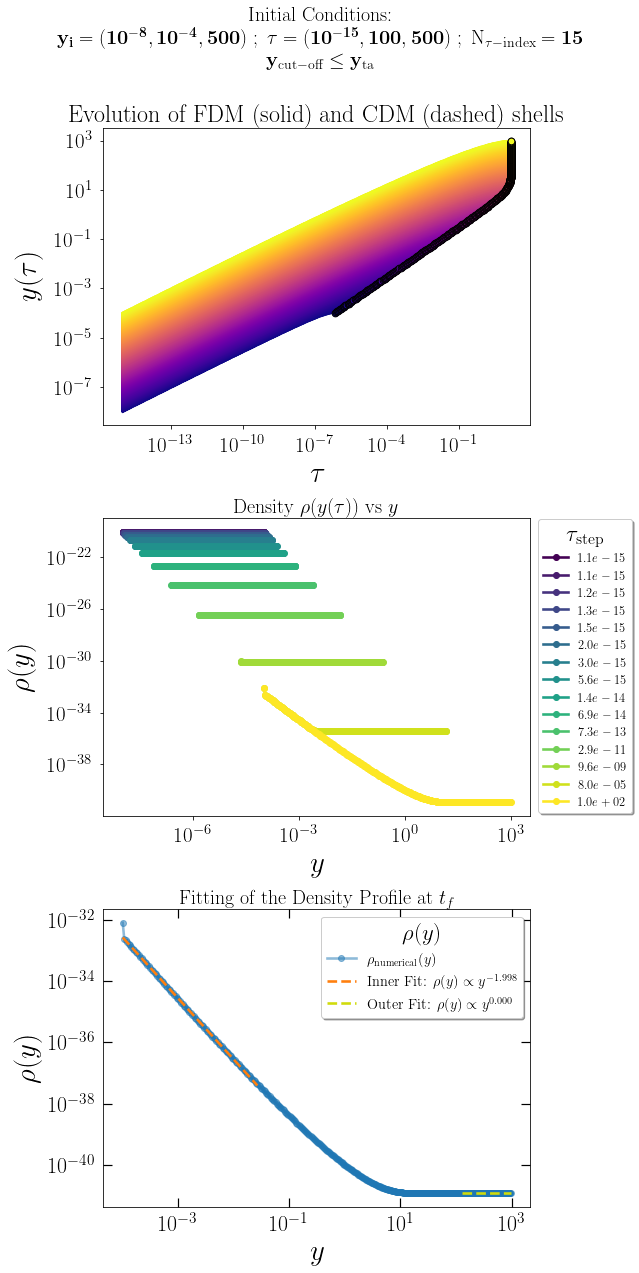

 Fitted slope (inner core):    \rho(y) \propto y^{-1.998}
 Fitted slope (outer tail):    \rho(y) \propto y^{0.000}


In [21]:
# for 500 FDM shells

t_i, t_f = 1e-15, 1e2
N = 500
r_min, r_max = 1e-8, 1e-4
ri_arr = np.geomspace(r_min, r_max, N)
initial_density = 1e-20


delta_M_arr = shells_mass(ri_arr, N, initial_density)
QP = True
gravity = True
Hubble = True


t_step = 500
t_arr = np.geomspace(t_i, t_f, t_step)
dt = np.gradient(t_arr)

r_sol = np.zeros((N, len(t_arr)))
v_sol = np.zeros((N, len(t_arr)))
rho_sol = np.zeros((N, len(t_arr)))
mask_active = np.ones(N, dtype=bool)
cutoff_index = np.full(N, len(t_arr))
t_ta_arr = np.full(N, np.nan)
r_ta_arr = np.full(N, np.nan)
turnaround_detected = np.zeros(N, dtype=bool)
r_sol[:, 0] = ri_arr
v_sol[:, 0] = ri_arr/(2 * t_arr[0])




freeze_fraction= 1
r_sol, v_sol, rho_sol, QP_arr, cutoff_index, r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask = shells_evolution(N, t_arr, dt, ri_arr, Hubble, gravity, QP, freeze_fraction)
time_indices = np.geomspace(1, t_step-1 , 15, dtype=int)




fig, axs = plt.subplots(3, 1, figsize=(9, 18), sharex=False)
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
colors_shell = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
colors1 = cm.viridis(np.linspace(0, 1, len(time_indices)))
colors2 = cm.plasma(np.linspace(0, 1, N))
colors3 = cm.magma(np.linspace(0, 1, len(time_indices)))



#------------------------------------------------------
ax = axs[0]


QP = False
gravity = True
Hubble = True
r_sol_no_qp, v_sol_no_qp, rho_sol_no_qp, QP_arr_no_qp, cutoff_index_no_qp,  r_ta_arr_no_qp, t_ta_arr_no_qp, rho_arr_no_qp, rta_mask_no_qp, tta_mask_no_qp = shells_evolution(N, t_arr, dt, ri_arr,  
Hubble, gravity, QP, freeze_fraction)


for j in range(N):
    cutoff = cutoff_index_no_qp[j]
    ax.loglog(t_arr[:cutoff], r_sol_no_qp[j, :cutoff], color=colors2[j], linestyle='--', alpha=0.7)
    if not np.isnan(t_ta_arr_no_qp[j]):
        ax.scatter(t_ta_arr_no_qp[j], r_ta_arr_no_qp[j], marker='o', s=30, color=colors2[j], edgecolor='k', alpha=0.3)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol_no_qp[j, cutoff - 1], marker='x', s=35, color=colors_shell[j], alpha=0.3)

# Plot FDM shells (with QP) with solid lines
for j in range(N):
    cutoff = cutoff_index[j]
    ax.loglog(t_arr[:cutoff], r_sol[j, :cutoff], color=colors2[j], linestyle='-', alpha=1.0, label=fr'${ri_arr[j]:.1e}$')
    if not np.isnan(t_ta_arr[j]):
        ax.scatter(t_ta_arr[j], r_ta_arr[j], marker='o', s=45, color=colors2[j], edgecolor='k', zorder=5)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol[j, cutoff - 1], marker='x', s=50, color=colors_shell[j], zorder=5)

# Labels, title and legend
ax.set_xlabel(r'$\tau$', fontsize=29, labelpad=6)
ax.set_ylabel(r'$y(\tau)$', fontsize=29, labelpad=11)
ax.set_title('Evolution of FDM (solid) and CDM (dashed) shells', fontsize=24)
ax.tick_params(axis='x', labelsize=21, pad=7.9)
ax.tick_params(axis='y', labelsize=21, pad=7.9)

#handles, labels = ax.get_legend_handles_labels()
#legend_shells = ax.legend(handles[:7], labels[:7], prop={'size': 12.5},
                        #  loc=(1.02, 0.13), shadow=True, title='$y_{i}$', title_fontsize=27,
                        #  facecolor='white', fontsize=25)

#legend_lines = [Line2D([0], [0], color='k', linestyle='-', lw=2),
               # Line2D([0], [0], color='k', linestyle='--', lw=2)]
#ax.legend(legend_lines, ['FDM', 'CDM'], prop={'size': 15.5}, loc=(1.02, 0.64),
         # shadow=True, title='Shell', title_fontsize=23,
         # facecolor='white', fontsize=20)
#ax.add_artist(legend_shells)









#----------------------------------------------------------
#Density vs time at different time steps


ax = axs[1]
for i, idx in enumerate(time_indices):
    r_at_time_index = r_sol[:, idx]
    rho_at_time_index = rho_sol[:, idx]
    ax.loglog(r_at_time_index, rho_at_time_index, marker='o', label=r'$ {0:.1e}$'.format(t_arr[idx]), color=colors1[i])


ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)  
#ax.text(5, 1e-24, '$y_i = (10^{-8}, 10^{-4}, 7)$', fontsize = 18)
#ax.text(5, 1e-27, '$N_\mathrm{time-indices} = 15$', fontsize = 18)
ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 11)
ax.legend( prop = {'size':12.5},loc = (1.02, 0.01),shadow = True, title = r'$\tau_\mathrm{step}$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 23)
ax.set_title(r'Density Profile at Different times steps', fontsize= 24)
ax.set_title(r' Density $\rho(y(\tau))$ vs $y$ ', fontsize=20)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 



#--------------------------------------------------------------------------------



###################################
# Fitting the density profile
ax = axs[2]


def f_fitting(x, m, b):
    return (m*x) + b


final_idx = -1
r_final = r_sol[:, final_idx]
rho_final = rho_sol[:, final_idx]
mask = (r_final > 0) & (rho_final > 0)
r_valid = r_final[mask]
rho_valid = rho_final[mask]


# Sort by radius
sorted_idx = np.argsort(r_valid)
r_valid = r_valid[sorted_idx]
rho_valid = rho_valid[sorted_idx]

# Define regions
inner_N = 100
outer_N = 110

# Inner region
r_inner = r_valid[:inner_N]
rho_inner = rho_valid[:inner_N]
log_r_inner = np.log10(r_inner)
log_rho_inner = np.log10(rho_inner)
popt_inner, _ = curve_fit(f_fitting, log_r_inner, log_rho_inner)
m_inner, b_inner = popt_inner
rho_fit_inner = 10**f_fitting(log_r_inner, *popt_inner)


# Outer region
r_outer = r_valid[-outer_N:]
rho_outer = rho_valid[-outer_N:]
log_r_outer = np.log10(r_outer)
log_rho_outer = np.log10(rho_outer)
popt_outer, _ = curve_fit(f_fitting, log_r_outer, log_rho_outer)
m_outer, b_outer = popt_outer
rho_fit_outer = 10**f_fitting(log_r_outer, *popt_outer)




ax.loglog(r_valid, rho_valid, 'o-', color='C0', alpha = 0.5)
ax.loglog(r_inner, rho_fit_inner, '--', color='C1')
#ax.loglog(r_middle, rho_fit_middle, '--', color='C3')
ax.loglog(r_outer, rho_fit_outer, '--', color='#d0db0b')


#plt.text(1e-14, 1e-45, '$y_i = (10^{-8}, 10^{-4}, 10)$', fontsize=18)
#plt.text(1e-14, 1e-49, '$(t_i, t_f, t_\\mathrm{steps}) = (10^{-15}, 10^{5}, 10000)$', fontsize=15)

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)

ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=22) 
ax.yaxis.set_tick_params(labelsize=22) 

ax.set_title('Fitting of the Density Profile at $t_f$', fontsize=20)
ax.legend([r'$\rho_\mathrm{numerical}(y)$', fr'Inner Fit: $\rho(y) \propto y^{{{m_inner:.3f}}}$',
           
           fr'Outer Fit: $\rho(y) \propto y^{{{m_outer:.3f}}}$'], 
           prop = {'size':14.5},loc = 'upper right', shadow = True, 
           title = r'$\rho(y)$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 31)




#---------------------------------------------------------------------



plt.suptitle(r'Initial Conditions:' + '\n' + 
    r'$\mathbf{y_i = (10^{-8}, 10^{-4}, 500)\; ;\;\tau = (10^{-15}, 100, 500)\; ;\;\mathrm{N_{\tau-index}} = 15}$'
              '\n' + r'$\mathbf{y_\mathrm{cut-off} \leq  y_\mathrm{ta}}$' , fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('rho&qp_N500_t500.pdf', bbox_inches='tight')
plt.show()



#--------------------------------------------------------------------

print(fr' Fitted slope (inner core):    \rho(y) \propto y^{{{m_inner:.3f}}}')
print(fr' Fitted slope (outer tail):    \rho(y) \propto y^{{{m_outer:.3f}}}')





np.savez('fdm_cdm_N500_t500_rta.npz',
         # FDM arrays
         r_sol_fdm=r_sol,
         v_sol_fdm=v_sol,
         rho_sol_fdm=rho_sol,
         QP_arr_fdm= QP_arr,
         cutoff_index_fdm=cutoff_index,
         r_ta_arr_fdm=r_ta_arr,
         t_ta_arr_fdm=t_ta_arr,
         rho_arr_fdm = rho_arr,
         rta_mask_fdm = rta_mask,
         tta_mask_fdm = tta_mask,
         
         
         # CDM arrays
         r_sol_cdm=r_sol_no_qp,
         v_sol_cdm=v_sol_no_qp,
         rho_sol_cdm=rho_sol_no_qp,
         QP_arr_cdm= QP_arr_no_qp,
         cutoff_index_cdm=cutoff_index_no_qp,
         r_ta_arr_cdm=r_ta_arr_no_qp,
         t_ta_arr_cdm=t_ta_arr_no_qp,
         rho_arr_cdm = rho_arr_no_qp,
         rta_mask_cdm = rta_mask_no_qp,
         tta_mask_cdm = tta_mask_no_qp)



No shells crossings is detected.


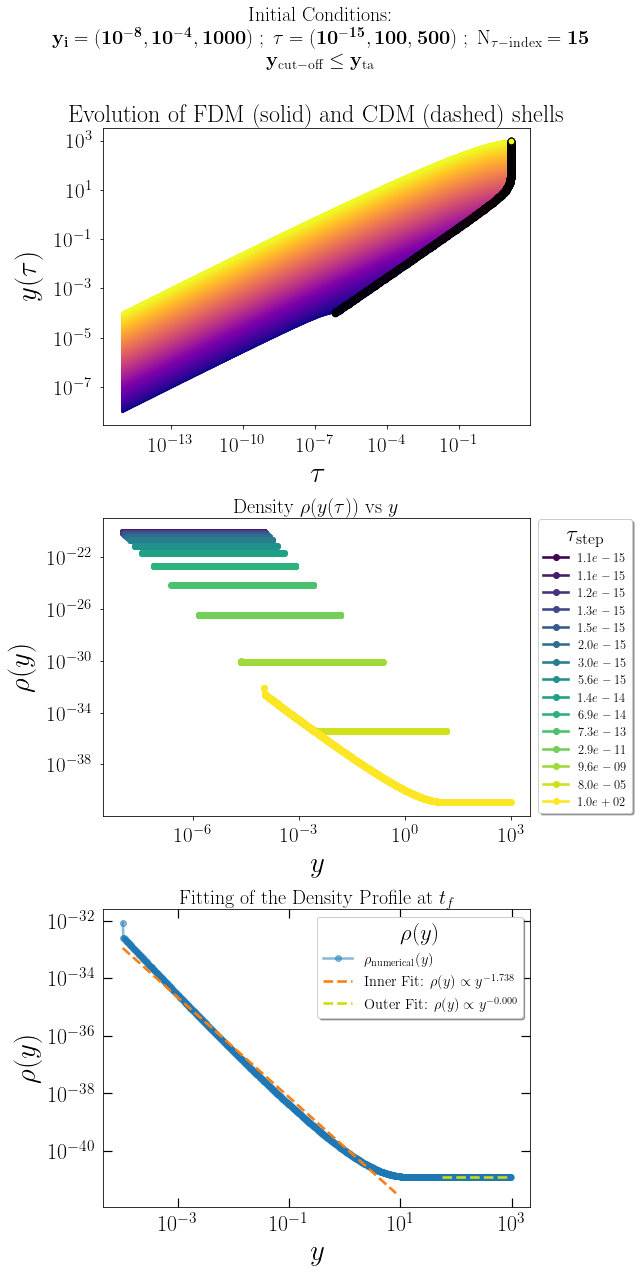

 Fitted slope (inner core):    \rho(y) \propto y^{-1.738}
 Fitted slope (outer tail):    \rho(y) \propto y^{-0.000}


In [29]:
# for 1000 FDM shells

t_i, t_f = 1e-15, 1e2
N = 1000
r_min, r_max = 1e-8, 1e-4
ri_arr = np.geomspace(r_min, r_max, N)
initial_density = 1e-20


delta_M_arr = shells_mass(ri_arr, N, initial_density)
QP = True
gravity = True
Hubble = True


t_step = 500
t_arr = np.geomspace(t_i, t_f, t_step)
dt = np.gradient(t_arr)

r_sol = np.zeros((N, len(t_arr)))
v_sol = np.zeros((N, len(t_arr)))
rho_sol = np.zeros((N, len(t_arr)))
mask_active = np.ones(N, dtype=bool)
cutoff_index = np.full(N, len(t_arr))
t_ta_arr = np.full(N, np.nan)
r_ta_arr = np.full(N, np.nan)
turnaround_detected = np.zeros(N, dtype=bool)
r_sol[:, 0] = ri_arr
v_sol[:, 0] = ri_arr/(2 * t_arr[0])




freeze_fraction= 1
r_sol, v_sol, rho_sol, QP_arr, cutoff_index, r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask = shells_evolution(N, t_arr, dt, ri_arr, Hubble, gravity, QP, freeze_fraction)
time_indices = np.geomspace(1, t_step-1 , 15, dtype=int)




fig, axs = plt.subplots(3, 1, figsize=(9, 18), sharex=False)
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
colors_shell = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
colors1 = cm.viridis(np.linspace(0, 1, len(time_indices)))
colors2 = cm.plasma(np.linspace(0, 1, N))
colors3 = cm.magma(np.linspace(0, 1, len(time_indices)))



#------------------------------------------------------
ax = axs[0]


QP = False
gravity = True
Hubble = True
r_sol_no_qp, v_sol_no_qp, rho_sol_no_qp, QP_arr_no_qp, cutoff_index_no_qp,  r_ta_arr_no_qp, t_ta_arr_no_qp, rho_arr_no_qp, rta_mask_no_qp, tta_mask_no_qp = shells_evolution(N, t_arr, dt, ri_arr,  
Hubble, gravity, QP, freeze_fraction)


for j in range(N):
    cutoff = cutoff_index_no_qp[j]
    ax.loglog(t_arr[:cutoff], r_sol_no_qp[j, :cutoff], color=colors2[j], linestyle='--', alpha=0.7)
    if not np.isnan(t_ta_arr_no_qp[j]):
        ax.scatter(t_ta_arr_no_qp[j], r_ta_arr_no_qp[j], marker='o', s=30, color=colors2[j], edgecolor='k', alpha=0.3)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol_no_qp[j, cutoff - 1], marker='x', s=35, color=colors_shell[j], alpha=0.3)

# Plot FDM shells (with QP) with solid lines
for j in range(N):
    cutoff = cutoff_index[j]
    ax.loglog(t_arr[:cutoff], r_sol[j, :cutoff], color=colors2[j], linestyle='-', alpha=1.0, label=fr'${ri_arr[j]:.1e}$')
    if not np.isnan(t_ta_arr[j]):
        ax.scatter(t_ta_arr[j], r_ta_arr[j], marker='o', s=45, color=colors2[j], edgecolor='k', zorder=5)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol[j, cutoff - 1], marker='x', s=50, color=colors_shell[j], zorder=5)

# Labels, title and legend
ax.set_xlabel(r'$\tau$', fontsize=29, labelpad=6)
ax.set_ylabel(r'$y(\tau)$', fontsize=29, labelpad=11)
ax.set_title('Evolution of FDM (solid) and CDM (dashed) shells', fontsize=24)
ax.tick_params(axis='x', labelsize=21, pad=7.9)
ax.tick_params(axis='y', labelsize=21, pad=7.9)

#handles, labels = ax.get_legend_handles_labels()
#legend_shells = ax.legend(handles[:7], labels[:7], prop={'size': 12.5},
                        #  loc=(1.02, 0.13), shadow=True, title='$y_{i}$', title_fontsize=27,
                        #  facecolor='white', fontsize=25)

#legend_lines = [Line2D([0], [0], color='k', linestyle='-', lw=2),
               # Line2D([0], [0], color='k', linestyle='--', lw=2)]
#ax.legend(legend_lines, ['FDM', 'CDM'], prop={'size': 15.5}, loc=(1.02, 0.64),
         # shadow=True, title='Shell', title_fontsize=23,
         # facecolor='white', fontsize=20)
#ax.add_artist(legend_shells)









#----------------------------------------------------------
#Density vs time at different time steps


ax = axs[1]
for i, idx in enumerate(time_indices):
    r_at_time_index = r_sol[:, idx]
    rho_at_time_index = rho_sol[:, idx]
    ax.loglog(r_at_time_index, rho_at_time_index, marker='o', label=r'$ {0:.1e}$'.format(t_arr[idx]), color=colors1[i])


ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)  
#ax.text(5, 1e-24, '$y_i = (10^{-8}, 10^{-4}, 7)$', fontsize = 18)
#ax.text(5, 1e-27, '$N_\mathrm{time-indices} = 15$', fontsize = 18)
ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 11)
ax.legend( prop = {'size':12.5},loc = (1.02, 0.01),shadow = True, title = r'$\tau_\mathrm{step}$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 23)
ax.set_title(r'Density Profile at Different times steps', fontsize= 24)
ax.set_title(r' Density $\rho(y(\tau))$ vs $y$ ', fontsize=20)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 



#--------------------------------------------------------------------------------



###################################
# Fitting the density profile
ax = axs[2]


def f_fitting(x, m, b):
    return (m*x) + b


final_idx = -1
r_final = r_sol[:, final_idx]
rho_final = rho_sol[:, final_idx]
mask = (r_final > 0) & (rho_final > 0)
r_valid = r_final[mask]
rho_valid = rho_final[mask]


# Sort by radius
sorted_idx = np.argsort(r_valid)
r_valid = r_valid[sorted_idx]
rho_valid = rho_valid[sorted_idx]

# Define regions
inner_N = 500
outer_N = 310

# Inner region
r_inner = r_valid[:inner_N]
rho_inner = rho_valid[:inner_N]
log_r_inner = np.log10(r_inner)
log_rho_inner = np.log10(rho_inner)
popt_inner, _ = curve_fit(f_fitting, log_r_inner, log_rho_inner)
m_inner, b_inner = popt_inner
rho_fit_inner = 10**f_fitting(log_r_inner, *popt_inner)


# Outer region
r_outer = r_valid[-outer_N:]
rho_outer = rho_valid[-outer_N:]
log_r_outer = np.log10(r_outer)
log_rho_outer = np.log10(rho_outer)
popt_outer, _ = curve_fit(f_fitting, log_r_outer, log_rho_outer)
m_outer, b_outer = popt_outer
rho_fit_outer = 10**f_fitting(log_r_outer, *popt_outer)




ax.loglog(r_valid, rho_valid, 'o-', color='C0', alpha = 0.5)
ax.loglog(r_inner, rho_fit_inner, '--', color='C1')
#ax.loglog(r_middle, rho_fit_middle, '--', color='C3')
ax.loglog(r_outer, rho_fit_outer, '--', color='#d0db0b')


#plt.text(1e-14, 1e-45, '$y_i = (10^{-8}, 10^{-4}, 10)$', fontsize=18)
#plt.text(1e-14, 1e-49, '$(t_i, t_f, t_\\mathrm{steps}) = (10^{-15}, 10^{5}, 10000)$', fontsize=15)

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)

ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=22) 
ax.yaxis.set_tick_params(labelsize=22) 

ax.set_title('Fitting of the Density Profile at $t_f$', fontsize=20)
ax.legend([r'$\rho_\mathrm{numerical}(y)$', fr'Inner Fit: $\rho(y) \propto y^{{{m_inner:.3f}}}$',
           
           fr'Outer Fit: $\rho(y) \propto y^{{{m_outer:.3f}}}$'], 
           prop = {'size':14.5},loc = 'upper right', shadow = True, 
           title = r'$\rho(y)$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 31)




#---------------------------------------------------------------------



plt.suptitle(r'Initial Conditions:' + '\n' + 
    r'$\mathbf{y_i = (10^{-8}, 10^{-4}, 1000)\; ;\;\tau = (10^{-15}, 100, 500)\; ;\;\mathrm{N_{\tau-index}} = 15}$'
              '\n' + r'$\mathbf{y_\mathrm{cut-off} \leq  y_\mathrm{ta}}$' , fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('rho&qp_N1000_t500.pdf', bbox_inches='tight')
plt.show()



#--------------------------------------------------------------------

print(fr' Fitted slope (inner core):    \rho(y) \propto y^{{{m_inner:.3f}}}')
print(fr' Fitted slope (outer tail):    \rho(y) \propto y^{{{m_outer:.3f}}}')





np.savez('fdm_cdm_N1000_t500_rta.npz',
         # FDM arrays
         r_sol_fdm=r_sol,
         v_sol_fdm=v_sol,
         rho_sol_fdm=rho_sol,
         QP_arr_fdm= QP_arr,
         cutoff_index_fdm=cutoff_index,
         r_ta_arr_fdm=r_ta_arr,
         t_ta_arr_fdm=t_ta_arr,
         rho_arr_fdm = rho_arr,
         rta_mask_fdm = rta_mask,
         tta_mask_fdm = tta_mask,
         
         
         # CDM arrays
         r_sol_cdm=r_sol_no_qp,
         v_sol_cdm=v_sol_no_qp,
         rho_sol_cdm=rho_sol_no_qp,
         QP_arr_cdm= QP_arr_no_qp,
         cutoff_index_cdm=cutoff_index_no_qp,
         r_ta_arr_cdm=r_ta_arr_no_qp,
         t_ta_arr_cdm=t_ta_arr_no_qp,
         rho_arr_cdm = rho_arr_no_qp,
         rta_mask_cdm = rta_mask_no_qp,
         tta_mask_cdm = tta_mask_no_qp)



No shells crossings is detected.


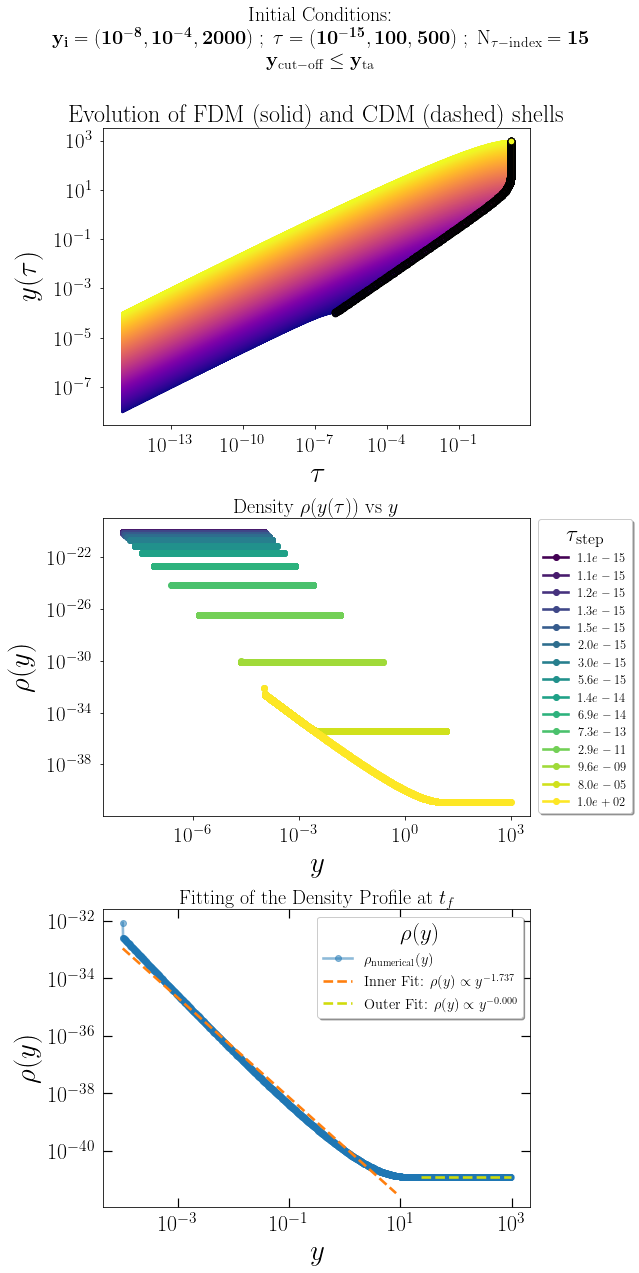

 Fitted slope (inner core):    \rho(y) \propto y^{-1.737}
 Fitted slope (outer tail):    \rho(y) \propto y^{-0.000}


In [36]:
# for 2000 FDM shells

t_i, t_f = 1e-15, 1e2
N = 2000
r_min, r_max = 1e-8, 1e-4
ri_arr = np.geomspace(r_min, r_max, N)
initial_density = 1e-20


delta_M_arr = shells_mass(ri_arr, N, initial_density)
QP = True
gravity = True
Hubble = True


t_step = 500
t_arr = np.geomspace(t_i, t_f, t_step)
dt = np.gradient(t_arr)

r_sol = np.zeros((N, len(t_arr)))
v_sol = np.zeros((N, len(t_arr)))
rho_sol = np.zeros((N, len(t_arr)))
mask_active = np.ones(N, dtype=bool)
cutoff_index = np.full(N, len(t_arr))
t_ta_arr = np.full(N, np.nan)
r_ta_arr = np.full(N, np.nan)
turnaround_detected = np.zeros(N, dtype=bool)
r_sol[:, 0] = ri_arr
v_sol[:, 0] = ri_arr/(2 * t_arr[0])




freeze_fraction= 1
r_sol, v_sol, rho_sol, QP_arr, cutoff_index, r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask = shells_evolution(N, t_arr, dt, ri_arr, Hubble, gravity, QP, freeze_fraction)
time_indices = np.geomspace(1, t_step-1 , 15, dtype=int)




fig, axs = plt.subplots(3, 1, figsize=(9, 18), sharex=False)
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
colors_shell = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
colors1 = cm.viridis(np.linspace(0, 1, len(time_indices)))
colors2 = cm.plasma(np.linspace(0, 1, N))
colors3 = cm.magma(np.linspace(0, 1, len(time_indices)))



#------------------------------------------------------
ax = axs[0]


QP = False
gravity = True
Hubble = True
r_sol_no_qp, v_sol_no_qp, rho_sol_no_qp, QP_arr_no_qp, cutoff_index_no_qp,  r_ta_arr_no_qp, t_ta_arr_no_qp, rho_arr_no_qp, rta_mask_no_qp, tta_mask_no_qp = shells_evolution(N, t_arr, dt, ri_arr,  
Hubble, gravity, QP, freeze_fraction)


for j in range(N):
    cutoff = cutoff_index_no_qp[j]
    ax.loglog(t_arr[:cutoff], r_sol_no_qp[j, :cutoff], color=colors2[j], linestyle='--', alpha=0.7)
    if not np.isnan(t_ta_arr_no_qp[j]):
        ax.scatter(t_ta_arr_no_qp[j], r_ta_arr_no_qp[j], marker='o', s=30, color=colors2[j], edgecolor='k', alpha=0.3)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol_no_qp[j, cutoff - 1], marker='x', s=35, color=colors_shell[j], alpha=0.3)

# Plot FDM shells (with QP) with solid lines
for j in range(N):
    cutoff = cutoff_index[j]
    ax.loglog(t_arr[:cutoff], r_sol[j, :cutoff], color=colors2[j], linestyle='-', alpha=1.0, label=fr'${ri_arr[j]:.1e}$')
    if not np.isnan(t_ta_arr[j]):
        ax.scatter(t_ta_arr[j], r_ta_arr[j], marker='o', s=45, color=colors2[j], edgecolor='k', zorder=5)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol[j, cutoff - 1], marker='x', s=50, color=colors_shell[j], zorder=5)

# Labels, title and legend
ax.set_xlabel(r'$\tau$', fontsize=29, labelpad=6)
ax.set_ylabel(r'$y(\tau)$', fontsize=29, labelpad=11)
ax.set_title('Evolution of FDM (solid) and CDM (dashed) shells', fontsize=24)
ax.tick_params(axis='x', labelsize=21, pad=7.9)
ax.tick_params(axis='y', labelsize=21, pad=7.9)

#handles, labels = ax.get_legend_handles_labels()
#legend_shells = ax.legend(handles[:7], labels[:7], prop={'size': 12.5},
                        #  loc=(1.02, 0.13), shadow=True, title='$y_{i}$', title_fontsize=27,
                        #  facecolor='white', fontsize=25)

#legend_lines = [Line2D([0], [0], color='k', linestyle='-', lw=2),
               # Line2D([0], [0], color='k', linestyle='--', lw=2)]
#ax.legend(legend_lines, ['FDM', 'CDM'], prop={'size': 15.5}, loc=(1.02, 0.64),
         # shadow=True, title='Shell', title_fontsize=23,
         # facecolor='white', fontsize=20)
#ax.add_artist(legend_shells)









#----------------------------------------------------------
#Density vs time at different time steps


ax = axs[1]
for i, idx in enumerate(time_indices):
    r_at_time_index = r_sol[:, idx]
    rho_at_time_index = rho_sol[:, idx]
    ax.loglog(r_at_time_index, rho_at_time_index, marker='o', label=r'$ {0:.1e}$'.format(t_arr[idx]), color=colors1[i])


ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)  
#ax.text(5, 1e-24, '$y_i = (10^{-8}, 10^{-4}, 7)$', fontsize = 18)
#ax.text(5, 1e-27, '$N_\mathrm{time-indices} = 15$', fontsize = 18)
ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 11)
ax.legend( prop = {'size':12.5},loc = (1.02, 0.01),shadow = True, title = r'$\tau_\mathrm{step}$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 23)
ax.set_title(r'Density Profile at Different times steps', fontsize= 24)
ax.set_title(r' Density $\rho(y(\tau))$ vs $y$ ', fontsize=20)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 



#--------------------------------------------------------------------------------



###################################
# Fitting the density profile
ax = axs[2]


def f_fitting(x, m, b):
    return (m*x) + b


final_idx = -1
r_final = r_sol[:, final_idx]
rho_final = rho_sol[:, final_idx]
mask = (r_final > 0) & (rho_final > 0)
r_valid = r_final[mask]
rho_valid = rho_final[mask]


# Sort by radius
sorted_idx = np.argsort(r_valid)
r_valid = r_valid[sorted_idx]
rho_valid = rho_valid[sorted_idx]

# Define regions
inner_N = 1000
outer_N = 800

# Inner region
r_inner = r_valid[:inner_N]
rho_inner = rho_valid[:inner_N]
log_r_inner = np.log10(r_inner)
log_rho_inner = np.log10(rho_inner)
popt_inner, _ = curve_fit(f_fitting, log_r_inner, log_rho_inner)
m_inner, b_inner = popt_inner
rho_fit_inner = 10**f_fitting(log_r_inner, *popt_inner)


# Outer region
r_outer = r_valid[-outer_N:]
rho_outer = rho_valid[-outer_N:]
log_r_outer = np.log10(r_outer)
log_rho_outer = np.log10(rho_outer)
popt_outer, _ = curve_fit(f_fitting, log_r_outer, log_rho_outer)
m_outer, b_outer = popt_outer
rho_fit_outer = 10**f_fitting(log_r_outer, *popt_outer)




ax.loglog(r_valid, rho_valid, 'o-', color='C0', alpha = 0.5)
ax.loglog(r_inner, rho_fit_inner, '--', color='C1')
#ax.loglog(r_middle, rho_fit_middle, '--', color='C3')
ax.loglog(r_outer, rho_fit_outer, '--', color='#d0db0b')


#plt.text(1e-14, 1e-45, '$y_i = (10^{-8}, 10^{-4}, 10)$', fontsize=18)
#plt.text(1e-14, 1e-49, '$(t_i, t_f, t_\\mathrm{steps}) = (10^{-15}, 10^{5}, 10000)$', fontsize=15)

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)

ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=22) 
ax.yaxis.set_tick_params(labelsize=22) 

ax.set_title('Fitting of the Density Profile at $t_f$', fontsize=20)
ax.legend([r'$\rho_\mathrm{numerical}(y)$', fr'Inner Fit: $\rho(y) \propto y^{{{m_inner:.3f}}}$',
           
           fr'Outer Fit: $\rho(y) \propto y^{{{m_outer:.3f}}}$'], 
           prop = {'size':14.5},loc = 'upper right', shadow = True, 
           title = r'$\rho(y)$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 31)




#---------------------------------------------------------------------



plt.suptitle(r'Initial Conditions:' + '\n' + 
    r'$\mathbf{y_i = (10^{-8}, 10^{-4}, 2000)\; ;\;\tau = (10^{-15}, 100, 500)\; ;\;\mathrm{N_{\tau-index}} = 15}$'
              '\n' + r'$\mathbf{y_\mathrm{cut-off} \leq  y_\mathrm{ta}}$' , fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('rho&qp_N2000_t500.pdf', bbox_inches='tight')
plt.show()



#--------------------------------------------------------------------

print(fr' Fitted slope (inner core):    \rho(y) \propto y^{{{m_inner:.3f}}}')
print(fr' Fitted slope (outer tail):    \rho(y) \propto y^{{{m_outer:.3f}}}')





np.savez('fdm_cdm_N2000_t500_rta.npz',
         # FDM arrays
         r_sol_fdm=r_sol,
         v_sol_fdm=v_sol,
         rho_sol_fdm=rho_sol,
         QP_arr_fdm= QP_arr,
         cutoff_index_fdm=cutoff_index,
         r_ta_arr_fdm=r_ta_arr,
         t_ta_arr_fdm=t_ta_arr,
         rho_arr_fdm = rho_arr,
         rta_mask_fdm = rta_mask,
         tta_mask_fdm = tta_mask,
         
         
         # CDM arrays
         r_sol_cdm=r_sol_no_qp,
         v_sol_cdm=v_sol_no_qp,
         rho_sol_cdm=rho_sol_no_qp,
         QP_arr_cdm= QP_arr_no_qp,
         cutoff_index_cdm=cutoff_index_no_qp,
         r_ta_arr_cdm=r_ta_arr_no_qp,
         t_ta_arr_cdm=t_ta_arr_no_qp,
         rho_arr_cdm = rho_arr_no_qp,
         rta_mask_cdm = rta_mask_no_qp,
         tta_mask_cdm = tta_mask_no_qp)



In [21]:
## N_tau_steps = 1000, N_tau_index/snapshots = 15

No shells crossings is detected.


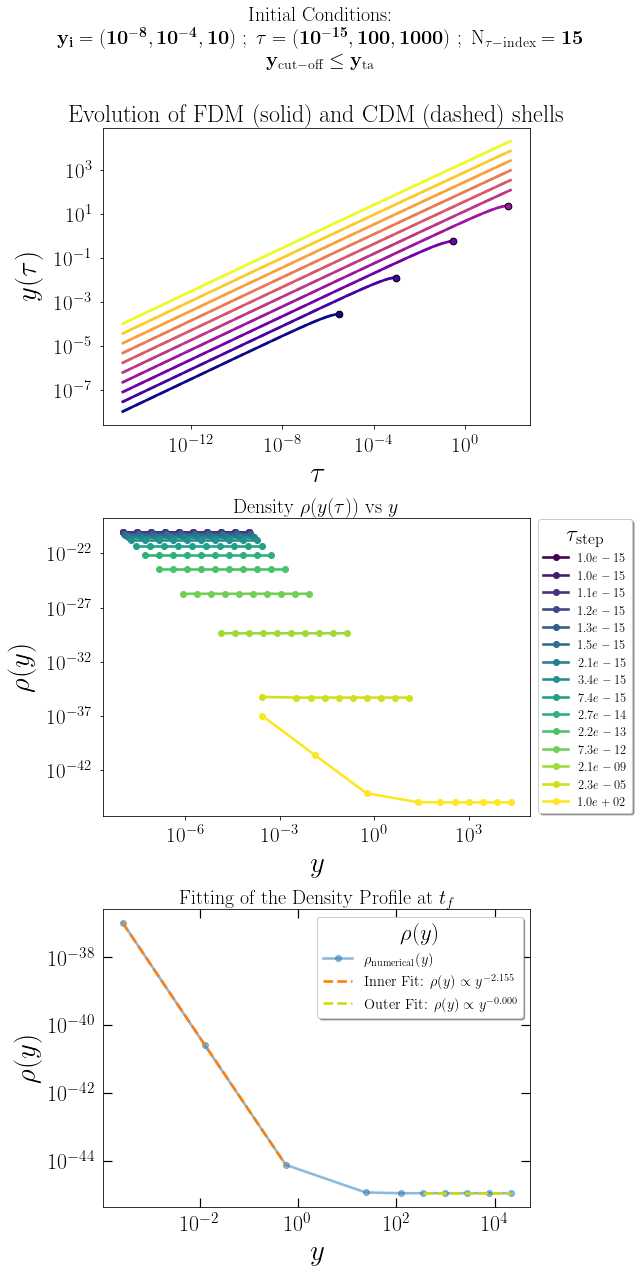

 Fitted slope (inner core):    \rho(y) \propto y^{-2.155}
 Fitted slope (outer tail):    \rho(y) \propto y^{-0.000}


In [7]:
# for 10 FDM shells

t_i, t_f = 1e-15, 1e2
N = 10
r_min, r_max = 1e-8, 1e-4
ri_arr = np.geomspace(r_min, r_max, N)
initial_density = 1e-20


delta_M_arr = shells_mass(ri_arr, N, initial_density)
QP = True
gravity = True
Hubble = True


t_step = 1000
t_arr = np.geomspace(t_i, t_f, t_step)
dt = np.gradient(t_arr)

r_sol = np.zeros((N, len(t_arr)))
v_sol = np.zeros((N, len(t_arr)))
rho_sol = np.zeros((N, len(t_arr)))
mask_active = np.ones(N, dtype=bool)
cutoff_index = np.full(N, len(t_arr))
t_ta_arr = np.full(N, np.nan)
r_ta_arr = np.full(N, np.nan)
turnaround_detected = np.zeros(N, dtype=bool)
r_sol[:, 0] = ri_arr
v_sol[:, 0] = ri_arr/(2 * t_arr[0])




freeze_fraction= 1
r_sol, v_sol, rho_sol, QP_arr, cutoff_index, r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask = shells_evolution(N, t_arr, dt, ri_arr, Hubble, gravity, QP, freeze_fraction)
time_indices = np.geomspace(1, t_step-1 , 15, dtype=int)




fig, axs = plt.subplots(3, 1, figsize=(9, 18), sharex=False)
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
colors_shell = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
colors1 = cm.viridis(np.linspace(0, 1, len(time_indices)))
colors2 = cm.plasma(np.linspace(0, 1, N))
colors3 = cm.magma(np.linspace(0, 1, len(time_indices)))



#------------------------------------------------------
ax = axs[0]


QP = False
gravity = True
Hubble = True
r_sol_no_qp, v_sol_no_qp, rho_sol_no_qp, QP_arr_no_qp, cutoff_index_no_qp,  r_ta_arr_no_qp, t_ta_arr_no_qp, rho_arr_no_qp, rta_mask_no_qp, tta_mask_no_qp = shells_evolution(N, t_arr, dt, ri_arr,  
Hubble, gravity, QP, freeze_fraction)


for j in range(N):
    cutoff = cutoff_index_no_qp[j]
    ax.loglog(t_arr[:cutoff], r_sol_no_qp[j, :cutoff], color=colors2[j], linestyle='--', alpha=0.7)
    if not np.isnan(t_ta_arr_no_qp[j]):
        ax.scatter(t_ta_arr_no_qp[j], r_ta_arr_no_qp[j], marker='o', s=30, color=colors2[j], edgecolor='k', alpha=0.3)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol_no_qp[j, cutoff - 1], marker='x', s=35, color=colors_shell[j], alpha=0.3)

# Plot FDM shells (with QP) with solid lines
for j in range(N):
    cutoff = cutoff_index[j]
    ax.loglog(t_arr[:cutoff], r_sol[j, :cutoff], color=colors2[j], linestyle='-', alpha=1.0, label=fr'${ri_arr[j]:.1e}$')
    if not np.isnan(t_ta_arr[j]):
        ax.scatter(t_ta_arr[j], r_ta_arr[j], marker='o', s=45, color=colors2[j], edgecolor='k', zorder=5)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol[j, cutoff - 1], marker='x', s=50, color=colors_shell[j], zorder=5)

# Labels, title and legend
ax.set_xlabel(r'$\tau$', fontsize=29, labelpad=6)
ax.set_ylabel(r'$y(\tau)$', fontsize=29, labelpad=11)
ax.set_title('Evolution of FDM (solid) and CDM (dashed) shells', fontsize=24)
ax.tick_params(axis='x', labelsize=21, pad=7.9)
ax.tick_params(axis='y', labelsize=21, pad=7.9)

#handles, labels = ax.get_legend_handles_labels()
#legend_shells = ax.legend(handles[:7], labels[:7], prop={'size': 12.5},
                        #  loc=(1.02, 0.13), shadow=True, title='$y_{i}$', title_fontsize=27,
                        #  facecolor='white', fontsize=25)

#legend_lines = [Line2D([0], [0], color='k', linestyle='-', lw=2),
               # Line2D([0], [0], color='k', linestyle='--', lw=2)]
#ax.legend(legend_lines, ['FDM', 'CDM'], prop={'size': 15.5}, loc=(1.02, 0.64),
         # shadow=True, title='Shell', title_fontsize=23,
         # facecolor='white', fontsize=20)
#ax.add_artist(legend_shells)









#----------------------------------------------------------
#Density vs time at different time steps


ax = axs[1]
for i, idx in enumerate(time_indices):
    r_at_time_index = r_sol[:, idx]
    rho_at_time_index = rho_sol[:, idx]
    ax.loglog(r_at_time_index, rho_at_time_index, marker='o', label=r'$ {0:.1e}$'.format(t_arr[idx]), color=colors1[i])


ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)  
#ax.text(5, 1e-24, '$y_i = (10^{-8}, 10^{-4}, 7)$', fontsize = 18)
#ax.text(5, 1e-27, '$N_\mathrm{time-indices} = 15$', fontsize = 18)
ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 11)
ax.legend( prop = {'size':12.5},loc = (1.02, 0.01),shadow = True, title = r'$\tau_\mathrm{step}$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 23)
ax.set_title(r'Density Profile at Different times steps', fontsize= 24)
ax.set_title(r' Density $\rho(y(\tau))$ vs $y$ ', fontsize=20)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 



#--------------------------------------------------------------------------------



###################################
# Fitting the density profile
ax = axs[2]


def f_fitting(x, m, b):
    return (m*x) + b


final_idx = -1
r_final = r_sol[:, final_idx]
rho_final = rho_sol[:, final_idx]
mask = (r_final > 0) & (rho_final > 0)
r_valid = r_final[mask]
rho_valid = rho_final[mask]


# Sort by radius
sorted_idx = np.argsort(r_valid)
r_valid = r_valid[sorted_idx]
rho_valid = rho_valid[sorted_idx]

# Define regions
inner_N = 3
outer_N = 5

# Inner region
r_inner = r_valid[:inner_N]
rho_inner = rho_valid[:inner_N]
log_r_inner = np.log10(r_inner)
log_rho_inner = np.log10(rho_inner)
popt_inner, _ = curve_fit(f_fitting, log_r_inner, log_rho_inner)
m_inner, b_inner = popt_inner
rho_fit_inner = 10**f_fitting(log_r_inner, *popt_inner)


# Outer region
r_outer = r_valid[-outer_N:]
rho_outer = rho_valid[-outer_N:]
log_r_outer = np.log10(r_outer)
log_rho_outer = np.log10(rho_outer)
popt_outer, _ = curve_fit(f_fitting, log_r_outer, log_rho_outer)
m_outer, b_outer = popt_outer
rho_fit_outer = 10**f_fitting(log_r_outer, *popt_outer)




ax.loglog(r_valid, rho_valid, 'o-', color='C0', alpha = 0.5)
ax.loglog(r_inner, rho_fit_inner, '--', color='C1')
#ax.loglog(r_middle, rho_fit_middle, '--', color='C3')
ax.loglog(r_outer, rho_fit_outer, '--', color='#d0db0b')


#plt.text(1e-14, 1e-45, '$y_i = (10^{-8}, 10^{-4}, 10)$', fontsize=18)
#plt.text(1e-14, 1e-49, '$(t_i, t_f, t_\\mathrm{steps}) = (10^{-15}, 10^{5}, 10000)$', fontsize=15)

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)

ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=22) 
ax.yaxis.set_tick_params(labelsize=22) 

ax.set_title('Fitting of the Density Profile at $t_f$', fontsize=20)
ax.legend([r'$\rho_\mathrm{numerical}(y)$', fr'Inner Fit: $\rho(y) \propto y^{{{m_inner:.3f}}}$',
           
           fr'Outer Fit: $\rho(y) \propto y^{{{m_outer:.3f}}}$'], 
           prop = {'size':14.5},loc = 'upper right', shadow = True, 
           title = r'$\rho(y)$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 31)




#---------------------------------------------------------------------



plt.suptitle(r'Initial Conditions:' + '\n' + 
    r'$\mathbf{y_i = (10^{-8}, 10^{-4}, 10)\; ;\;\tau = (10^{-15}, 100, 1000)\; ;\;\mathrm{N_{\tau-index}} = 15}$'
              '\n' + r'$\mathbf{y_\mathrm{cut-off} \leq  y_\mathrm{ta}}$' , fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('rho&qp_N10_t1000.pdf', bbox_inches='tight')
plt.show()



#--------------------------------------------------------------------

print(fr' Fitted slope (inner core):    \rho(y) \propto y^{{{m_inner:.3f}}}')
print(fr' Fitted slope (outer tail):    \rho(y) \propto y^{{{m_outer:.3f}}}')





np.savez('fdm_cdm_N10_t1000_rta.npz',
         # FDM arrays
         r_sol_fdm=r_sol,
         v_sol_fdm=v_sol,
         rho_sol_fdm=rho_sol,
         QP_arr_fdm= QP_arr,
         cutoff_index_fdm=cutoff_index,
         r_ta_arr_fdm=r_ta_arr,
         t_ta_arr_fdm=t_ta_arr,
         rho_arr_fdm = rho_arr,
         rta_mask_fdm = rta_mask,
         tta_mask_fdm = tta_mask,
         
         
         # CDM arrays
         r_sol_cdm=r_sol_no_qp,
         v_sol_cdm=v_sol_no_qp,
         rho_sol_cdm=rho_sol_no_qp,
         QP_arr_cdm= QP_arr_no_qp,
         cutoff_index_cdm=cutoff_index_no_qp,
         r_ta_arr_cdm=r_ta_arr_no_qp,
         t_ta_arr_cdm=t_ta_arr_no_qp,
         rho_arr_cdm = rho_arr_no_qp,
         rta_mask_cdm = rta_mask_no_qp,
         tta_mask_cdm = tta_mask_no_qp)



No shells crossings is detected.


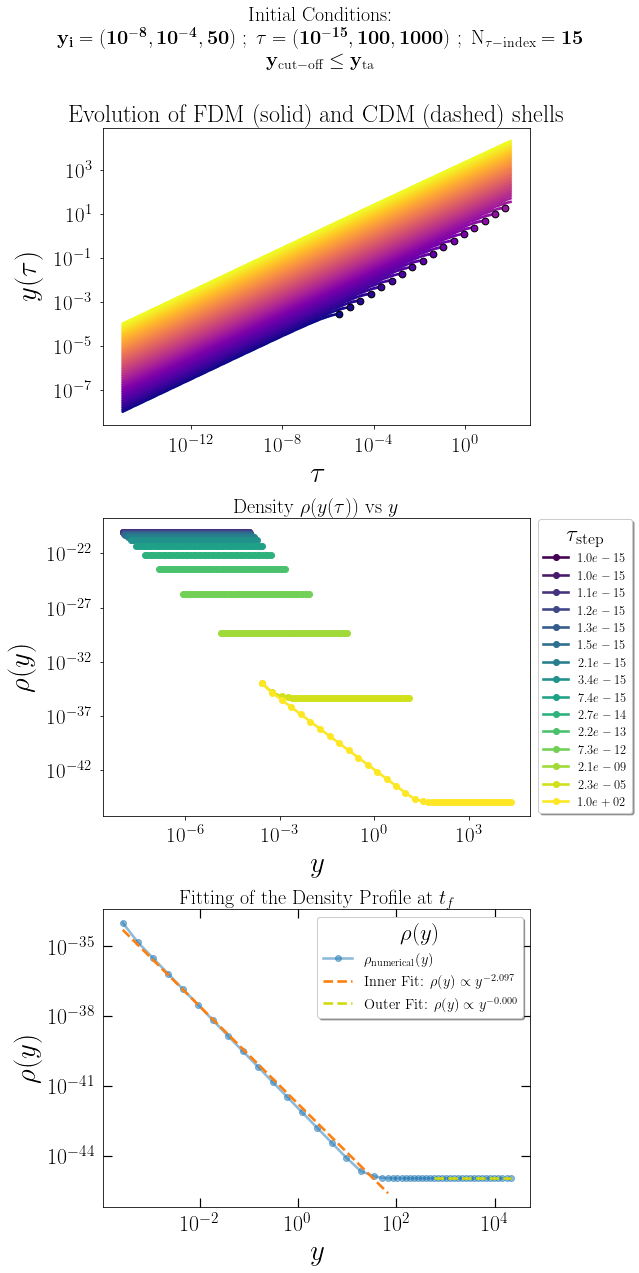

 Fitted slope (inner core):    \rho(y) \propto y^{-2.097}
 Fitted slope (outer tail):    \rho(y) \propto y^{-0.000}


In [10]:
# for 50 FDM shells

t_i, t_f = 1e-15, 1e2
N = 50
r_min, r_max = 1e-8, 1e-4
ri_arr = np.geomspace(r_min, r_max, N)
initial_density = 1e-20


delta_M_arr = shells_mass(ri_arr, N, initial_density)
QP = True
gravity = True
Hubble = True


t_step = 1000
t_arr = np.geomspace(t_i, t_f, t_step)
dt = np.gradient(t_arr)

r_sol = np.zeros((N, len(t_arr)))
v_sol = np.zeros((N, len(t_arr)))
rho_sol = np.zeros((N, len(t_arr)))
mask_active = np.ones(N, dtype=bool)
cutoff_index = np.full(N, len(t_arr))
t_ta_arr = np.full(N, np.nan)
r_ta_arr = np.full(N, np.nan)
turnaround_detected = np.zeros(N, dtype=bool)
r_sol[:, 0] = ri_arr
v_sol[:, 0] = ri_arr/(2 * t_arr[0])




freeze_fraction= 1
r_sol, v_sol, rho_sol, QP_arr, cutoff_index, r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask = shells_evolution(N, t_arr, dt, ri_arr, Hubble, gravity, QP, freeze_fraction)
time_indices = np.geomspace(1, t_step-1 , 15, dtype=int)




fig, axs = plt.subplots(3, 1, figsize=(9, 18), sharex=False)
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
colors_shell = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
colors1 = cm.viridis(np.linspace(0, 1, len(time_indices)))
colors2 = cm.plasma(np.linspace(0, 1, N))
colors3 = cm.magma(np.linspace(0, 1, len(time_indices)))



#------------------------------------------------------
ax = axs[0]


QP = False
gravity = True
Hubble = True
r_sol_no_qp, v_sol_no_qp, rho_sol_no_qp, QP_arr_no_qp, cutoff_index_no_qp,  r_ta_arr_no_qp, t_ta_arr_no_qp, rho_arr_no_qp, rta_mask_no_qp, tta_mask_no_qp = shells_evolution(N, t_arr, dt, ri_arr,  
Hubble, gravity, QP, freeze_fraction)


for j in range(N):
    cutoff = cutoff_index_no_qp[j]
    ax.loglog(t_arr[:cutoff], r_sol_no_qp[j, :cutoff], color=colors2[j], linestyle='--', alpha=0.7)
    if not np.isnan(t_ta_arr_no_qp[j]):
        ax.scatter(t_ta_arr_no_qp[j], r_ta_arr_no_qp[j], marker='o', s=30, color=colors2[j], edgecolor='k', alpha=0.3)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol_no_qp[j, cutoff - 1], marker='x', s=35, color=colors_shell[j], alpha=0.3)

# Plot FDM shells (with QP) with solid lines
for j in range(N):
    cutoff = cutoff_index[j]
    ax.loglog(t_arr[:cutoff], r_sol[j, :cutoff], color=colors2[j], linestyle='-', alpha=1.0, label=fr'${ri_arr[j]:.1e}$')
    if not np.isnan(t_ta_arr[j]):
        ax.scatter(t_ta_arr[j], r_ta_arr[j], marker='o', s=45, color=colors2[j], edgecolor='k', zorder=5)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol[j, cutoff - 1], marker='x', s=50, color=colors_shell[j], zorder=5)

# Labels, title and legend
ax.set_xlabel(r'$\tau$', fontsize=29, labelpad=6)
ax.set_ylabel(r'$y(\tau)$', fontsize=29, labelpad=11)
ax.set_title('Evolution of FDM (solid) and CDM (dashed) shells', fontsize=24)
ax.tick_params(axis='x', labelsize=21, pad=7.9)
ax.tick_params(axis='y', labelsize=21, pad=7.9)

#handles, labels = ax.get_legend_handles_labels()
#legend_shells = ax.legend(handles[:7], labels[:7], prop={'size': 12.5},
                        #  loc=(1.02, 0.13), shadow=True, title='$y_{i}$', title_fontsize=27,
                        #  facecolor='white', fontsize=25)

#legend_lines = [Line2D([0], [0], color='k', linestyle='-', lw=2),
               # Line2D([0], [0], color='k', linestyle='--', lw=2)]
#ax.legend(legend_lines, ['FDM', 'CDM'], prop={'size': 15.5}, loc=(1.02, 0.64),
         # shadow=True, title='Shell', title_fontsize=23,
         # facecolor='white', fontsize=20)
#ax.add_artist(legend_shells)









#----------------------------------------------------------
#Density vs time at different time steps


ax = axs[1]
for i, idx in enumerate(time_indices):
    r_at_time_index = r_sol[:, idx]
    rho_at_time_index = rho_sol[:, idx]
    ax.loglog(r_at_time_index, rho_at_time_index, marker='o', label=r'$ {0:.1e}$'.format(t_arr[idx]), color=colors1[i])


ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)  
#ax.text(5, 1e-24, '$y_i = (10^{-8}, 10^{-4}, 7)$', fontsize = 18)
#ax.text(5, 1e-27, '$N_\mathrm{time-indices} = 15$', fontsize = 18)
ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 11)
ax.legend( prop = {'size':12.5},loc = (1.02, 0.01),shadow = True, title = r'$\tau_\mathrm{step}$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 23)
ax.set_title(r'Density Profile at Different times steps', fontsize= 24)
ax.set_title(r' Density $\rho(y(\tau))$ vs $y$ ', fontsize=20)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 



#--------------------------------------------------------------------------------



###################################
# Fitting the density profile
ax = axs[2]


def f_fitting(x, m, b):
    return (m*x) + b


final_idx = -1
r_final = r_sol[:, final_idx]
rho_final = rho_sol[:, final_idx]
mask = (r_final > 0) & (rho_final > 0)
r_valid = r_final[mask]
rho_valid = rho_final[mask]


# Sort by radius
sorted_idx = np.argsort(r_valid)
r_valid = r_valid[sorted_idx]
rho_valid = rho_valid[sorted_idx]

# Define regions
inner_N = 20
outer_N = 20

# Inner region
r_inner = r_valid[:inner_N]
rho_inner = rho_valid[:inner_N]
log_r_inner = np.log10(r_inner)
log_rho_inner = np.log10(rho_inner)
popt_inner, _ = curve_fit(f_fitting, log_r_inner, log_rho_inner)
m_inner, b_inner = popt_inner
rho_fit_inner = 10**f_fitting(log_r_inner, *popt_inner)


# Outer region
r_outer = r_valid[-outer_N:]
rho_outer = rho_valid[-outer_N:]
log_r_outer = np.log10(r_outer)
log_rho_outer = np.log10(rho_outer)
popt_outer, _ = curve_fit(f_fitting, log_r_outer, log_rho_outer)
m_outer, b_outer = popt_outer
rho_fit_outer = 10**f_fitting(log_r_outer, *popt_outer)




ax.loglog(r_valid, rho_valid, 'o-', color='C0', alpha = 0.5)
ax.loglog(r_inner, rho_fit_inner, '--', color='C1')
#ax.loglog(r_middle, rho_fit_middle, '--', color='C3')
ax.loglog(r_outer, rho_fit_outer, '--', color='#d0db0b')


#plt.text(1e-14, 1e-45, '$y_i = (10^{-8}, 10^{-4}, 10)$', fontsize=18)
#plt.text(1e-14, 1e-49, '$(t_i, t_f, t_\\mathrm{steps}) = (10^{-15}, 10^{5}, 10000)$', fontsize=15)

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)

ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=22) 
ax.yaxis.set_tick_params(labelsize=22) 

ax.set_title('Fitting of the Density Profile at $t_f$', fontsize=20)
ax.legend([r'$\rho_\mathrm{numerical}(y)$', fr'Inner Fit: $\rho(y) \propto y^{{{m_inner:.3f}}}$',
           
           fr'Outer Fit: $\rho(y) \propto y^{{{m_outer:.3f}}}$'], 
           prop = {'size':14.5},loc = 'upper right', shadow = True, 
           title = r'$\rho(y)$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 31)




#---------------------------------------------------------------------



plt.suptitle(r'Initial Conditions:' + '\n' + 
    r'$\mathbf{y_i = (10^{-8}, 10^{-4}, 50)\; ;\;\tau = (10^{-15}, 100, 1000)\; ;\;\mathrm{N_{\tau-index}} = 15}$'
              '\n' + r'$\mathbf{y_\mathrm{cut-off} \leq  y_\mathrm{ta}}$' , fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('rho&qp_N50_t1000.pdf', bbox_inches='tight')
plt.show()



#--------------------------------------------------------------------

print(fr' Fitted slope (inner core):    \rho(y) \propto y^{{{m_inner:.3f}}}')
print(fr' Fitted slope (outer tail):    \rho(y) \propto y^{{{m_outer:.3f}}}')





np.savez('fdm_cdm_N50_t1000_rta.npz',
         # FDM arrays
         r_sol_fdm=r_sol,
         v_sol_fdm=v_sol,
         rho_sol_fdm=rho_sol,
         QP_arr_fdm= QP_arr,
         cutoff_index_fdm=cutoff_index,
         r_ta_arr_fdm=r_ta_arr,
         t_ta_arr_fdm=t_ta_arr,
         rho_arr_fdm = rho_arr,
         rta_mask_fdm = rta_mask,
         tta_mask_fdm = tta_mask,
         
         
         # CDM arrays
         r_sol_cdm=r_sol_no_qp,
         v_sol_cdm=v_sol_no_qp,
         rho_sol_cdm=rho_sol_no_qp,
         QP_arr_cdm= QP_arr_no_qp,
         cutoff_index_cdm=cutoff_index_no_qp,
         r_ta_arr_cdm=r_ta_arr_no_qp,
         t_ta_arr_cdm=t_ta_arr_no_qp,
         rho_arr_cdm = rho_arr_no_qp,
         rta_mask_cdm = rta_mask_no_qp,
         tta_mask_cdm = tta_mask_no_qp)



No shells crossings is detected.


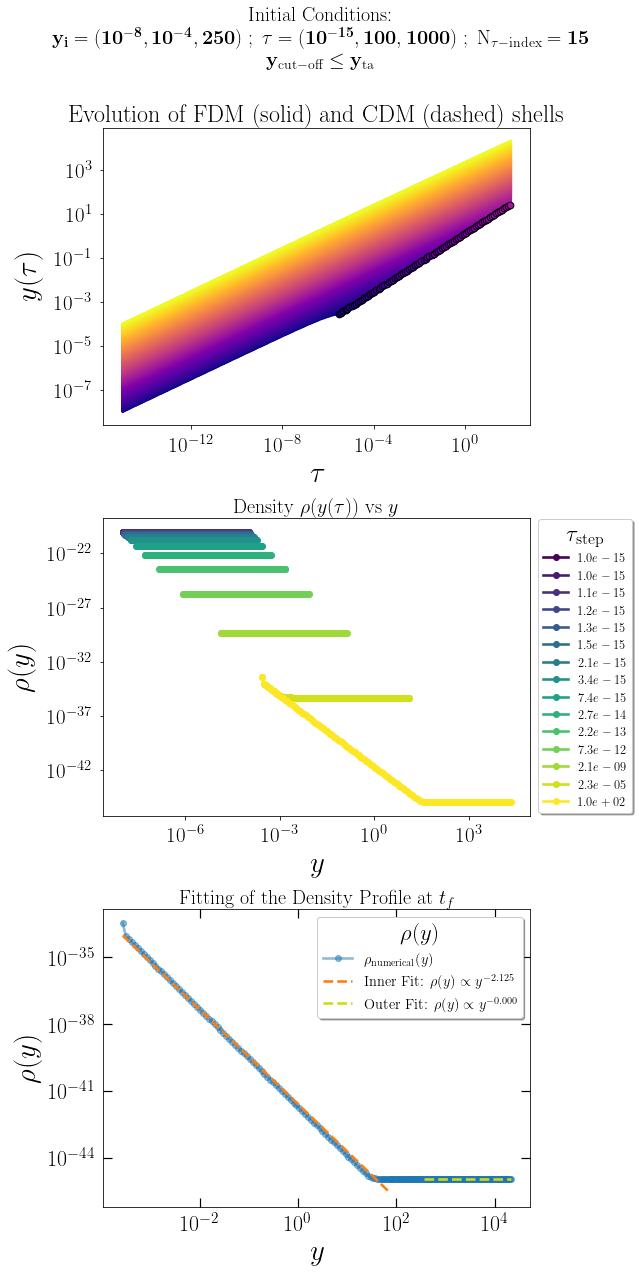

 Fitted slope (inner core):    \rho(y) \propto y^{-2.125}
 Fitted slope (outer tail):    \rho(y) \propto y^{-0.000}


In [11]:
# for 250 FDM shells

t_i, t_f = 1e-15, 1e2
N = 250
r_min, r_max = 1e-8, 1e-4
ri_arr = np.geomspace(r_min, r_max, N)
initial_density = 1e-20


delta_M_arr = shells_mass(ri_arr, N, initial_density)
QP = True
gravity = True
Hubble = True


t_step = 1000
t_arr = np.geomspace(t_i, t_f, t_step)
dt = np.gradient(t_arr)

r_sol = np.zeros((N, len(t_arr)))
v_sol = np.zeros((N, len(t_arr)))
rho_sol = np.zeros((N, len(t_arr)))
mask_active = np.ones(N, dtype=bool)
cutoff_index = np.full(N, len(t_arr))
t_ta_arr = np.full(N, np.nan)
r_ta_arr = np.full(N, np.nan)
turnaround_detected = np.zeros(N, dtype=bool)
r_sol[:, 0] = ri_arr
v_sol[:, 0] = ri_arr/(2 * t_arr[0])




freeze_fraction= 1
r_sol, v_sol, rho_sol, QP_arr, cutoff_index, r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask = shells_evolution(N, t_arr, dt, ri_arr, Hubble, gravity, QP, freeze_fraction)
time_indices = np.geomspace(1, t_step-1 , 15, dtype=int)




fig, axs = plt.subplots(3, 1, figsize=(9, 18), sharex=False)
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
colors_shell = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
colors1 = cm.viridis(np.linspace(0, 1, len(time_indices)))
colors2 = cm.plasma(np.linspace(0, 1, N))
colors3 = cm.magma(np.linspace(0, 1, len(time_indices)))



#------------------------------------------------------
ax = axs[0]


QP = False
gravity = True
Hubble = True
r_sol_no_qp, v_sol_no_qp, rho_sol_no_qp, QP_arr_no_qp, cutoff_index_no_qp,  r_ta_arr_no_qp, t_ta_arr_no_qp, rho_arr_no_qp, rta_mask_no_qp, tta_mask_no_qp = shells_evolution(N, t_arr, dt, ri_arr,  
Hubble, gravity, QP, freeze_fraction)


for j in range(N):
    cutoff = cutoff_index_no_qp[j]
    ax.loglog(t_arr[:cutoff], r_sol_no_qp[j, :cutoff], color=colors2[j], linestyle='--', alpha=0.7)
    if not np.isnan(t_ta_arr_no_qp[j]):
        ax.scatter(t_ta_arr_no_qp[j], r_ta_arr_no_qp[j], marker='o', s=30, color=colors2[j], edgecolor='k', alpha=0.3)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol_no_qp[j, cutoff - 1], marker='x', s=35, color=colors_shell[j], alpha=0.3)

# Plot FDM shells (with QP) with solid lines
for j in range(N):
    cutoff = cutoff_index[j]
    ax.loglog(t_arr[:cutoff], r_sol[j, :cutoff], color=colors2[j], linestyle='-', alpha=1.0, label=fr'${ri_arr[j]:.1e}$')
    if not np.isnan(t_ta_arr[j]):
        ax.scatter(t_ta_arr[j], r_ta_arr[j], marker='o', s=45, color=colors2[j], edgecolor='k', zorder=5)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol[j, cutoff - 1], marker='x', s=50, color=colors_shell[j], zorder=5)

# Labels, title and legend
ax.set_xlabel(r'$\tau$', fontsize=29, labelpad=6)
ax.set_ylabel(r'$y(\tau)$', fontsize=29, labelpad=11)
ax.set_title('Evolution of FDM (solid) and CDM (dashed) shells', fontsize=24)
ax.tick_params(axis='x', labelsize=21, pad=7.9)
ax.tick_params(axis='y', labelsize=21, pad=7.9)

#handles, labels = ax.get_legend_handles_labels()
#legend_shells = ax.legend(handles[:7], labels[:7], prop={'size': 12.5},
                        #  loc=(1.02, 0.13), shadow=True, title='$y_{i}$', title_fontsize=27,
                        #  facecolor='white', fontsize=25)

#legend_lines = [Line2D([0], [0], color='k', linestyle='-', lw=2),
               # Line2D([0], [0], color='k', linestyle='--', lw=2)]
#ax.legend(legend_lines, ['FDM', 'CDM'], prop={'size': 15.5}, loc=(1.02, 0.64),
         # shadow=True, title='Shell', title_fontsize=23,
         # facecolor='white', fontsize=20)
#ax.add_artist(legend_shells)









#----------------------------------------------------------
#Density vs time at different time steps


ax = axs[1]
for i, idx in enumerate(time_indices):
    r_at_time_index = r_sol[:, idx]
    rho_at_time_index = rho_sol[:, idx]
    ax.loglog(r_at_time_index, rho_at_time_index, marker='o', label=r'$ {0:.1e}$'.format(t_arr[idx]), color=colors1[i])


ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)  
#ax.text(5, 1e-24, '$y_i = (10^{-8}, 10^{-4}, 7)$', fontsize = 18)
#ax.text(5, 1e-27, '$N_\mathrm{time-indices} = 15$', fontsize = 18)
ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 11)
ax.legend( prop = {'size':12.5},loc = (1.02, 0.01),shadow = True, title = r'$\tau_\mathrm{step}$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 23)
ax.set_title(r'Density Profile at Different times steps', fontsize= 24)
ax.set_title(r' Density $\rho(y(\tau))$ vs $y$ ', fontsize=20)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 



#--------------------------------------------------------------------------------



###################################
# Fitting the density profile
ax = axs[2]


def f_fitting(x, m, b):
    return (m*x) + b


final_idx = -1
r_final = r_sol[:, final_idx]
rho_final = rho_sol[:, final_idx]
mask = (r_final > 0) & (rho_final > 0)
r_valid = r_final[mask]
rho_valid = rho_final[mask]


# Sort by radius
sorted_idx = np.argsort(r_valid)
r_valid = r_valid[sorted_idx]
rho_valid = rho_valid[sorted_idx]

# Define regions
inner_N = 100
outer_N = 110

# Inner region
r_inner = r_valid[:inner_N]
rho_inner = rho_valid[:inner_N]
log_r_inner = np.log10(r_inner)
log_rho_inner = np.log10(rho_inner)
popt_inner, _ = curve_fit(f_fitting, log_r_inner, log_rho_inner)
m_inner, b_inner = popt_inner
rho_fit_inner = 10**f_fitting(log_r_inner, *popt_inner)


# Outer region
r_outer = r_valid[-outer_N:]
rho_outer = rho_valid[-outer_N:]
log_r_outer = np.log10(r_outer)
log_rho_outer = np.log10(rho_outer)
popt_outer, _ = curve_fit(f_fitting, log_r_outer, log_rho_outer)
m_outer, b_outer = popt_outer
rho_fit_outer = 10**f_fitting(log_r_outer, *popt_outer)




ax.loglog(r_valid, rho_valid, 'o-', color='C0', alpha = 0.5)
ax.loglog(r_inner, rho_fit_inner, '--', color='C1')
#ax.loglog(r_middle, rho_fit_middle, '--', color='C3')
ax.loglog(r_outer, rho_fit_outer, '--', color='#d0db0b')


#plt.text(1e-14, 1e-45, '$y_i = (10^{-8}, 10^{-4}, 10)$', fontsize=18)
#plt.text(1e-14, 1e-49, '$(t_i, t_f, t_\\mathrm{steps}) = (10^{-15}, 10^{5}, 10000)$', fontsize=15)

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)

ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=22) 
ax.yaxis.set_tick_params(labelsize=22) 

ax.set_title('Fitting of the Density Profile at $t_f$', fontsize=20)
ax.legend([r'$\rho_\mathrm{numerical}(y)$', fr'Inner Fit: $\rho(y) \propto y^{{{m_inner:.3f}}}$',
           
           fr'Outer Fit: $\rho(y) \propto y^{{{m_outer:.3f}}}$'], 
           prop = {'size':14.5},loc = 'upper right', shadow = True, 
           title = r'$\rho(y)$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 31)




#---------------------------------------------------------------------



plt.suptitle(r'Initial Conditions:' + '\n' + 
    r'$\mathbf{y_i = (10^{-8}, 10^{-4}, 250)\; ;\;\tau = (10^{-15}, 100, 1000)\; ;\;\mathrm{N_{\tau-index}} = 15}$'
              '\n' + r'$\mathbf{y_\mathrm{cut-off} \leq  y_\mathrm{ta}}$' , fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('rho&qp_N250_t1000.pdf', bbox_inches='tight')
plt.show()



#--------------------------------------------------------------------

print(fr' Fitted slope (inner core):    \rho(y) \propto y^{{{m_inner:.3f}}}')
print(fr' Fitted slope (outer tail):    \rho(y) \propto y^{{{m_outer:.3f}}}')





np.savez('fdm_cdm_N250_t1000_rta.npz',
         # FDM arrays
         r_sol_fdm=r_sol,
         v_sol_fdm=v_sol,
         rho_sol_fdm=rho_sol,
         QP_arr_fdm= QP_arr,
         cutoff_index_fdm=cutoff_index,
         r_ta_arr_fdm=r_ta_arr,
         t_ta_arr_fdm=t_ta_arr,
         rho_arr_fdm = rho_arr,
         rta_mask_fdm = rta_mask,
         tta_mask_fdm = tta_mask,
         
         
         # CDM arrays
         r_sol_cdm=r_sol_no_qp,
         v_sol_cdm=v_sol_no_qp,
         rho_sol_cdm=rho_sol_no_qp,
         QP_arr_cdm= QP_arr_no_qp,
         cutoff_index_cdm=cutoff_index_no_qp,
         r_ta_arr_cdm=r_ta_arr_no_qp,
         t_ta_arr_cdm=t_ta_arr_no_qp,
         rho_arr_cdm = rho_arr_no_qp,
         rta_mask_cdm = rta_mask_no_qp,
         tta_mask_cdm = tta_mask_no_qp)



No shells crossings is detected.


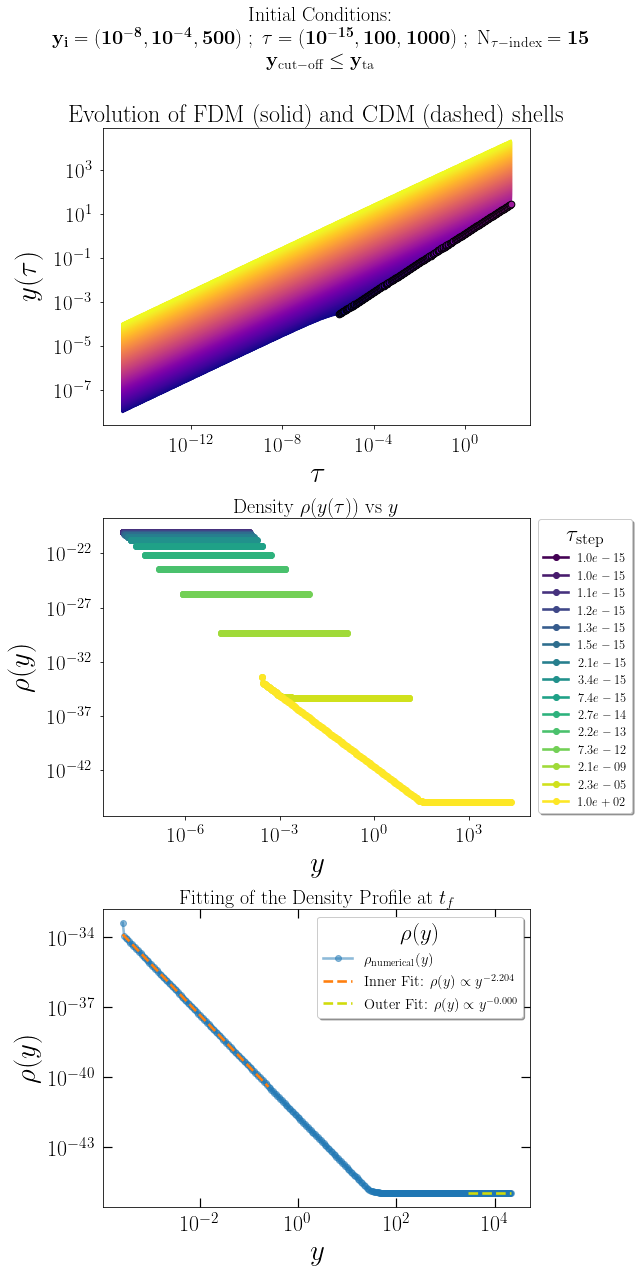

 Fitted slope (inner core):    \rho(y) \propto y^{-2.204}
 Fitted slope (outer tail):    \rho(y) \propto y^{-0.000}


In [20]:
# for 500 FDM shells

t_i, t_f = 1e-15, 1e2
N = 500
r_min, r_max = 1e-8, 1e-4
ri_arr = np.geomspace(r_min, r_max, N)
initial_density = 1e-20


delta_M_arr = shells_mass(ri_arr, N, initial_density)
QP = True
gravity = True
Hubble = True


t_step = 1000
t_arr = np.geomspace(t_i, t_f, t_step)
dt = np.gradient(t_arr)

r_sol = np.zeros((N, len(t_arr)))
v_sol = np.zeros((N, len(t_arr)))
rho_sol = np.zeros((N, len(t_arr)))
mask_active = np.ones(N, dtype=bool)
cutoff_index = np.full(N, len(t_arr))
t_ta_arr = np.full(N, np.nan)
r_ta_arr = np.full(N, np.nan)
turnaround_detected = np.zeros(N, dtype=bool)
r_sol[:, 0] = ri_arr
v_sol[:, 0] = ri_arr/(2 * t_arr[0])




freeze_fraction= 1
r_sol, v_sol, rho_sol, QP_arr, cutoff_index, r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask = shells_evolution(N, t_arr, dt, ri_arr, Hubble, gravity, QP, freeze_fraction)
time_indices = np.geomspace(1, t_step-1 , 15, dtype=int)




fig, axs = plt.subplots(3, 1, figsize=(9, 18), sharex=False)
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
colors_shell = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
colors1 = cm.viridis(np.linspace(0, 1, len(time_indices)))
colors2 = cm.plasma(np.linspace(0, 1, N))
colors3 = cm.magma(np.linspace(0, 1, len(time_indices)))



#------------------------------------------------------
ax = axs[0]


QP = False
gravity = True
Hubble = True
r_sol_no_qp, v_sol_no_qp, rho_sol_no_qp, QP_arr_no_qp, cutoff_index_no_qp,  r_ta_arr_no_qp, t_ta_arr_no_qp, rho_arr_no_qp, rta_mask_no_qp, tta_mask_no_qp = shells_evolution(N, t_arr, dt, ri_arr,  
Hubble, gravity, QP, freeze_fraction)


for j in range(N):
    cutoff = cutoff_index_no_qp[j]
    ax.loglog(t_arr[:cutoff], r_sol_no_qp[j, :cutoff], color=colors2[j], linestyle='--', alpha=0.7)
    if not np.isnan(t_ta_arr_no_qp[j]):
        ax.scatter(t_ta_arr_no_qp[j], r_ta_arr_no_qp[j], marker='o', s=30, color=colors2[j], edgecolor='k', alpha=0.3)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol_no_qp[j, cutoff - 1], marker='x', s=35, color=colors_shell[j], alpha=0.3)

# Plot FDM shells (with QP) with solid lines
for j in range(N):
    cutoff = cutoff_index[j]
    ax.loglog(t_arr[:cutoff], r_sol[j, :cutoff], color=colors2[j], linestyle='-', alpha=1.0, label=fr'${ri_arr[j]:.1e}$')
    if not np.isnan(t_ta_arr[j]):
        ax.scatter(t_ta_arr[j], r_ta_arr[j], marker='o', s=45, color=colors2[j], edgecolor='k', zorder=5)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol[j, cutoff - 1], marker='x', s=50, color=colors_shell[j], zorder=5)

# Labels, title and legend
ax.set_xlabel(r'$\tau$', fontsize=29, labelpad=6)
ax.set_ylabel(r'$y(\tau)$', fontsize=29, labelpad=11)
ax.set_title('Evolution of FDM (solid) and CDM (dashed) shells', fontsize=24)
ax.tick_params(axis='x', labelsize=21, pad=7.9)
ax.tick_params(axis='y', labelsize=21, pad=7.9)

#handles, labels = ax.get_legend_handles_labels()
#legend_shells = ax.legend(handles[:7], labels[:7], prop={'size': 12.5},
                        #  loc=(1.02, 0.13), shadow=True, title='$y_{i}$', title_fontsize=27,
                        #  facecolor='white', fontsize=25)

#legend_lines = [Line2D([0], [0], color='k', linestyle='-', lw=2),
               # Line2D([0], [0], color='k', linestyle='--', lw=2)]
#ax.legend(legend_lines, ['FDM', 'CDM'], prop={'size': 15.5}, loc=(1.02, 0.64),
         # shadow=True, title='Shell', title_fontsize=23,
         # facecolor='white', fontsize=20)
#ax.add_artist(legend_shells)









#----------------------------------------------------------
#Density vs time at different time steps


ax = axs[1]
for i, idx in enumerate(time_indices):
    r_at_time_index = r_sol[:, idx]
    rho_at_time_index = rho_sol[:, idx]
    ax.loglog(r_at_time_index, rho_at_time_index, marker='o', label=r'$ {0:.1e}$'.format(t_arr[idx]), color=colors1[i])


ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)  
#ax.text(5, 1e-24, '$y_i = (10^{-8}, 10^{-4}, 7)$', fontsize = 18)
#ax.text(5, 1e-27, '$N_\mathrm{time-indices} = 15$', fontsize = 18)
ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 11)
ax.legend( prop = {'size':12.5},loc = (1.02, 0.01),shadow = True, title = r'$\tau_\mathrm{step}$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 23)
ax.set_title(r'Density Profile at Different times steps', fontsize= 24)
ax.set_title(r' Density $\rho(y(\tau))$ vs $y$ ', fontsize=20)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 



#--------------------------------------------------------------------------------



###################################
# Fitting the density profile
ax = axs[2]


def f_fitting(x, m, b):
    return (m*x) + b


final_idx = -1
r_final = r_sol[:, final_idx]
rho_final = rho_sol[:, final_idx]
mask = (r_final > 0) & (rho_final > 0)
r_valid = r_final[mask]
rho_valid = rho_final[mask]


# Sort by radius
sorted_idx = np.argsort(r_valid)
r_valid = r_valid[sorted_idx]
rho_valid = rho_valid[sorted_idx]

# Define regions
inner_N = 100
outer_N = 110

# Inner region
r_inner = r_valid[:inner_N]
rho_inner = rho_valid[:inner_N]
log_r_inner = np.log10(r_inner)
log_rho_inner = np.log10(rho_inner)
popt_inner, _ = curve_fit(f_fitting, log_r_inner, log_rho_inner)
m_inner, b_inner = popt_inner
rho_fit_inner = 10**f_fitting(log_r_inner, *popt_inner)


# Outer region
r_outer = r_valid[-outer_N:]
rho_outer = rho_valid[-outer_N:]
log_r_outer = np.log10(r_outer)
log_rho_outer = np.log10(rho_outer)
popt_outer, _ = curve_fit(f_fitting, log_r_outer, log_rho_outer)
m_outer, b_outer = popt_outer
rho_fit_outer = 10**f_fitting(log_r_outer, *popt_outer)




ax.loglog(r_valid, rho_valid, 'o-', color='C0', alpha = 0.5)
ax.loglog(r_inner, rho_fit_inner, '--', color='C1')
#ax.loglog(r_middle, rho_fit_middle, '--', color='C3')
ax.loglog(r_outer, rho_fit_outer, '--', color='#d0db0b')


#plt.text(1e-14, 1e-45, '$y_i = (10^{-8}, 10^{-4}, 10)$', fontsize=18)
#plt.text(1e-14, 1e-49, '$(t_i, t_f, t_\\mathrm{steps}) = (10^{-15}, 10^{5}, 10000)$', fontsize=15)

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)

ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=22) 
ax.yaxis.set_tick_params(labelsize=22) 

ax.set_title('Fitting of the Density Profile at $t_f$', fontsize=20)
ax.legend([r'$\rho_\mathrm{numerical}(y)$', fr'Inner Fit: $\rho(y) \propto y^{{{m_inner:.3f}}}$',
           
           fr'Outer Fit: $\rho(y) \propto y^{{{m_outer:.3f}}}$'], 
           prop = {'size':14.5},loc = 'upper right', shadow = True, 
           title = r'$\rho(y)$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 31)




#---------------------------------------------------------------------



plt.suptitle(r'Initial Conditions:' + '\n' + 
    r'$\mathbf{y_i = (10^{-8}, 10^{-4}, 500)\; ;\;\tau = (10^{-15}, 100, 1000)\; ;\;\mathrm{N_{\tau-index}} = 15}$'
              '\n' + r'$\mathbf{y_\mathrm{cut-off} \leq  y_\mathrm{ta}}$' , fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('rho&qp_N500_t1000.pdf', bbox_inches='tight')
plt.show()



#--------------------------------------------------------------------

print(fr' Fitted slope (inner core):    \rho(y) \propto y^{{{m_inner:.3f}}}')
print(fr' Fitted slope (outer tail):    \rho(y) \propto y^{{{m_outer:.3f}}}')





np.savez('fdm_cdm_N500_t1000_rta.npz',
         # FDM arrays
         r_sol_fdm=r_sol,
         v_sol_fdm=v_sol,
         rho_sol_fdm=rho_sol,
         QP_arr_fdm= QP_arr,
         cutoff_index_fdm=cutoff_index,
         r_ta_arr_fdm=r_ta_arr,
         t_ta_arr_fdm=t_ta_arr,
         rho_arr_fdm = rho_arr,
         rta_mask_fdm = rta_mask,
         tta_mask_fdm = tta_mask,
         
         
         # CDM arrays
         r_sol_cdm=r_sol_no_qp,
         v_sol_cdm=v_sol_no_qp,
         rho_sol_cdm=rho_sol_no_qp,
         QP_arr_cdm= QP_arr_no_qp,
         cutoff_index_cdm=cutoff_index_no_qp,
         r_ta_arr_cdm=r_ta_arr_no_qp,
         t_ta_arr_cdm=t_ta_arr_no_qp,
         rho_arr_cdm = rho_arr_no_qp,
         rta_mask_cdm = rta_mask_no_qp,
         tta_mask_cdm = tta_mask_no_qp)



No shells crossings is detected.


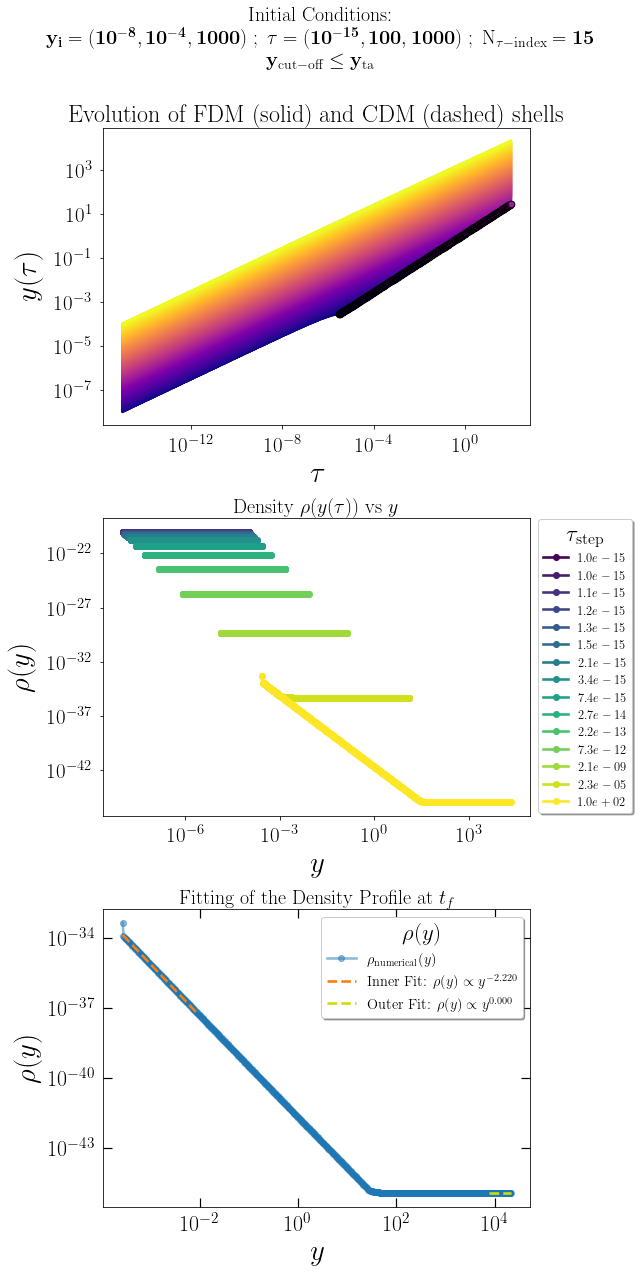

 Fitted slope (inner core):    \rho(y) \propto y^{-2.220}
 Fitted slope (outer tail):    \rho(y) \propto y^{0.000}


In [28]:
# for 1000 FDM shells

t_i, t_f = 1e-15, 1e2
N = 1000
r_min, r_max = 1e-8, 1e-4
ri_arr = np.geomspace(r_min, r_max, N)
initial_density = 1e-20


delta_M_arr = shells_mass(ri_arr, N, initial_density)
QP = True
gravity = True
Hubble = True


t_step = 1000
t_arr = np.geomspace(t_i, t_f, t_step)
dt = np.gradient(t_arr)

r_sol = np.zeros((N, len(t_arr)))
v_sol = np.zeros((N, len(t_arr)))
rho_sol = np.zeros((N, len(t_arr)))
mask_active = np.ones(N, dtype=bool)
cutoff_index = np.full(N, len(t_arr))
t_ta_arr = np.full(N, np.nan)
r_ta_arr = np.full(N, np.nan)
turnaround_detected = np.zeros(N, dtype=bool)
r_sol[:, 0] = ri_arr
v_sol[:, 0] = ri_arr/(2 * t_arr[0])




freeze_fraction= 1
r_sol, v_sol, rho_sol, QP_arr, cutoff_index, r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask = shells_evolution(N, t_arr, dt, ri_arr, Hubble, gravity, QP, freeze_fraction)
time_indices = np.geomspace(1, t_step-1 , 15, dtype=int)




fig, axs = plt.subplots(3, 1, figsize=(9, 18), sharex=False)
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
colors_shell = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
colors1 = cm.viridis(np.linspace(0, 1, len(time_indices)))
colors2 = cm.plasma(np.linspace(0, 1, N))
colors3 = cm.magma(np.linspace(0, 1, len(time_indices)))



#------------------------------------------------------
ax = axs[0]


QP = False
gravity = True
Hubble = True
r_sol_no_qp, v_sol_no_qp, rho_sol_no_qp, QP_arr_no_qp, cutoff_index_no_qp,  r_ta_arr_no_qp, t_ta_arr_no_qp, rho_arr_no_qp, rta_mask_no_qp, tta_mask_no_qp = shells_evolution(N, t_arr, dt, ri_arr,  
Hubble, gravity, QP, freeze_fraction)


for j in range(N):
    cutoff = cutoff_index_no_qp[j]
    ax.loglog(t_arr[:cutoff], r_sol_no_qp[j, :cutoff], color=colors2[j], linestyle='--', alpha=0.7)
    if not np.isnan(t_ta_arr_no_qp[j]):
        ax.scatter(t_ta_arr_no_qp[j], r_ta_arr_no_qp[j], marker='o', s=30, color=colors2[j], edgecolor='k', alpha=0.3)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol_no_qp[j, cutoff - 1], marker='x', s=35, color=colors_shell[j], alpha=0.3)

# Plot FDM shells (with QP) with solid lines
for j in range(N):
    cutoff = cutoff_index[j]
    ax.loglog(t_arr[:cutoff], r_sol[j, :cutoff], color=colors2[j], linestyle='-', alpha=1.0, label=fr'${ri_arr[j]:.1e}$')
    if not np.isnan(t_ta_arr[j]):
        ax.scatter(t_ta_arr[j], r_ta_arr[j], marker='o', s=45, color=colors2[j], edgecolor='k', zorder=5)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol[j, cutoff - 1], marker='x', s=50, color=colors_shell[j], zorder=5)

# Labels, title and legend
ax.set_xlabel(r'$\tau$', fontsize=29, labelpad=6)
ax.set_ylabel(r'$y(\tau)$', fontsize=29, labelpad=11)
ax.set_title('Evolution of FDM (solid) and CDM (dashed) shells', fontsize=24)
ax.tick_params(axis='x', labelsize=21, pad=7.9)
ax.tick_params(axis='y', labelsize=21, pad=7.9)

#handles, labels = ax.get_legend_handles_labels()
#legend_shells = ax.legend(handles[:7], labels[:7], prop={'size': 12.5},
                        #  loc=(1.02, 0.13), shadow=True, title='$y_{i}$', title_fontsize=27,
                        #  facecolor='white', fontsize=25)

#legend_lines = [Line2D([0], [0], color='k', linestyle='-', lw=2),
               # Line2D([0], [0], color='k', linestyle='--', lw=2)]
#ax.legend(legend_lines, ['FDM', 'CDM'], prop={'size': 15.5}, loc=(1.02, 0.64),
         # shadow=True, title='Shell', title_fontsize=23,
         # facecolor='white', fontsize=20)
#ax.add_artist(legend_shells)









#----------------------------------------------------------
#Density vs time at different time steps


ax = axs[1]
for i, idx in enumerate(time_indices):
    r_at_time_index = r_sol[:, idx]
    rho_at_time_index = rho_sol[:, idx]
    ax.loglog(r_at_time_index, rho_at_time_index, marker='o', label=r'$ {0:.1e}$'.format(t_arr[idx]), color=colors1[i])


ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)  
#ax.text(5, 1e-24, '$y_i = (10^{-8}, 10^{-4}, 7)$', fontsize = 18)
#ax.text(5, 1e-27, '$N_\mathrm{time-indices} = 15$', fontsize = 18)
ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 11)
ax.legend( prop = {'size':12.5},loc = (1.02, 0.01),shadow = True, title = r'$\tau_\mathrm{step}$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 23)
ax.set_title(r'Density Profile at Different times steps', fontsize= 24)
ax.set_title(r' Density $\rho(y(\tau))$ vs $y$ ', fontsize=20)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 



#--------------------------------------------------------------------------------



###################################
# Fitting the density profile
ax = axs[2]


def f_fitting(x, m, b):
    return (m*x) + b


final_idx = -1
r_final = r_sol[:, final_idx]
rho_final = rho_sol[:, final_idx]
mask = (r_final > 0) & (rho_final > 0)
r_valid = r_final[mask]
rho_valid = rho_final[mask]


# Sort by radius
sorted_idx = np.argsort(r_valid)
r_valid = r_valid[sorted_idx]
rho_valid = rho_valid[sorted_idx]

# Define regions
inner_N = 100
outer_N = 110

# Inner region
r_inner = r_valid[:inner_N]
rho_inner = rho_valid[:inner_N]
log_r_inner = np.log10(r_inner)
log_rho_inner = np.log10(rho_inner)
popt_inner, _ = curve_fit(f_fitting, log_r_inner, log_rho_inner)
m_inner, b_inner = popt_inner
rho_fit_inner = 10**f_fitting(log_r_inner, *popt_inner)


# Outer region
r_outer = r_valid[-outer_N:]
rho_outer = rho_valid[-outer_N:]
log_r_outer = np.log10(r_outer)
log_rho_outer = np.log10(rho_outer)
popt_outer, _ = curve_fit(f_fitting, log_r_outer, log_rho_outer)
m_outer, b_outer = popt_outer
rho_fit_outer = 10**f_fitting(log_r_outer, *popt_outer)




ax.loglog(r_valid, rho_valid, 'o-', color='C0', alpha = 0.5)
ax.loglog(r_inner, rho_fit_inner, '--', color='C1')
#ax.loglog(r_middle, rho_fit_middle, '--', color='C3')
ax.loglog(r_outer, rho_fit_outer, '--', color='#d0db0b')


#plt.text(1e-14, 1e-45, '$y_i = (10^{-8}, 10^{-4}, 10)$', fontsize=18)
#plt.text(1e-14, 1e-49, '$(t_i, t_f, t_\\mathrm{steps}) = (10^{-15}, 10^{5}, 10000)$', fontsize=15)

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)

ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=22) 
ax.yaxis.set_tick_params(labelsize=22) 

ax.set_title('Fitting of the Density Profile at $t_f$', fontsize=20)
ax.legend([r'$\rho_\mathrm{numerical}(y)$', fr'Inner Fit: $\rho(y) \propto y^{{{m_inner:.3f}}}$',
           
           fr'Outer Fit: $\rho(y) \propto y^{{{m_outer:.3f}}}$'], 
           prop = {'size':14.5},loc = 'upper right', shadow = True, 
           title = r'$\rho(y)$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 31)




#---------------------------------------------------------------------



plt.suptitle(r'Initial Conditions:' + '\n' + 
    r'$\mathbf{y_i = (10^{-8}, 10^{-4}, 1000)\; ;\;\tau = (10^{-15}, 100, 1000)\; ;\;\mathrm{N_{\tau-index}} = 15}$'
              '\n' + r'$\mathbf{y_\mathrm{cut-off} \leq  y_\mathrm{ta}}$' , fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('rho&qp_N1000_t1000.pdf', bbox_inches='tight')
plt.show()



#--------------------------------------------------------------------

print(fr' Fitted slope (inner core):    \rho(y) \propto y^{{{m_inner:.3f}}}')
print(fr' Fitted slope (outer tail):    \rho(y) \propto y^{{{m_outer:.3f}}}')





np.savez('fdm_cdm_N1000_t1000_rta.npz',
         # FDM arrays
         r_sol_fdm=r_sol,
         v_sol_fdm=v_sol,
         rho_sol_fdm=rho_sol,
         QP_arr_fdm= QP_arr,
         cutoff_index_fdm=cutoff_index,
         r_ta_arr_fdm=r_ta_arr,
         t_ta_arr_fdm=t_ta_arr,
         rho_arr_fdm = rho_arr,
         rta_mask_fdm = rta_mask,
         tta_mask_fdm = tta_mask,
         
         
         # CDM arrays
         r_sol_cdm=r_sol_no_qp,
         v_sol_cdm=v_sol_no_qp,
         rho_sol_cdm=rho_sol_no_qp,
         QP_arr_cdm= QP_arr_no_qp,
         cutoff_index_cdm=cutoff_index_no_qp,
         r_ta_arr_cdm=r_ta_arr_no_qp,
         t_ta_arr_cdm=t_ta_arr_no_qp,
         rho_arr_cdm = rho_arr_no_qp,
         rta_mask_cdm = rta_mask_no_qp,
         tta_mask_cdm = tta_mask_no_qp)



No shells crossings is detected.


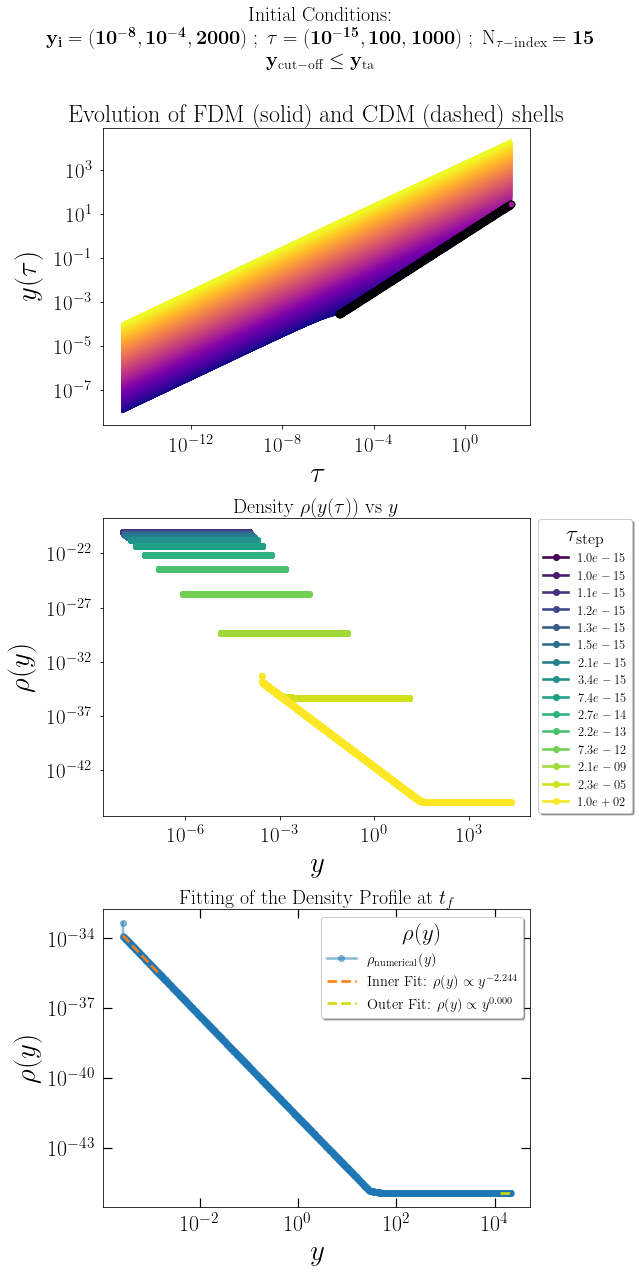

 Fitted slope (inner core):    \rho(y) \propto y^{-2.244}
 Fitted slope (outer tail):    \rho(y) \propto y^{0.000}


In [35]:
# for 2000 FDM shells

t_i, t_f = 1e-15, 1e2
N = 2000
r_min, r_max = 1e-8, 1e-4
ri_arr = np.geomspace(r_min, r_max, N)
initial_density = 1e-20


delta_M_arr = shells_mass(ri_arr, N, initial_density)
QP = True
gravity = True
Hubble = True


t_step = 1000
t_arr = np.geomspace(t_i, t_f, t_step)
dt = np.gradient(t_arr)

r_sol = np.zeros((N, len(t_arr)))
v_sol = np.zeros((N, len(t_arr)))
rho_sol = np.zeros((N, len(t_arr)))
mask_active = np.ones(N, dtype=bool)
cutoff_index = np.full(N, len(t_arr))
t_ta_arr = np.full(N, np.nan)
r_ta_arr = np.full(N, np.nan)
turnaround_detected = np.zeros(N, dtype=bool)
r_sol[:, 0] = ri_arr
v_sol[:, 0] = ri_arr/(2 * t_arr[0])




freeze_fraction= 1
r_sol, v_sol, rho_sol, QP_arr, cutoff_index, r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask = shells_evolution(N, t_arr, dt, ri_arr, Hubble, gravity, QP, freeze_fraction)
time_indices = np.geomspace(1, t_step-1 , 15, dtype=int)




fig, axs = plt.subplots(3, 1, figsize=(9, 18), sharex=False)
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
colors_shell = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
colors1 = cm.viridis(np.linspace(0, 1, len(time_indices)))
colors2 = cm.plasma(np.linspace(0, 1, N))
colors3 = cm.magma(np.linspace(0, 1, len(time_indices)))



#------------------------------------------------------
ax = axs[0]


QP = False
gravity = True
Hubble = True
r_sol_no_qp, v_sol_no_qp, rho_sol_no_qp, QP_arr_no_qp, cutoff_index_no_qp,  r_ta_arr_no_qp, t_ta_arr_no_qp, rho_arr_no_qp, rta_mask_no_qp, tta_mask_no_qp = shells_evolution(N, t_arr, dt, ri_arr,  
Hubble, gravity, QP, freeze_fraction)


for j in range(N):
    cutoff = cutoff_index_no_qp[j]
    ax.loglog(t_arr[:cutoff], r_sol_no_qp[j, :cutoff], color=colors2[j], linestyle='--', alpha=0.7)
    if not np.isnan(t_ta_arr_no_qp[j]):
        ax.scatter(t_ta_arr_no_qp[j], r_ta_arr_no_qp[j], marker='o', s=30, color=colors2[j], edgecolor='k', alpha=0.3)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol_no_qp[j, cutoff - 1], marker='x', s=35, color=colors_shell[j], alpha=0.3)

# Plot FDM shells (with QP) with solid lines
for j in range(N):
    cutoff = cutoff_index[j]
    ax.loglog(t_arr[:cutoff], r_sol[j, :cutoff], color=colors2[j], linestyle='-', alpha=1.0, label=fr'${ri_arr[j]:.1e}$')
    if not np.isnan(t_ta_arr[j]):
        ax.scatter(t_ta_arr[j], r_ta_arr[j], marker='o', s=45, color=colors2[j], edgecolor='k', zorder=5)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol[j, cutoff - 1], marker='x', s=50, color=colors_shell[j], zorder=5)

# Labels, title and legend
ax.set_xlabel(r'$\tau$', fontsize=29, labelpad=6)
ax.set_ylabel(r'$y(\tau)$', fontsize=29, labelpad=11)
ax.set_title('Evolution of FDM (solid) and CDM (dashed) shells', fontsize=24)
ax.tick_params(axis='x', labelsize=21, pad=7.9)
ax.tick_params(axis='y', labelsize=21, pad=7.9)

#handles, labels = ax.get_legend_handles_labels()
#legend_shells = ax.legend(handles[:7], labels[:7], prop={'size': 12.5},
                        #  loc=(1.02, 0.13), shadow=True, title='$y_{i}$', title_fontsize=27,
                        #  facecolor='white', fontsize=25)

#legend_lines = [Line2D([0], [0], color='k', linestyle='-', lw=2),
               # Line2D([0], [0], color='k', linestyle='--', lw=2)]
#ax.legend(legend_lines, ['FDM', 'CDM'], prop={'size': 15.5}, loc=(1.02, 0.64),
         # shadow=True, title='Shell', title_fontsize=23,
         # facecolor='white', fontsize=20)
#ax.add_artist(legend_shells)









#----------------------------------------------------------
#Density vs time at different time steps


ax = axs[1]
for i, idx in enumerate(time_indices):
    r_at_time_index = r_sol[:, idx]
    rho_at_time_index = rho_sol[:, idx]
    ax.loglog(r_at_time_index, rho_at_time_index, marker='o', label=r'$ {0:.1e}$'.format(t_arr[idx]), color=colors1[i])


ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)  
#ax.text(5, 1e-24, '$y_i = (10^{-8}, 10^{-4}, 7)$', fontsize = 18)
#ax.text(5, 1e-27, '$N_\mathrm{time-indices} = 15$', fontsize = 18)
ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 11)
ax.legend( prop = {'size':12.5},loc = (1.02, 0.01),shadow = True, title = r'$\tau_\mathrm{step}$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 23)
ax.set_title(r'Density Profile at Different times steps', fontsize= 24)
ax.set_title(r' Density $\rho(y(\tau))$ vs $y$ ', fontsize=20)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 



#--------------------------------------------------------------------------------



###################################
# Fitting the density profile
ax = axs[2]


def f_fitting(x, m, b):
    return (m*x) + b


final_idx = -1
r_final = r_sol[:, final_idx]
rho_final = rho_sol[:, final_idx]
mask = (r_final > 0) & (rho_final > 0)
r_valid = r_final[mask]
rho_valid = rho_final[mask]


# Sort by radius
sorted_idx = np.argsort(r_valid)
r_valid = r_valid[sorted_idx]
rho_valid = rho_valid[sorted_idx]

# Define regions
inner_N = 100
outer_N = 110

# Inner region
r_inner = r_valid[:inner_N]
rho_inner = rho_valid[:inner_N]
log_r_inner = np.log10(r_inner)
log_rho_inner = np.log10(rho_inner)
popt_inner, _ = curve_fit(f_fitting, log_r_inner, log_rho_inner)
m_inner, b_inner = popt_inner
rho_fit_inner = 10**f_fitting(log_r_inner, *popt_inner)


# Outer region
r_outer = r_valid[-outer_N:]
rho_outer = rho_valid[-outer_N:]
log_r_outer = np.log10(r_outer)
log_rho_outer = np.log10(rho_outer)
popt_outer, _ = curve_fit(f_fitting, log_r_outer, log_rho_outer)
m_outer, b_outer = popt_outer
rho_fit_outer = 10**f_fitting(log_r_outer, *popt_outer)




ax.loglog(r_valid, rho_valid, 'o-', color='C0', alpha = 0.5)
ax.loglog(r_inner, rho_fit_inner, '--', color='C1')
#ax.loglog(r_middle, rho_fit_middle, '--', color='C3')
ax.loglog(r_outer, rho_fit_outer, '--', color='#d0db0b')


#plt.text(1e-14, 1e-45, '$y_i = (10^{-8}, 10^{-4}, 10)$', fontsize=18)
#plt.text(1e-14, 1e-49, '$(t_i, t_f, t_\\mathrm{steps}) = (10^{-15}, 10^{5}, 10000)$', fontsize=15)

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)

ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=22) 
ax.yaxis.set_tick_params(labelsize=22) 

ax.set_title('Fitting of the Density Profile at $t_f$', fontsize=20)
ax.legend([r'$\rho_\mathrm{numerical}(y)$', fr'Inner Fit: $\rho(y) \propto y^{{{m_inner:.3f}}}$',
           
           fr'Outer Fit: $\rho(y) \propto y^{{{m_outer:.3f}}}$'], 
           prop = {'size':14.5},loc = 'upper right', shadow = True, 
           title = r'$\rho(y)$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 31)




#---------------------------------------------------------------------



plt.suptitle(r'Initial Conditions:' + '\n' + 
    r'$\mathbf{y_i = (10^{-8}, 10^{-4}, 2000)\; ;\;\tau = (10^{-15}, 100, 1000)\; ;\;\mathrm{N_{\tau-index}} = 15}$'
              '\n' + r'$\mathbf{y_\mathrm{cut-off} \leq  y_\mathrm{ta}}$' , fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('rho&qp_N2000_t1000.pdf', bbox_inches='tight')
plt.show()



#--------------------------------------------------------------------

print(fr' Fitted slope (inner core):    \rho(y) \propto y^{{{m_inner:.3f}}}')
print(fr' Fitted slope (outer tail):    \rho(y) \propto y^{{{m_outer:.3f}}}')





np.savez('fdm_cdm_N2000_t1000_rta.npz',
         # FDM arrays
         r_sol_fdm=r_sol,
         v_sol_fdm=v_sol,
         rho_sol_fdm=rho_sol,
         QP_arr_fdm= QP_arr,
         cutoff_index_fdm=cutoff_index,
         r_ta_arr_fdm=r_ta_arr,
         t_ta_arr_fdm=t_ta_arr,
         rho_arr_fdm = rho_arr,
         rta_mask_fdm = rta_mask,
         tta_mask_fdm = tta_mask,
         
         
         # CDM arrays
         r_sol_cdm=r_sol_no_qp,
         v_sol_cdm=v_sol_no_qp,
         rho_sol_cdm=rho_sol_no_qp,
         QP_arr_cdm= QP_arr_no_qp,
         cutoff_index_cdm=cutoff_index_no_qp,
         r_ta_arr_cdm=r_ta_arr_no_qp,
         t_ta_arr_cdm=t_ta_arr_no_qp,
         rho_arr_cdm = rho_arr_no_qp,
         rta_mask_cdm = rta_mask_no_qp,
         tta_mask_cdm = tta_mask_no_qp)



In [28]:
## N_tau_steps = 10000, N_tau_index/snapshots = 15

No shells crossings is detected.


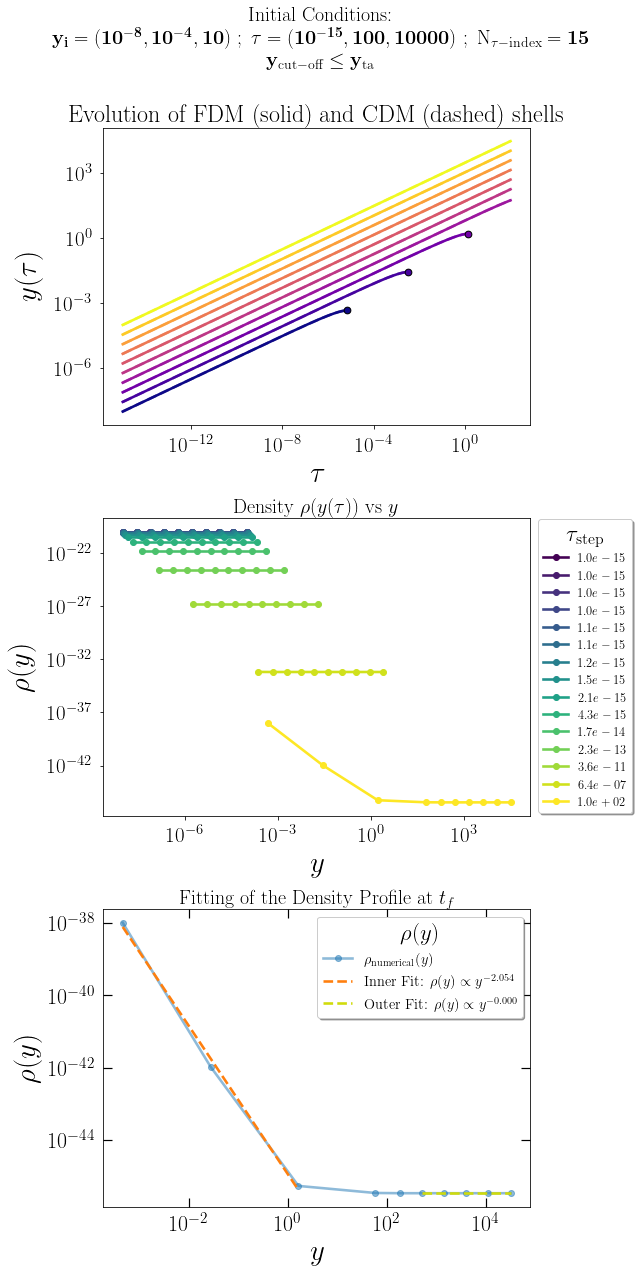

 Fitted slope (inner core):    \rho(y) \propto y^{-2.054}
 Fitted slope (outer tail):    \rho(y) \propto y^{-0.000}


In [8]:
# for 10 FDM shells

t_i, t_f = 1e-15, 1e2
N = 10
r_min, r_max = 1e-8, 1e-4
ri_arr = np.geomspace(r_min, r_max, N)
initial_density = 1e-20


delta_M_arr = shells_mass(ri_arr, N, initial_density)
QP = True
gravity = True
Hubble = True


t_step = 10000
t_arr = np.geomspace(t_i, t_f, t_step)
dt = np.gradient(t_arr)

r_sol = np.zeros((N, len(t_arr)))
v_sol = np.zeros((N, len(t_arr)))
rho_sol = np.zeros((N, len(t_arr)))
mask_active = np.ones(N, dtype=bool)
cutoff_index = np.full(N, len(t_arr))
t_ta_arr = np.full(N, np.nan)
r_ta_arr = np.full(N, np.nan)
turnaround_detected = np.zeros(N, dtype=bool)
r_sol[:, 0] = ri_arr
v_sol[:, 0] = ri_arr/(2 * t_arr[0])




freeze_fraction= 1
r_sol, v_sol, rho_sol, QP_arr, cutoff_index, r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask = shells_evolution(N, t_arr, dt, ri_arr, Hubble, gravity, QP, freeze_fraction)
time_indices = np.geomspace(1, t_step-1 , 15, dtype=int)




fig, axs = plt.subplots(3, 1, figsize=(9, 18), sharex=False)
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
colors_shell = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
colors1 = cm.viridis(np.linspace(0, 1, len(time_indices)))
colors2 = cm.plasma(np.linspace(0, 1, N))
colors3 = cm.magma(np.linspace(0, 1, len(time_indices)))



#------------------------------------------------------
ax = axs[0]


QP = False
gravity = True
Hubble = True
r_sol_no_qp, v_sol_no_qp, rho_sol_no_qp, QP_arr_no_qp, cutoff_index_no_qp,  r_ta_arr_no_qp, t_ta_arr_no_qp, rho_arr_no_qp, rta_mask_no_qp, tta_mask_no_qp = shells_evolution(N, t_arr, dt, ri_arr,  
Hubble, gravity, QP, freeze_fraction)


for j in range(N):
    cutoff = cutoff_index_no_qp[j]
    ax.loglog(t_arr[:cutoff], r_sol_no_qp[j, :cutoff], color=colors2[j], linestyle='--', alpha=0.7)
    if not np.isnan(t_ta_arr_no_qp[j]):
        ax.scatter(t_ta_arr_no_qp[j], r_ta_arr_no_qp[j], marker='o', s=30, color=colors2[j], edgecolor='k', alpha=0.3)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol_no_qp[j, cutoff - 1], marker='x', s=35, color=colors_shell[j], alpha=0.3)

# Plot FDM shells (with QP) with solid lines
for j in range(N):
    cutoff = cutoff_index[j]
    ax.loglog(t_arr[:cutoff], r_sol[j, :cutoff], color=colors2[j], linestyle='-', alpha=1.0, label=fr'${ri_arr[j]:.1e}$')
    if not np.isnan(t_ta_arr[j]):
        ax.scatter(t_ta_arr[j], r_ta_arr[j], marker='o', s=45, color=colors2[j], edgecolor='k', zorder=5)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol[j, cutoff - 1], marker='x', s=50, color=colors_shell[j], zorder=5)

# Labels, title and legend
ax.set_xlabel(r'$\tau$', fontsize=29, labelpad=6)
ax.set_ylabel(r'$y(\tau)$', fontsize=29, labelpad=11)
ax.set_title('Evolution of FDM (solid) and CDM (dashed) shells', fontsize=24)
ax.tick_params(axis='x', labelsize=21, pad=7.9)
ax.tick_params(axis='y', labelsize=21, pad=7.9)

#handles, labels = ax.get_legend_handles_labels()
#legend_shells = ax.legend(handles[:7], labels[:7], prop={'size': 12.5},
                        #  loc=(1.02, 0.13), shadow=True, title='$y_{i}$', title_fontsize=27,
                        #  facecolor='white', fontsize=25)

#legend_lines = [Line2D([0], [0], color='k', linestyle='-', lw=2),
               # Line2D([0], [0], color='k', linestyle='--', lw=2)]
#ax.legend(legend_lines, ['FDM', 'CDM'], prop={'size': 15.5}, loc=(1.02, 0.64),
         # shadow=True, title='Shell', title_fontsize=23,
         # facecolor='white', fontsize=20)
#ax.add_artist(legend_shells)









#----------------------------------------------------------
#Density vs time at different time steps


ax = axs[1]
for i, idx in enumerate(time_indices):
    r_at_time_index = r_sol[:, idx]
    rho_at_time_index = rho_sol[:, idx]
    ax.loglog(r_at_time_index, rho_at_time_index, marker='o', label=r'$ {0:.1e}$'.format(t_arr[idx]), color=colors1[i])


ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)  
#ax.text(5, 1e-24, '$y_i = (10^{-8}, 10^{-4}, 7)$', fontsize = 18)
#ax.text(5, 1e-27, '$N_\mathrm{time-indices} = 15$', fontsize = 18)
ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 11)
ax.legend( prop = {'size':12.5},loc = (1.02, 0.01),shadow = True, title = r'$\tau_\mathrm{step}$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 23)
ax.set_title(r'Density Profile at Different times steps', fontsize= 24)
ax.set_title(r' Density $\rho(y(\tau))$ vs $y$ ', fontsize=20)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 



#--------------------------------------------------------------------------------



###################################
# Fitting the density profile
ax = axs[2]


def f_fitting(x, m, b):
    return (m*x) + b


final_idx = -1
r_final = r_sol[:, final_idx]
rho_final = rho_sol[:, final_idx]
mask = (r_final > 0) & (rho_final > 0)
r_valid = r_final[mask]
rho_valid = rho_final[mask]


# Sort by radius
sorted_idx = np.argsort(r_valid)
r_valid = r_valid[sorted_idx]
rho_valid = rho_valid[sorted_idx]

# Define regions
inner_N = 3
outer_N = 5

# Inner region
r_inner = r_valid[:inner_N]
rho_inner = rho_valid[:inner_N]
log_r_inner = np.log10(r_inner)
log_rho_inner = np.log10(rho_inner)
popt_inner, _ = curve_fit(f_fitting, log_r_inner, log_rho_inner)
m_inner, b_inner = popt_inner
rho_fit_inner = 10**f_fitting(log_r_inner, *popt_inner)


# Outer region
r_outer = r_valid[-outer_N:]
rho_outer = rho_valid[-outer_N:]
log_r_outer = np.log10(r_outer)
log_rho_outer = np.log10(rho_outer)
popt_outer, _ = curve_fit(f_fitting, log_r_outer, log_rho_outer)
m_outer, b_outer = popt_outer
rho_fit_outer = 10**f_fitting(log_r_outer, *popt_outer)




ax.loglog(r_valid, rho_valid, 'o-', color='C0', alpha = 0.5)
ax.loglog(r_inner, rho_fit_inner, '--', color='C1')
#ax.loglog(r_middle, rho_fit_middle, '--', color='C3')
ax.loglog(r_outer, rho_fit_outer, '--', color='#d0db0b')


#plt.text(1e-14, 1e-45, '$y_i = (10^{-8}, 10^{-4}, 10)$', fontsize=18)
#plt.text(1e-14, 1e-49, '$(t_i, t_f, t_\\mathrm{steps}) = (10^{-15}, 10^{5}, 10000)$', fontsize=15)

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)

ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=22) 
ax.yaxis.set_tick_params(labelsize=22) 

ax.set_title('Fitting of the Density Profile at $t_f$', fontsize=20)
ax.legend([r'$\rho_\mathrm{numerical}(y)$', fr'Inner Fit: $\rho(y) \propto y^{{{m_inner:.3f}}}$',
           
           fr'Outer Fit: $\rho(y) \propto y^{{{m_outer:.3f}}}$'], 
           prop = {'size':14.5},loc = 'upper right', shadow = True, 
           title = r'$\rho(y)$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 31)




#---------------------------------------------------------------------



plt.suptitle(r'Initial Conditions:' + '\n' + 
    r'$\mathbf{y_i = (10^{-8}, 10^{-4}, 10)\; ;\;\tau = (10^{-15}, 100, 10000)\; ;\;\mathrm{N_{\tau-index}} = 15}$'
              '\n' + r'$\mathbf{y_\mathrm{cut-off} \leq  y_\mathrm{ta}}$' , fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('rho&qp_N10_t10000.pdf', bbox_inches='tight')
plt.show()



#--------------------------------------------------------------------

print(fr' Fitted slope (inner core):    \rho(y) \propto y^{{{m_inner:.3f}}}')
print(fr' Fitted slope (outer tail):    \rho(y) \propto y^{{{m_outer:.3f}}}')





np.savez('fdm_cdm_N10_t10000_rta.npz',
         # FDM arrays
         r_sol_fdm=r_sol,
         v_sol_fdm=v_sol,
         rho_sol_fdm=rho_sol,
         QP_arr_fdm= QP_arr,
         cutoff_index_fdm=cutoff_index,
         r_ta_arr_fdm=r_ta_arr,
         t_ta_arr_fdm=t_ta_arr,
         rho_arr_fdm = rho_arr,
         rta_mask_fdm = rta_mask,
         tta_mask_fdm = tta_mask,
         
         
         # CDM arrays
         r_sol_cdm=r_sol_no_qp,
         v_sol_cdm=v_sol_no_qp,
         rho_sol_cdm=rho_sol_no_qp,
         QP_arr_cdm= QP_arr_no_qp,
         cutoff_index_cdm=cutoff_index_no_qp,
         r_ta_arr_cdm=r_ta_arr_no_qp,
         t_ta_arr_cdm=t_ta_arr_no_qp,
         rho_arr_cdm = rho_arr_no_qp,
         rta_mask_cdm = rta_mask_no_qp,
         tta_mask_cdm = tta_mask_no_qp)



No shells crossings is detected.


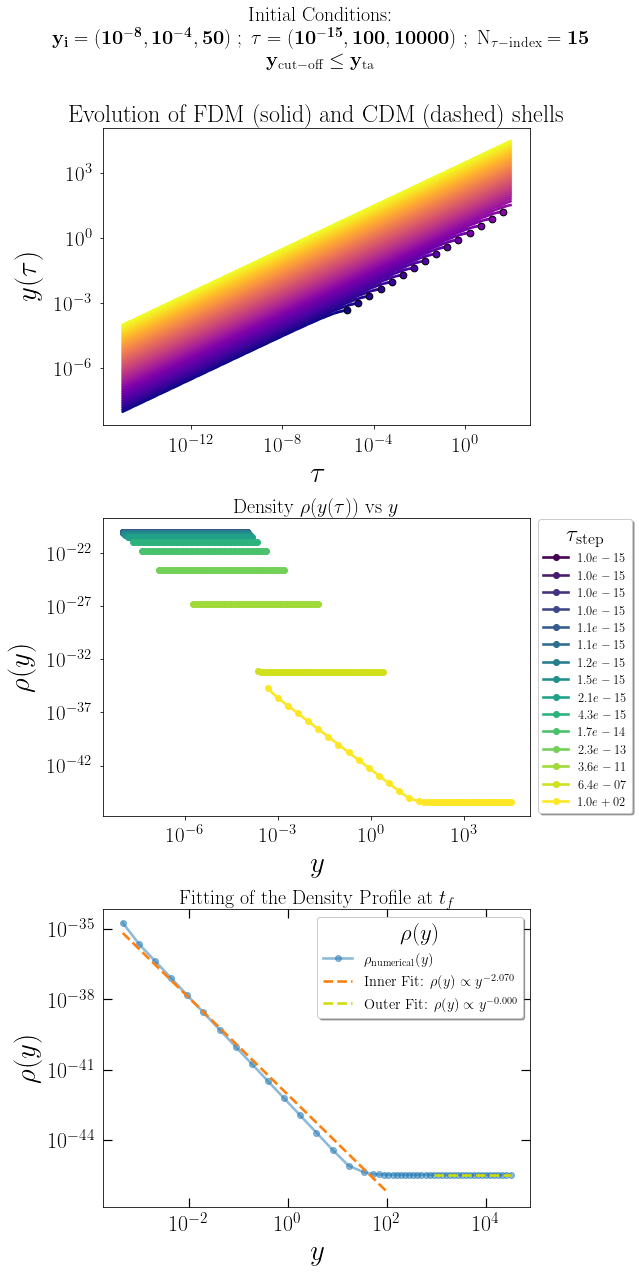

 Fitted slope (inner core):    \rho(y) \propto y^{-2.070}
 Fitted slope (outer tail):    \rho(y) \propto y^{-0.000}


In [8]:
# for 50 FDM shells

t_i, t_f = 1e-15, 1e2
N = 50
r_min, r_max = 1e-8, 1e-4
ri_arr = np.geomspace(r_min, r_max, N)
initial_density = 1e-20


delta_M_arr = shells_mass(ri_arr, N, initial_density)
QP = True
gravity = True
Hubble = True


t_step = 10000
t_arr = np.geomspace(t_i, t_f, t_step)
dt = np.gradient(t_arr)

r_sol = np.zeros((N, len(t_arr)))
v_sol = np.zeros((N, len(t_arr)))
rho_sol = np.zeros((N, len(t_arr)))
mask_active = np.ones(N, dtype=bool)
cutoff_index = np.full(N, len(t_arr))
t_ta_arr = np.full(N, np.nan)
r_ta_arr = np.full(N, np.nan)
turnaround_detected = np.zeros(N, dtype=bool)
r_sol[:, 0] = ri_arr
v_sol[:, 0] = ri_arr/(2 * t_arr[0])




freeze_fraction= 1
r_sol, v_sol, rho_sol, QP_arr, cutoff_index, r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask = shells_evolution(N, t_arr, dt, ri_arr, Hubble, gravity, QP, freeze_fraction)
time_indices = np.geomspace(1, t_step-1 , 15, dtype=int)




fig, axs = plt.subplots(3, 1, figsize=(9, 18), sharex=False)
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
colors_shell = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
colors1 = cm.viridis(np.linspace(0, 1, len(time_indices)))
colors2 = cm.plasma(np.linspace(0, 1, N))
colors3 = cm.magma(np.linspace(0, 1, len(time_indices)))



#------------------------------------------------------
ax = axs[0]


QP = False
gravity = True
Hubble = True
r_sol_no_qp, v_sol_no_qp, rho_sol_no_qp, QP_arr_no_qp, cutoff_index_no_qp,  r_ta_arr_no_qp, t_ta_arr_no_qp, rho_arr_no_qp, rta_mask_no_qp, tta_mask_no_qp = shells_evolution(N, t_arr, dt, ri_arr,  
Hubble, gravity, QP, freeze_fraction)


for j in range(N):
    cutoff = cutoff_index_no_qp[j]
    ax.loglog(t_arr[:cutoff], r_sol_no_qp[j, :cutoff], color=colors2[j], linestyle='--', alpha=0.7)
    if not np.isnan(t_ta_arr_no_qp[j]):
        ax.scatter(t_ta_arr_no_qp[j], r_ta_arr_no_qp[j], marker='o', s=30, color=colors2[j], edgecolor='k', alpha=0.3)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol_no_qp[j, cutoff - 1], marker='x', s=35, color=colors_shell[j], alpha=0.3)

# Plot FDM shells (with QP) with solid lines
for j in range(N):
    cutoff = cutoff_index[j]
    ax.loglog(t_arr[:cutoff], r_sol[j, :cutoff], color=colors2[j], linestyle='-', alpha=1.0, label=fr'${ri_arr[j]:.1e}$')
    if not np.isnan(t_ta_arr[j]):
        ax.scatter(t_ta_arr[j], r_ta_arr[j], marker='o', s=45, color=colors2[j], edgecolor='k', zorder=5)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol[j, cutoff - 1], marker='x', s=50, color=colors_shell[j], zorder=5)

# Labels, title and legend
ax.set_xlabel(r'$\tau$', fontsize=29, labelpad=6)
ax.set_ylabel(r'$y(\tau)$', fontsize=29, labelpad=11)
ax.set_title('Evolution of FDM (solid) and CDM (dashed) shells', fontsize=24)
ax.tick_params(axis='x', labelsize=21, pad=7.9)
ax.tick_params(axis='y', labelsize=21, pad=7.9)

#handles, labels = ax.get_legend_handles_labels()
#legend_shells = ax.legend(handles[:7], labels[:7], prop={'size': 12.5},
                        #  loc=(1.02, 0.13), shadow=True, title='$y_{i}$', title_fontsize=27,
                        #  facecolor='white', fontsize=25)

#legend_lines = [Line2D([0], [0], color='k', linestyle='-', lw=2),
               # Line2D([0], [0], color='k', linestyle='--', lw=2)]
#ax.legend(legend_lines, ['FDM', 'CDM'], prop={'size': 15.5}, loc=(1.02, 0.64),
         # shadow=True, title='Shell', title_fontsize=23,
         # facecolor='white', fontsize=20)
#ax.add_artist(legend_shells)









#----------------------------------------------------------
#Density vs time at different time steps


ax = axs[1]
for i, idx in enumerate(time_indices):
    r_at_time_index = r_sol[:, idx]
    rho_at_time_index = rho_sol[:, idx]
    ax.loglog(r_at_time_index, rho_at_time_index, marker='o', label=r'$ {0:.1e}$'.format(t_arr[idx]), color=colors1[i])


ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)  
#ax.text(5, 1e-24, '$y_i = (10^{-8}, 10^{-4}, 7)$', fontsize = 18)
#ax.text(5, 1e-27, '$N_\mathrm{time-indices} = 15$', fontsize = 18)
ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 11)
ax.legend( prop = {'size':12.5},loc = (1.02, 0.01),shadow = True, title = r'$\tau_\mathrm{step}$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 23)
ax.set_title(r'Density Profile at Different times steps', fontsize= 24)
ax.set_title(r' Density $\rho(y(\tau))$ vs $y$ ', fontsize=20)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 



#--------------------------------------------------------------------------------



###################################
# Fitting the density profile
ax = axs[2]


def f_fitting(x, m, b):
    return (m*x) + b


final_idx = -1
r_final = r_sol[:, final_idx]
rho_final = rho_sol[:, final_idx]
mask = (r_final > 0) & (rho_final > 0)
r_valid = r_final[mask]
rho_valid = rho_final[mask]


# Sort by radius
sorted_idx = np.argsort(r_valid)
r_valid = r_valid[sorted_idx]
rho_valid = rho_valid[sorted_idx]

# Define regions
inner_N = 20
outer_N = 20

# Inner region
r_inner = r_valid[:inner_N]
rho_inner = rho_valid[:inner_N]
log_r_inner = np.log10(r_inner)
log_rho_inner = np.log10(rho_inner)
popt_inner, _ = curve_fit(f_fitting, log_r_inner, log_rho_inner)
m_inner, b_inner = popt_inner
rho_fit_inner = 10**f_fitting(log_r_inner, *popt_inner)


# Outer region
r_outer = r_valid[-outer_N:]
rho_outer = rho_valid[-outer_N:]
log_r_outer = np.log10(r_outer)
log_rho_outer = np.log10(rho_outer)
popt_outer, _ = curve_fit(f_fitting, log_r_outer, log_rho_outer)
m_outer, b_outer = popt_outer
rho_fit_outer = 10**f_fitting(log_r_outer, *popt_outer)




ax.loglog(r_valid, rho_valid, 'o-', color='C0', alpha = 0.5)
ax.loglog(r_inner, rho_fit_inner, '--', color='C1')
#ax.loglog(r_middle, rho_fit_middle, '--', color='C3')
ax.loglog(r_outer, rho_fit_outer, '--', color='#d0db0b')


#plt.text(1e-14, 1e-45, '$y_i = (10^{-8}, 10^{-4}, 10)$', fontsize=18)
#plt.text(1e-14, 1e-49, '$(t_i, t_f, t_\\mathrm{steps}) = (10^{-15}, 10^{5}, 10000)$', fontsize=15)

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)

ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=22) 
ax.yaxis.set_tick_params(labelsize=22) 

ax.set_title('Fitting of the Density Profile at $t_f$', fontsize=20)
ax.legend([r'$\rho_\mathrm{numerical}(y)$', fr'Inner Fit: $\rho(y) \propto y^{{{m_inner:.3f}}}$',
           
           fr'Outer Fit: $\rho(y) \propto y^{{{m_outer:.3f}}}$'], 
           prop = {'size':14.5},loc = 'upper right', shadow = True, 
           title = r'$\rho(y)$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 31)




#---------------------------------------------------------------------



plt.suptitle(r'Initial Conditions:' + '\n' + 
    r'$\mathbf{y_i = (10^{-8}, 10^{-4}, 50)\; ;\;\tau = (10^{-15}, 100, 10000)\; ;\;\mathrm{N_{\tau-index}} = 15}$'
              '\n' + r'$\mathbf{y_\mathrm{cut-off} \leq  y_\mathrm{ta}}$' , fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('rho&qp_N50_t10000.pdf', bbox_inches='tight')
plt.show()



#--------------------------------------------------------------------

print(fr' Fitted slope (inner core):    \rho(y) \propto y^{{{m_inner:.3f}}}')
print(fr' Fitted slope (outer tail):    \rho(y) \propto y^{{{m_outer:.3f}}}')





np.savez('fdm_cdm_N50_t10000_rta.npz',
         # FDM arrays
         r_sol_fdm=r_sol,
         v_sol_fdm=v_sol,
         rho_sol_fdm=rho_sol,
         QP_arr_fdm= QP_arr,
         cutoff_index_fdm=cutoff_index,
         r_ta_arr_fdm=r_ta_arr,
         t_ta_arr_fdm=t_ta_arr,
         rho_arr_fdm = rho_arr,
         rta_mask_fdm = rta_mask,
         tta_mask_fdm = tta_mask,
         
         
         # CDM arrays
         r_sol_cdm=r_sol_no_qp,
         v_sol_cdm=v_sol_no_qp,
         rho_sol_cdm=rho_sol_no_qp,
         QP_arr_cdm= QP_arr_no_qp,
         cutoff_index_cdm=cutoff_index_no_qp,
         r_ta_arr_cdm=r_ta_arr_no_qp,
         t_ta_arr_cdm=t_ta_arr_no_qp,
         rho_arr_cdm = rho_arr_no_qp,
         rta_mask_cdm = rta_mask_no_qp,
         tta_mask_cdm = tta_mask_no_qp)



No shells crossings is detected.


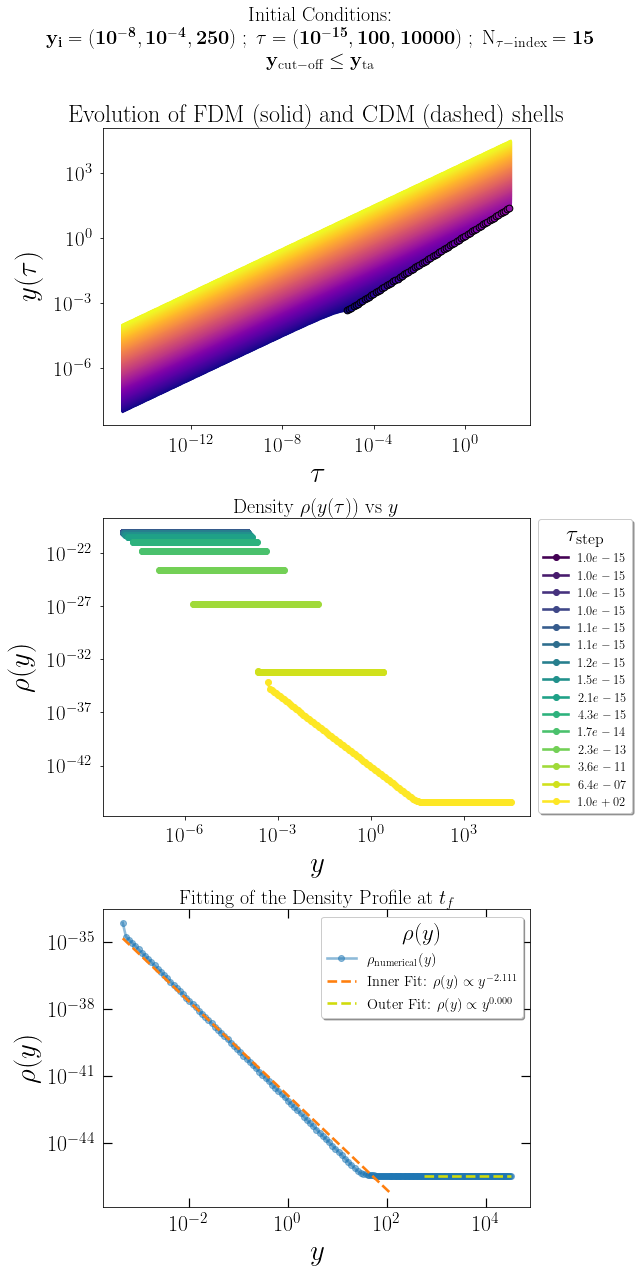

 Fitted slope (inner core):    \rho(y) \propto y^{-2.111}
 Fitted slope (outer tail):    \rho(y) \propto y^{0.000}


In [9]:
# for 250 FDM shells

t_i, t_f = 1e-15, 1e2
N = 250
r_min, r_max = 1e-8, 1e-4
ri_arr = np.geomspace(r_min, r_max, N)
initial_density = 1e-20


delta_M_arr = shells_mass(ri_arr, N, initial_density)
QP = True
gravity = True
Hubble = True


t_step = 10000
t_arr = np.geomspace(t_i, t_f, t_step)
dt = np.gradient(t_arr)

r_sol = np.zeros((N, len(t_arr)))
v_sol = np.zeros((N, len(t_arr)))
rho_sol = np.zeros((N, len(t_arr)))
mask_active = np.ones(N, dtype=bool)
cutoff_index = np.full(N, len(t_arr))
t_ta_arr = np.full(N, np.nan)
r_ta_arr = np.full(N, np.nan)
turnaround_detected = np.zeros(N, dtype=bool)
r_sol[:, 0] = ri_arr
v_sol[:, 0] = ri_arr/(2 * t_arr[0])




freeze_fraction= 1
r_sol, v_sol, rho_sol, QP_arr, cutoff_index, r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask = shells_evolution(N, t_arr, dt, ri_arr, Hubble, gravity, QP, freeze_fraction)
time_indices = np.geomspace(1, t_step-1 , 15, dtype=int)




fig, axs = plt.subplots(3, 1, figsize=(9, 18), sharex=False)
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
colors_shell = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
colors1 = cm.viridis(np.linspace(0, 1, len(time_indices)))
colors2 = cm.plasma(np.linspace(0, 1, N))
colors3 = cm.magma(np.linspace(0, 1, len(time_indices)))



#------------------------------------------------------
ax = axs[0]


QP = False
gravity = True
Hubble = True
r_sol_no_qp, v_sol_no_qp, rho_sol_no_qp, QP_arr_no_qp, cutoff_index_no_qp,  r_ta_arr_no_qp, t_ta_arr_no_qp, rho_arr_no_qp, rta_mask_no_qp, tta_mask_no_qp = shells_evolution(N, t_arr, dt, ri_arr,  
Hubble, gravity, QP, freeze_fraction)


for j in range(N):
    cutoff = cutoff_index_no_qp[j]
    ax.loglog(t_arr[:cutoff], r_sol_no_qp[j, :cutoff], color=colors2[j], linestyle='--', alpha=0.7)
    if not np.isnan(t_ta_arr_no_qp[j]):
        ax.scatter(t_ta_arr_no_qp[j], r_ta_arr_no_qp[j], marker='o', s=30, color=colors2[j], edgecolor='k', alpha=0.3)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol_no_qp[j, cutoff - 1], marker='x', s=35, color=colors_shell[j], alpha=0.3)

# Plot FDM shells (with QP) with solid lines
for j in range(N):
    cutoff = cutoff_index[j]
    ax.loglog(t_arr[:cutoff], r_sol[j, :cutoff], color=colors2[j], linestyle='-', alpha=1.0, label=fr'${ri_arr[j]:.1e}$')
    if not np.isnan(t_ta_arr[j]):
        ax.scatter(t_ta_arr[j], r_ta_arr[j], marker='o', s=45, color=colors2[j], edgecolor='k', zorder=5)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol[j, cutoff - 1], marker='x', s=50, color=colors_shell[j], zorder=5)

# Labels, title and legend
ax.set_xlabel(r'$\tau$', fontsize=29, labelpad=6)
ax.set_ylabel(r'$y(\tau)$', fontsize=29, labelpad=11)
ax.set_title('Evolution of FDM (solid) and CDM (dashed) shells', fontsize=24)
ax.tick_params(axis='x', labelsize=21, pad=7.9)
ax.tick_params(axis='y', labelsize=21, pad=7.9)

#handles, labels = ax.get_legend_handles_labels()
#legend_shells = ax.legend(handles[:7], labels[:7], prop={'size': 12.5},
                        #  loc=(1.02, 0.13), shadow=True, title='$y_{i}$', title_fontsize=27,
                        #  facecolor='white', fontsize=25)

#legend_lines = [Line2D([0], [0], color='k', linestyle='-', lw=2),
               # Line2D([0], [0], color='k', linestyle='--', lw=2)]
#ax.legend(legend_lines, ['FDM', 'CDM'], prop={'size': 15.5}, loc=(1.02, 0.64),
         # shadow=True, title='Shell', title_fontsize=23,
         # facecolor='white', fontsize=20)
#ax.add_artist(legend_shells)









#----------------------------------------------------------
#Density vs time at different time steps


ax = axs[1]
for i, idx in enumerate(time_indices):
    r_at_time_index = r_sol[:, idx]
    rho_at_time_index = rho_sol[:, idx]
    ax.loglog(r_at_time_index, rho_at_time_index, marker='o', label=r'$ {0:.1e}$'.format(t_arr[idx]), color=colors1[i])


ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)  
#ax.text(5, 1e-24, '$y_i = (10^{-8}, 10^{-4}, 7)$', fontsize = 18)
#ax.text(5, 1e-27, '$N_\mathrm{time-indices} = 15$', fontsize = 18)
ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 11)
ax.legend( prop = {'size':12.5},loc = (1.02, 0.01),shadow = True, title = r'$\tau_\mathrm{step}$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 23)
ax.set_title(r'Density Profile at Different times steps', fontsize= 24)
ax.set_title(r' Density $\rho(y(\tau))$ vs $y$ ', fontsize=20)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 



#--------------------------------------------------------------------------------



###################################
# Fitting the density profile
ax = axs[2]


def f_fitting(x, m, b):
    return (m*x) + b


final_idx = -1
r_final = r_sol[:, final_idx]
rho_final = rho_sol[:, final_idx]
mask = (r_final > 0) & (rho_final > 0)
r_valid = r_final[mask]
rho_valid = rho_final[mask]


# Sort by radius
sorted_idx = np.argsort(r_valid)
r_valid = r_valid[sorted_idx]
rho_valid = rho_valid[sorted_idx]

# Define regions
inner_N = 100
outer_N = 110

# Inner region
r_inner = r_valid[:inner_N]
rho_inner = rho_valid[:inner_N]
log_r_inner = np.log10(r_inner)
log_rho_inner = np.log10(rho_inner)
popt_inner, _ = curve_fit(f_fitting, log_r_inner, log_rho_inner)
m_inner, b_inner = popt_inner
rho_fit_inner = 10**f_fitting(log_r_inner, *popt_inner)


# Outer region
r_outer = r_valid[-outer_N:]
rho_outer = rho_valid[-outer_N:]
log_r_outer = np.log10(r_outer)
log_rho_outer = np.log10(rho_outer)
popt_outer, _ = curve_fit(f_fitting, log_r_outer, log_rho_outer)
m_outer, b_outer = popt_outer
rho_fit_outer = 10**f_fitting(log_r_outer, *popt_outer)




ax.loglog(r_valid, rho_valid, 'o-', color='C0', alpha = 0.5)
ax.loglog(r_inner, rho_fit_inner, '--', color='C1')
#ax.loglog(r_middle, rho_fit_middle, '--', color='C3')
ax.loglog(r_outer, rho_fit_outer, '--', color='#d0db0b')


#plt.text(1e-14, 1e-45, '$y_i = (10^{-8}, 10^{-4}, 10)$', fontsize=18)
#plt.text(1e-14, 1e-49, '$(t_i, t_f, t_\\mathrm{steps}) = (10^{-15}, 10^{5}, 10000)$', fontsize=15)

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)

ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=22) 
ax.yaxis.set_tick_params(labelsize=22) 

ax.set_title('Fitting of the Density Profile at $t_f$', fontsize=20)
ax.legend([r'$\rho_\mathrm{numerical}(y)$', fr'Inner Fit: $\rho(y) \propto y^{{{m_inner:.3f}}}$',
           
           fr'Outer Fit: $\rho(y) \propto y^{{{m_outer:.3f}}}$'], 
           prop = {'size':14.5},loc = 'upper right', shadow = True, 
           title = r'$\rho(y)$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 31)




#---------------------------------------------------------------------



plt.suptitle(r'Initial Conditions:' + '\n' + 
    r'$\mathbf{y_i = (10^{-8}, 10^{-4}, 250)\; ;\;\tau = (10^{-15}, 100, 10000)\; ;\;\mathrm{N_{\tau-index}} = 15}$'
              '\n' + r'$\mathbf{y_\mathrm{cut-off} \leq  y_\mathrm{ta}}$' , fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('rho&qp_N250_t10000.pdf', bbox_inches='tight')
plt.show()



#--------------------------------------------------------------------

print(fr' Fitted slope (inner core):    \rho(y) \propto y^{{{m_inner:.3f}}}')
print(fr' Fitted slope (outer tail):    \rho(y) \propto y^{{{m_outer:.3f}}}')





np.savez('fdm_cdm_N250_t10000_rta.npz',
         # FDM arrays
         r_sol_fdm=r_sol,
         v_sol_fdm=v_sol,
         rho_sol_fdm=rho_sol,
         QP_arr_fdm= QP_arr,
         cutoff_index_fdm=cutoff_index,
         r_ta_arr_fdm=r_ta_arr,
         t_ta_arr_fdm=t_ta_arr,
         rho_arr_fdm = rho_arr,
         rta_mask_fdm = rta_mask,
         tta_mask_fdm = tta_mask,
         
         
         # CDM arrays
         r_sol_cdm=r_sol_no_qp,
         v_sol_cdm=v_sol_no_qp,
         rho_sol_cdm=rho_sol_no_qp,
         QP_arr_cdm= QP_arr_no_qp,
         cutoff_index_cdm=cutoff_index_no_qp,
         r_ta_arr_cdm=r_ta_arr_no_qp,
         t_ta_arr_cdm=t_ta_arr_no_qp,
         rho_arr_cdm = rho_arr_no_qp,
         rta_mask_cdm = rta_mask_no_qp,
         tta_mask_cdm = tta_mask_no_qp)



No shells crossings is detected.


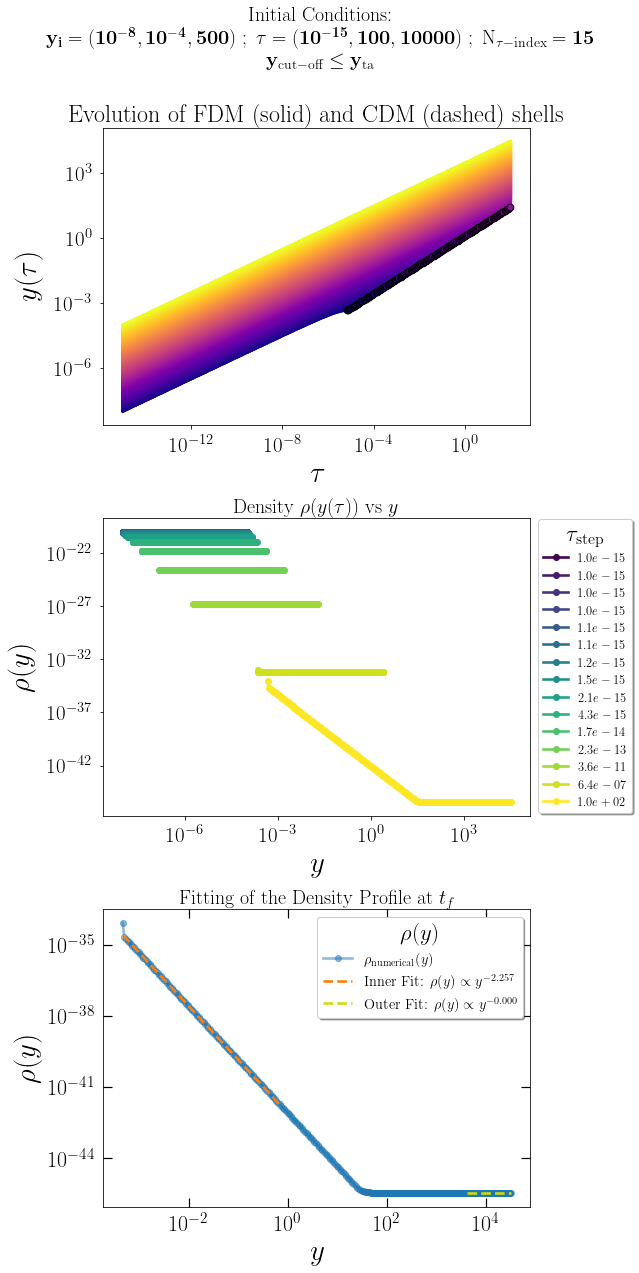

 Fitted slope (inner core):    \rho(y) \propto y^{-2.257}
 Fitted slope (outer tail):    \rho(y) \propto y^{-0.000}


In [19]:
# for 500 FDM shells

t_i, t_f = 1e-15, 1e2
N = 500
r_min, r_max = 1e-8, 1e-4
ri_arr = np.geomspace(r_min, r_max, N)
initial_density = 1e-20


delta_M_arr = shells_mass(ri_arr, N, initial_density)
QP = True
gravity = True
Hubble = True


t_step = 10000
t_arr = np.geomspace(t_i, t_f, t_step)
dt = np.gradient(t_arr)

r_sol = np.zeros((N, len(t_arr)))
v_sol = np.zeros((N, len(t_arr)))
rho_sol = np.zeros((N, len(t_arr)))
mask_active = np.ones(N, dtype=bool)
cutoff_index = np.full(N, len(t_arr))
t_ta_arr = np.full(N, np.nan)
r_ta_arr = np.full(N, np.nan)
turnaround_detected = np.zeros(N, dtype=bool)
r_sol[:, 0] = ri_arr
v_sol[:, 0] = ri_arr/(2 * t_arr[0])




freeze_fraction= 1
r_sol, v_sol, rho_sol, QP_arr, cutoff_index, r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask = shells_evolution(N, t_arr, dt, ri_arr, Hubble, gravity, QP, freeze_fraction)
time_indices = np.geomspace(1, t_step-1 , 15, dtype=int)




fig, axs = plt.subplots(3, 1, figsize=(9, 18), sharex=False)
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
colors_shell = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
colors1 = cm.viridis(np.linspace(0, 1, len(time_indices)))
colors2 = cm.plasma(np.linspace(0, 1, N))
colors3 = cm.magma(np.linspace(0, 1, len(time_indices)))



#------------------------------------------------------
ax = axs[0]


QP = False
gravity = True
Hubble = True
r_sol_no_qp, v_sol_no_qp, rho_sol_no_qp, QP_arr_no_qp, cutoff_index_no_qp,  r_ta_arr_no_qp, t_ta_arr_no_qp, rho_arr_no_qp, rta_mask_no_qp, tta_mask_no_qp = shells_evolution(N, t_arr, dt, ri_arr,  
Hubble, gravity, QP, freeze_fraction)


for j in range(N):
    cutoff = cutoff_index_no_qp[j]
    ax.loglog(t_arr[:cutoff], r_sol_no_qp[j, :cutoff], color=colors2[j], linestyle='--', alpha=0.7)
    if not np.isnan(t_ta_arr_no_qp[j]):
        ax.scatter(t_ta_arr_no_qp[j], r_ta_arr_no_qp[j], marker='o', s=30, color=colors2[j], edgecolor='k', alpha=0.3)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol_no_qp[j, cutoff - 1], marker='x', s=35, color=colors_shell[j], alpha=0.3)

# Plot FDM shells (with QP) with solid lines
for j in range(N):
    cutoff = cutoff_index[j]
    ax.loglog(t_arr[:cutoff], r_sol[j, :cutoff], color=colors2[j], linestyle='-', alpha=1.0, label=fr'${ri_arr[j]:.1e}$')
    if not np.isnan(t_ta_arr[j]):
        ax.scatter(t_ta_arr[j], r_ta_arr[j], marker='o', s=45, color=colors2[j], edgecolor='k', zorder=5)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol[j, cutoff - 1], marker='x', s=50, color=colors_shell[j], zorder=5)

# Labels, title and legend
ax.set_xlabel(r'$\tau$', fontsize=29, labelpad=6)
ax.set_ylabel(r'$y(\tau)$', fontsize=29, labelpad=11)
ax.set_title('Evolution of FDM (solid) and CDM (dashed) shells', fontsize=24)
ax.tick_params(axis='x', labelsize=21, pad=7.9)
ax.tick_params(axis='y', labelsize=21, pad=7.9)

#handles, labels = ax.get_legend_handles_labels()
#legend_shells = ax.legend(handles[:7], labels[:7], prop={'size': 12.5},
                        #  loc=(1.02, 0.13), shadow=True, title='$y_{i}$', title_fontsize=27,
                        #  facecolor='white', fontsize=25)

#legend_lines = [Line2D([0], [0], color='k', linestyle='-', lw=2),
               # Line2D([0], [0], color='k', linestyle='--', lw=2)]
#ax.legend(legend_lines, ['FDM', 'CDM'], prop={'size': 15.5}, loc=(1.02, 0.64),
         # shadow=True, title='Shell', title_fontsize=23,
         # facecolor='white', fontsize=20)
#ax.add_artist(legend_shells)









#----------------------------------------------------------
#Density vs time at different time steps


ax = axs[1]
for i, idx in enumerate(time_indices):
    r_at_time_index = r_sol[:, idx]
    rho_at_time_index = rho_sol[:, idx]
    ax.loglog(r_at_time_index, rho_at_time_index, marker='o', label=r'$ {0:.1e}$'.format(t_arr[idx]), color=colors1[i])


ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)  
#ax.text(5, 1e-24, '$y_i = (10^{-8}, 10^{-4}, 7)$', fontsize = 18)
#ax.text(5, 1e-27, '$N_\mathrm{time-indices} = 15$', fontsize = 18)
ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 11)
ax.legend( prop = {'size':12.5},loc = (1.02, 0.01),shadow = True, title = r'$\tau_\mathrm{step}$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 23)
ax.set_title(r'Density Profile at Different times steps', fontsize= 24)
ax.set_title(r' Density $\rho(y(\tau))$ vs $y$ ', fontsize=20)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 



#--------------------------------------------------------------------------------



###################################
# Fitting the density profile
ax = axs[2]


def f_fitting(x, m, b):
    return (m*x) + b


final_idx = -1
r_final = r_sol[:, final_idx]
rho_final = rho_sol[:, final_idx]
mask = (r_final > 0) & (rho_final > 0)
r_valid = r_final[mask]
rho_valid = rho_final[mask]


# Sort by radius
sorted_idx = np.argsort(r_valid)
r_valid = r_valid[sorted_idx]
rho_valid = rho_valid[sorted_idx]

# Define regions
inner_N = 100
outer_N = 110

# Inner region
r_inner = r_valid[:inner_N]
rho_inner = rho_valid[:inner_N]
log_r_inner = np.log10(r_inner)
log_rho_inner = np.log10(rho_inner)
popt_inner, _ = curve_fit(f_fitting, log_r_inner, log_rho_inner)
m_inner, b_inner = popt_inner
rho_fit_inner = 10**f_fitting(log_r_inner, *popt_inner)


# Outer region
r_outer = r_valid[-outer_N:]
rho_outer = rho_valid[-outer_N:]
log_r_outer = np.log10(r_outer)
log_rho_outer = np.log10(rho_outer)
popt_outer, _ = curve_fit(f_fitting, log_r_outer, log_rho_outer)
m_outer, b_outer = popt_outer
rho_fit_outer = 10**f_fitting(log_r_outer, *popt_outer)




ax.loglog(r_valid, rho_valid, 'o-', color='C0', alpha = 0.5)
ax.loglog(r_inner, rho_fit_inner, '--', color='C1')
#ax.loglog(r_middle, rho_fit_middle, '--', color='C3')
ax.loglog(r_outer, rho_fit_outer, '--', color='#d0db0b')


#plt.text(1e-14, 1e-45, '$y_i = (10^{-8}, 10^{-4}, 10)$', fontsize=18)
#plt.text(1e-14, 1e-49, '$(t_i, t_f, t_\\mathrm{steps}) = (10^{-15}, 10^{5}, 10000)$', fontsize=15)

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)

ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=22) 
ax.yaxis.set_tick_params(labelsize=22) 

ax.set_title('Fitting of the Density Profile at $t_f$', fontsize=20)
ax.legend([r'$\rho_\mathrm{numerical}(y)$', fr'Inner Fit: $\rho(y) \propto y^{{{m_inner:.3f}}}$',
           
           fr'Outer Fit: $\rho(y) \propto y^{{{m_outer:.3f}}}$'], 
           prop = {'size':14.5},loc = 'upper right', shadow = True, 
           title = r'$\rho(y)$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 31)




#---------------------------------------------------------------------



plt.suptitle(r'Initial Conditions:' + '\n' + 
    r'$\mathbf{y_i = (10^{-8}, 10^{-4}, 500)\; ;\;\tau = (10^{-15}, 100, 10000)\; ;\;\mathrm{N_{\tau-index}} = 15}$'
              '\n' + r'$\mathbf{y_\mathrm{cut-off} \leq  y_\mathrm{ta}}$' , fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('rho&qp_N500_t10000.pdf', bbox_inches='tight')
plt.show()



#--------------------------------------------------------------------

print(fr' Fitted slope (inner core):    \rho(y) \propto y^{{{m_inner:.3f}}}')
print(fr' Fitted slope (outer tail):    \rho(y) \propto y^{{{m_outer:.3f}}}')





np.savez('fdm_cdm_N500_t10000_rta.npz',
         # FDM arrays
         r_sol_fdm=r_sol,
         v_sol_fdm=v_sol,
         rho_sol_fdm=rho_sol,
         QP_arr_fdm= QP_arr,
         cutoff_index_fdm=cutoff_index,
         r_ta_arr_fdm=r_ta_arr,
         t_ta_arr_fdm=t_ta_arr,
         rho_arr_fdm = rho_arr,
         rta_mask_fdm = rta_mask,
         tta_mask_fdm = tta_mask,
         
         
         # CDM arrays
         r_sol_cdm=r_sol_no_qp,
         v_sol_cdm=v_sol_no_qp,
         rho_sol_cdm=rho_sol_no_qp,
         QP_arr_cdm= QP_arr_no_qp,
         cutoff_index_cdm=cutoff_index_no_qp,
         r_ta_arr_cdm=r_ta_arr_no_qp,
         t_ta_arr_cdm=t_ta_arr_no_qp,
         rho_arr_cdm = rho_arr_no_qp,
         rta_mask_cdm = rta_mask_no_qp,
         tta_mask_cdm = tta_mask_no_qp)



No shells crossings is detected.


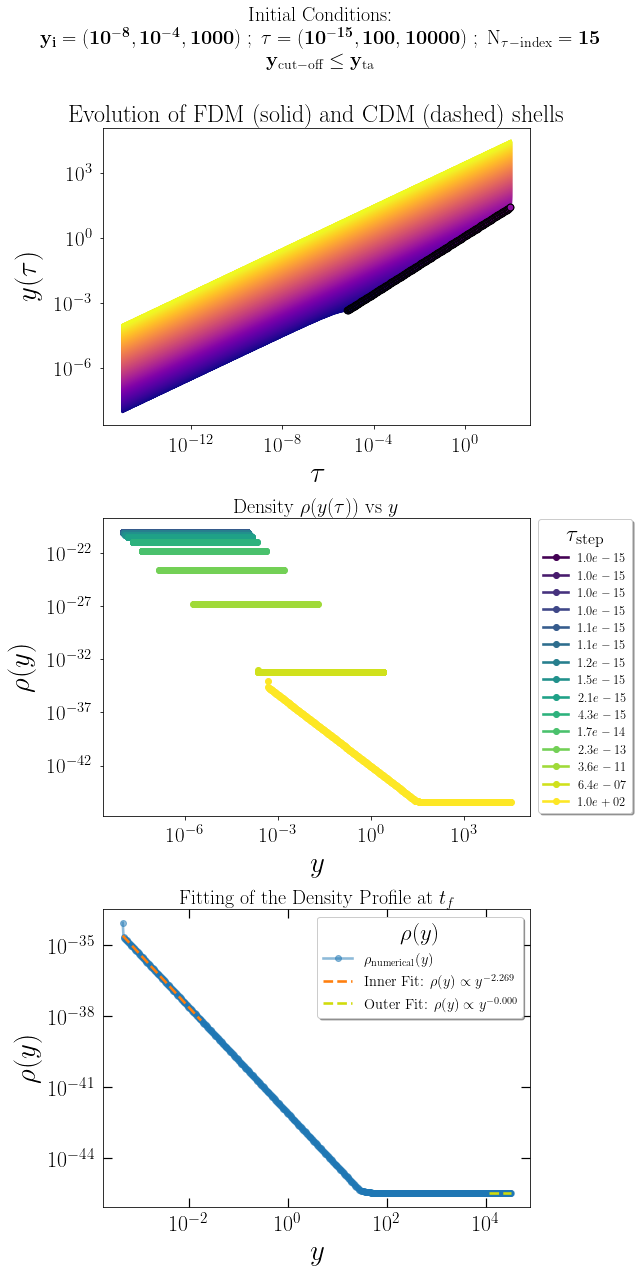

 Fitted slope (inner core):    \rho(y) \propto y^{-2.269}
 Fitted slope (outer tail):    \rho(y) \propto y^{-0.000}


In [27]:
# for 1000 FDM shells

t_i, t_f = 1e-15, 1e2
N = 1000
r_min, r_max = 1e-8, 1e-4
ri_arr = np.geomspace(r_min, r_max, N)
initial_density = 1e-20


delta_M_arr = shells_mass(ri_arr, N, initial_density)
QP = True
gravity = True
Hubble = True


t_step = 10000
t_arr = np.geomspace(t_i, t_f, t_step)
dt = np.gradient(t_arr)

r_sol = np.zeros((N, len(t_arr)))
v_sol = np.zeros((N, len(t_arr)))
rho_sol = np.zeros((N, len(t_arr)))
mask_active = np.ones(N, dtype=bool)
cutoff_index = np.full(N, len(t_arr))
t_ta_arr = np.full(N, np.nan)
r_ta_arr = np.full(N, np.nan)
turnaround_detected = np.zeros(N, dtype=bool)
r_sol[:, 0] = ri_arr
v_sol[:, 0] = ri_arr/(2 * t_arr[0])




freeze_fraction= 1
r_sol, v_sol, rho_sol, QP_arr, cutoff_index, r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask = shells_evolution(N, t_arr, dt, ri_arr, Hubble, gravity, QP, freeze_fraction)
time_indices = np.geomspace(1, t_step-1 , 15, dtype=int)




fig, axs = plt.subplots(3, 1, figsize=(9, 18), sharex=False)
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
colors_shell = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
colors1 = cm.viridis(np.linspace(0, 1, len(time_indices)))
colors2 = cm.plasma(np.linspace(0, 1, N))
colors3 = cm.magma(np.linspace(0, 1, len(time_indices)))



#------------------------------------------------------
ax = axs[0]


QP = False
gravity = True
Hubble = True
r_sol_no_qp, v_sol_no_qp, rho_sol_no_qp, QP_arr_no_qp, cutoff_index_no_qp,  r_ta_arr_no_qp, t_ta_arr_no_qp, rho_arr_no_qp, rta_mask_no_qp, tta_mask_no_qp = shells_evolution(N, t_arr, dt, ri_arr,  
Hubble, gravity, QP, freeze_fraction)


for j in range(N):
    cutoff = cutoff_index_no_qp[j]
    ax.loglog(t_arr[:cutoff], r_sol_no_qp[j, :cutoff], color=colors2[j], linestyle='--', alpha=0.7)
    if not np.isnan(t_ta_arr_no_qp[j]):
        ax.scatter(t_ta_arr_no_qp[j], r_ta_arr_no_qp[j], marker='o', s=30, color=colors2[j], edgecolor='k', alpha=0.3)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol_no_qp[j, cutoff - 1], marker='x', s=35, color=colors_shell[j], alpha=0.3)

# Plot FDM shells (with QP) with solid lines
for j in range(N):
    cutoff = cutoff_index[j]
    ax.loglog(t_arr[:cutoff], r_sol[j, :cutoff], color=colors2[j], linestyle='-', alpha=1.0, label=fr'${ri_arr[j]:.1e}$')
    if not np.isnan(t_ta_arr[j]):
        ax.scatter(t_ta_arr[j], r_ta_arr[j], marker='o', s=45, color=colors2[j], edgecolor='k', zorder=5)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol[j, cutoff - 1], marker='x', s=50, color=colors_shell[j], zorder=5)

# Labels, title and legend
ax.set_xlabel(r'$\tau$', fontsize=29, labelpad=6)
ax.set_ylabel(r'$y(\tau)$', fontsize=29, labelpad=11)
ax.set_title('Evolution of FDM (solid) and CDM (dashed) shells', fontsize=24)
ax.tick_params(axis='x', labelsize=21, pad=7.9)
ax.tick_params(axis='y', labelsize=21, pad=7.9)

#handles, labels = ax.get_legend_handles_labels()
#legend_shells = ax.legend(handles[:7], labels[:7], prop={'size': 12.5},
                        #  loc=(1.02, 0.13), shadow=True, title='$y_{i}$', title_fontsize=27,
                        #  facecolor='white', fontsize=25)

#legend_lines = [Line2D([0], [0], color='k', linestyle='-', lw=2),
               # Line2D([0], [0], color='k', linestyle='--', lw=2)]
#ax.legend(legend_lines, ['FDM', 'CDM'], prop={'size': 15.5}, loc=(1.02, 0.64),
         # shadow=True, title='Shell', title_fontsize=23,
         # facecolor='white', fontsize=20)
#ax.add_artist(legend_shells)









#----------------------------------------------------------
#Density vs time at different time steps


ax = axs[1]
for i, idx in enumerate(time_indices):
    r_at_time_index = r_sol[:, idx]
    rho_at_time_index = rho_sol[:, idx]
    ax.loglog(r_at_time_index, rho_at_time_index, marker='o', label=r'$ {0:.1e}$'.format(t_arr[idx]), color=colors1[i])


ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)  
#ax.text(5, 1e-24, '$y_i = (10^{-8}, 10^{-4}, 7)$', fontsize = 18)
#ax.text(5, 1e-27, '$N_\mathrm{time-indices} = 15$', fontsize = 18)
ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 11)
ax.legend( prop = {'size':12.5},loc = (1.02, 0.01),shadow = True, title = r'$\tau_\mathrm{step}$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 23)
ax.set_title(r'Density Profile at Different times steps', fontsize= 24)
ax.set_title(r' Density $\rho(y(\tau))$ vs $y$ ', fontsize=20)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 



#--------------------------------------------------------------------------------



###################################
# Fitting the density profile
ax = axs[2]


def f_fitting(x, m, b):
    return (m*x) + b


final_idx = -1
r_final = r_sol[:, final_idx]
rho_final = rho_sol[:, final_idx]
mask = (r_final > 0) & (rho_final > 0)
r_valid = r_final[mask]
rho_valid = rho_final[mask]


# Sort by radius
sorted_idx = np.argsort(r_valid)
r_valid = r_valid[sorted_idx]
rho_valid = rho_valid[sorted_idx]

# Define regions
inner_N = 100
outer_N = 110

# Inner region
r_inner = r_valid[:inner_N]
rho_inner = rho_valid[:inner_N]
log_r_inner = np.log10(r_inner)
log_rho_inner = np.log10(rho_inner)
popt_inner, _ = curve_fit(f_fitting, log_r_inner, log_rho_inner)
m_inner, b_inner = popt_inner
rho_fit_inner = 10**f_fitting(log_r_inner, *popt_inner)


# Outer region
r_outer = r_valid[-outer_N:]
rho_outer = rho_valid[-outer_N:]
log_r_outer = np.log10(r_outer)
log_rho_outer = np.log10(rho_outer)
popt_outer, _ = curve_fit(f_fitting, log_r_outer, log_rho_outer)
m_outer, b_outer = popt_outer
rho_fit_outer = 10**f_fitting(log_r_outer, *popt_outer)




ax.loglog(r_valid, rho_valid, 'o-', color='C0', alpha = 0.5)
ax.loglog(r_inner, rho_fit_inner, '--', color='C1')
#ax.loglog(r_middle, rho_fit_middle, '--', color='C3')
ax.loglog(r_outer, rho_fit_outer, '--', color='#d0db0b')


#plt.text(1e-14, 1e-45, '$y_i = (10^{-8}, 10^{-4}, 10)$', fontsize=18)
#plt.text(1e-14, 1e-49, '$(t_i, t_f, t_\\mathrm{steps}) = (10^{-15}, 10^{5}, 10000)$', fontsize=15)

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)

ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=22) 
ax.yaxis.set_tick_params(labelsize=22) 

ax.set_title('Fitting of the Density Profile at $t_f$', fontsize=20)
ax.legend([r'$\rho_\mathrm{numerical}(y)$', fr'Inner Fit: $\rho(y) \propto y^{{{m_inner:.3f}}}$',
           
           fr'Outer Fit: $\rho(y) \propto y^{{{m_outer:.3f}}}$'], 
           prop = {'size':14.5},loc = 'upper right', shadow = True, 
           title = r'$\rho(y)$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 31)




#---------------------------------------------------------------------



plt.suptitle(r'Initial Conditions:' + '\n' + 
    r'$\mathbf{y_i = (10^{-8}, 10^{-4}, 1000)\; ;\;\tau = (10^{-15}, 100, 10000)\; ;\;\mathrm{N_{\tau-index}} = 15}$'
              '\n' + r'$\mathbf{y_\mathrm{cut-off} \leq  y_\mathrm{ta}}$' , fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('rho&qp_N1000_t10000.pdf', bbox_inches='tight')
plt.show()



#--------------------------------------------------------------------

print(fr' Fitted slope (inner core):    \rho(y) \propto y^{{{m_inner:.3f}}}')
print(fr' Fitted slope (outer tail):    \rho(y) \propto y^{{{m_outer:.3f}}}')





np.savez('fdm_cdm_N1000_t10000_rta.npz',
         # FDM arrays
         r_sol_fdm=r_sol,
         v_sol_fdm=v_sol,
         rho_sol_fdm=rho_sol,
         QP_arr_fdm= QP_arr,
         cutoff_index_fdm=cutoff_index,
         r_ta_arr_fdm=r_ta_arr,
         t_ta_arr_fdm=t_ta_arr,
         rho_arr_fdm = rho_arr,
         rta_mask_fdm = rta_mask,
         tta_mask_fdm = tta_mask,
         
         
         # CDM arrays
         r_sol_cdm=r_sol_no_qp,
         v_sol_cdm=v_sol_no_qp,
         rho_sol_cdm=rho_sol_no_qp,
         QP_arr_cdm= QP_arr_no_qp,
         cutoff_index_cdm=cutoff_index_no_qp,
         r_ta_arr_cdm=r_ta_arr_no_qp,
         t_ta_arr_cdm=t_ta_arr_no_qp,
         rho_arr_cdm = rho_arr_no_qp,
         rta_mask_cdm = rta_mask_no_qp,
         tta_mask_cdm = tta_mask_no_qp)



No shells crossings is detected.


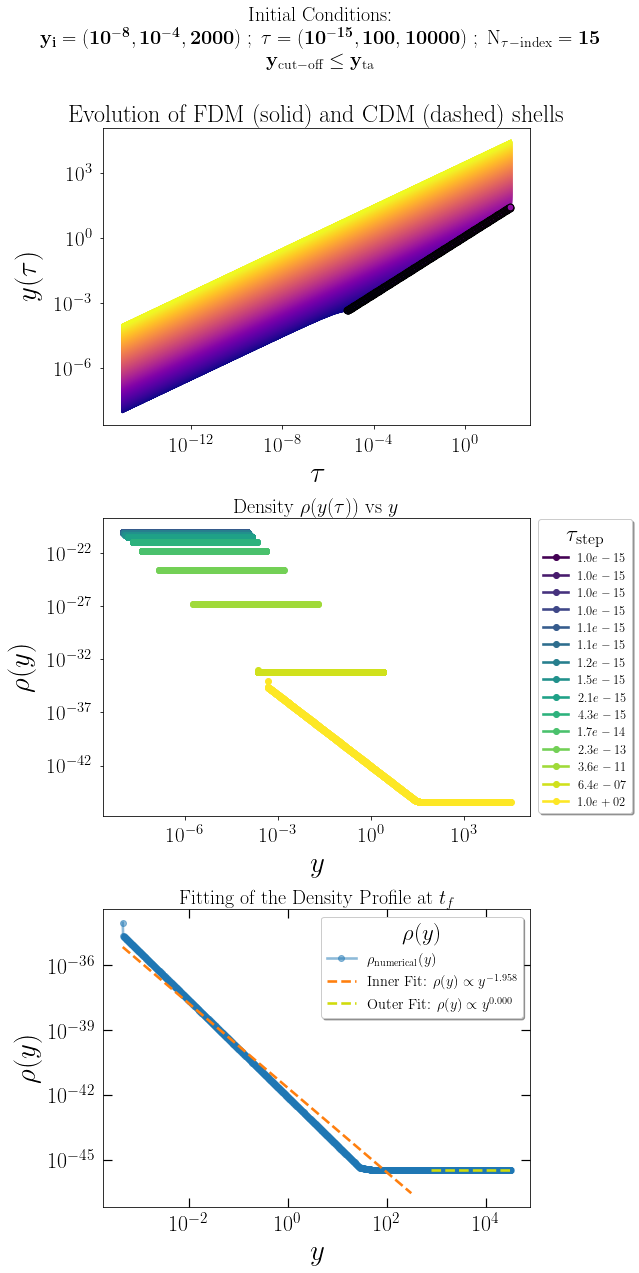

 Fitted slope (inner core):    \rho(y) \propto y^{-1.958}
 Fitted slope (outer tail):    \rho(y) \propto y^{0.000}


In [34]:
# for 2000 FDM shells

t_i, t_f = 1e-15, 1e2
N = 2000
r_min, r_max = 1e-8, 1e-4
ri_arr = np.geomspace(r_min, r_max, N)
initial_density = 1e-20


delta_M_arr = shells_mass(ri_arr, N, initial_density)
QP = True
gravity = True
Hubble = True


t_step = 10000
t_arr = np.geomspace(t_i, t_f, t_step)
dt = np.gradient(t_arr)

r_sol = np.zeros((N, len(t_arr)))
v_sol = np.zeros((N, len(t_arr)))
rho_sol = np.zeros((N, len(t_arr)))
mask_active = np.ones(N, dtype=bool)
cutoff_index = np.full(N, len(t_arr))
t_ta_arr = np.full(N, np.nan)
r_ta_arr = np.full(N, np.nan)
turnaround_detected = np.zeros(N, dtype=bool)
r_sol[:, 0] = ri_arr
v_sol[:, 0] = ri_arr/(2 * t_arr[0])




freeze_fraction= 1
r_sol, v_sol, rho_sol, QP_arr, cutoff_index, r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask = shells_evolution(N, t_arr, dt, ri_arr, Hubble, gravity, QP, freeze_fraction)
time_indices = np.geomspace(1, t_step-1 , 15, dtype=int)




fig, axs = plt.subplots(3, 1, figsize=(9, 18), sharex=False)
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
colors_shell = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
colors1 = cm.viridis(np.linspace(0, 1, len(time_indices)))
colors2 = cm.plasma(np.linspace(0, 1, N))
colors3 = cm.magma(np.linspace(0, 1, len(time_indices)))



#------------------------------------------------------
ax = axs[0]


QP = False
gravity = True
Hubble = True
r_sol_no_qp, v_sol_no_qp, rho_sol_no_qp, QP_arr_no_qp, cutoff_index_no_qp,  r_ta_arr_no_qp, t_ta_arr_no_qp, rho_arr_no_qp, rta_mask_no_qp, tta_mask_no_qp = shells_evolution(N, t_arr, dt, ri_arr,  
Hubble, gravity, QP, freeze_fraction)


for j in range(N):
    cutoff = cutoff_index_no_qp[j]
    ax.loglog(t_arr[:cutoff], r_sol_no_qp[j, :cutoff], color=colors2[j], linestyle='--', alpha=0.7)
    if not np.isnan(t_ta_arr_no_qp[j]):
        ax.scatter(t_ta_arr_no_qp[j], r_ta_arr_no_qp[j], marker='o', s=30, color=colors2[j], edgecolor='k', alpha=0.3)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol_no_qp[j, cutoff - 1], marker='x', s=35, color=colors_shell[j], alpha=0.3)

# Plot FDM shells (with QP) with solid lines
for j in range(N):
    cutoff = cutoff_index[j]
    ax.loglog(t_arr[:cutoff], r_sol[j, :cutoff], color=colors2[j], linestyle='-', alpha=1.0, label=fr'${ri_arr[j]:.1e}$')
    if not np.isnan(t_ta_arr[j]):
        ax.scatter(t_ta_arr[j], r_ta_arr[j], marker='o', s=45, color=colors2[j], edgecolor='k', zorder=5)
    #if cutoff > 0 and cutoff <= len(t_arr):
        #ax.scatter(t_arr[cutoff - 1], r_sol[j, cutoff - 1], marker='x', s=50, color=colors_shell[j], zorder=5)

# Labels, title and legend
ax.set_xlabel(r'$\tau$', fontsize=29, labelpad=6)
ax.set_ylabel(r'$y(\tau)$', fontsize=29, labelpad=11)
ax.set_title('Evolution of FDM (solid) and CDM (dashed) shells', fontsize=24)
ax.tick_params(axis='x', labelsize=21, pad=7.9)
ax.tick_params(axis='y', labelsize=21, pad=7.9)

#handles, labels = ax.get_legend_handles_labels()
#legend_shells = ax.legend(handles[:7], labels[:7], prop={'size': 12.5},
                        #  loc=(1.02, 0.13), shadow=True, title='$y_{i}$', title_fontsize=27,
                        #  facecolor='white', fontsize=25)

#legend_lines = [Line2D([0], [0], color='k', linestyle='-', lw=2),
               # Line2D([0], [0], color='k', linestyle='--', lw=2)]
#ax.legend(legend_lines, ['FDM', 'CDM'], prop={'size': 15.5}, loc=(1.02, 0.64),
         # shadow=True, title='Shell', title_fontsize=23,
         # facecolor='white', fontsize=20)
#ax.add_artist(legend_shells)









#----------------------------------------------------------
#Density vs time at different time steps


ax = axs[1]
for i, idx in enumerate(time_indices):
    r_at_time_index = r_sol[:, idx]
    rho_at_time_index = rho_sol[:, idx]
    ax.loglog(r_at_time_index, rho_at_time_index, marker='o', label=r'$ {0:.1e}$'.format(t_arr[idx]), color=colors1[i])


ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)  
#ax.text(5, 1e-24, '$y_i = (10^{-8}, 10^{-4}, 7)$', fontsize = 18)
#ax.text(5, 1e-27, '$N_\mathrm{time-indices} = 15$', fontsize = 18)
ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 11)
ax.legend( prop = {'size':12.5},loc = (1.02, 0.01),shadow = True, title = r'$\tau_\mathrm{step}$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 23)
ax.set_title(r'Density Profile at Different times steps', fontsize= 24)
ax.set_title(r' Density $\rho(y(\tau))$ vs $y$ ', fontsize=20)
ax.xaxis.set_tick_params(labelsize=21) 
ax.yaxis.set_tick_params(labelsize=21) 



#--------------------------------------------------------------------------------



###################################
# Fitting the density profile
ax = axs[2]


def f_fitting(x, m, b):
    return (m*x) + b


final_idx = -1
r_final = r_sol[:, final_idx]
rho_final = rho_sol[:, final_idx]
mask = (r_final > 0) & (rho_final > 0)
r_valid = r_final[mask]
rho_valid = rho_final[mask]


# Sort by radius
sorted_idx = np.argsort(r_valid)
r_valid = r_valid[sorted_idx]
rho_valid = rho_valid[sorted_idx]

# Define regions
inner_N = 1000
outer_N = 800

# Inner region
r_inner = r_valid[:inner_N]
rho_inner = rho_valid[:inner_N]
log_r_inner = np.log10(r_inner)
log_rho_inner = np.log10(rho_inner)
popt_inner, _ = curve_fit(f_fitting, log_r_inner, log_rho_inner)
m_inner, b_inner = popt_inner
rho_fit_inner = 10**f_fitting(log_r_inner, *popt_inner)


# Outer region
r_outer = r_valid[-outer_N:]
rho_outer = rho_valid[-outer_N:]
log_r_outer = np.log10(r_outer)
log_rho_outer = np.log10(rho_outer)
popt_outer, _ = curve_fit(f_fitting, log_r_outer, log_rho_outer)
m_outer, b_outer = popt_outer
rho_fit_outer = 10**f_fitting(log_r_outer, *popt_outer)




ax.loglog(r_valid, rho_valid, 'o-', color='C0', alpha = 0.5)
ax.loglog(r_inner, rho_fit_inner, '--', color='C1')
#ax.loglog(r_middle, rho_fit_middle, '--', color='C3')
ax.loglog(r_outer, rho_fit_outer, '--', color='#d0db0b')


#plt.text(1e-14, 1e-45, '$y_i = (10^{-8}, 10^{-4}, 10)$', fontsize=18)
#plt.text(1e-14, 1e-49, '$(t_i, t_f, t_\\mathrm{steps}) = (10^{-15}, 10^{5}, 10000)$', fontsize=15)

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)

ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=22) 
ax.yaxis.set_tick_params(labelsize=22) 

ax.set_title('Fitting of the Density Profile at $t_f$', fontsize=20)
ax.legend([r'$\rho_\mathrm{numerical}(y)$', fr'Inner Fit: $\rho(y) \propto y^{{{m_inner:.3f}}}$',
           
           fr'Outer Fit: $\rho(y) \propto y^{{{m_outer:.3f}}}$'], 
           prop = {'size':14.5},loc = 'upper right', shadow = True, 
           title = r'$\rho(y)$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 31)




#---------------------------------------------------------------------



plt.suptitle(r'Initial Conditions:' + '\n' + 
    r'$\mathbf{y_i = (10^{-8}, 10^{-4}, 2000)\; ;\;\tau = (10^{-15}, 100, 10000)\; ;\;\mathrm{N_{\tau-index}} = 15}$'
              '\n' + r'$\mathbf{y_\mathrm{cut-off} \leq  y_\mathrm{ta}}$' , fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('rho&qp_N2000_t10000.pdf', bbox_inches='tight')
plt.show()



#--------------------------------------------------------------------

print(fr' Fitted slope (inner core):    \rho(y) \propto y^{{{m_inner:.3f}}}')
print(fr' Fitted slope (outer tail):    \rho(y) \propto y^{{{m_outer:.3f}}}')





np.savez('fdm_cdm_N2000_t10000_rta.npz',
         # FDM arrays
         r_sol_fdm=r_sol,
         v_sol_fdm=v_sol,
         rho_sol_fdm=rho_sol,
         QP_arr_fdm= QP_arr,
         cutoff_index_fdm=cutoff_index,
         r_ta_arr_fdm=r_ta_arr,
         t_ta_arr_fdm=t_ta_arr,
         rho_arr_fdm = rho_arr,
         rta_mask_fdm = rta_mask,
         tta_mask_fdm = tta_mask,
         
         
         # CDM arrays
         r_sol_cdm=r_sol_no_qp,
         v_sol_cdm=v_sol_no_qp,
         rho_sol_cdm=rho_sol_no_qp,
         QP_arr_cdm= QP_arr_no_qp,
         cutoff_index_cdm=cutoff_index_no_qp,
         r_ta_arr_cdm=r_ta_arr_no_qp,
         t_ta_arr_cdm=t_ta_arr_no_qp,
         rho_arr_cdm = rho_arr_no_qp,
         rta_mask_cdm = rta_mask_no_qp,
         tta_mask_cdm = tta_mask_no_qp)



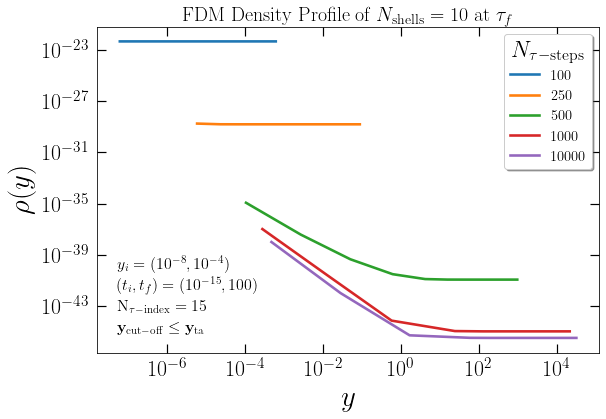

In [15]:
#the density profile of 10 FDM shells at t_f

data = np.load('fdm_cdm_N10_t100_rta.npz')
r_sol_100 = data['r_sol_fdm']
rho_sol_100 = data['rho_sol_fdm']

data = np.load('fdm_cdm_N10_t250_rta.npz')
r_sol_250 = data['r_sol_fdm']
rho_sol_250 = data['rho_sol_fdm']


data = np.load('fdm_cdm_N10_t500_rta.npz')
r_sol_500 = data['r_sol_fdm']
rho_sol_500 = data['rho_sol_fdm']


data = np.load('fdm_cdm_N10_t1000_rta.npz')
r_sol_1000 = data['r_sol_fdm']
rho_sol_1000 = data['rho_sol_fdm']



data = np.load('fdm_cdm_N10_t10000_rta.npz')
r_sol_10000 = data['r_sol_fdm']
rho_sol_10000 = data['rho_sol_fdm']




fig, ax = plt.subplots(1, figsize=(9, 6), sharex=False)
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')



final_idx = -1



r_final_100 = r_sol_100[:, final_idx]
rho_final_100 = rho_sol_100[:, final_idx]
mask_100 = (r_final_100 > 0) & (rho_final_100 > 0)
r_valid_100 = r_final_100[mask_100]
rho_valid_100 = rho_final_100[mask_100]
sorted_idx_100 = np.argsort(r_valid_100)
r_valid_100 = r_valid_100[sorted_idx_100]
rho_valid_100 = rho_valid_100[sorted_idx_100]



r_final_250 = r_sol_250[:, final_idx]
rho_final_250 = rho_sol_250[:, final_idx]
mask_250 = (r_final_250 > 0) & (rho_final_250 > 0)
r_valid_250 = r_final_250[mask_250]
rho_valid_250 = rho_final_250[mask_250]
sorted_idx_250 = np.argsort(r_valid_250)
r_valid_250 = r_valid_250[sorted_idx_250]
rho_valid_250 = rho_valid_250[sorted_idx_250]



r_final_500 = r_sol_500[:, final_idx]
rho_final_500 = rho_sol_500[:, final_idx]
mask_500 = (r_final_500 > 0) & (rho_final_500 > 0)
r_valid_500 = r_final_500[mask_500]
rho_valid_500 = rho_final_500[mask_500]
sorted_idx_500 = np.argsort(r_valid_500)
r_valid_500 = r_valid_500[sorted_idx_500]
rho_valid_500 = rho_valid_500[sorted_idx_500]



r_final_1000 = r_sol_1000[:, final_idx]
rho_final_1000 = rho_sol_1000[:, final_idx]
mask_1000 = (r_final_1000 > 0) & (rho_final_1000 > 0)
r_valid_1000 = r_final_1000[mask_1000]
rho_valid_1000 = rho_final_1000[mask_1000]
sorted_idx_1000 = np.argsort(r_valid_1000)
r_valid_1000 = r_valid_1000[sorted_idx_1000]
rho_valid_1000 = rho_valid_1000[sorted_idx_1000]



r_final_10000 = r_sol_10000[:, final_idx]
rho_final_10000 = rho_sol_10000[:, final_idx]
mask_10000 = (r_final_10000 > 0) & (rho_final_10000 > 0)
r_valid_10000 = r_final_10000[mask_10000]
rho_valid_10000 = rho_final_10000[mask_10000]
sorted_idx_10000 = np.argsort(r_valid_10000)
r_valid_10000 = r_valid_10000[sorted_idx_10000]
rho_valid_10000 = rho_valid_10000[sorted_idx_10000]



ax.loglog(r_valid_100, rho_valid_100, '-', color='C0')
ax.loglog(r_valid_250, rho_valid_250, '-', color='C1')
ax.loglog(r_valid_500, rho_valid_500, '-', color='C2')
ax.loglog(r_valid_1000, rho_valid_1000, '-', color='C3')
ax.loglog(r_valid_10000, rho_valid_10000, '-', color='C4')


plt.text(5e-8, 9e-41, '$y_i = (10^{-8}, 10^{-4})$', fontsize=16)
plt.text(5e-8, 2e-42, '$(t_i, t_f) = (10^{-15}, 100)$', fontsize=16)
plt.text(5e-8, 5e-44, r'$\mathrm{N_{\tau-index}} = 15$ ', fontsize = 16)
plt.text(5e-8, 1e-45, r'$\mathbf{y_\mathrm{cut-off} \leq y_\mathrm{ta}}$ ', fontsize = 16)



ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)

ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=22) 
ax.yaxis.set_tick_params(labelsize=22) 

ax.set_title(r'FDM Density Profile of $N_\mathrm{shells} = 10$ at $\tau_f$', fontsize=20)
ax.legend(['100', '250','500', '1000', '10000'], 
           prop = {'size':14.5},loc = 'upper right', shadow = True, 
           title = r'$N_\mathrm{\tau-steps}$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 31)

plt.savefig('y&rho_N10.pdf', bbox_inches='tight')
plt.show()

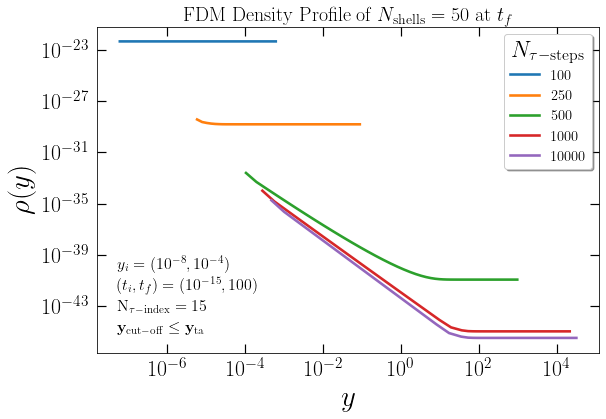

In [14]:
#  the density profile of 50 FDM shells at t_f


data = np.load('fdm_cdm_N50_t100_rta.npz')
r_sol_100 = data['r_sol_fdm']
rho_sol_100 = data['rho_sol_fdm']

data = np.load('fdm_cdm_N50_t250_rta.npz')
r_sol_250 = data['r_sol_fdm']
rho_sol_250 = data['rho_sol_fdm']


data = np.load('fdm_cdm_N50_t500_rta.npz')
r_sol_500 = data['r_sol_fdm']
rho_sol_500 = data['rho_sol_fdm']


data = np.load('fdm_cdm_N50_t1000_rta.npz')
r_sol_1000 = data['r_sol_fdm']
rho_sol_1000 = data['rho_sol_fdm']


data = np.load('fdm_cdm_N50_t10000_rta.npz')
r_sol_10000 = data['r_sol_fdm']
rho_sol_10000 = data['rho_sol_fdm']

fig, ax = plt.subplots(1, figsize=(9, 6), sharex=False)
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')



final_idx = -1



r_final_100 = r_sol_100[:, final_idx]
rho_final_100 = rho_sol_100[:, final_idx]
mask_100 = (r_final_100 > 0) & (rho_final_100 > 0)
r_valid_100 = r_final_100[mask_100]
rho_valid_100 = rho_final_100[mask_100]
sorted_idx_100 = np.argsort(r_valid_100)
r_valid_100 = r_valid_100[sorted_idx_100]
rho_valid_100 = rho_valid_100[sorted_idx_100]



r_final_250 = r_sol_250[:, final_idx]
rho_final_250 = rho_sol_250[:, final_idx]
mask_250 = (r_final_250 > 0) & (rho_final_250 > 0)
r_valid_250 = r_final_250[mask_250]
rho_valid_250 = rho_final_250[mask_250]
sorted_idx_250 = np.argsort(r_valid_250)
r_valid_250 = r_valid_250[sorted_idx_250]
rho_valid_250 = rho_valid_250[sorted_idx_250]



r_final_500 = r_sol_500[:, final_idx]
rho_final_500 = rho_sol_500[:, final_idx]
mask_500 = (r_final_500 > 0) & (rho_final_500 > 0)
r_valid_500 = r_final_500[mask_500]
rho_valid_500 = rho_final_500[mask_500]
sorted_idx_500 = np.argsort(r_valid_500)
r_valid_500 = r_valid_500[sorted_idx_500]
rho_valid_500 = rho_valid_500[sorted_idx_500]



r_final_1000 = r_sol_1000[:, final_idx]
rho_final_1000 = rho_sol_1000[:, final_idx]
mask_1000 = (r_final_1000 > 0) & (rho_final_1000 > 0)
r_valid_1000 = r_final_1000[mask_1000]
rho_valid_1000 = rho_final_1000[mask_1000]
sorted_idx_1000 = np.argsort(r_valid_1000)
r_valid_1000 = r_valid_1000[sorted_idx_1000]
rho_valid_1000 = rho_valid_1000[sorted_idx_1000]


r_final_10000 = r_sol_10000[:, final_idx]
rho_final_10000 = rho_sol_10000[:, final_idx]
mask_10000 = (r_final_10000 > 0) & (rho_final_10000 > 0)
r_valid_10000 = r_final_10000[mask_10000]
rho_valid_10000 = rho_final_10000[mask_10000]
sorted_idx_10000 = np.argsort(r_valid_10000)
r_valid_10000 = r_valid_10000[sorted_idx_10000]
rho_valid_10000 = rho_valid_10000[sorted_idx_10000]




ax.loglog(r_valid_100, rho_valid_100, '-', color='C0')
ax.loglog(r_valid_250, rho_valid_250, '-', color='C1')
ax.loglog(r_valid_500, rho_valid_500, '-', color='C2')
ax.loglog(r_valid_1000, rho_valid_1000, '-', color='C3')
ax.loglog(r_valid_10000, rho_valid_10000, '-', color='C4')


plt.text(5e-8, 9e-41, '$y_i = (10^{-8}, 10^{-4})$', fontsize=16)
plt.text(5e-8, 2e-42, '$(t_i, t_f) = (10^{-15}, 100)$', fontsize=16)
plt.text(5e-8, 5e-44, r'$\mathrm{N_{\tau-index}} = 15$ ', fontsize = 16)
plt.text(5e-8, 1e-45, r'$\mathbf{y_\mathrm{cut-off} \leq y_\mathrm{ta}}$ ', fontsize = 16)


ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)

ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=22) 
ax.yaxis.set_tick_params(labelsize=22) 

ax.set_title(r'FDM Density Profile of $N_\mathrm{shells} = 50$ at $t_f$', fontsize=20)
ax.legend(['100', '250','500', '1000', '10000'], 
           prop = {'size':14.5},loc = 'upper right', shadow = True, 
           title = r'$N_\mathrm{\tau-steps}$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 31)

plt.savefig('y&rho_N50.pdf', bbox_inches='tight')
plt.show()

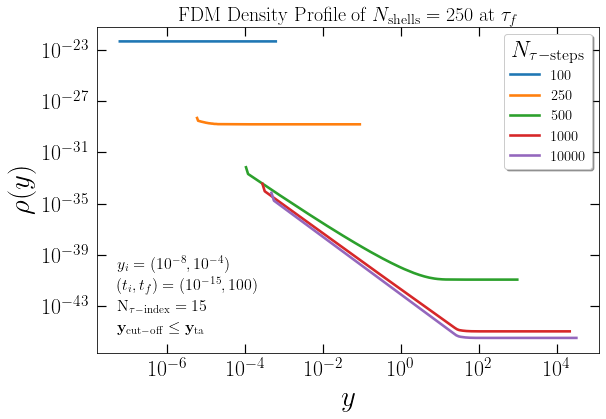

In [13]:
#  the density profile at t_f


data = np.load('fdm_cdm_N250_t100_rta.npz')
r_sol_100 = data['r_sol_fdm']
rho_sol_100 = data['rho_sol_fdm']

data = np.load('fdm_cdm_N250_t250_rta.npz')
r_sol_250 = data['r_sol_fdm']
rho_sol_250 = data['rho_sol_fdm']


data = np.load('fdm_cdm_N250_t500_rta.npz')
r_sol_500 = data['r_sol_fdm']
rho_sol_500 = data['rho_sol_fdm']


data = np.load('fdm_cdm_N250_t1000_rta.npz')
r_sol_1000 = data['r_sol_fdm']
rho_sol_1000 = data['rho_sol_fdm']


data = np.load('fdm_cdm_N250_t10000_rta.npz')
r_sol_10000 = data['r_sol_fdm']
rho_sol_10000 = data['rho_sol_fdm']


fig, ax = plt.subplots(1, figsize=(9, 6), sharex=False)
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')



final_idx = -1



r_final_100 = r_sol_100[:, final_idx]
rho_final_100 = rho_sol_100[:, final_idx]
mask_100 = (r_final_100 > 0) & (rho_final_100 > 0)
r_valid_100 = r_final_100[mask_100]
rho_valid_100 = rho_final_100[mask_100]
sorted_idx_100 = np.argsort(r_valid_100)
r_valid_100 = r_valid_100[sorted_idx_100]
rho_valid_100 = rho_valid_100[sorted_idx_100]



r_final_250 = r_sol_250[:, final_idx]
rho_final_250 = rho_sol_250[:, final_idx]
mask_250 = (r_final_250 > 0) & (rho_final_250 > 0)
r_valid_250 = r_final_250[mask_250]
rho_valid_250 = rho_final_250[mask_250]
sorted_idx_250 = np.argsort(r_valid_250)
r_valid_250 = r_valid_250[sorted_idx_250]
rho_valid_250 = rho_valid_250[sorted_idx_250]



r_final_500 = r_sol_500[:, final_idx]
rho_final_500 = rho_sol_500[:, final_idx]
mask_500 = (r_final_500 > 0) & (rho_final_500 > 0)
r_valid_500 = r_final_500[mask_500]
rho_valid_500 = rho_final_500[mask_500]
sorted_idx_500 = np.argsort(r_valid_500)
r_valid_500 = r_valid_500[sorted_idx_500]
rho_valid_500 = rho_valid_500[sorted_idx_500]



r_final_1000 = r_sol_1000[:, final_idx]
rho_final_1000 = rho_sol_1000[:, final_idx]
mask_1000 = (r_final_1000 > 0) & (rho_final_1000 > 0)
r_valid_1000 = r_final_1000[mask_1000]
rho_valid_1000 = rho_final_1000[mask_1000]
sorted_idx_1000 = np.argsort(r_valid_1000)
r_valid_1000 = r_valid_1000[sorted_idx_1000]
rho_valid_1000 = rho_valid_1000[sorted_idx_1000]


r_final_10000 = r_sol_10000[:, final_idx]
rho_final_10000 = rho_sol_10000[:, final_idx]
mask_10000 = (r_final_10000 > 0) & (rho_final_10000 > 0)
r_valid_10000 = r_final_10000[mask_10000]
rho_valid_10000 = rho_final_10000[mask_10000]
sorted_idx_10000 = np.argsort(r_valid_10000)
r_valid_10000 = r_valid_10000[sorted_idx_10000]
rho_valid_10000 = rho_valid_10000[sorted_idx_10000]


ax.loglog(r_valid_100, rho_valid_100, '-', color='C0')
ax.loglog(r_valid_250, rho_valid_250, '-', color='C1')
ax.loglog(r_valid_500, rho_valid_500, '-', color='C2')
ax.loglog(r_valid_1000, rho_valid_1000, '-', color='C3')
ax.loglog(r_valid_10000, rho_valid_10000, '-', color='C4')


plt.text(5e-8, 9e-41, '$y_i = (10^{-8}, 10^{-4})$', fontsize=16)
plt.text(5e-8, 2e-42, '$(t_i, t_f) = (10^{-15}, 100)$', fontsize=16)
plt.text(5e-8, 5e-44, r'$\mathrm{N_{\tau-index}} = 15$ ', fontsize = 16)
plt.text(5e-8, 1e-45, r'$\mathbf{y_\mathrm{cut-off} \leq y_\mathrm{ta}}$ ', fontsize = 16)



ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)

ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=22) 
ax.yaxis.set_tick_params(labelsize=22) 

ax.set_title(r'FDM Density Profile of $N_\mathrm{shells} = 250$ at $\tau_f$', fontsize=20)
ax.legend(['100', '250','500', '1000', '10000'], 
           prop = {'size':14.5},loc = 'upper right', shadow = True, 
           title = r'$N_\mathrm{\tau-steps}$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 31)

plt.savefig('y&rho_N250.pdf', bbox_inches='tight')
plt.show()

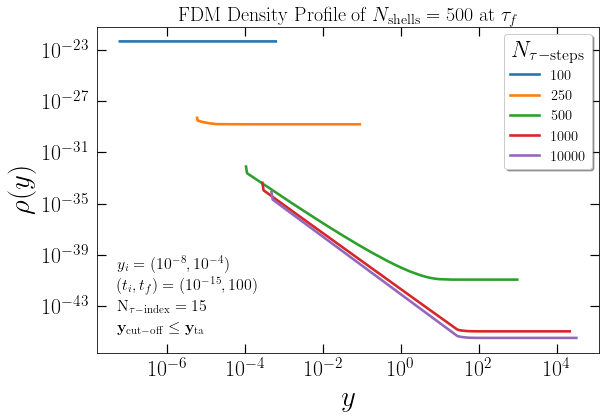

In [12]:
#  the density profile at t_f


data = np.load('fdm_cdm_N500_t100_rta.npz')
r_sol_100 = data['r_sol_fdm']
rho_sol_100 = data['rho_sol_fdm']

data = np.load('fdm_cdm_N500_t250_rta.npz')
r_sol_250 = data['r_sol_fdm']
rho_sol_250 = data['rho_sol_fdm']


data = np.load('fdm_cdm_N500_t500_rta.npz')
r_sol_500 = data['r_sol_fdm']
rho_sol_500 = data['rho_sol_fdm']


data = np.load('fdm_cdm_N500_t1000_rta.npz')
r_sol_1000 = data['r_sol_fdm']
rho_sol_1000 = data['rho_sol_fdm']



data = np.load('fdm_cdm_N500_t10000_rta.npz')
r_sol_10000 = data['r_sol_fdm']
rho_sol_10000 = data['rho_sol_fdm']





fig, ax = plt.subplots(1, figsize=(9, 6), sharex=False)
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')



final_idx = -1



r_final_100 = r_sol_100[:, final_idx]
rho_final_100 = rho_sol_100[:, final_idx]
mask_100 = (r_final_100 > 0) & (rho_final_100 > 0)
r_valid_100 = r_final_100[mask_100]
rho_valid_100 = rho_final_100[mask_100]
sorted_idx_100 = np.argsort(r_valid_100)
r_valid_100 = r_valid_100[sorted_idx_100]
rho_valid_100 = rho_valid_100[sorted_idx_100]



r_final_250 = r_sol_250[:, final_idx]
rho_final_250 = rho_sol_250[:, final_idx]
mask_250 = (r_final_250 > 0) & (rho_final_250 > 0)
r_valid_250 = r_final_250[mask_250]
rho_valid_250 = rho_final_250[mask_250]
sorted_idx_250 = np.argsort(r_valid_250)
r_valid_250 = r_valid_250[sorted_idx_250]
rho_valid_250 = rho_valid_250[sorted_idx_250]



r_final_500 = r_sol_500[:, final_idx]
rho_final_500 = rho_sol_500[:, final_idx]
mask_500 = (r_final_500 > 0) & (rho_final_500 > 0)
r_valid_500 = r_final_500[mask_500]
rho_valid_500 = rho_final_500[mask_500]
sorted_idx_500 = np.argsort(r_valid_500)
r_valid_500 = r_valid_500[sorted_idx_500]
rho_valid_500 = rho_valid_500[sorted_idx_500]



r_final_1000 = r_sol_1000[:, final_idx]
rho_final_1000 = rho_sol_1000[:, final_idx]
mask_1000 = (r_final_1000 > 0) & (rho_final_1000 > 0)
r_valid_1000 = r_final_1000[mask_1000]
rho_valid_1000 = rho_final_1000[mask_1000]
sorted_idx_1000 = np.argsort(r_valid_1000)
r_valid_1000 = r_valid_1000[sorted_idx_1000]
rho_valid_1000 = rho_valid_1000[sorted_idx_1000]


r_final_10000 = r_sol_10000[:, final_idx]
rho_final_10000 = rho_sol_10000[:, final_idx]
mask_10000 = (r_final_10000 > 0) & (rho_final_10000 > 0)
r_valid_10000 = r_final_10000[mask_10000]
rho_valid_10000 = rho_final_10000[mask_10000]
sorted_idx_10000 = np.argsort(r_valid_10000)
r_valid_10000 = r_valid_10000[sorted_idx_10000]
rho_valid_10000 = rho_valid_10000[sorted_idx_10000]




ax.loglog(r_valid_100, rho_valid_100, '-', color='C0')
ax.loglog(r_valid_250, rho_valid_250, '-', color='C1')
ax.loglog(r_valid_500, rho_valid_500, '-', color='C2')
ax.loglog(r_valid_1000, rho_valid_1000, '-', color='C3')
ax.loglog(r_valid_10000, rho_valid_10000, '-', color='C4')


plt.text(5e-8, 9e-41, '$y_i = (10^{-8}, 10^{-4})$', fontsize=16)
plt.text(5e-8, 2e-42, '$(t_i, t_f) = (10^{-15}, 100)$', fontsize=16)
plt.text(5e-8, 5e-44, r'$\mathrm{N_{\tau-index}} = 15$ ', fontsize = 16)
plt.text(5e-8, 1e-45, r'$\mathbf{y_\mathrm{cut-off} \leq y_\mathrm{ta}}$ ', fontsize = 16)


ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)

ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=22) 
ax.yaxis.set_tick_params(labelsize=22) 

ax.set_title(r'FDM Density Profile of $N_\mathrm{shells} = 500$ at $\tau_f$', fontsize=20)
ax.legend(['100', '250','500', '1000', '10000'], 
           prop = {'size':14.5},loc = 'upper right', shadow = True, 
           title = r'$N_\mathrm{\tau-steps}$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 31)

plt.savefig('y&rho_N500.pdf', bbox_inches='tight')
plt.show()

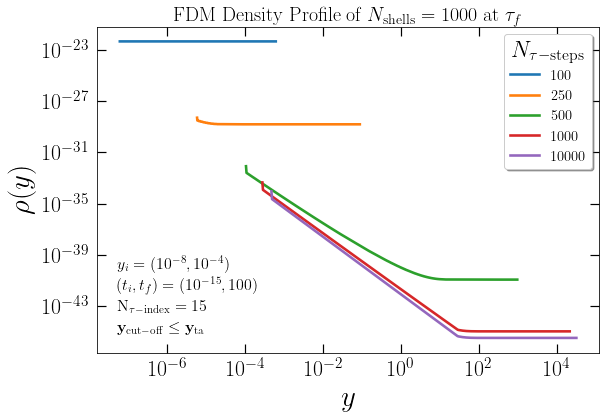

In [11]:
#  the density profile at t_f


data = np.load('fdm_cdm_N1000_t100_rta.npz')
r_sol_100 = data['r_sol_fdm']
rho_sol_100 = data['rho_sol_fdm']

data = np.load('fdm_cdm_N1000_t250_rta.npz')
r_sol_250 = data['r_sol_fdm']
rho_sol_250 = data['rho_sol_fdm']


data = np.load('fdm_cdm_N1000_t500_rta.npz')
r_sol_500 = data['r_sol_fdm']
rho_sol_500 = data['rho_sol_fdm']


data = np.load('fdm_cdm_N1000_t1000_rta.npz')
r_sol_1000 = data['r_sol_fdm']
rho_sol_1000 = data['rho_sol_fdm']



data = np.load('fdm_cdm_N1000_t10000_rta.npz')
r_sol_10000 = data['r_sol_fdm']
rho_sol_10000 = data['rho_sol_fdm']



fig, ax = plt.subplots(1, figsize=(9, 6), sharex=False)
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')



final_idx = -1



r_final_100 = r_sol_100[:, final_idx]
rho_final_100 = rho_sol_100[:, final_idx]
mask_100 = (r_final_100 > 0) & (rho_final_100 > 0)
r_valid_100 = r_final_100[mask_100]
rho_valid_100 = rho_final_100[mask_100]
sorted_idx_100 = np.argsort(r_valid_100)
r_valid_100 = r_valid_100[sorted_idx_100]
rho_valid_100 = rho_valid_100[sorted_idx_100]



r_final_250 = r_sol_250[:, final_idx]
rho_final_250 = rho_sol_250[:, final_idx]
mask_250 = (r_final_250 > 0) & (rho_final_250 > 0)
r_valid_250 = r_final_250[mask_250]
rho_valid_250 = rho_final_250[mask_250]
sorted_idx_250 = np.argsort(r_valid_250)
r_valid_250 = r_valid_250[sorted_idx_250]
rho_valid_250 = rho_valid_250[sorted_idx_250]



r_final_500 = r_sol_500[:, final_idx]
rho_final_500 = rho_sol_500[:, final_idx]
mask_500 = (r_final_500 > 0) & (rho_final_500 > 0)
r_valid_500 = r_final_500[mask_500]
rho_valid_500 = rho_final_500[mask_500]
sorted_idx_500 = np.argsort(r_valid_500)
r_valid_500 = r_valid_500[sorted_idx_500]
rho_valid_500 = rho_valid_500[sorted_idx_500]



r_final_1000 = r_sol_1000[:, final_idx]
rho_final_1000 = rho_sol_1000[:, final_idx]
mask_1000 = (r_final_1000 > 0) & (rho_final_1000 > 0)
r_valid_1000 = r_final_1000[mask_1000]
rho_valid_1000 = rho_final_1000[mask_1000]
sorted_idx_1000 = np.argsort(r_valid_1000)
r_valid_1000 = r_valid_1000[sorted_idx_1000]
rho_valid_1000 = rho_valid_1000[sorted_idx_1000]


r_final_10000 = r_sol_10000[:, final_idx]
rho_final_10000 = rho_sol_10000[:, final_idx]
mask_10000 = (r_final_10000 > 0) & (rho_final_10000 > 0)
r_valid_10000 = r_final_10000[mask_10000]
rho_valid_10000 = rho_final_10000[mask_10000]
sorted_idx_10000 = np.argsort(r_valid_10000)
r_valid_10000 = r_valid_10000[sorted_idx_10000]
rho_valid_10000 = rho_valid_10000[sorted_idx_10000]




ax.loglog(r_valid_100, rho_valid_100, '-', color='C0')
ax.loglog(r_valid_250, rho_valid_250, '-', color='C1')
ax.loglog(r_valid_500, rho_valid_500, '-', color='C2')
ax.loglog(r_valid_1000, rho_valid_1000, '-', color='C3')
ax.loglog(r_valid_10000, rho_valid_10000, '-', color='C4')

plt.text(5e-8, 9e-41, '$y_i = (10^{-8}, 10^{-4})$', fontsize=16)
plt.text(5e-8, 2e-42, '$(t_i, t_f) = (10^{-15}, 100)$', fontsize=16)
plt.text(5e-8, 5e-44, r'$\mathrm{N_{\tau-index}} = 15$ ', fontsize = 16)
plt.text(5e-8, 1e-45, r'$\mathbf{y_\mathrm{cut-off} \leq y_\mathrm{ta}}$ ', fontsize = 16)



ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)

ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=22) 
ax.yaxis.set_tick_params(labelsize=22) 

ax.set_title(r'FDM Density Profile of $N_\mathrm{shells} = 1000$ at $\tau_f$', fontsize=20)
ax.legend(['100', '250','500', '1000', '10000'], 
           prop = {'size':14.5},loc = 'upper right', shadow = True, 
           title = r'$N_\mathrm{\tau-steps}$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 31)

plt.savefig('y&rho_N1000.pdf', bbox_inches='tight')
plt.show()

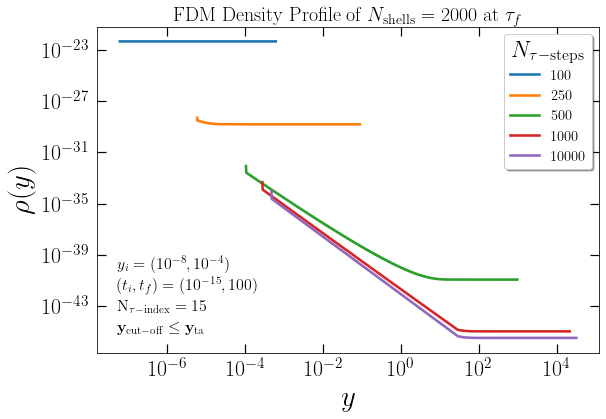

In [16]:
#  the density profile at t_f


data = np.load('fdm_cdm_N2000_t100_rta.npz')
r_sol_100 = data['r_sol_fdm']
rho_sol_100 = data['rho_sol_fdm']

data = np.load('fdm_cdm_N1000_t250_rta.npz')
r_sol_250 = data['r_sol_fdm']
rho_sol_250 = data['rho_sol_fdm']


data = np.load('fdm_cdm_N2000_t500_rta.npz')
r_sol_500 = data['r_sol_fdm']
rho_sol_500 = data['rho_sol_fdm']


data = np.load('fdm_cdm_N2000_t1000_rta.npz')
r_sol_1000 = data['r_sol_fdm']
rho_sol_1000 = data['rho_sol_fdm']



data = np.load('fdm_cdm_N2000_t10000_rta.npz')
r_sol_10000 = data['r_sol_fdm']
rho_sol_10000 = data['rho_sol_fdm']



fig, ax = plt.subplots(1, figsize=(9, 6), sharex=False)
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')



final_idx = -1



r_final_100 = r_sol_100[:, final_idx]
rho_final_100 = rho_sol_100[:, final_idx]
mask_100 = (r_final_100 > 0) & (rho_final_100 > 0)
r_valid_100 = r_final_100[mask_100]
rho_valid_100 = rho_final_100[mask_100]
sorted_idx_100 = np.argsort(r_valid_100)
r_valid_100 = r_valid_100[sorted_idx_100]
rho_valid_100 = rho_valid_100[sorted_idx_100]



r_final_250 = r_sol_250[:, final_idx]
rho_final_250 = rho_sol_250[:, final_idx]
mask_250 = (r_final_250 > 0) & (rho_final_250 > 0)
r_valid_250 = r_final_250[mask_250]
rho_valid_250 = rho_final_250[mask_250]
sorted_idx_250 = np.argsort(r_valid_250)
r_valid_250 = r_valid_250[sorted_idx_250]
rho_valid_250 = rho_valid_250[sorted_idx_250]



r_final_500 = r_sol_500[:, final_idx]
rho_final_500 = rho_sol_500[:, final_idx]
mask_500 = (r_final_500 > 0) & (rho_final_500 > 0)
r_valid_500 = r_final_500[mask_500]
rho_valid_500 = rho_final_500[mask_500]
sorted_idx_500 = np.argsort(r_valid_500)
r_valid_500 = r_valid_500[sorted_idx_500]
rho_valid_500 = rho_valid_500[sorted_idx_500]



r_final_1000 = r_sol_1000[:, final_idx]
rho_final_1000 = rho_sol_1000[:, final_idx]
mask_1000 = (r_final_1000 > 0) & (rho_final_1000 > 0)
r_valid_1000 = r_final_1000[mask_1000]
rho_valid_1000 = rho_final_1000[mask_1000]
sorted_idx_1000 = np.argsort(r_valid_1000)
r_valid_1000 = r_valid_1000[sorted_idx_1000]
rho_valid_1000 = rho_valid_1000[sorted_idx_1000]


r_final_10000 = r_sol_10000[:, final_idx]
rho_final_10000 = rho_sol_10000[:, final_idx]
mask_10000 = (r_final_10000 > 0) & (rho_final_10000 > 0)
r_valid_10000 = r_final_10000[mask_10000]
rho_valid_10000 = rho_final_10000[mask_10000]
sorted_idx_10000 = np.argsort(r_valid_10000)
r_valid_10000 = r_valid_10000[sorted_idx_10000]
rho_valid_10000 = rho_valid_10000[sorted_idx_10000]




ax.loglog(r_valid_100, rho_valid_100, '-', color='C0')
ax.loglog(r_valid_250, rho_valid_250, '-', color='C1')
ax.loglog(r_valid_500, rho_valid_500, '-', color='C2')
ax.loglog(r_valid_1000, rho_valid_1000, '-', color='C3')
ax.loglog(r_valid_10000, rho_valid_10000, '-', color='C4')


plt.text(5e-8, 9e-41, '$y_i = (10^{-8}, 10^{-4})$', fontsize=16)
plt.text(5e-8, 2e-42, '$(t_i, t_f) = (10^{-15}, 100)$', fontsize=16)
plt.text(5e-8, 5e-44, r'$\mathrm{N_{\tau-index}} = 15$ ', fontsize = 16)
plt.text(5e-8, 1e-45, r'$\mathbf{y_\mathrm{cut-off} \leq y_\mathrm{ta}}$ ', fontsize = 16)

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)

ax.set_xlabel(r'$y$', fontsize= 29, labelpad = 6)
ax.set_ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 6)
ax.xaxis.set_tick_params(labelsize=22) 
ax.yaxis.set_tick_params(labelsize=22) 

ax.set_title(r'FDM Density Profile of $N_\mathrm{shells} = 2000$ at $\tau_f$', fontsize=20)
ax.legend(['100', '250','500', '1000', '10000'], 
           prop = {'size':14.5},loc = 'upper right', shadow = True, 
           title = r'$N_\mathrm{\tau-steps}$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 31)

plt.savefig('y&rho_N2000.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# Fitting of the density profile evaluated with 500 time steps 

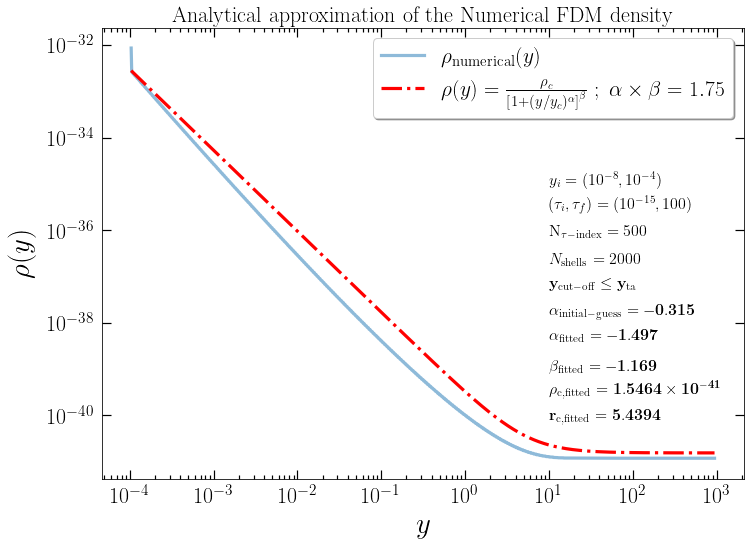

Fitted rho_c = 1.5464e-41
Fitted r_c = 5.4394e+00
Fitted alpha = -1.497
Implied beta = -1.169
Outer slope (fixed) = -1.75


In [2]:
data = np.load('fdm_cdm_N2000_t500_rta.npz')

r_sol = data['r_sol_fdm']
v_sol = data['v_sol_fdm']
rho_sol = data['rho_sol_fdm']
QP_arr = data['QP_arr_fdm']
cutoff_index = data['cutoff_index_fdm']
r_ta_arr = data['r_ta_arr_fdm']
t_ta_arr = data['t_ta_arr_fdm']
rho_arr = data['rho_arr_fdm']
rta_mask = data['rta_mask_fdm']
tta_mask = data['tta_mask_fdm']



fig, ax = plt.subplots(figsize=(11.5, 8.3))
plt.rc('lines', linewidth=3.2)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')


# Fitting fdm numerical density with condition that ((alpha x beta) = 2.25)
def rho_constrained(r, rho_c, r_c, alpha):
    beta = 1.75/alpha
    ratio = np.clip(r/r_c, 1e-10, None)
    return rho_c/ ((1 + ratio**alpha)**beta)





final_idx = -1
r_final = r_sol[:, final_idx]
rho_final = rho_sol[:, final_idx]
mask = (r_final > 0) & (rho_final > 0)
r_valid = r_final[mask]
rho_valid = rho_final[mask]

sorted_idx = np.argsort(r_valid)
r_valid = r_valid[sorted_idx]
rho_valid = rho_valid[sorted_idx]

# Initial guess for rho_c, r_c, alpha
initial_guess = [np.max(rho_valid), np.median(r_valid), -0.315] #-0.595 gives exact fit

popt, _ = curve_fit(rho_constrained, r_valid, rho_valid, p0=initial_guess, maxfev=50000)
rho_c_fit, r_c_fit, alpha_fit = popt
beta_fit = 1.75/alpha_fit



ax.loglog(r_valid, rho_valid,   color='C0', alpha = 0.5)
ax.loglog(r_valid, rho_constrained(r_valid, *popt), 'r', ls = '-.')



plt.text(10, 1e-35, '$y_i = (10^{-8}, 10^{-4})$', fontsize = 16)
plt.text(10, 3e-36, r'$(\tau_i, \tau_f) = (10^{-15}, 100)$', fontsize = 16)
plt.text(10, 8e-37, r'$\mathrm{N_{\tau-index}} = 500$ ', fontsize = 16)
plt.text(10, 2e-37, r'$N_\mathrm{shells} = 2000$ ', fontsize = 16)
plt.text(10, 6e-38, r'$\mathbf{y_\mathrm{cut-off} \leq  y_\mathrm{ta}}$ ', fontsize = 16)
plt.text(10, 1.5e-38, r'$\mathbf{\alpha_\mathrm{initial-guess} = -0.315}$ ', fontsize = 16)
plt.text(10, 4.5e-39, r'$\mathbf{\alpha_\mathrm{fitted} = -1.497}$ ', fontsize = 16)
plt.text(10, 9.5e-40, r'$\mathbf{\beta_\mathrm{fitted} = -1.169}$ ', fontsize = 16)
plt.text(10, 3e-40, r'$\mathbf{\rho_\mathrm{c,fitted} = 1.5464 \times 10^{-41}}$ ', fontsize = 16)
plt.text(10, 8e-41, r'$\mathbf{r_\mathrm{c,fitted} = 5.4394}$ ', fontsize = 16)



ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)
plt.xlabel(r'$y$', fontsize=29, labelpad=6)
plt.ylabel(r'$\rho(y)$', fontsize=29, labelpad=11)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
ax.set_title('Analytical Fitting of the FDM density profile', fontsize=20)
ax.legend([r'$\rho_\mathrm{numerical}(y)$',
           r'$\rho(y) = \frac{\rho_c}{\left[1 + (y/y_c)^{\alpha}\right]^{\beta}}\;;\; \alpha \times \beta = 1.75$'],
           prop = {'size':21.5},loc = 'upper right', shadow = True, 
          title_fontsize = 23,
           facecolor = 'white',fontsize = 31)


plt.title('Analytical approximation of the Numerical FDM density', fontsize = 22)


plt.savefig('fdm_N500_rhofit_rta1.pdf', bbox_inches = 'tight')
plt.show()

print(f"Fitted rho_c = {rho_c_fit:.4e}")
print(f"Fitted r_c = {r_c_fit:.4e}")
print(f"Fitted alpha = {alpha_fit:.3f}")
print(f"Implied beta = {beta_fit:.3f}")
print(f"Outer slope (fixed) = -1.75")


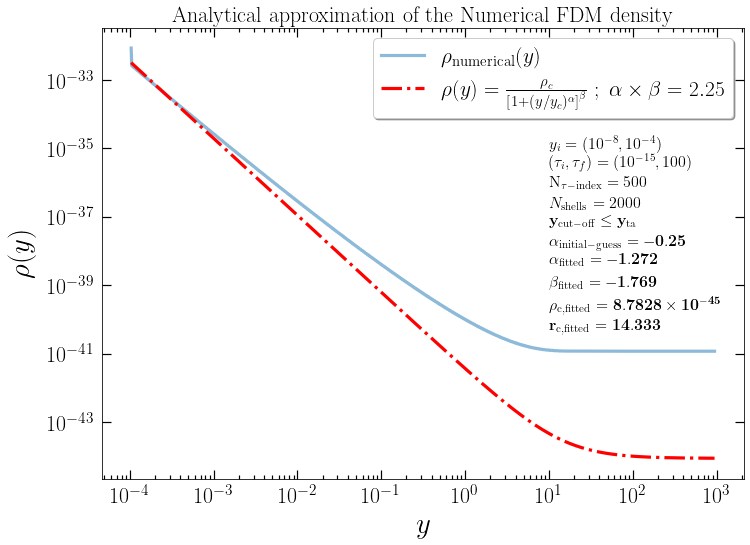

Fitted rho_c = 8.7828e-45
Fitted r_c = 1.4333e+01
Fitted alpha = -1.272
Implied beta = -1.769
Outer slope (fixed) = -2.25


In [3]:
data = np.load('fdm_cdm_N2000_t500_rta.npz')

r_sol = data['r_sol_fdm']
v_sol = data['v_sol_fdm']
rho_sol = data['rho_sol_fdm']
QP_arr = data['QP_arr_fdm']
cutoff_index = data['cutoff_index_fdm']
r_ta_arr = data['r_ta_arr_fdm']
t_ta_arr = data['t_ta_arr_fdm']
rho_arr = data['rho_arr_fdm']
rta_mask = data['rta_mask_fdm']
tta_mask = data['tta_mask_fdm']



fig, ax = plt.subplots(figsize=(11.5, 8.3))
plt.rc('lines', linewidth=3.2)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')


# Fitting fdm numerical density with condition that ((alpha x beta) = 2.25)
def rho_constrained(r, rho_c, r_c, alpha):
    beta = 2.25/alpha
    ratio = np.clip(r/r_c, 1e-10, None)
    return rho_c/ ((1 + ratio**alpha)**beta)





final_idx = -1
r_final = r_sol[:, final_idx]
rho_final = rho_sol[:, final_idx]
mask = (r_final > 0) & (rho_final > 0)
r_valid = r_final[mask]
rho_valid = rho_final[mask]

sorted_idx = np.argsort(r_valid)
r_valid = r_valid[sorted_idx]
rho_valid = rho_valid[sorted_idx]

# Initial guess for rho_c, r_c, alpha
initial_guess = [np.max(rho_valid), np.median(r_valid), -0.25] #-0.595 gives exact fit

popt, _ = curve_fit(rho_constrained, r_valid, rho_valid, p0=initial_guess, maxfev=50000)
rho_c_fit, r_c_fit, alpha_fit = popt
beta_fit = 2.25/alpha_fit



ax.loglog(r_valid, rho_valid,   color='C0', alpha = 0.5)
ax.loglog(r_valid, rho_constrained(r_valid, *popt), 'r', ls = '-.')



plt.text(10, 1e-35, '$y_i = (10^{-8}, 10^{-4})$', fontsize = 16)
plt.text(10, 3e-36, r'$(\tau_i, \tau_f) = (10^{-15}, 100)$', fontsize = 16)
plt.text(10, 8e-37, r'$\mathrm{N_{\tau-index}} = 500$ ', fontsize = 16)
plt.text(10, 2e-37, r'$N_\mathrm{shells} = 2000$ ', fontsize = 16)
plt.text(10, 6e-38, r'$\mathbf{y_\mathrm{cut-off} \leq  y_\mathrm{ta}}$ ', fontsize = 16)
plt.text(10, 1.5e-38, r'$\mathbf{\alpha_\mathrm{initial-guess} = -0.25}$ ', fontsize = 16)
plt.text(10, 4.5e-39, r'$\mathbf{\alpha_\mathrm{fitted} = -1.272}$ ', fontsize = 16)
plt.text(10, 9.5e-40, r'$\mathbf{\beta_\mathrm{fitted} = -1.769}$ ', fontsize = 16)
plt.text(10, 2e-40, r'$\mathbf{\rho_\mathrm{c,fitted} = 8.7828 \times 10^{-45}}$ ', fontsize = 16)
plt.text(10, 5e-41, r'$\mathbf{r_\mathrm{c,fitted} = 14.333}$ ', fontsize = 16)




ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)
plt.xlabel(r'$y$', fontsize=29, labelpad=6)
plt.ylabel(r'$\rho(y)$', fontsize=29, labelpad=11)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
ax.set_title('Analytical Fitting of the FDM density profile', fontsize=20)
ax.legend([r'$\rho_\mathrm{numerical}(y)$',
           r'$\rho(y) = \frac{\rho_c}{\left[1 + (y/y_c)^{\alpha}\right]^{\beta}}\;;\; \alpha \times \beta = 2.25$'],
           prop = {'size':21.5},loc = 'upper right', shadow = True, 
          title_fontsize = 23,
           facecolor = 'white',fontsize = 31)


plt.title('Analytical approximation of the Numerical FDM density', fontsize = 22)


plt.savefig('fdm_N500_rhofit_rta2.pdf', bbox_inches = 'tight')
plt.show()

print(f"Fitted rho_c = {rho_c_fit:.4e}")
print(f"Fitted r_c = {r_c_fit:.4e}")
print(f"Fitted alpha = {alpha_fit:.3f}")
print(f"Implied beta = {beta_fit:.3f}")
print(f"Outer slope (fixed) = -2.25")
